In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%reload_ext autoreload
%matplotlib inline
%autoreload 2

import warnings
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
from joblib import dump, load
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import train_test_split

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [3]:
np.set_printoptions(suppress=True, precision=3, linewidth=120)

In [26]:
def mae(y_trues, y_preds):
    return np.mean(np.abs(y_trues-y_preds))

def rmse(y_trues, y_preds):
    return np.sqrt(np.mean(np.power(y_trues-y_preds, 2)))

def mrae(y_trues, y_preds):
    return np.mean(np.abs(np.divide(y_trues -y_preds, y_trues)))

# The Purpose Study :

In this study we are going to treat our data set as a time dependent data set. And thus each feature explains a timeseries. And the goal is to determine the importance of each features (timeseries) for predicting the target values.

### Load data set and split it

In [4]:
pld_complete_range = pd.read_csv("../../data/pld_complete_range.csv", index_col=False)
pld_complete = catalog.load('pld_complete').dropna().sort_values('pos', ascending=True)

2021-02-02 15:37:25,196 - kedro.io.data_catalog - INFO - Loading data from `pld_complete` (ParquetDataSet)...


In [5]:
pld_complete_range.head()

median_Voltage_HSR_V_1025  median_Voltage_HSR_V_1027  \
0                   0.129479                   0.177414   
1                   0.110059                   0.340245   
2                   0.119769                   0.340245   
3                   0.110059                   0.348139   
4                   0.110059                   0.264593   

   median_Voltage_HSR_V_1030  median_Voltage_HSL_V_1025  \
0                   0.005142                    0.69562   
1                   0.005142                    0.69562   
2                   0.005142                    0.69562   
3                   0.005142                    0.69562   
4                   0.005142                    0.69562   

   median_Voltage_HSL_V_1027  median_Voltage_HSL_V_1030  \
0                  -0.256257                  -0.015406   
1                  -0.321465                  -0.015406   
2                  -0.321465                  -0.015406   
3                  -0.322354                  -0.015406   
4                  -0.305820                  -0.015406   

   median_Voltage_HF_V_1025  median_Voltage_HF_V_1027  \
0                 -0.009215                 -0.072807   
1                 -0.009215                 -0.173901   
2                 -0.007363                 -0.173901   
3                 -0.009215                 -0.218270   
4                 -0.009215                 -0.129533   

   median_Voltage_HF_V_1030  median_Voltage_HC_V_1025  ...  std_Sigma_1030  \
0                 -0.021102                  0.057123  ...       -0.390667   
1                 -0.021102                  0.050178  ...       -0.390667   
2                 -0.021102                  0.057123  ...       -0.390667   
3                 -0.021102                  0.057123  ...       -0.390667   
4                 -0.021102                  0.057123  ...       -0.390667   

        pos     Speed    X FWHM    Y FWHM    R FWHM  Coolness  Coolness_neg  \
0 -0.501695  0.009841  0.039589  0.067470  0.015697  0.053006     -0.086369   
1 -0.501652 -0.005266  0.039589  0.067470  0.015697  0.053006     -0.086369   
2 -0.501646 -0.007197  0.039589  0.067470  0.015697  0.053006     -0.086369   
3 -0.501635 -0.010946  0.039589  0.067470  0.015697  0.053006     -0.086369   
4 -0.501619 -0.017147  0.042682  0.069442  0.017956  0.051965     -0.084836   

      Ic   Ic_norm  
0  496.2  1.767913  
1  494.7  1.762568  
2  494.2  1.760787  
3  495.5  1.765419  
4  497.9  1.773168  

[5 rows x 379 columns]

In [6]:
x_r = pld_complete_range.loc[:, ~pld_complete_range.columns.isin(['Ic', 'Ic_norm', 'pos'])]  # .to_numpy()
y = pld_complete_range['Ic_norm']  # .to_numpy()

pos = pld_complete_range['pos']  # .to_numpy()
ic_norm = pld_complete_range['Ic_norm']
ic = pld_complete_range['Ic']
coolness = pld_complete_range['Coolness']

x_r.shape, y.shape, pos.shape

((18561, 376), (18561,), (18561,))

In [7]:
x_r_train, x_r_test, y_train, y_test = train_test_split(x_r, y,
                                                        test_size=0.25,
                                                        random_state=43,
                                                       shuffle=True)

x_r_train.shape, x_r_test.shape, y_train.shape, y_test.shape

((13920, 376), (4641, 376), (13920,), (4641,))

### Plotting Autocorrelation:

Autocorrelation, also known as serial correlation, is the correlation of a signal with a delayed copy of itself as a function of delay. Informally, it is the similarity between observations as a function of the time lag between them

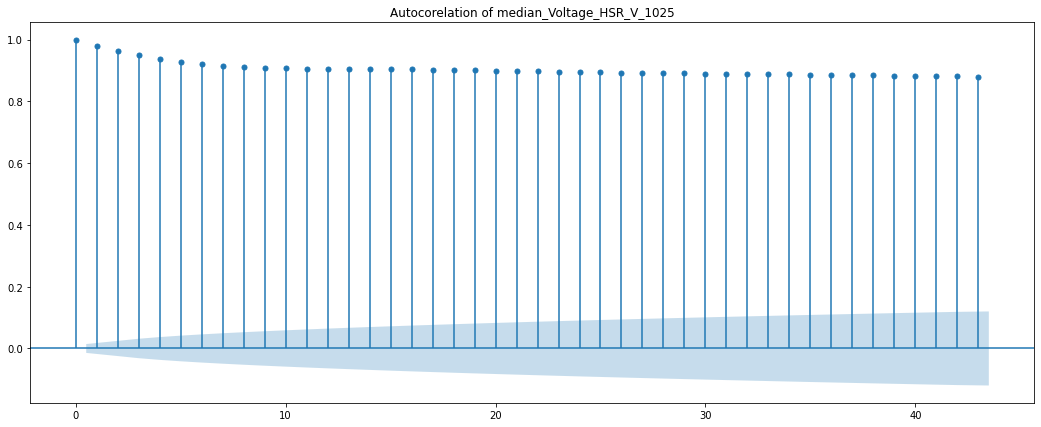

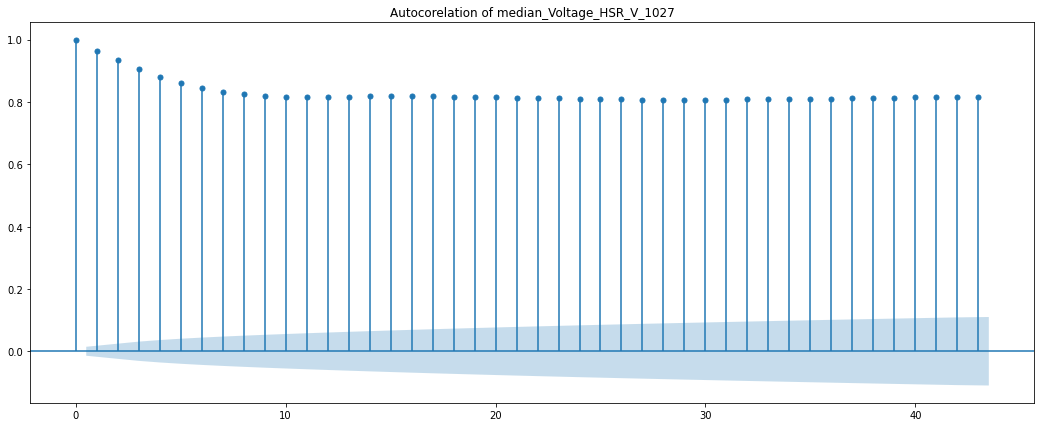

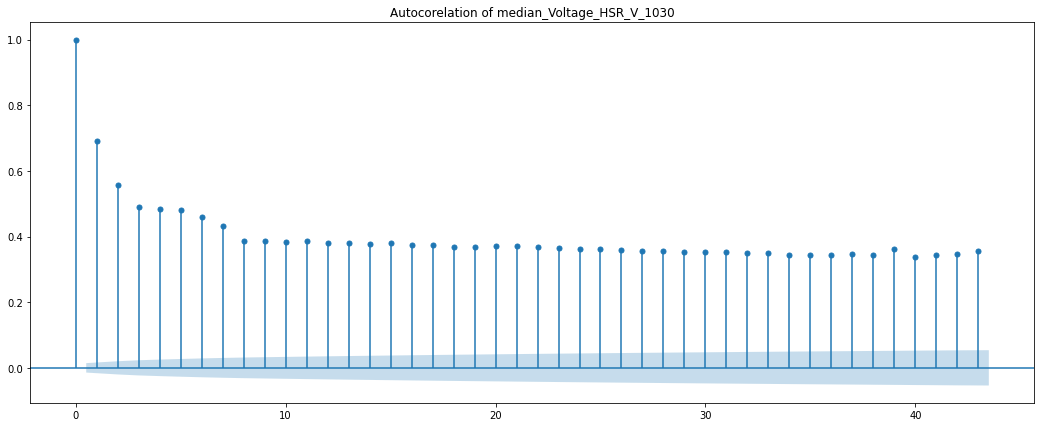

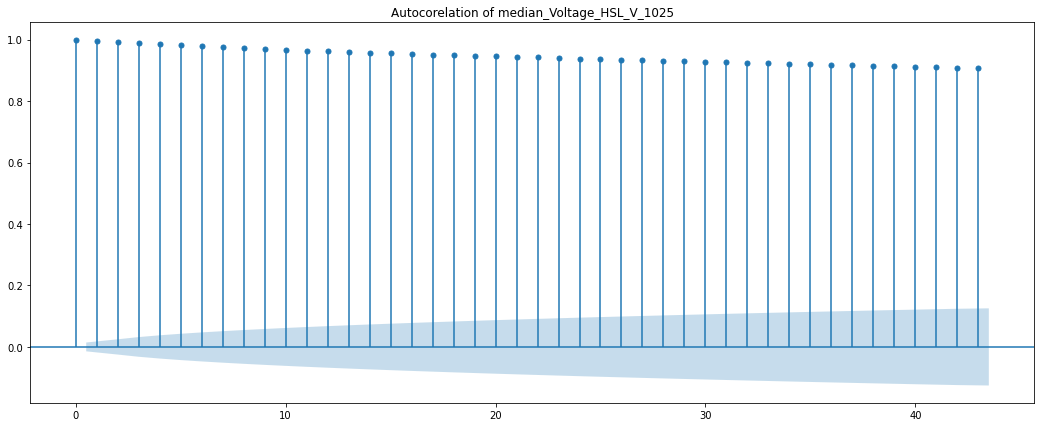

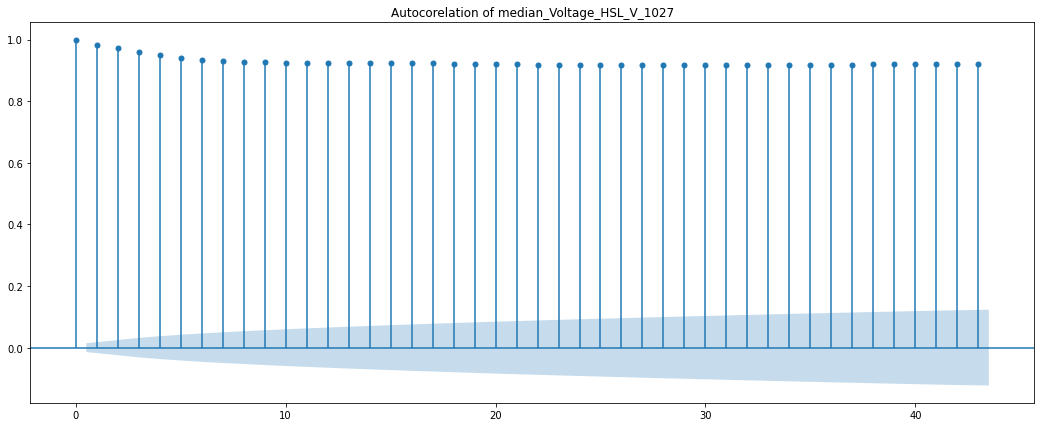

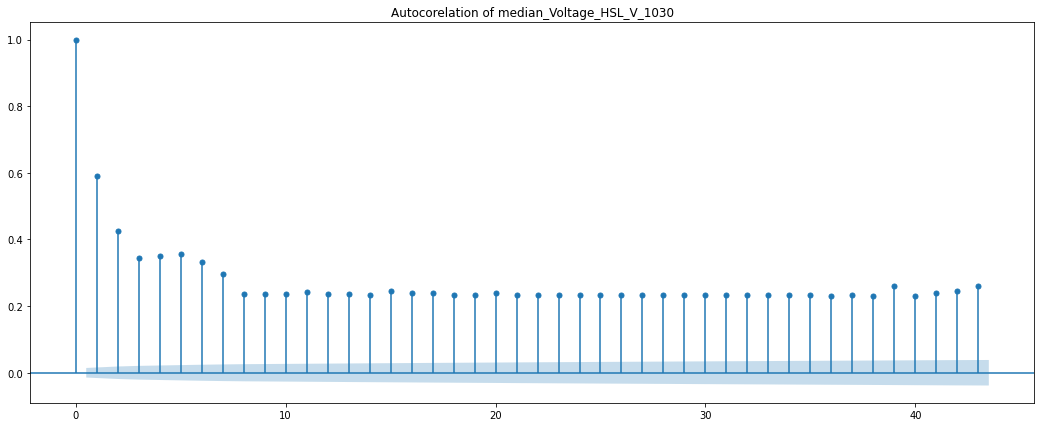

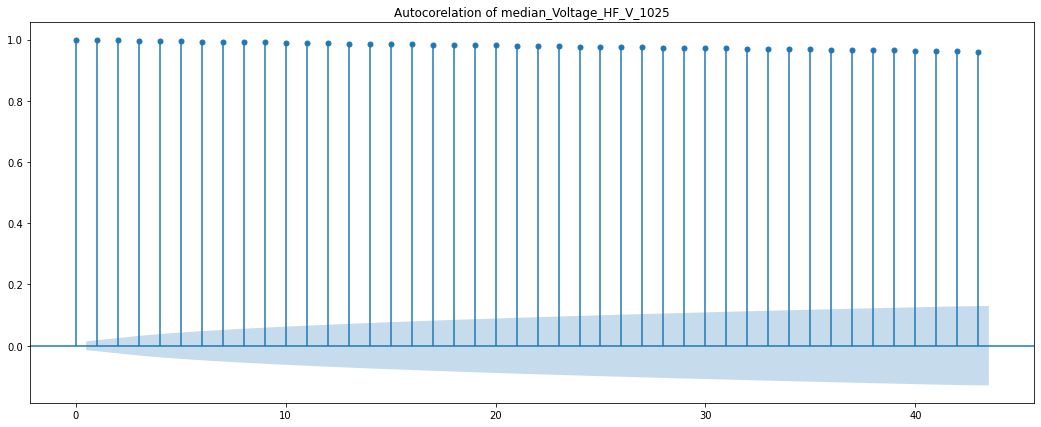

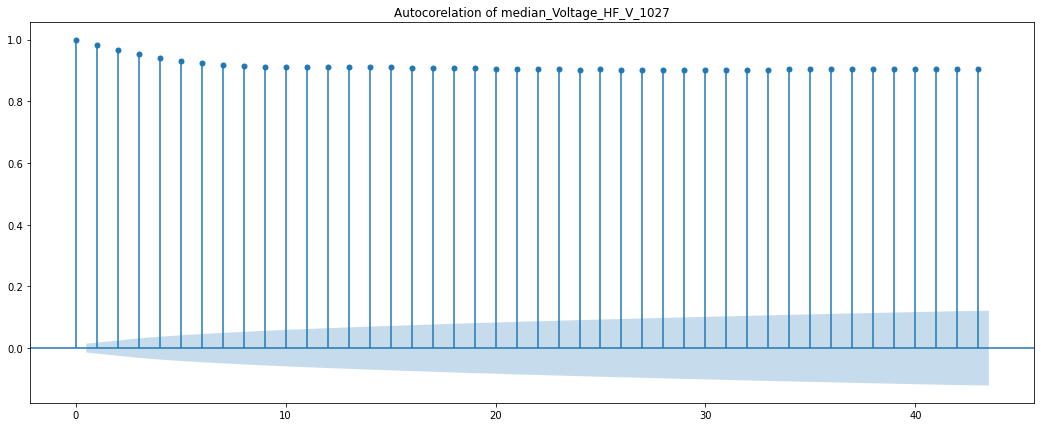

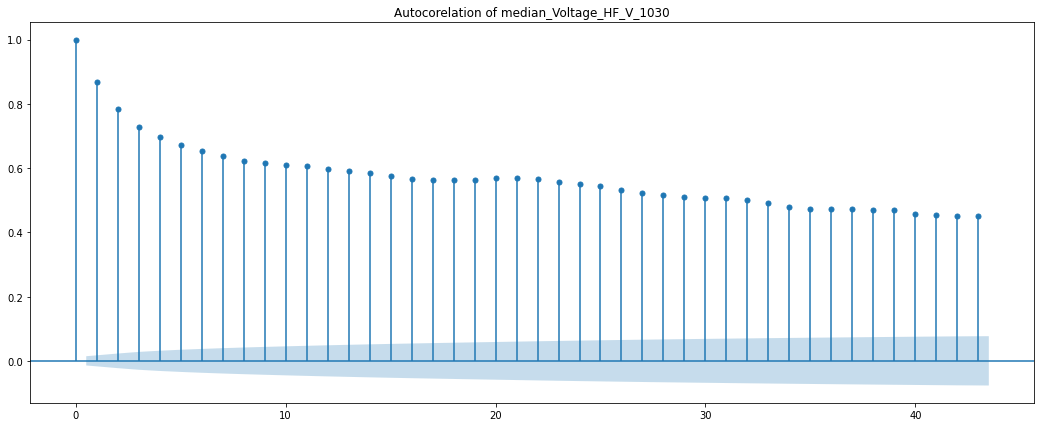

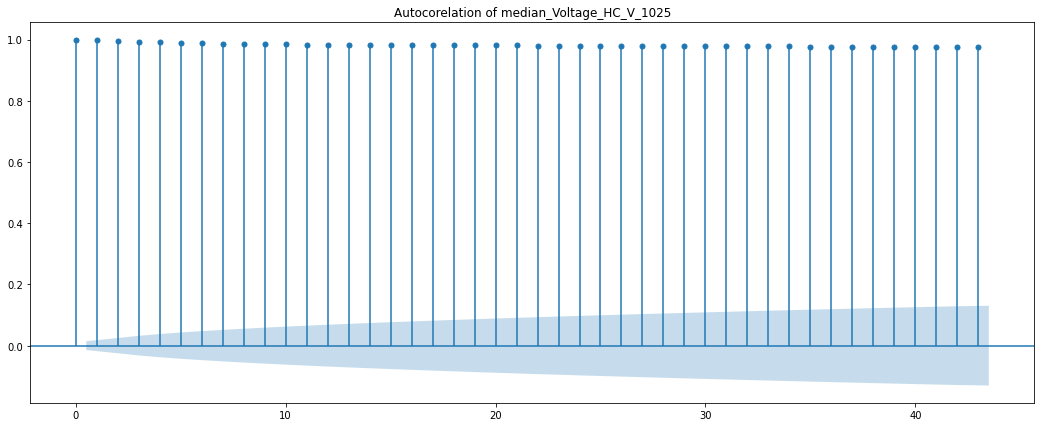

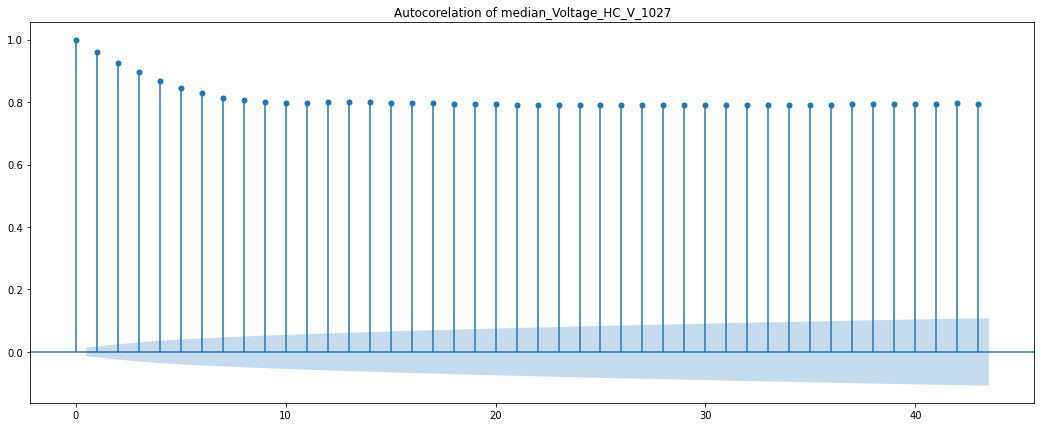

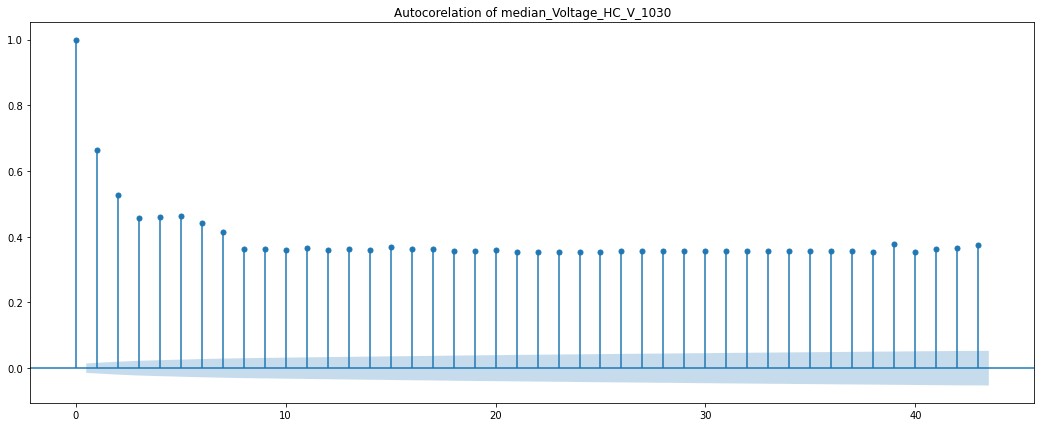

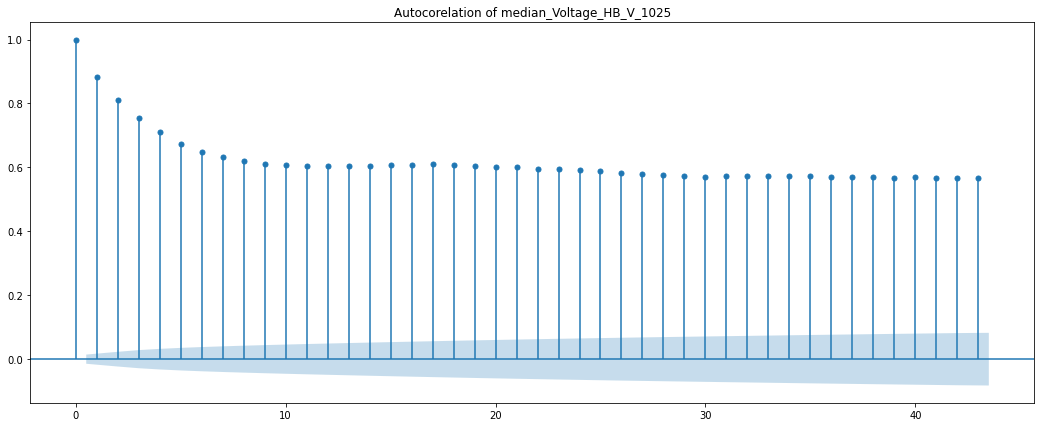

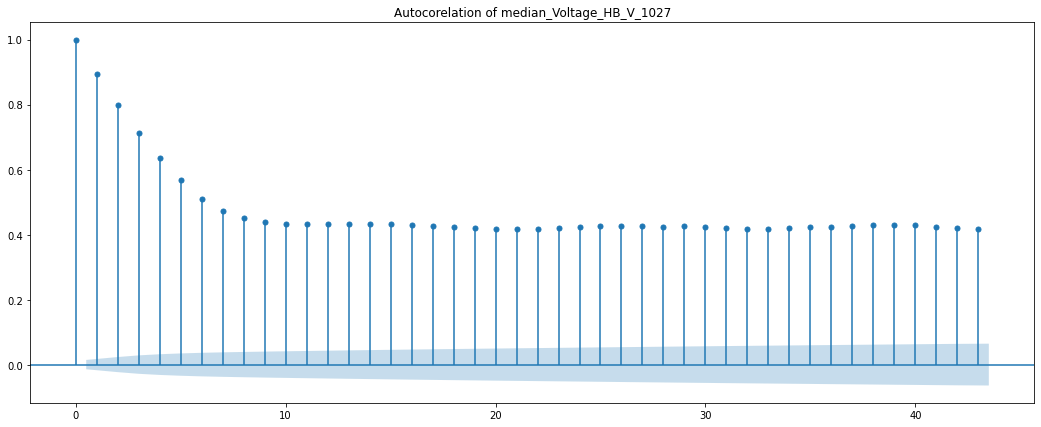

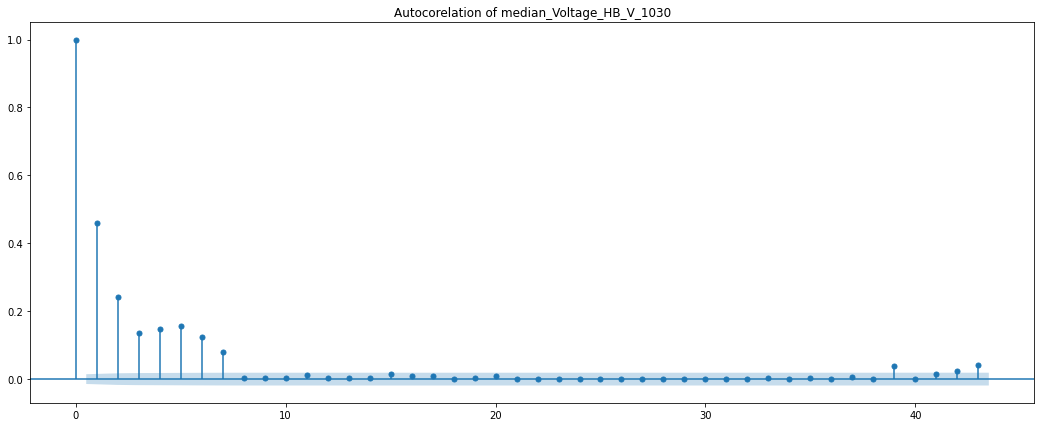

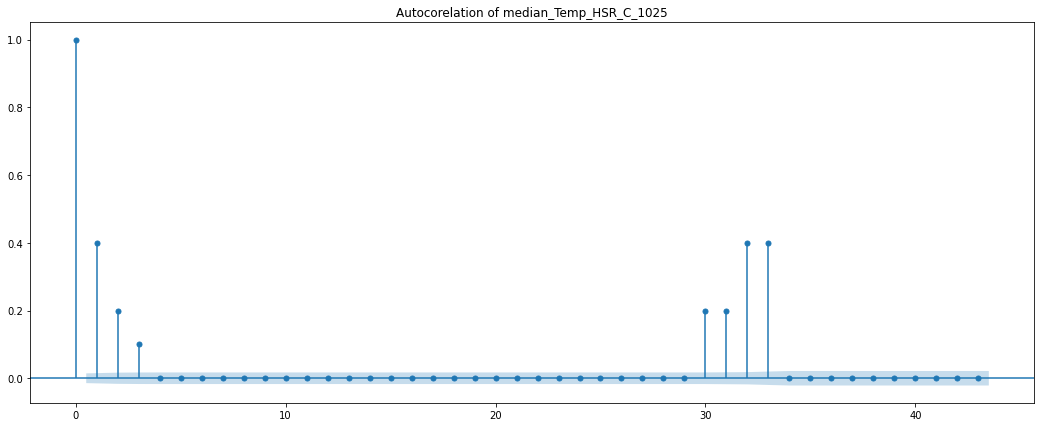

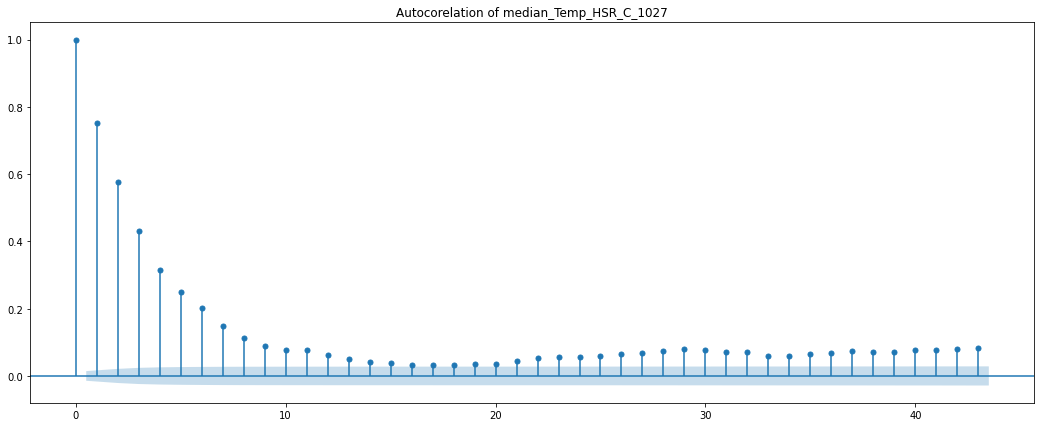

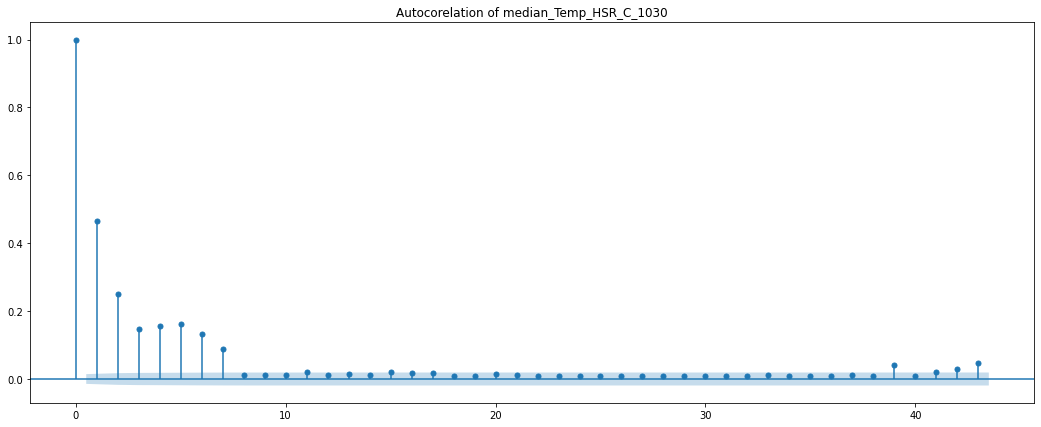

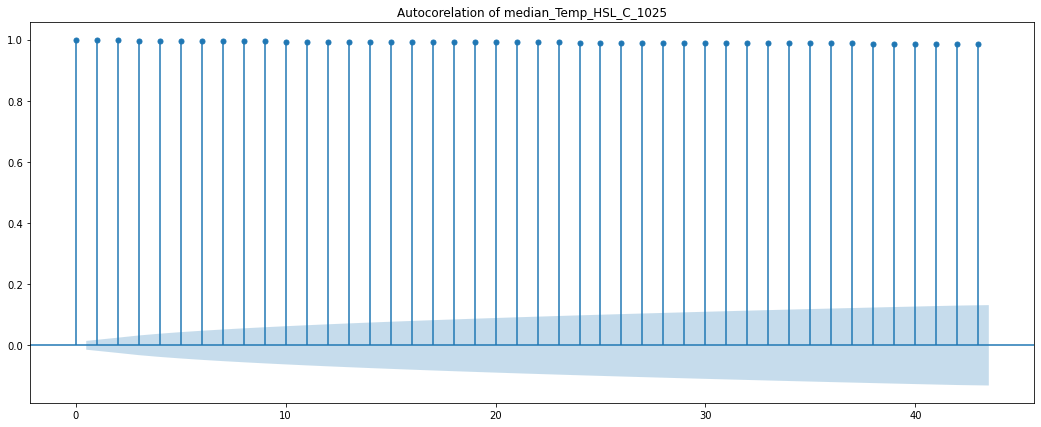

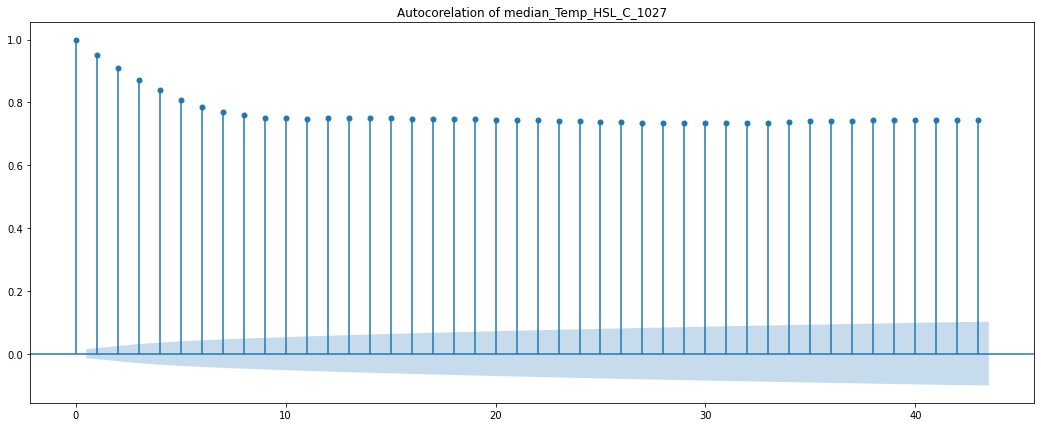

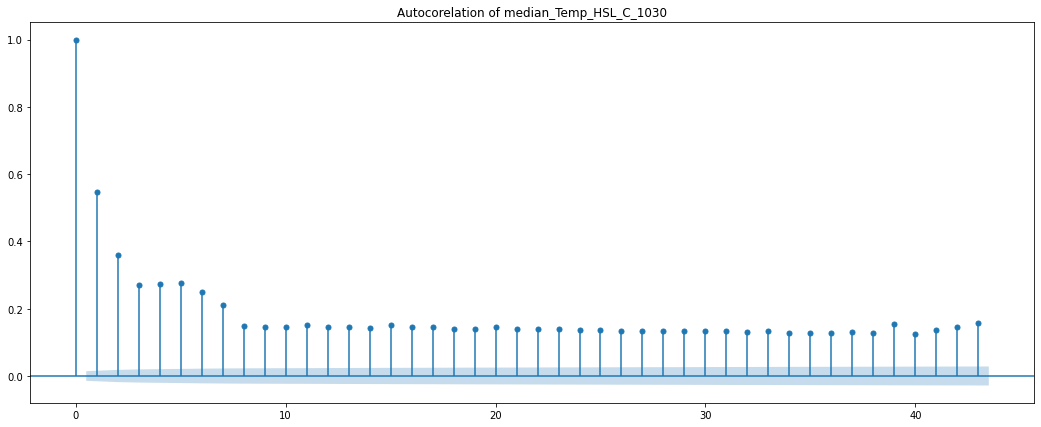

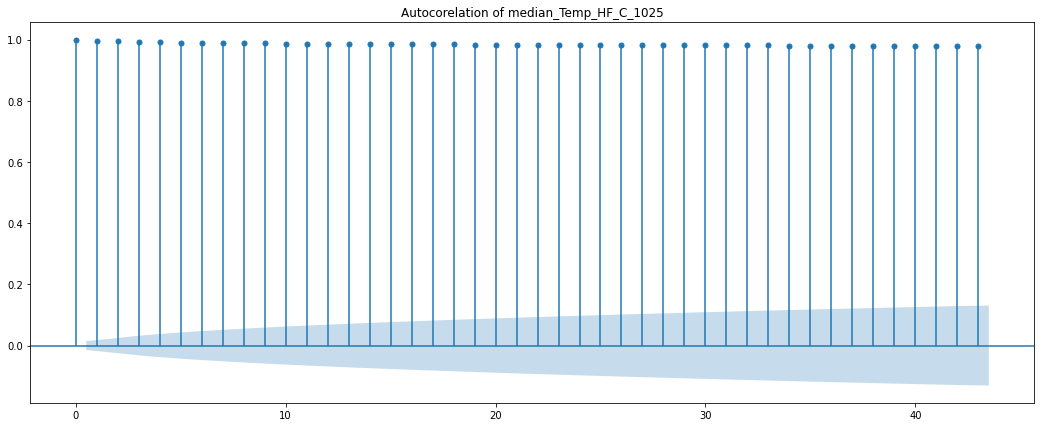

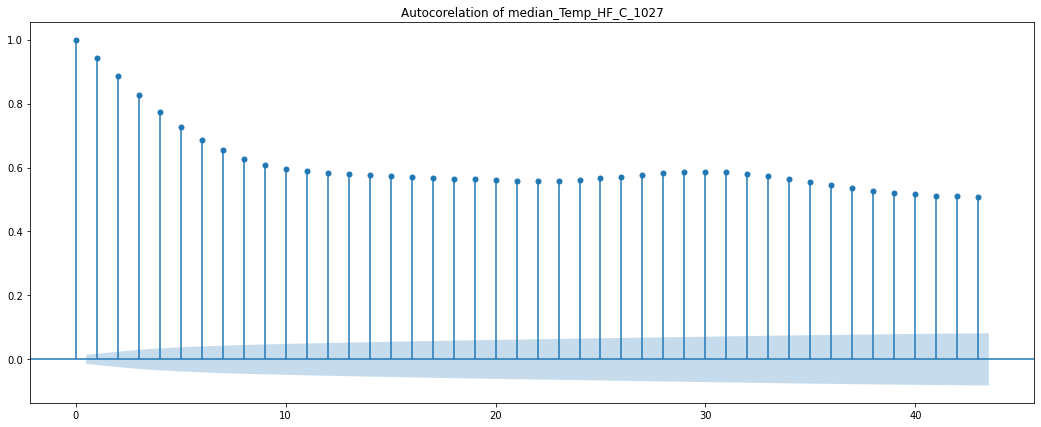

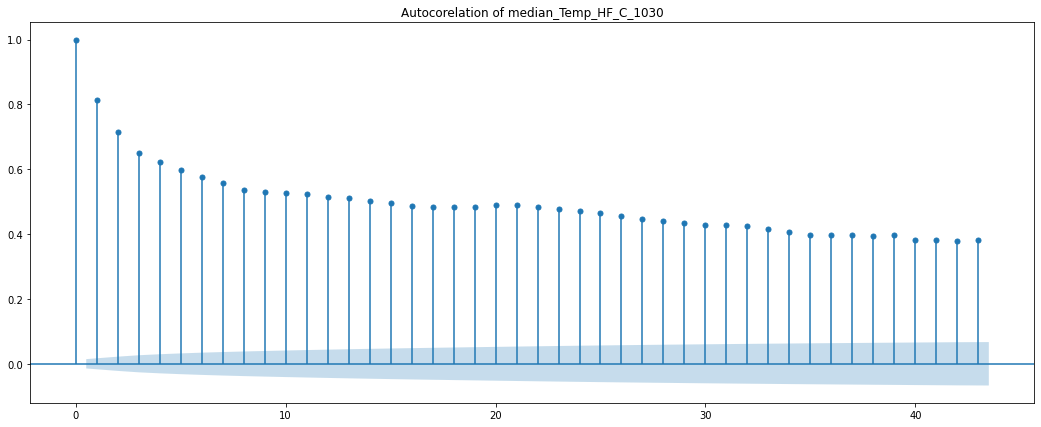

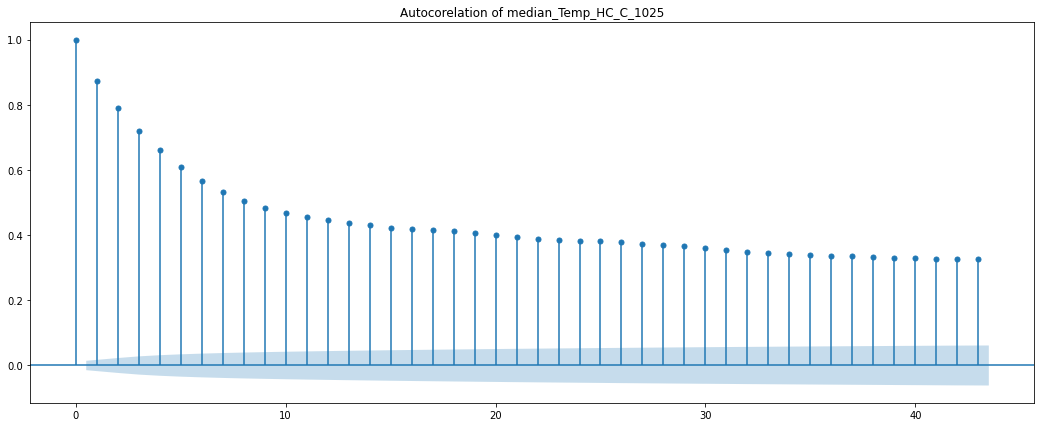

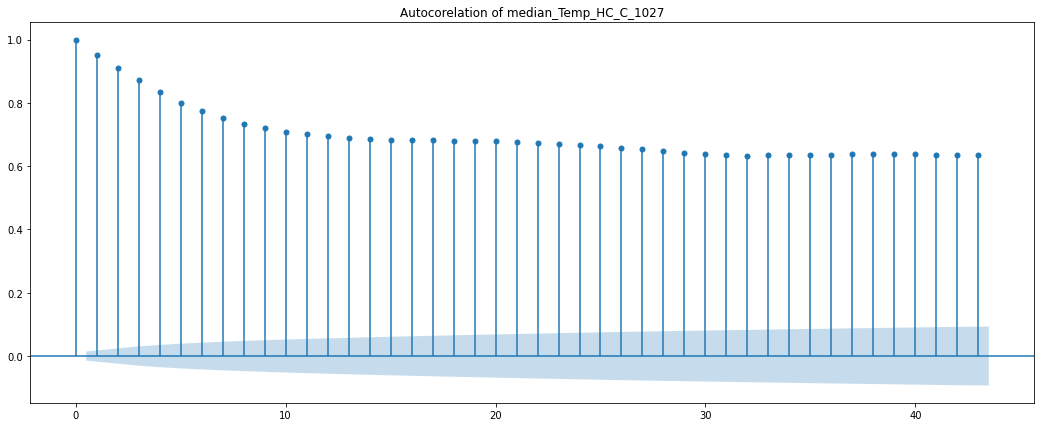

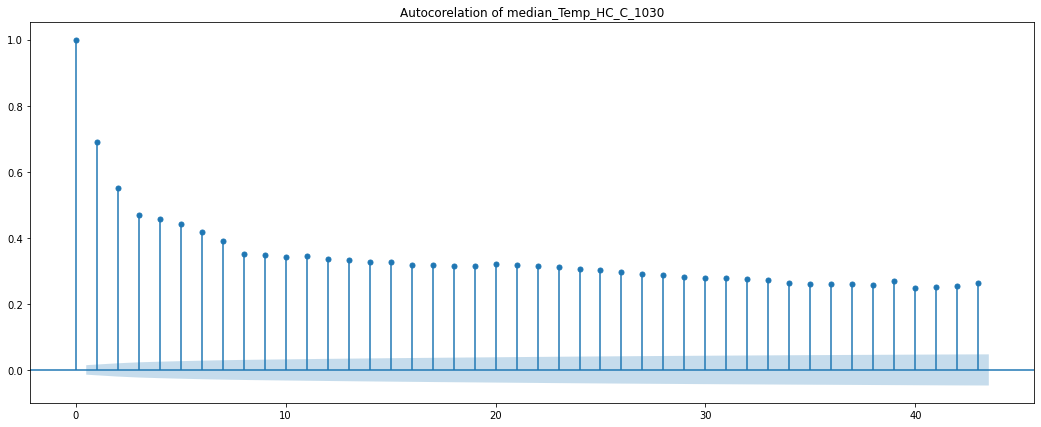

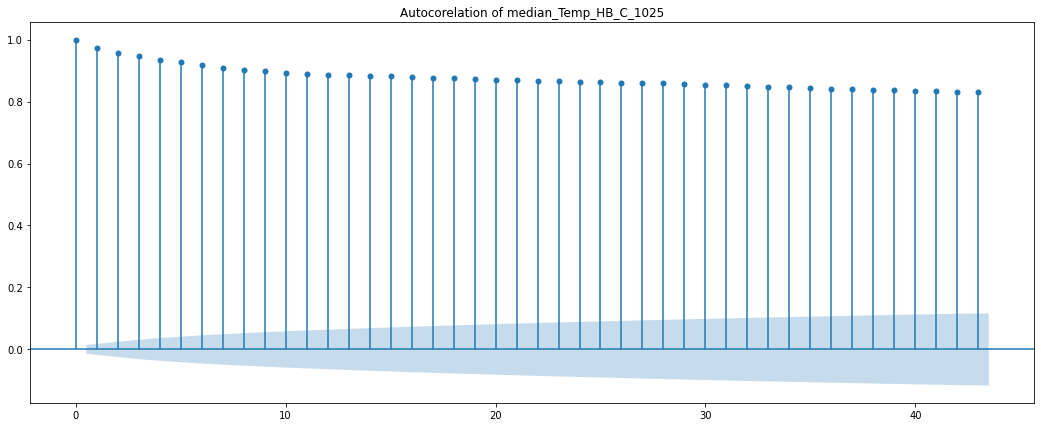

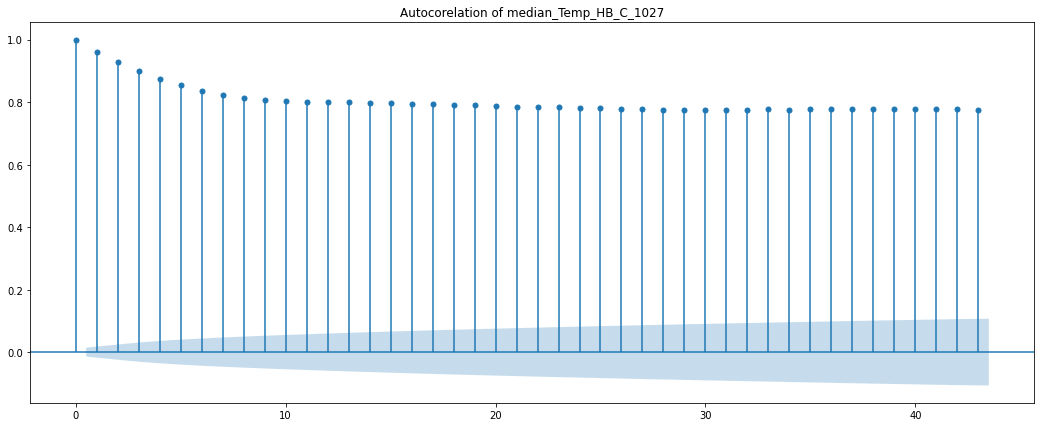

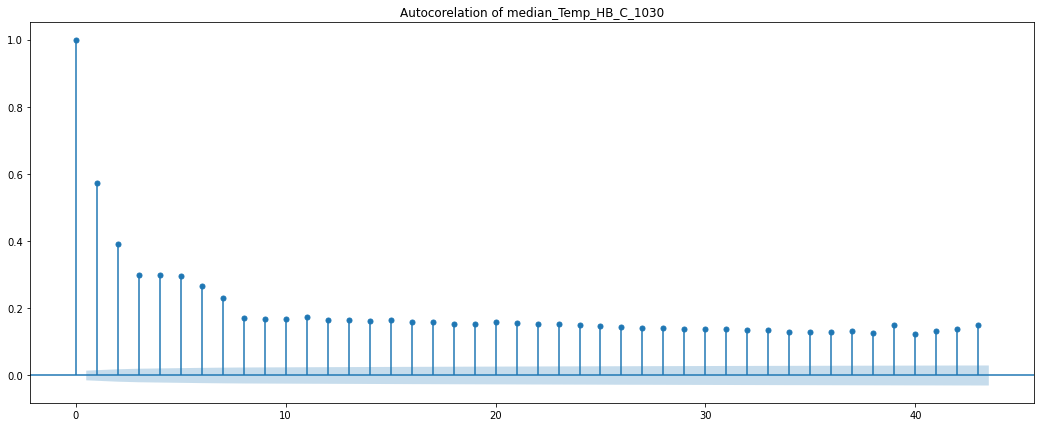

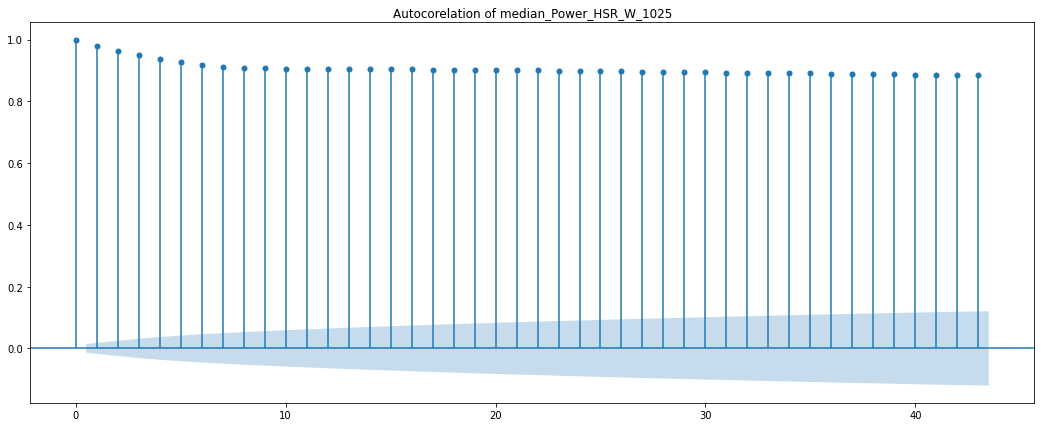

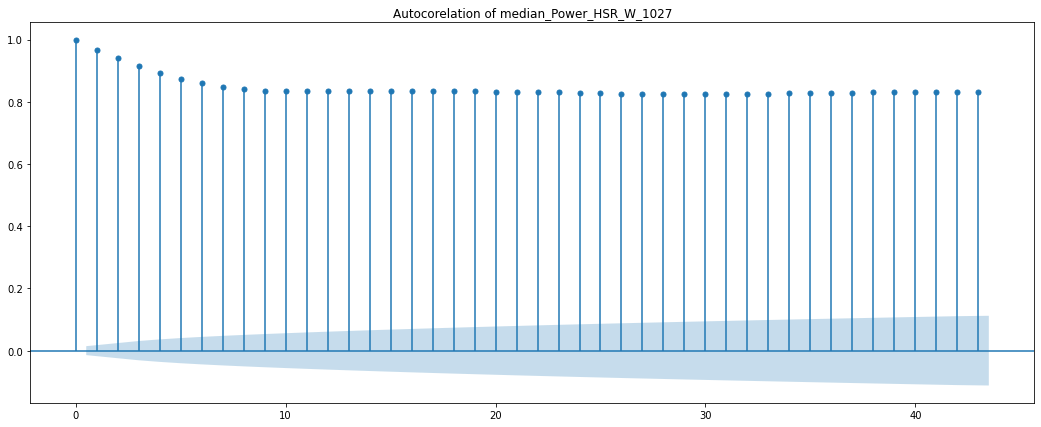

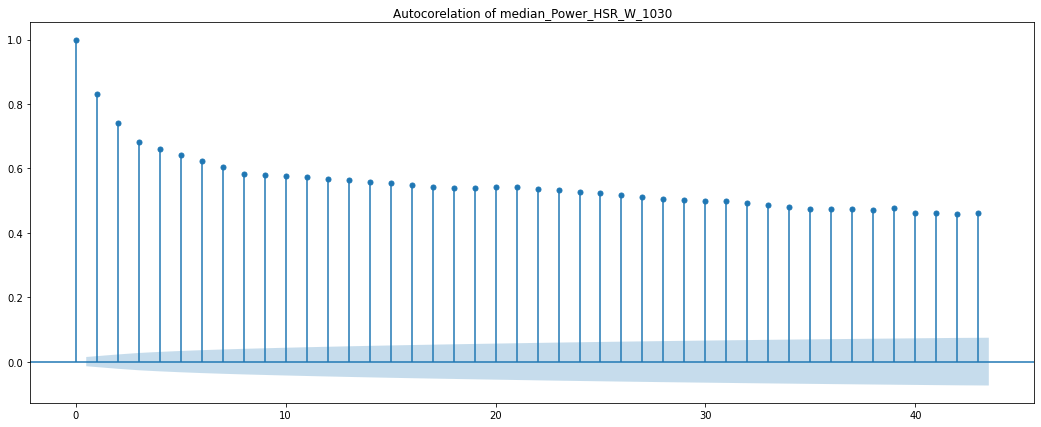

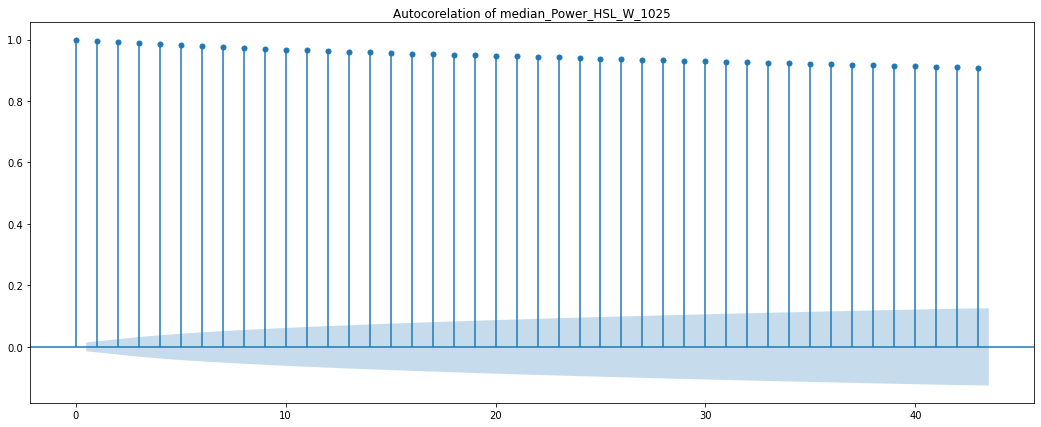

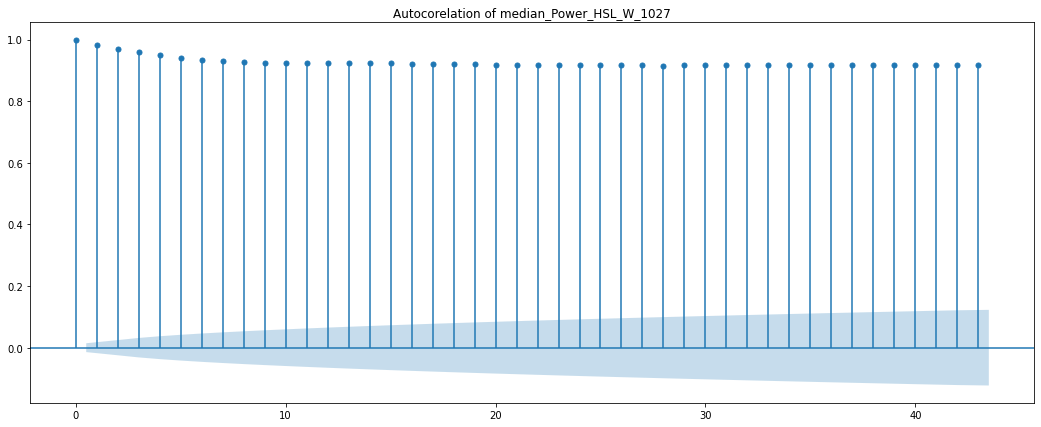

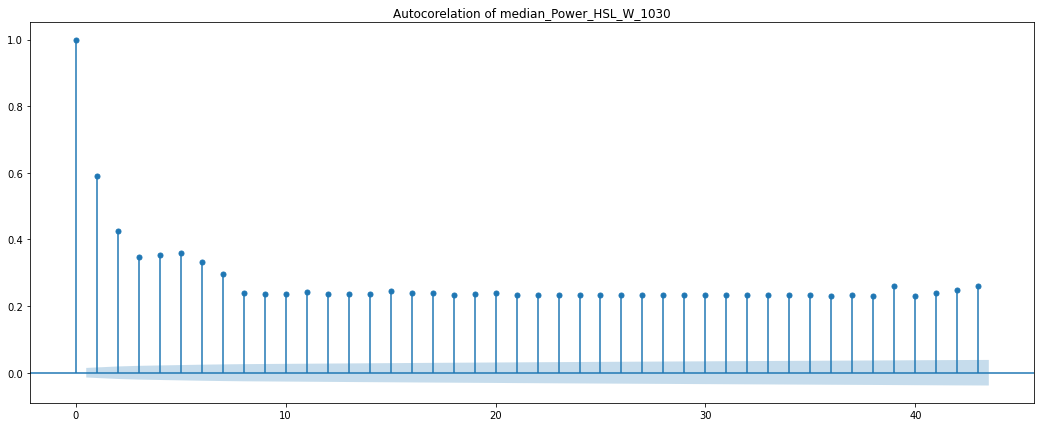

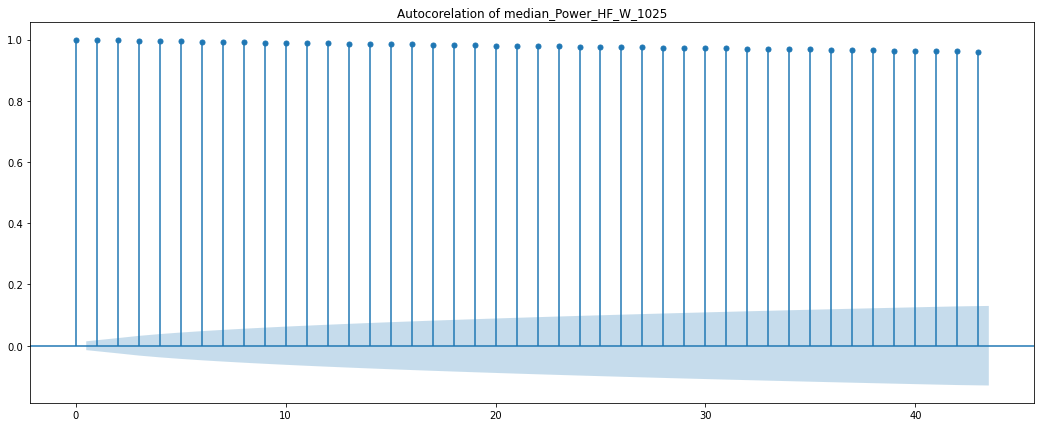

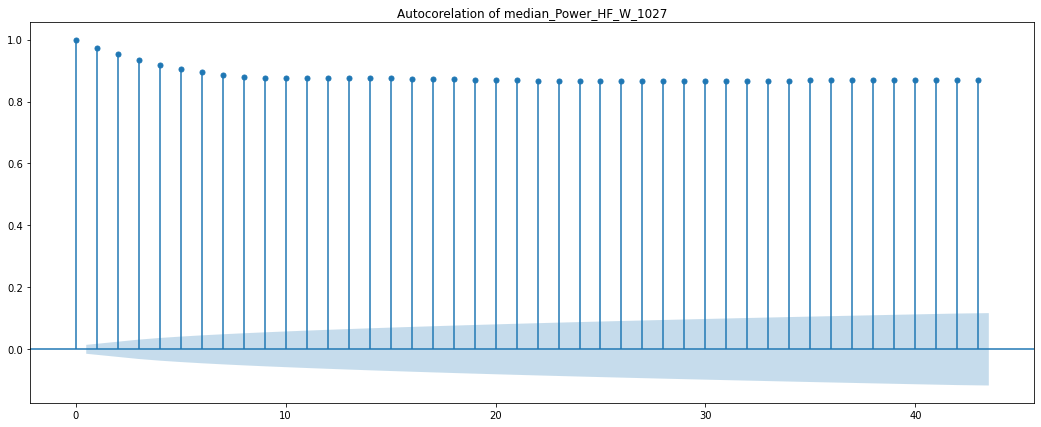

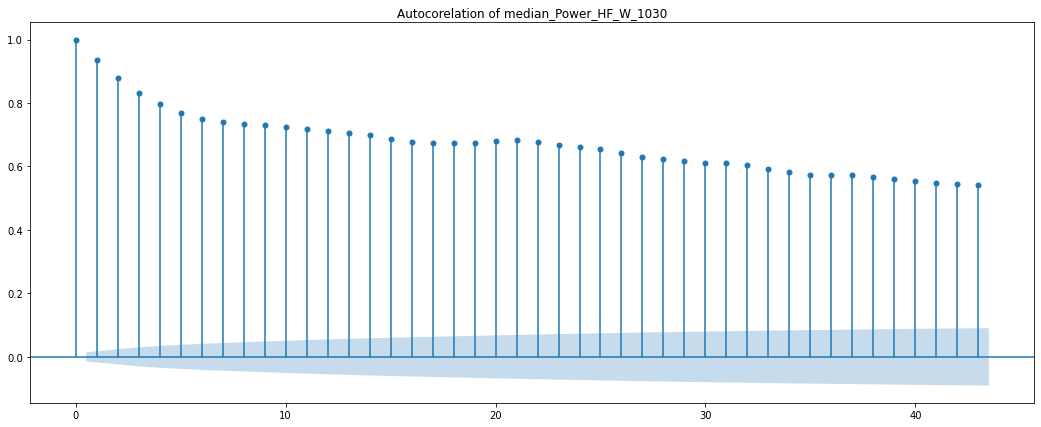

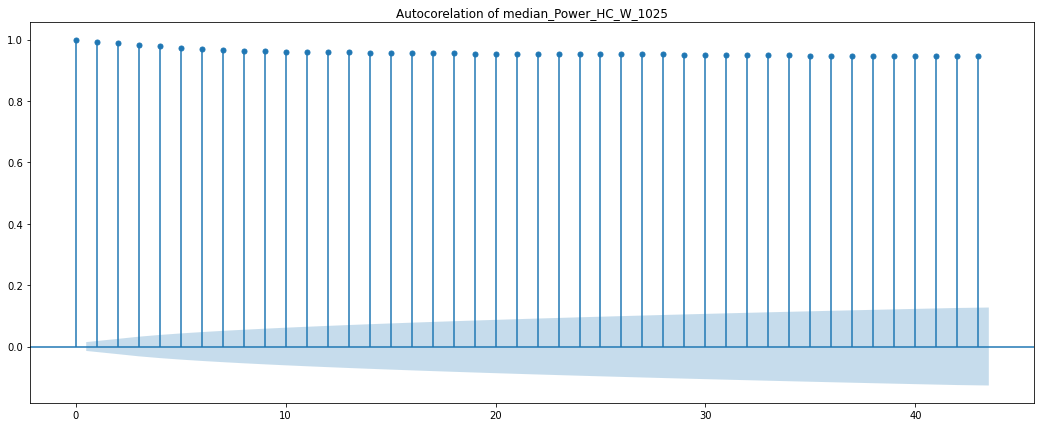

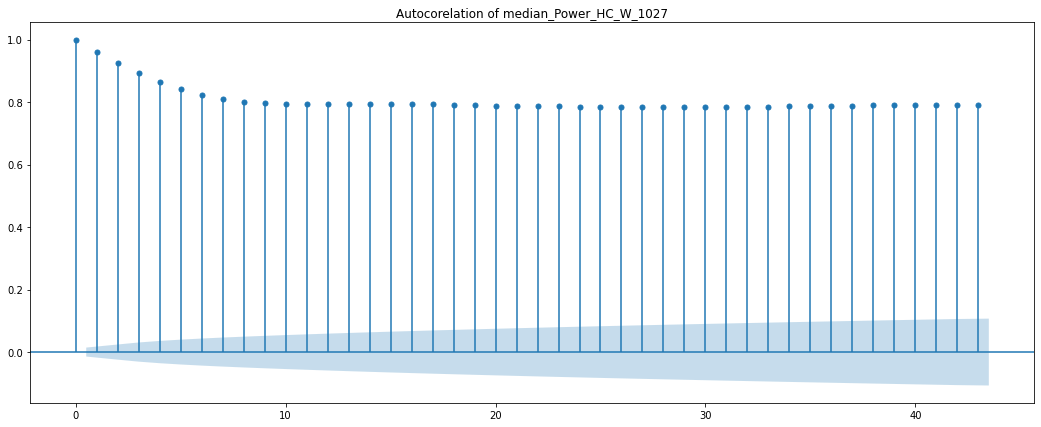

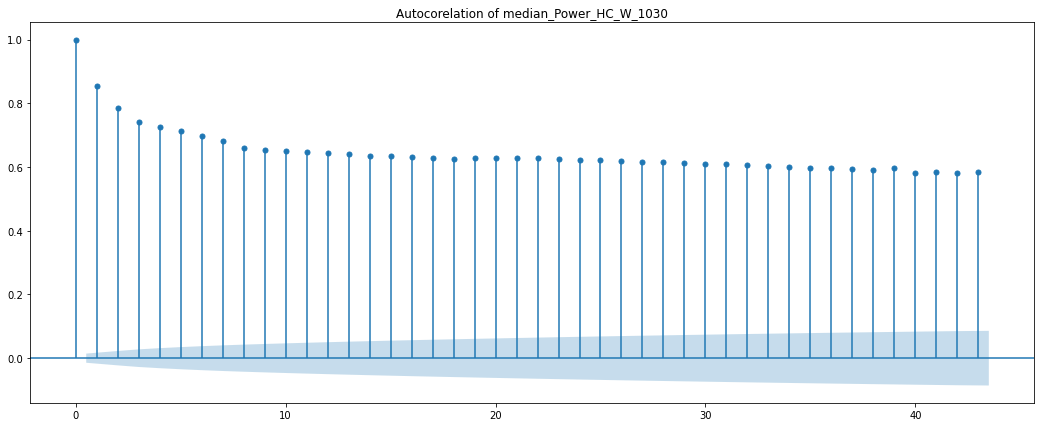

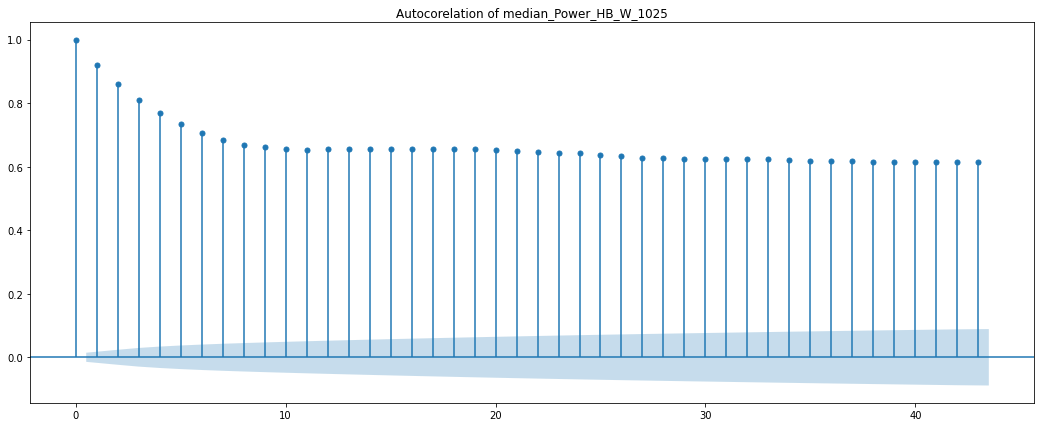

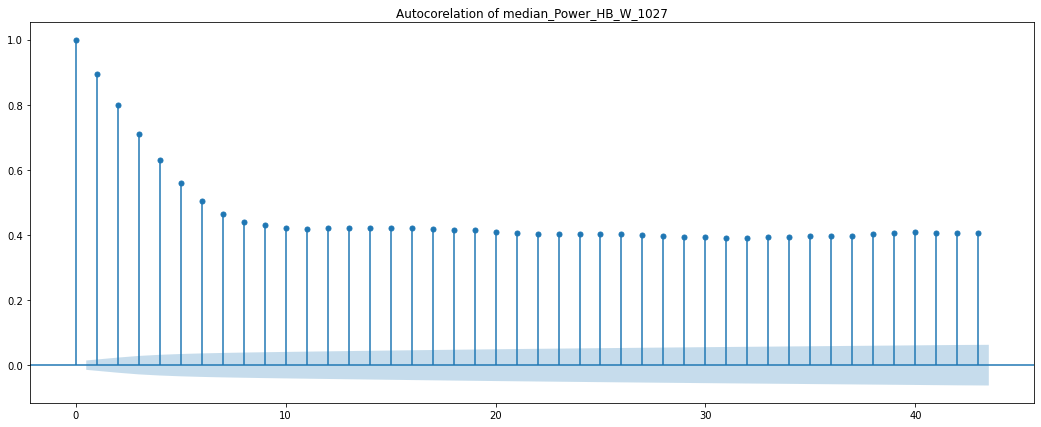

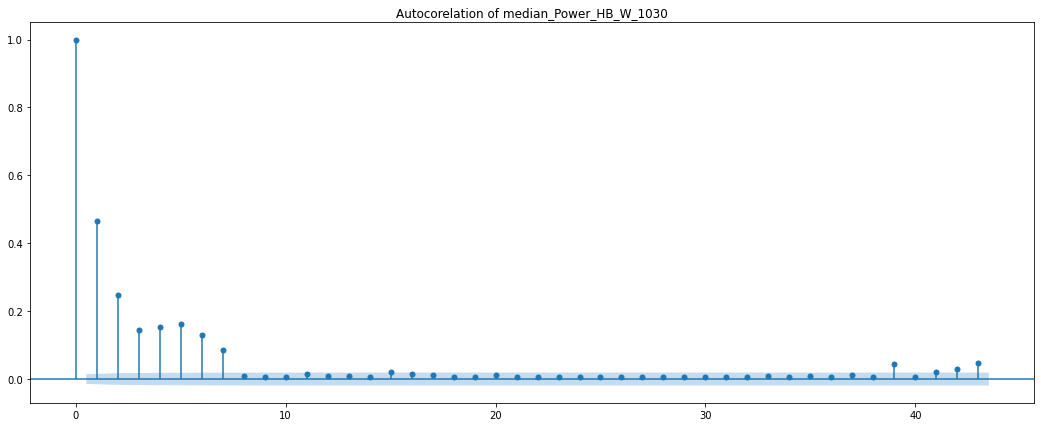

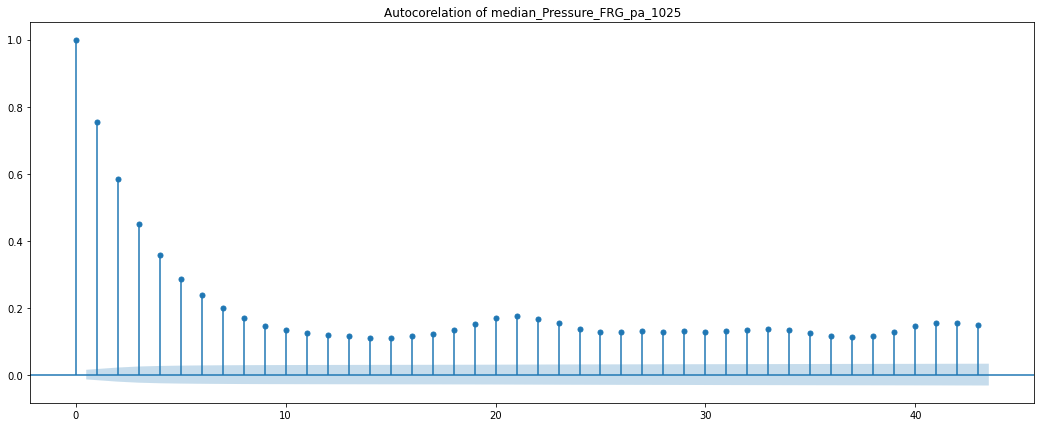

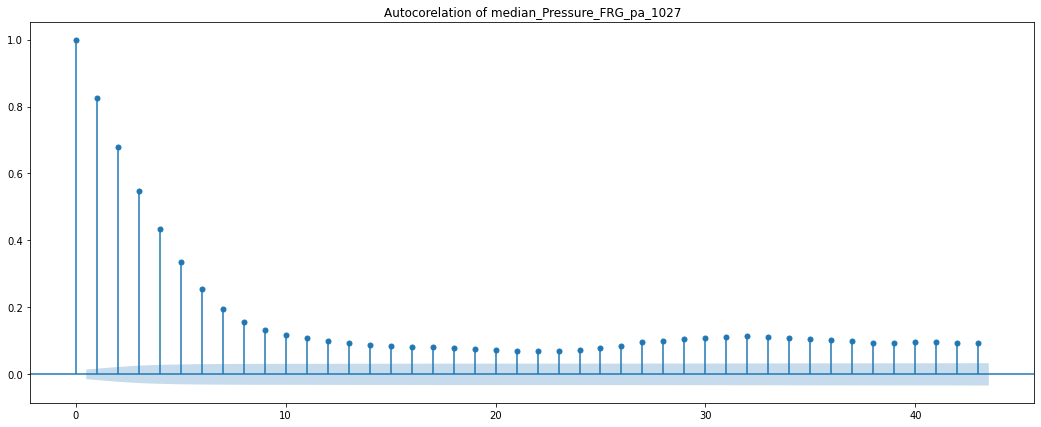

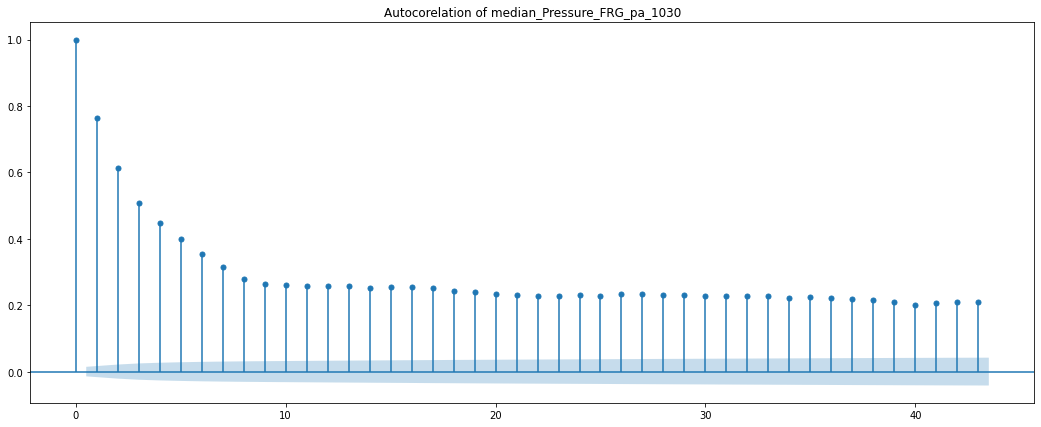

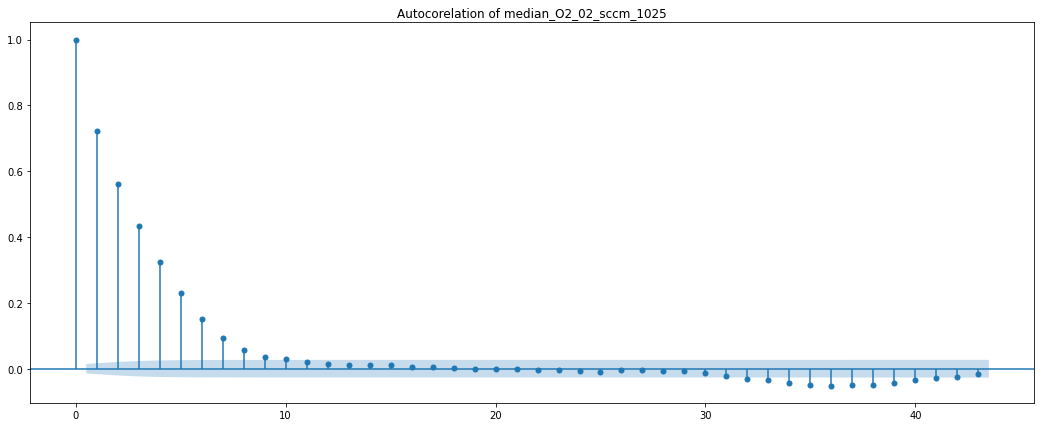

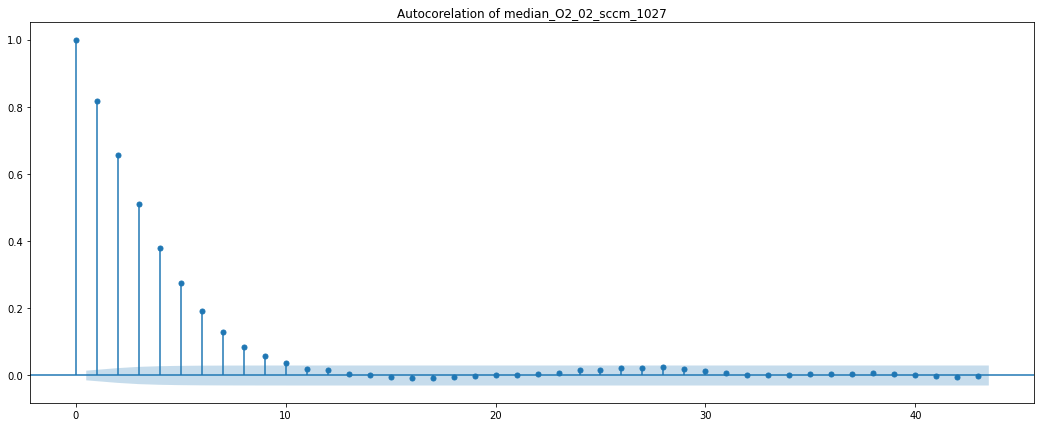

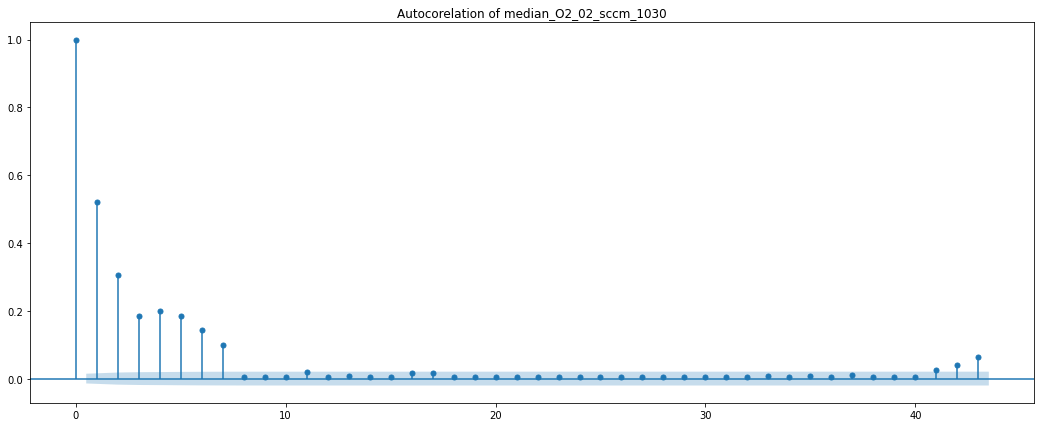

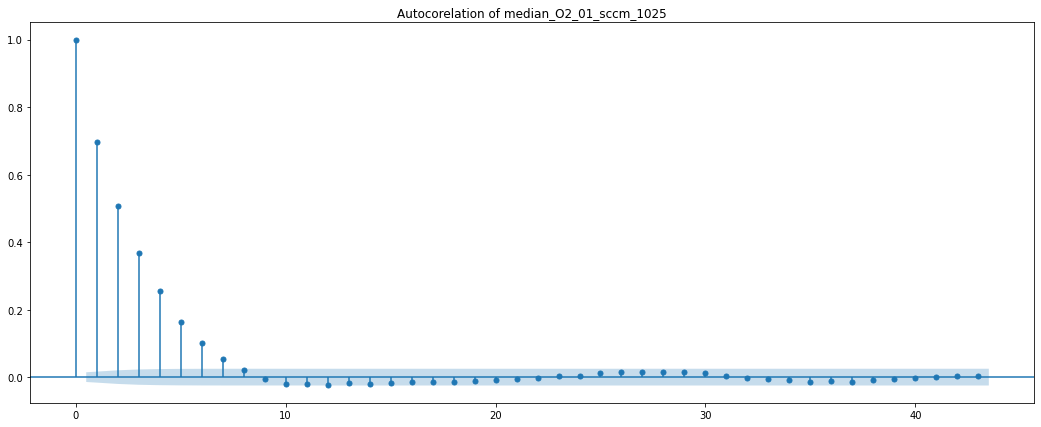

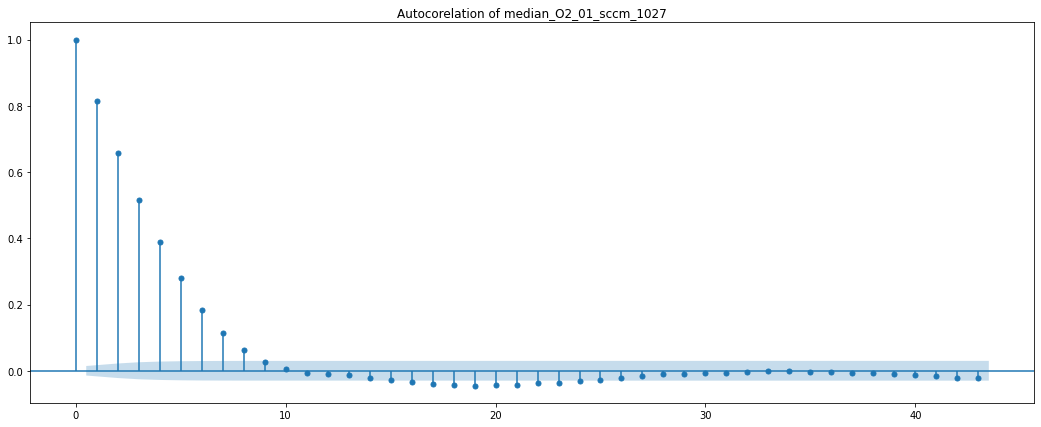

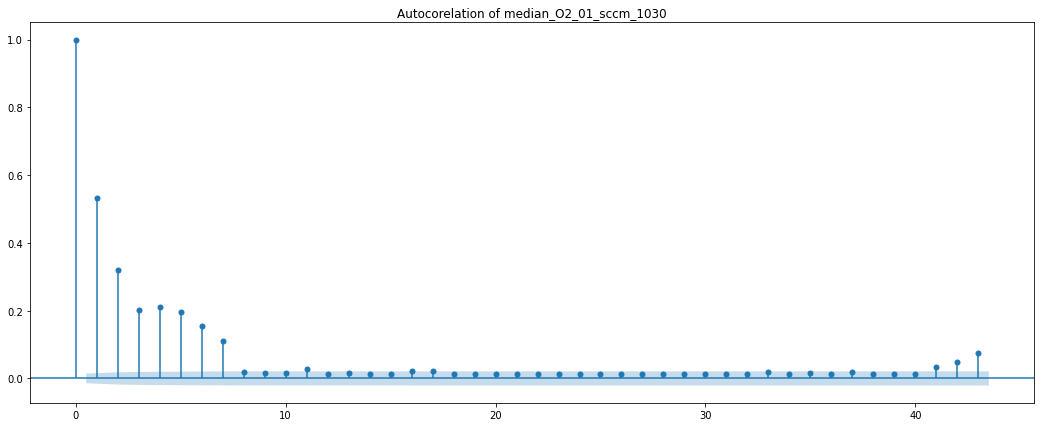

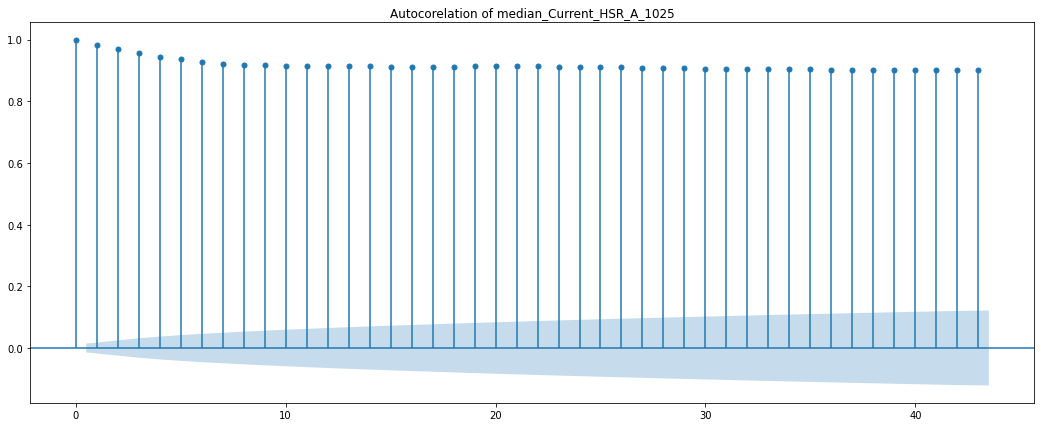

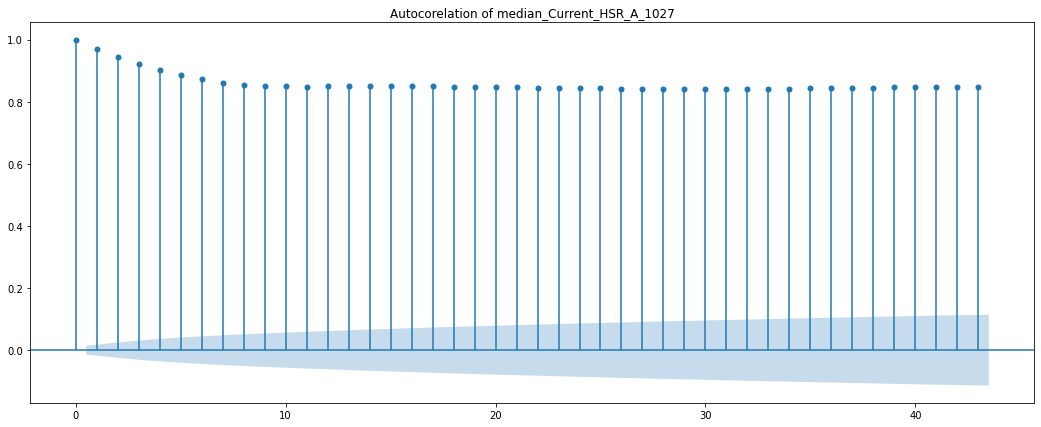

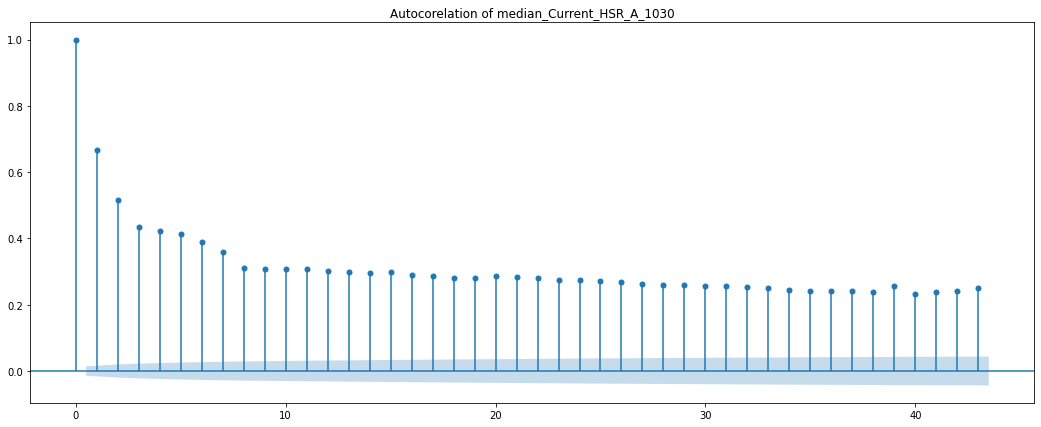

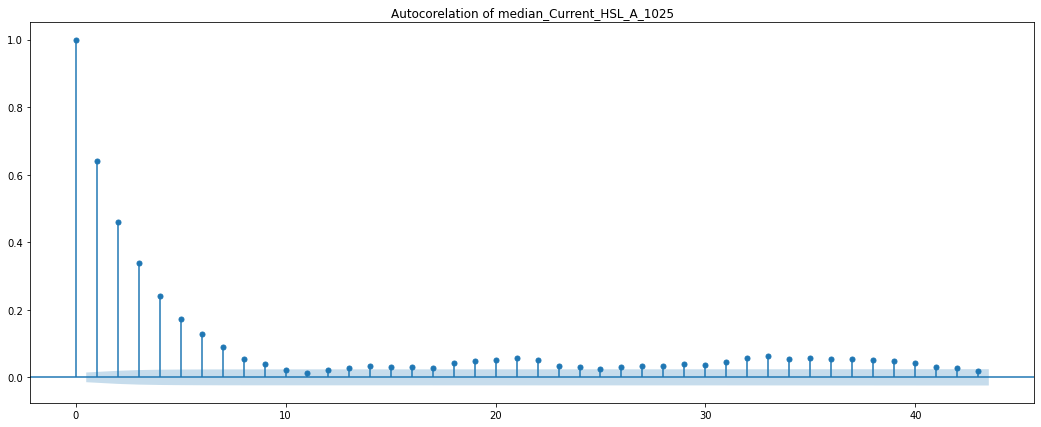

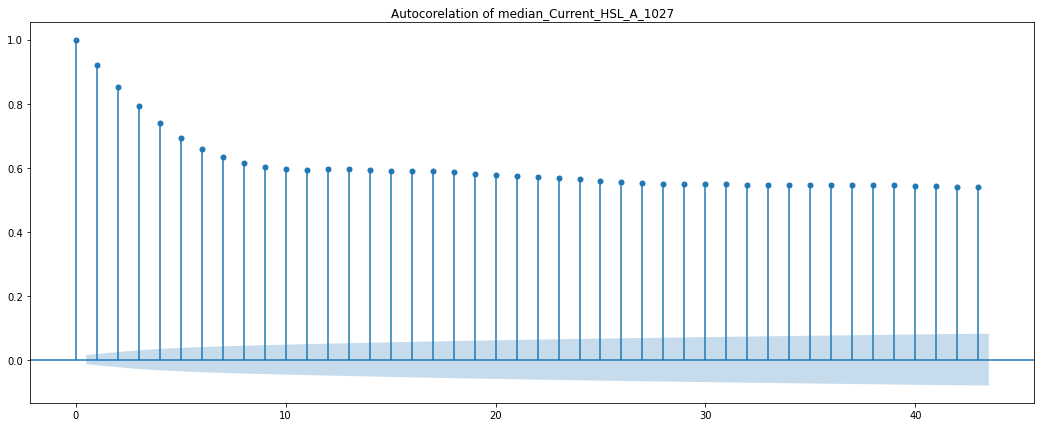

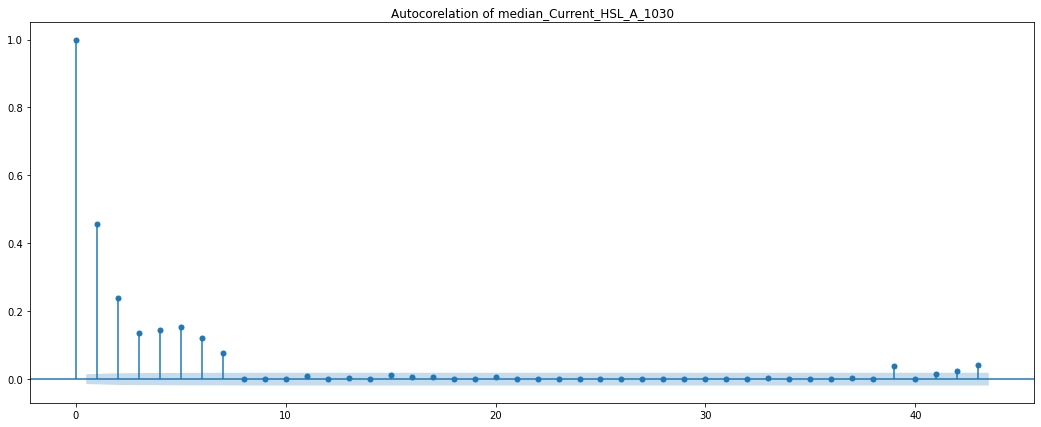

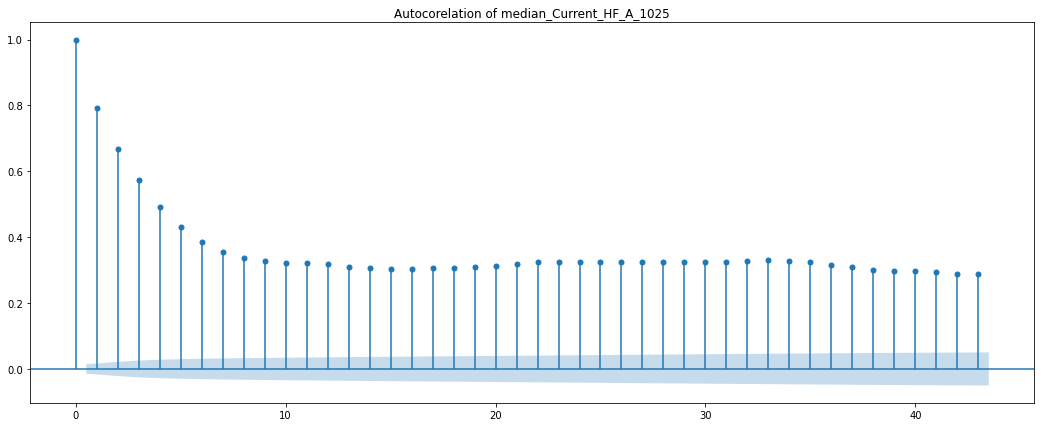

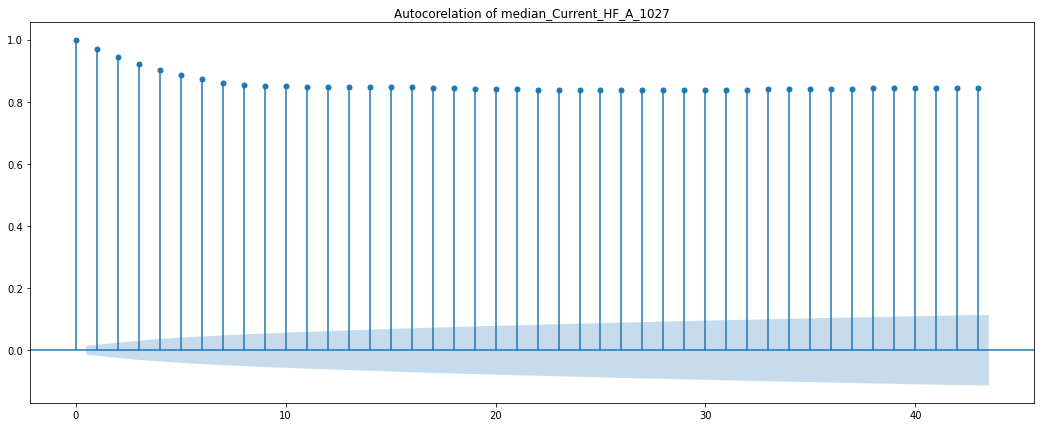

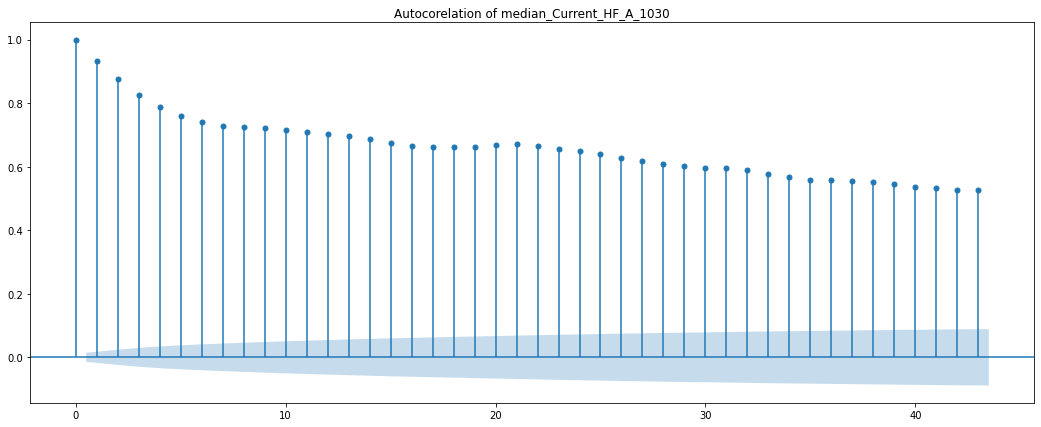

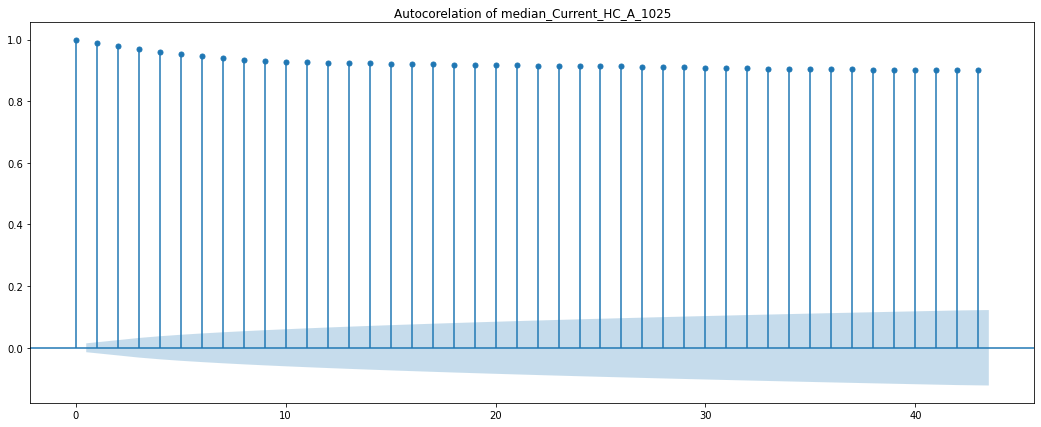

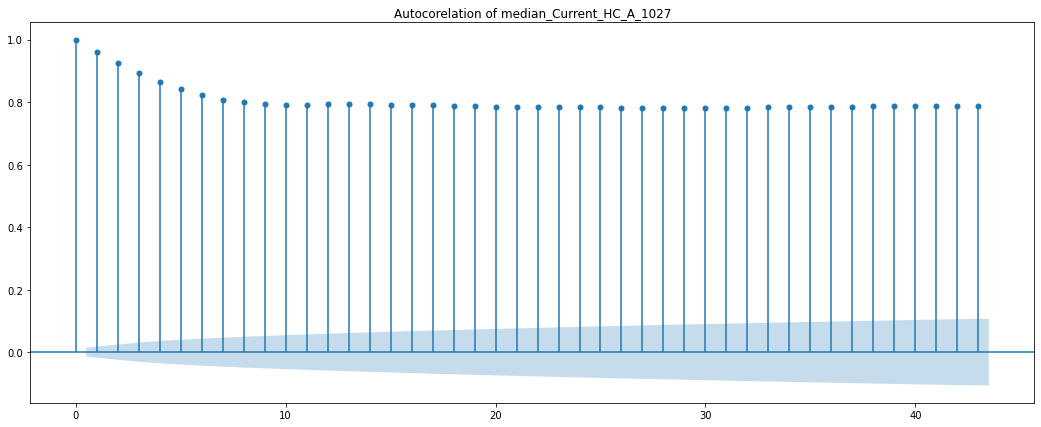

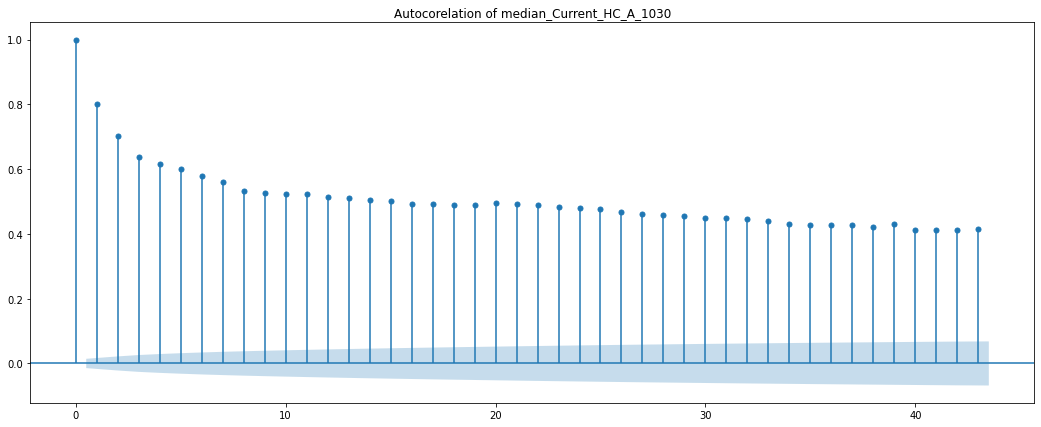

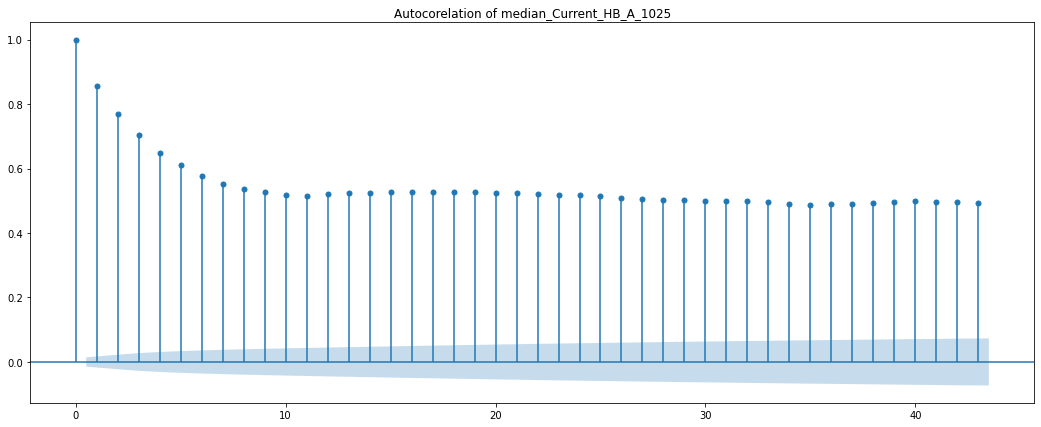

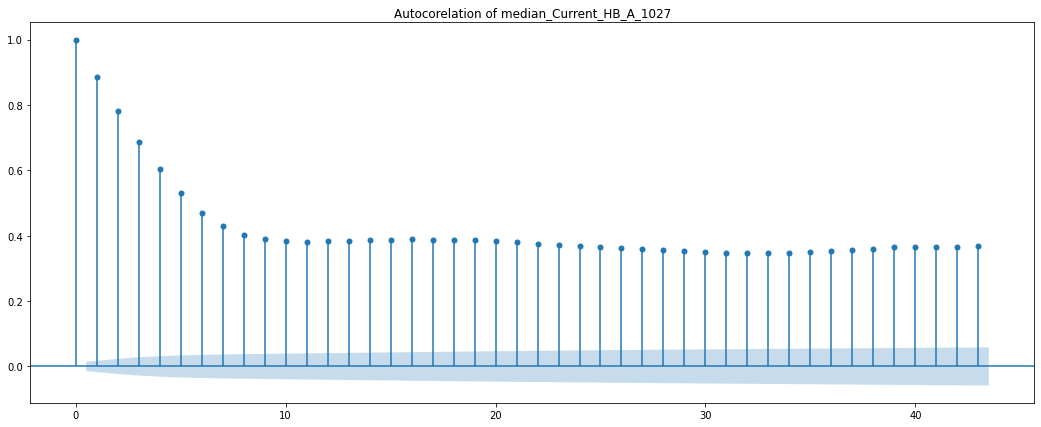

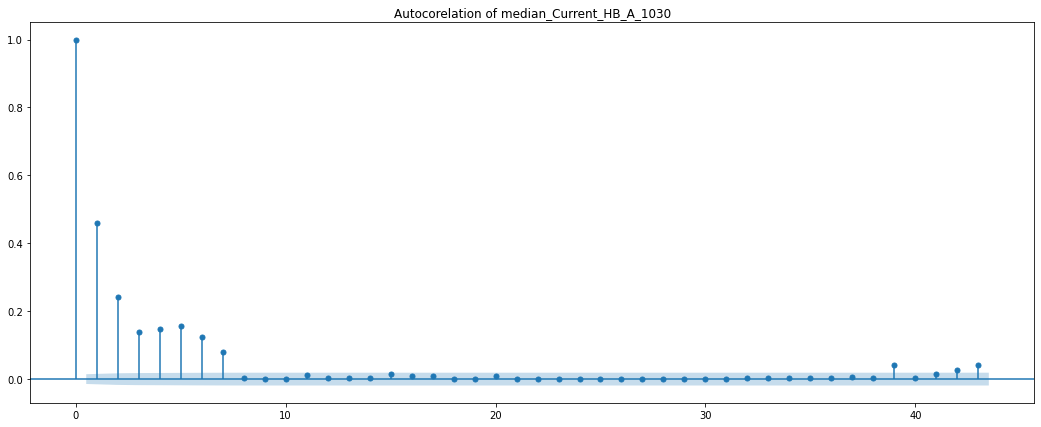

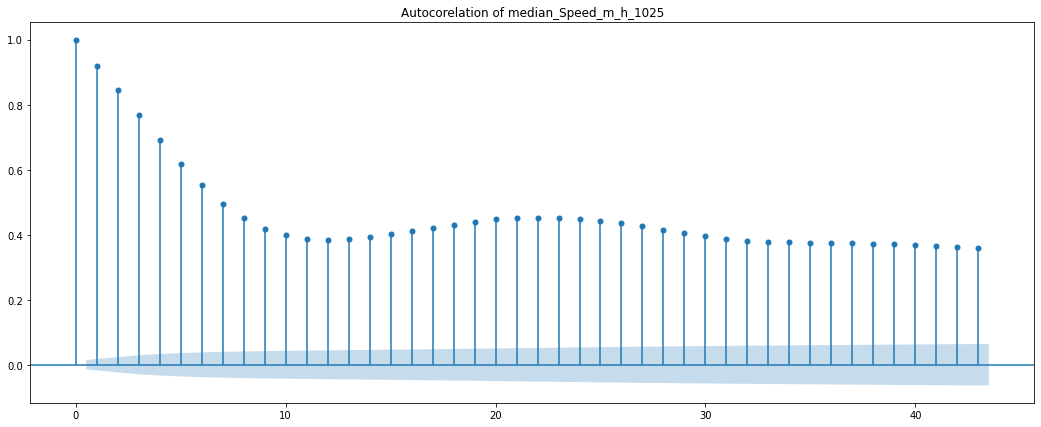

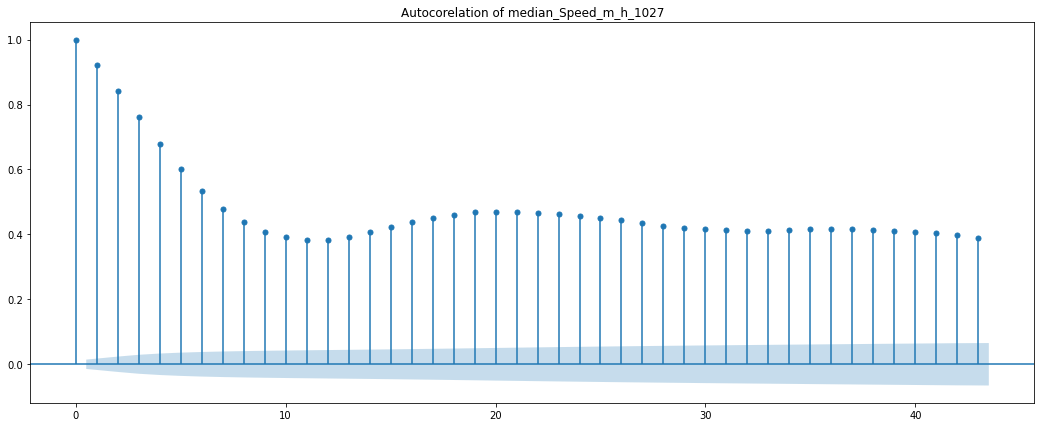

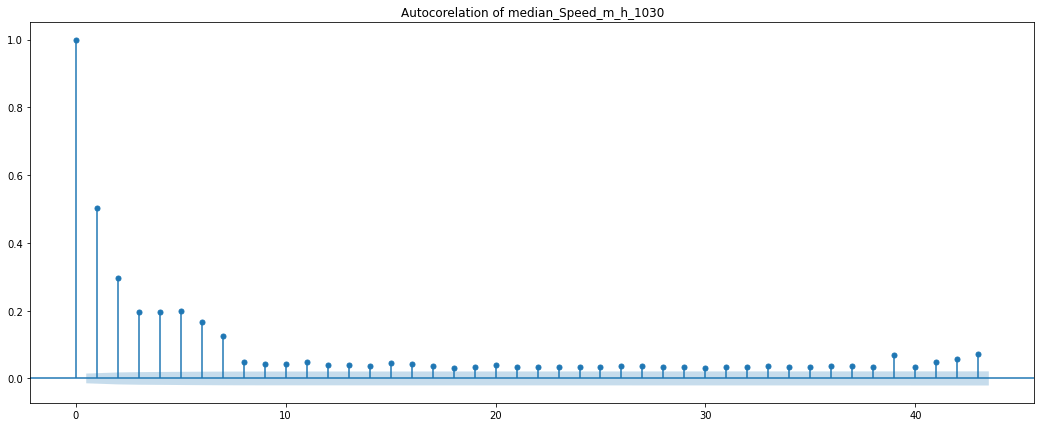

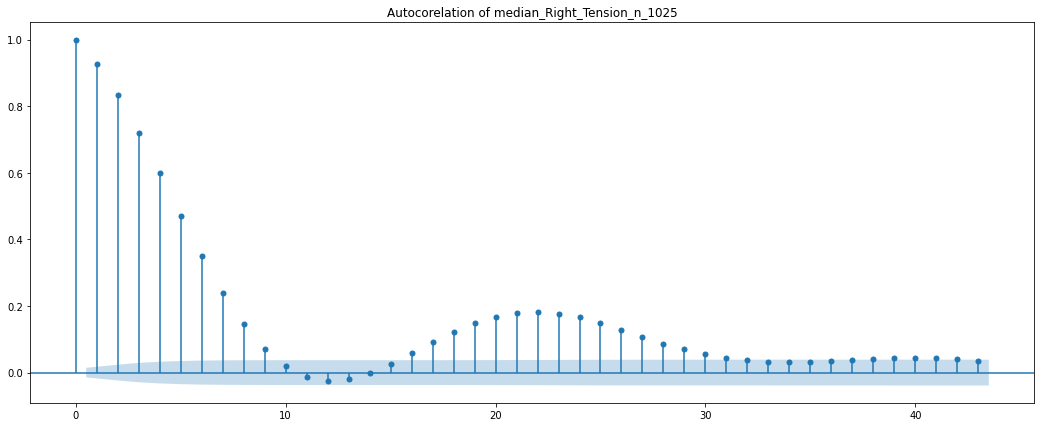

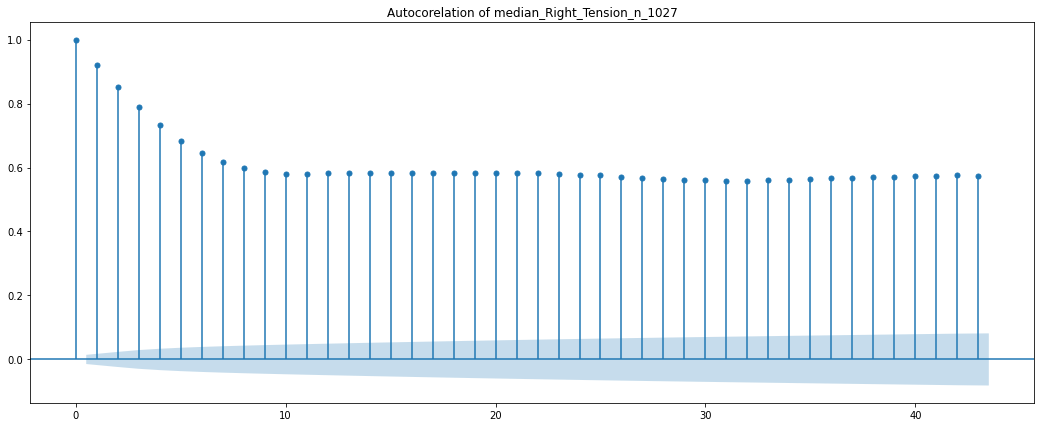

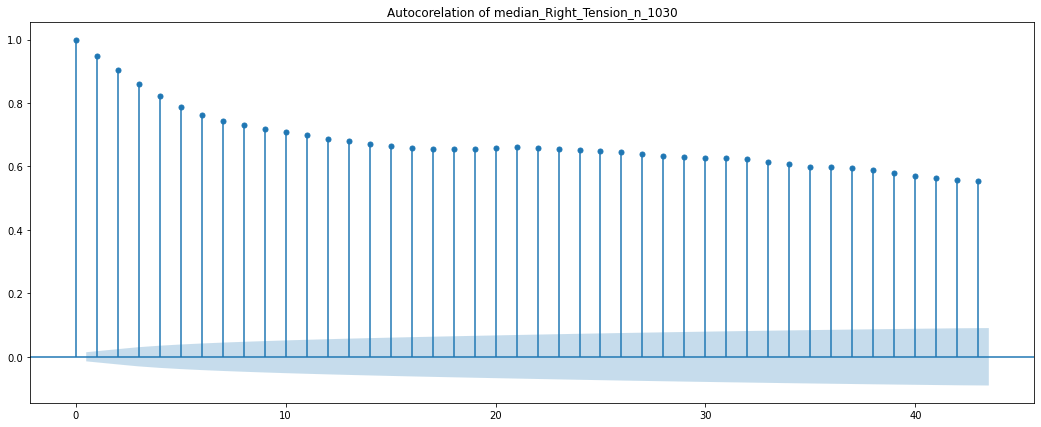

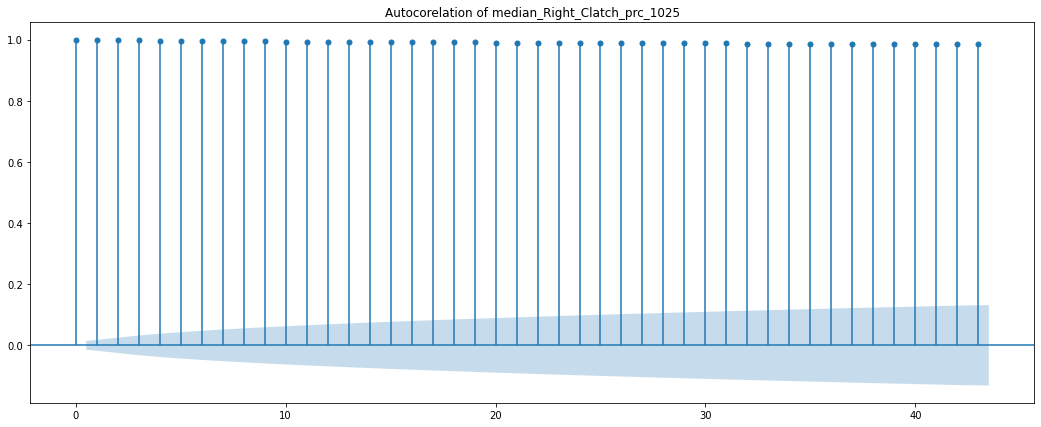

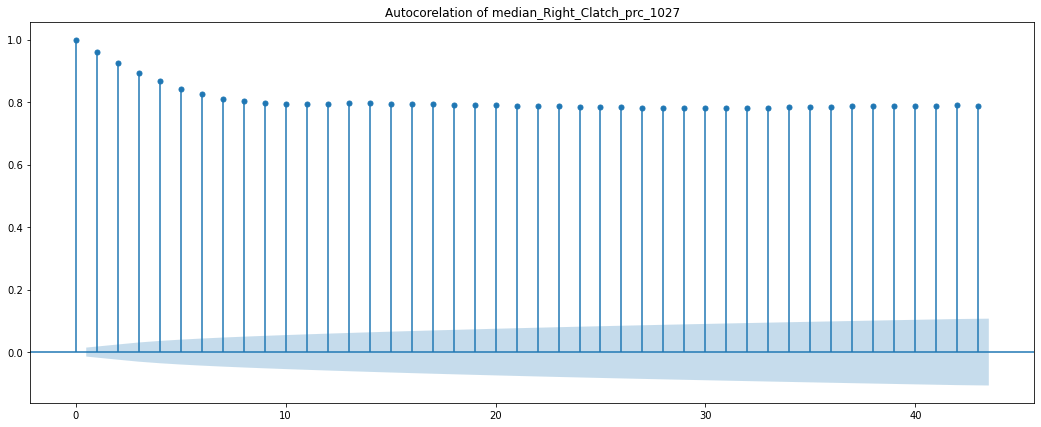

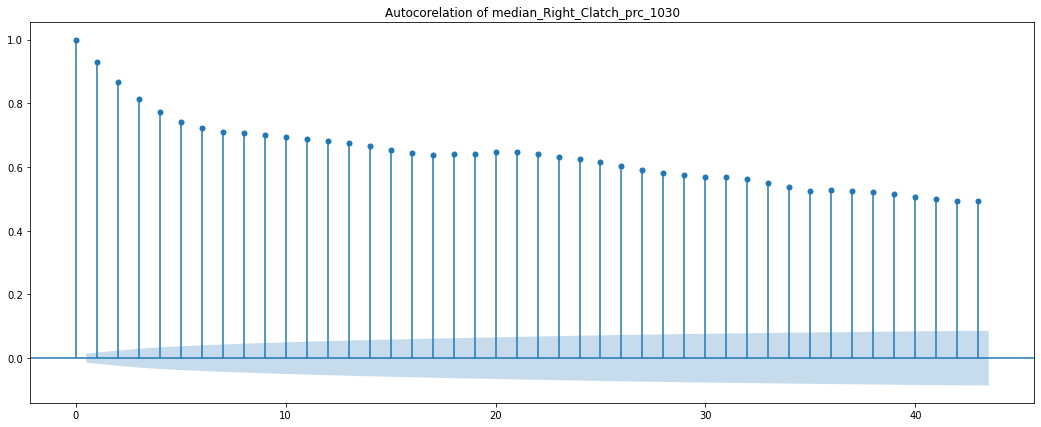

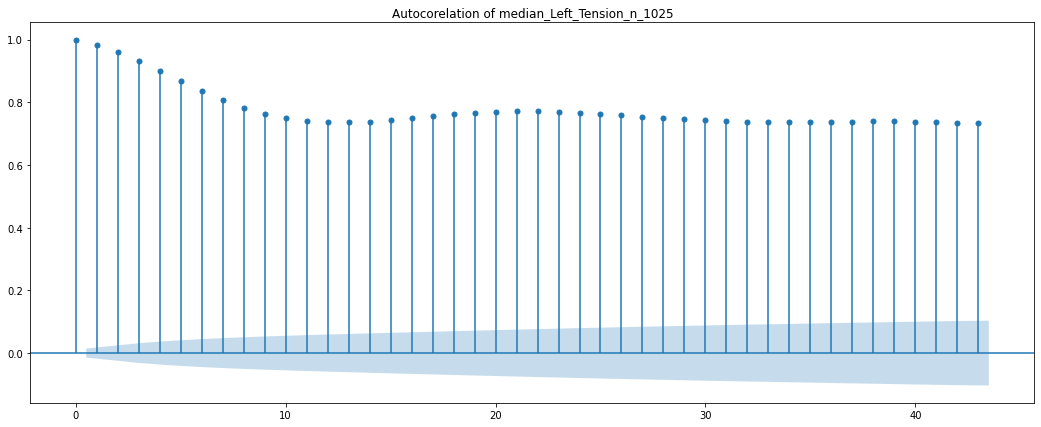

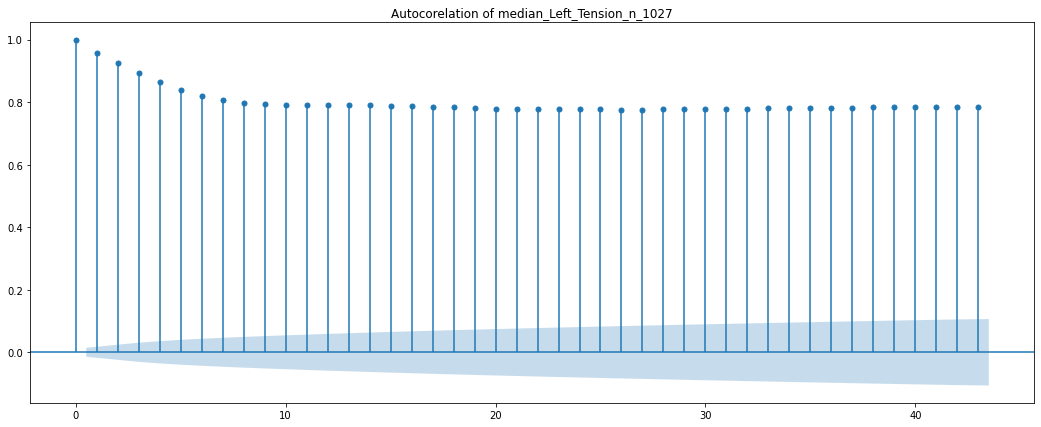

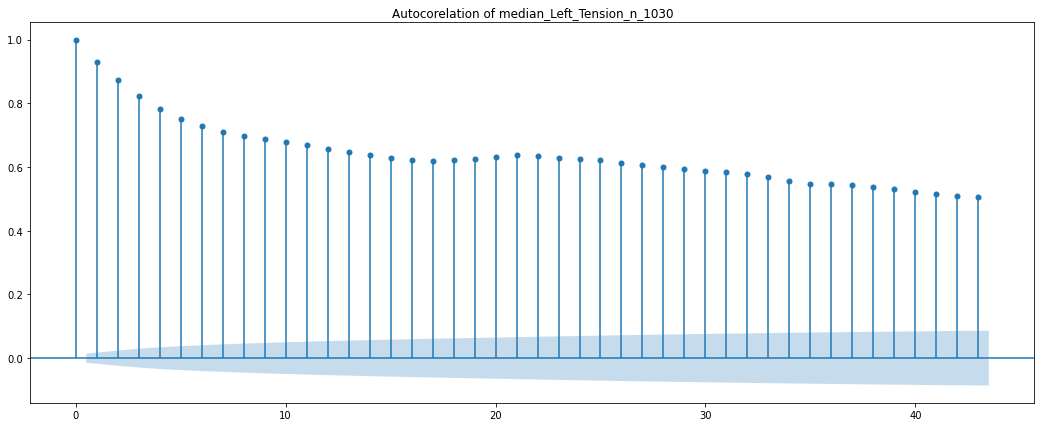

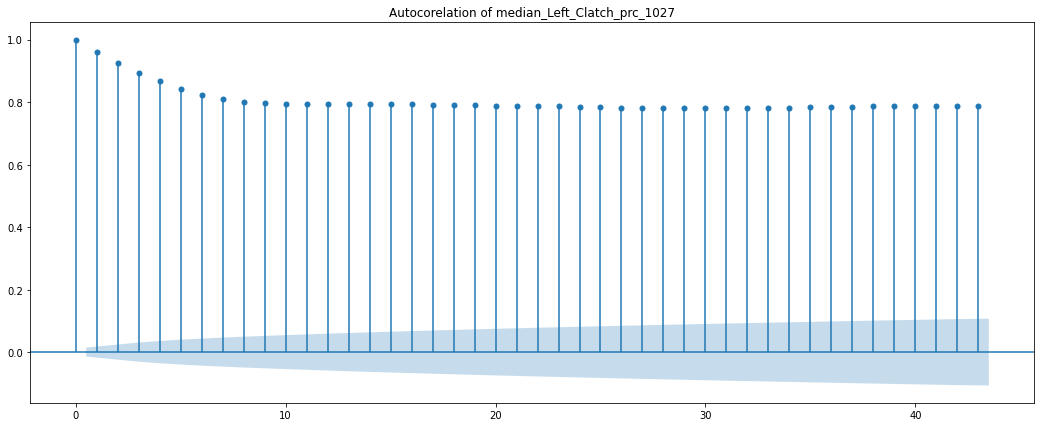

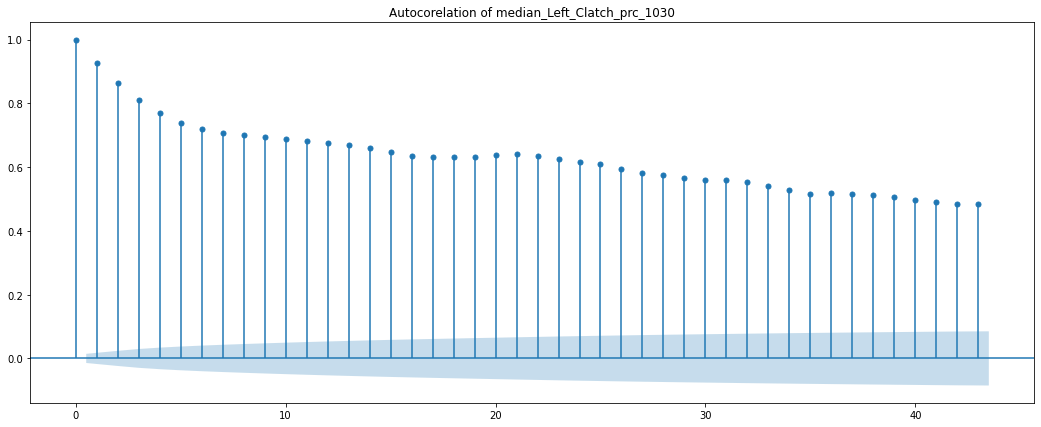

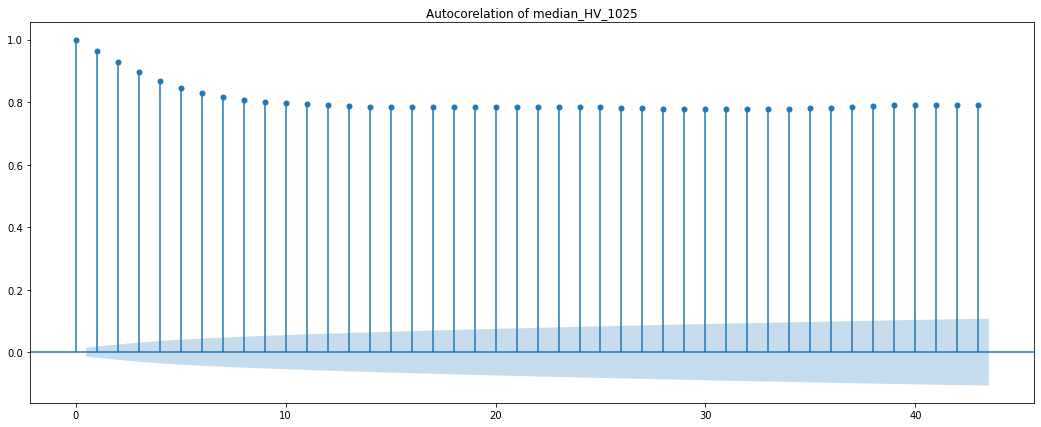

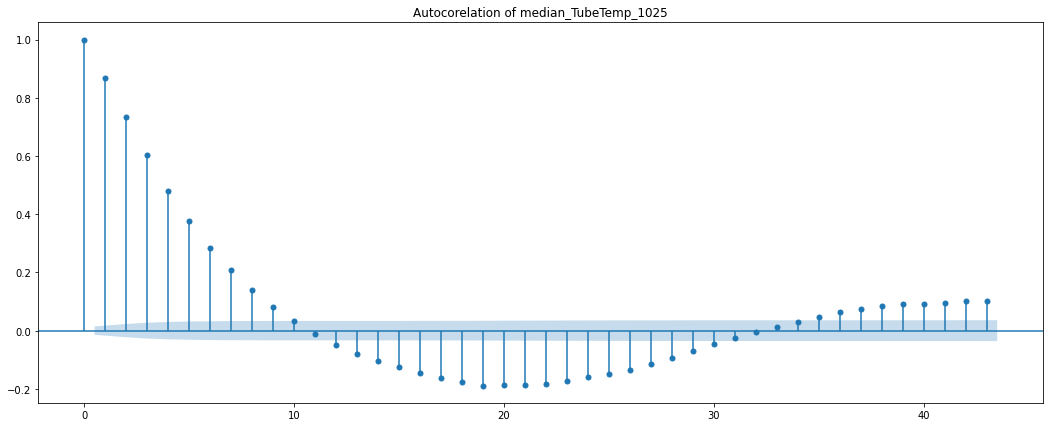

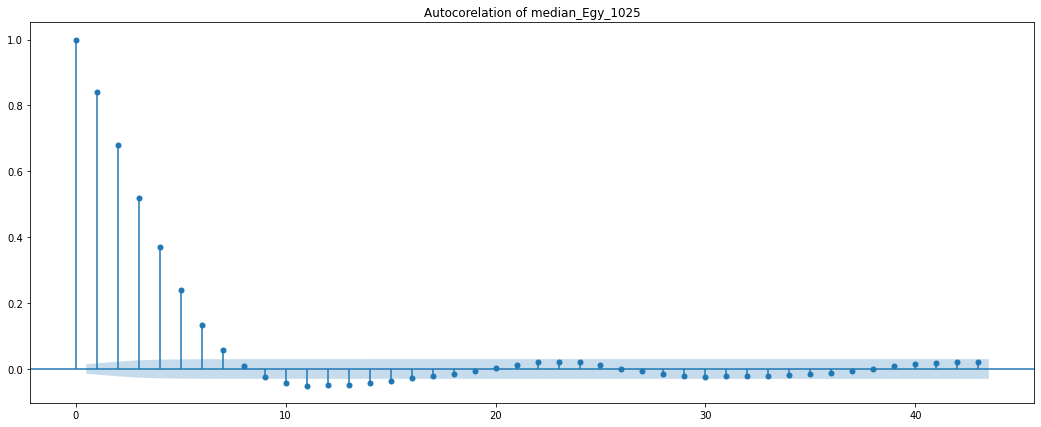

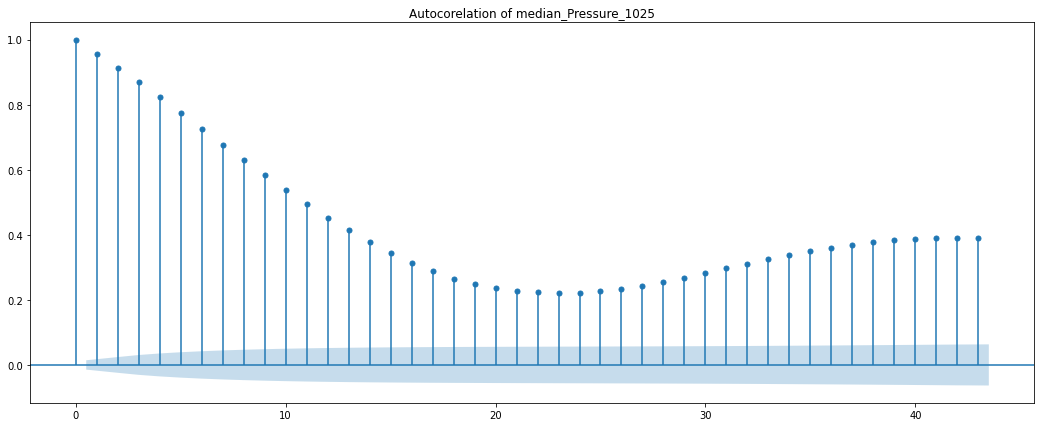

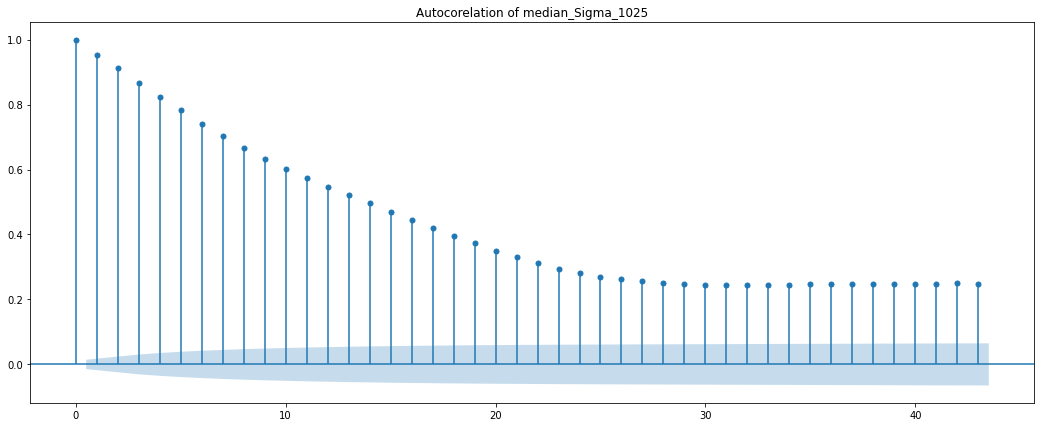

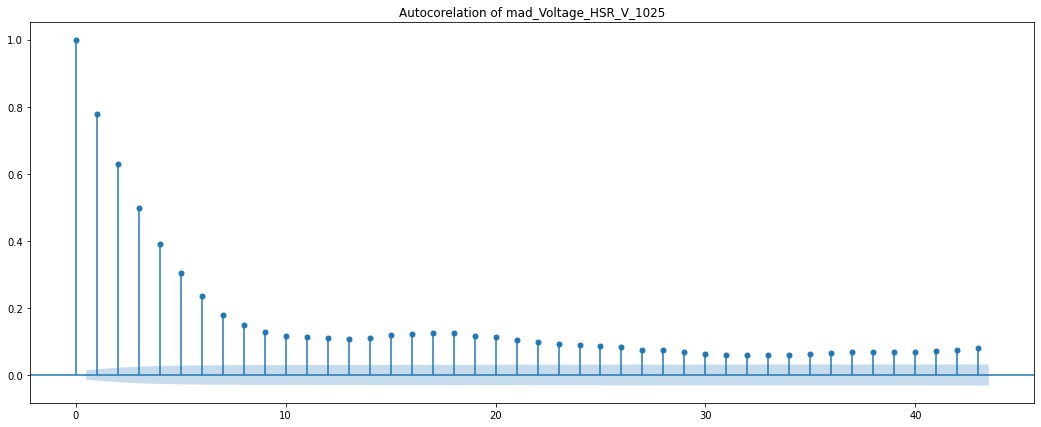

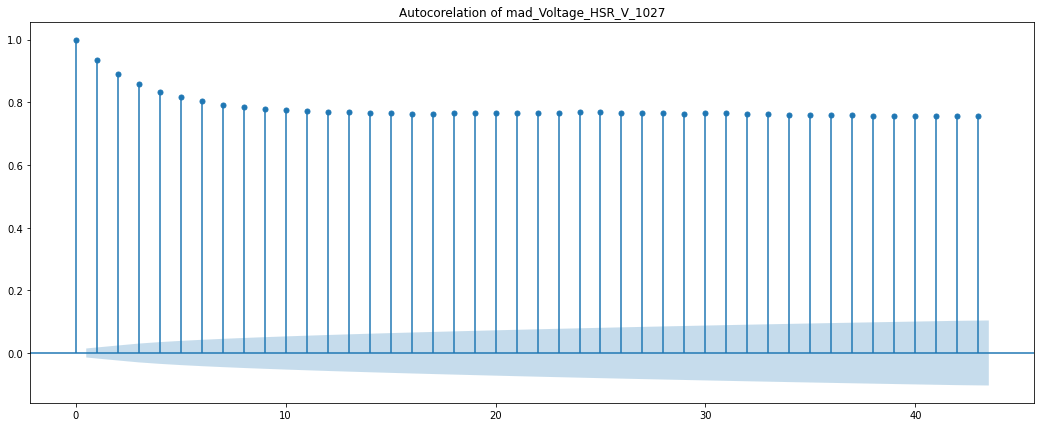

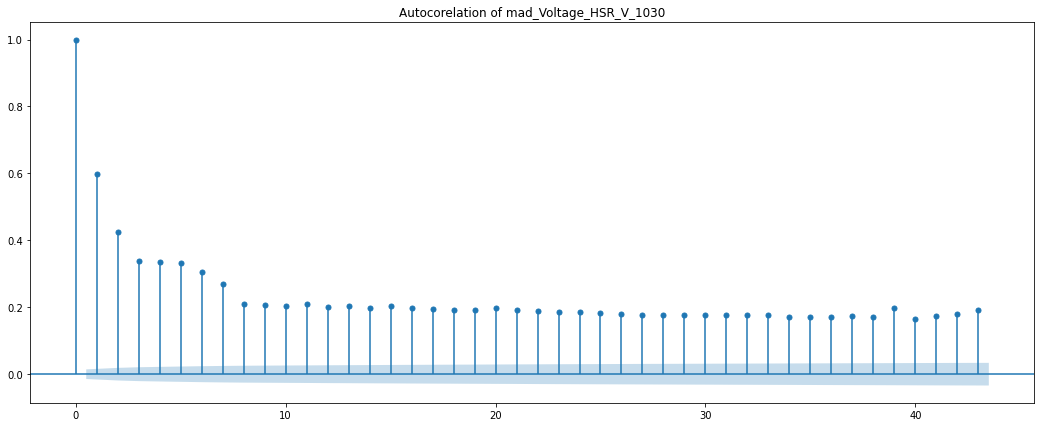

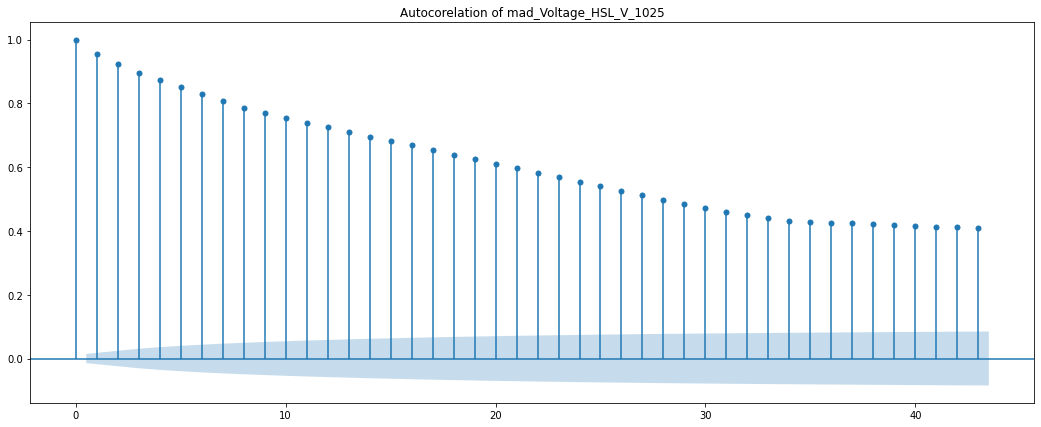

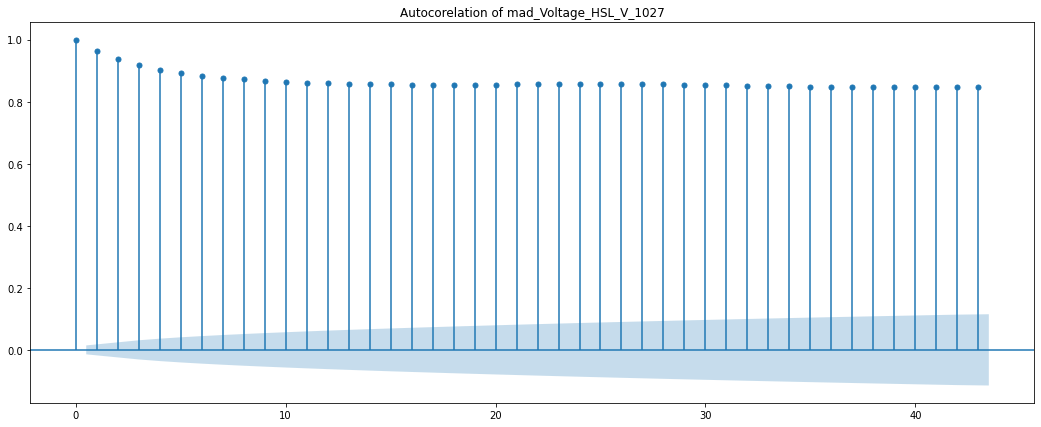

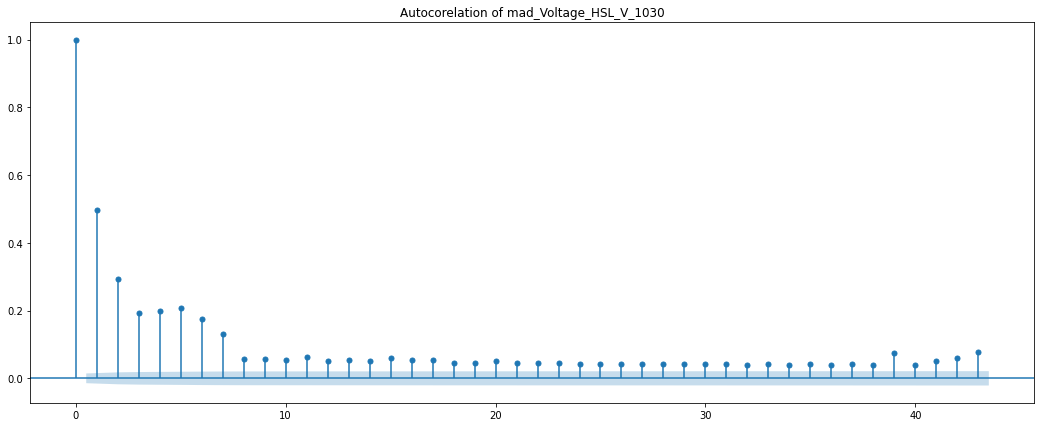

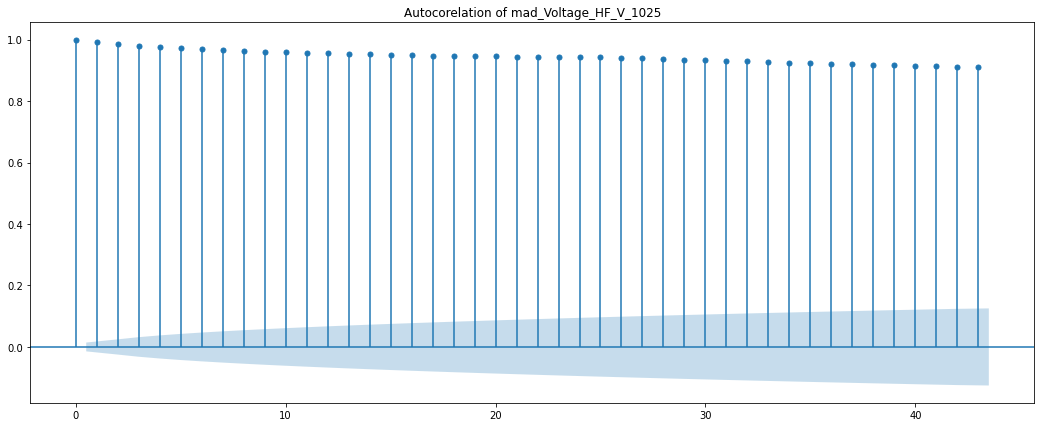

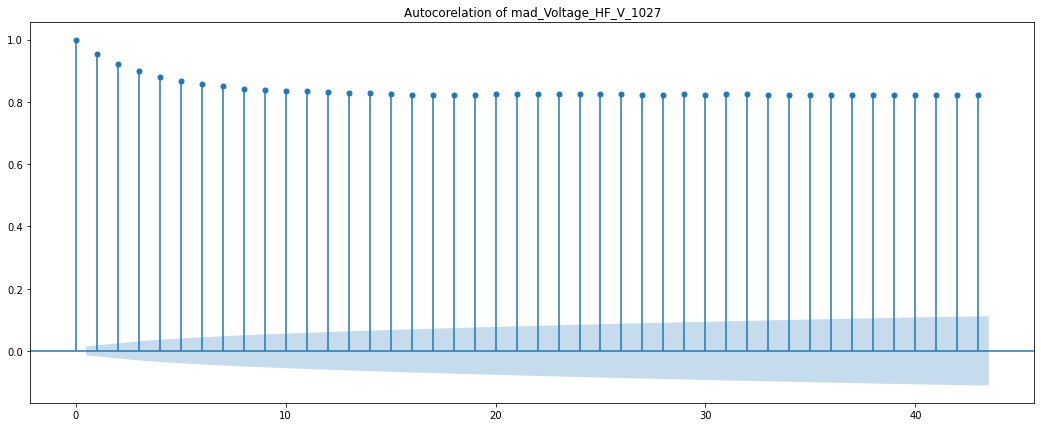

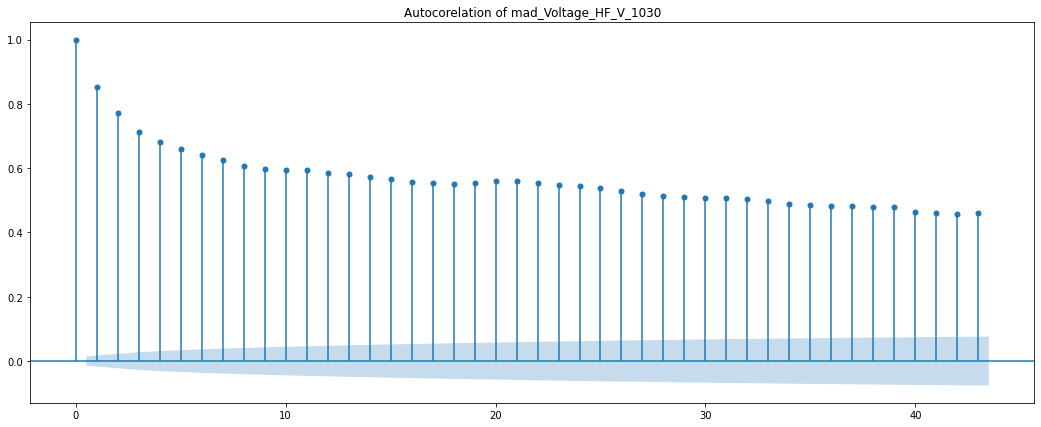

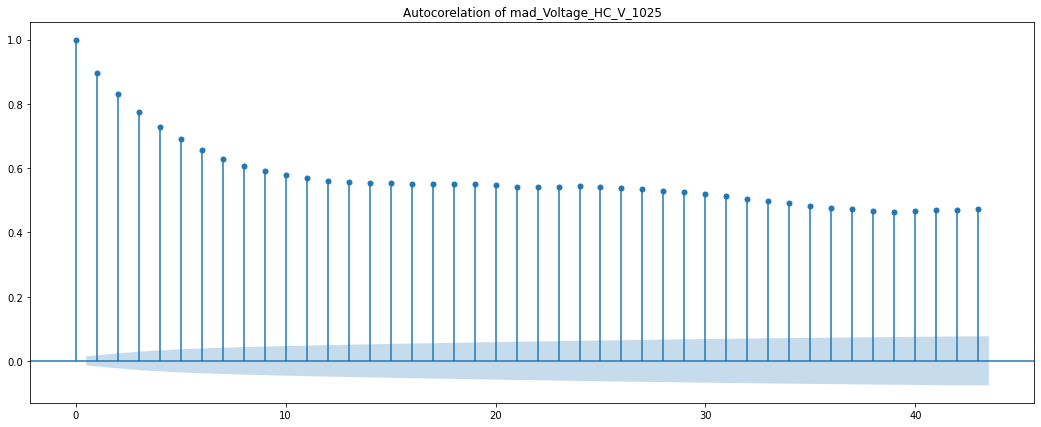

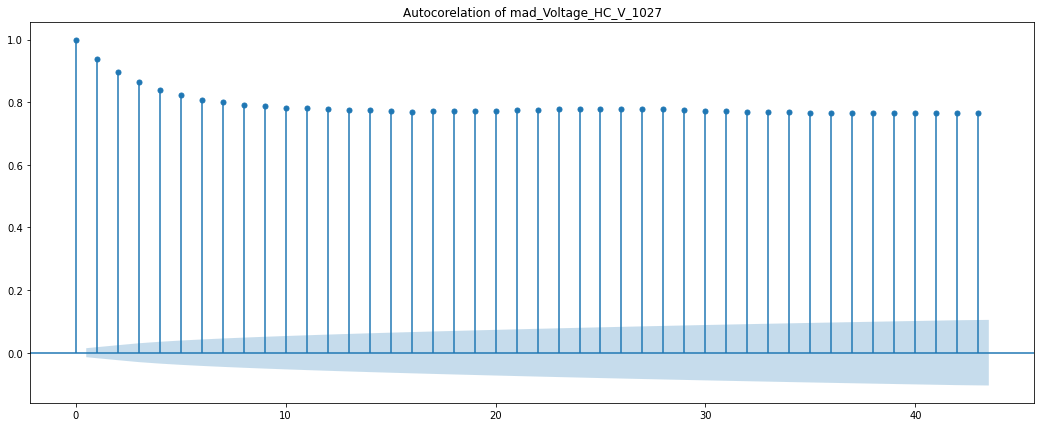

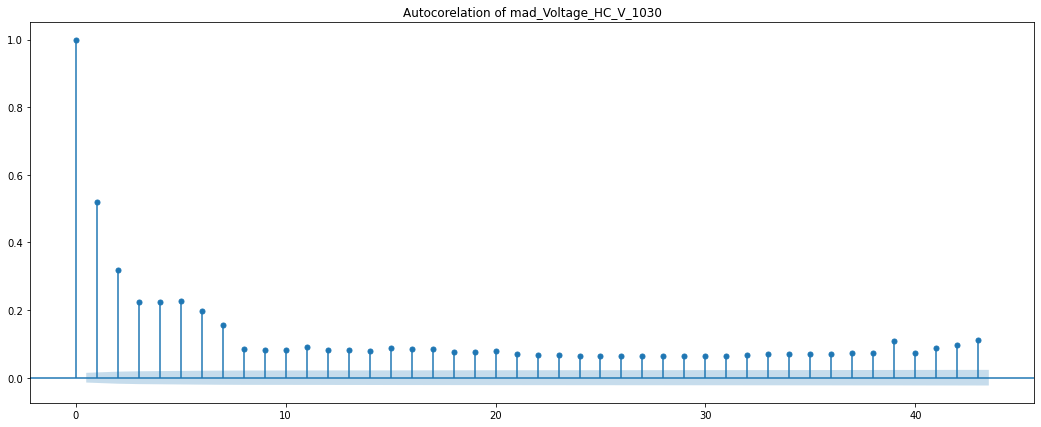

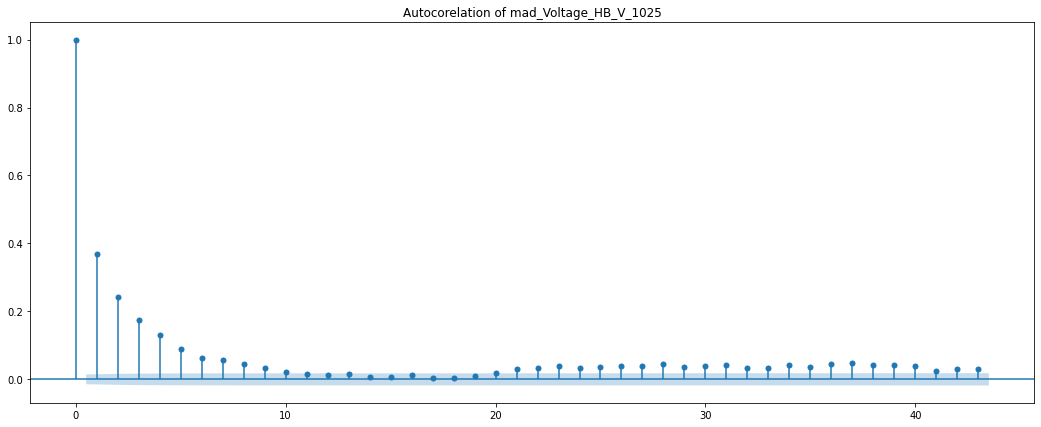

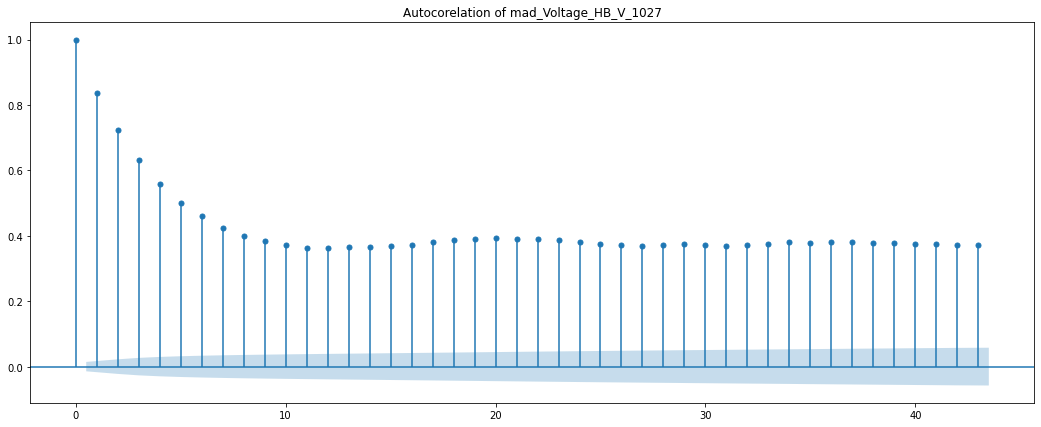

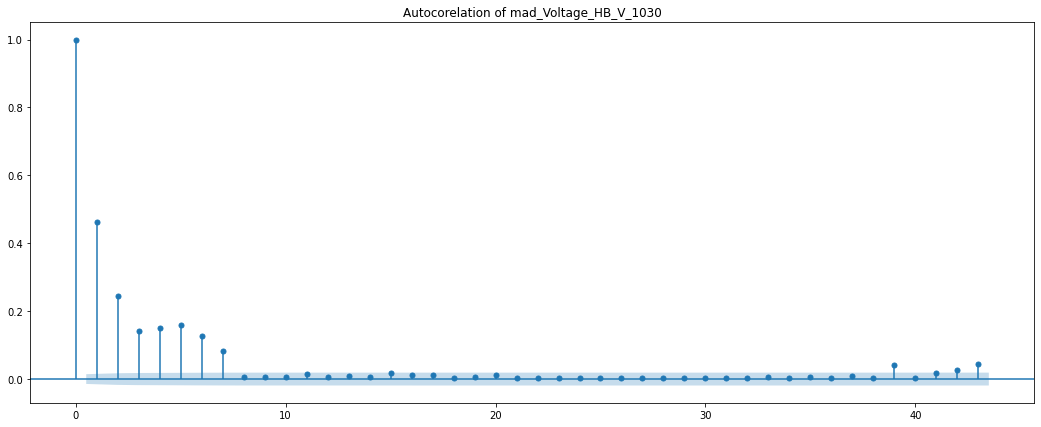

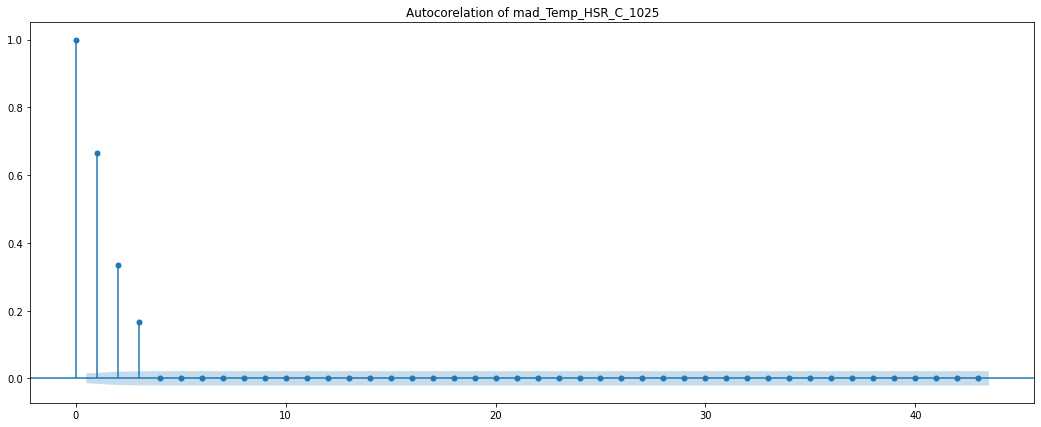

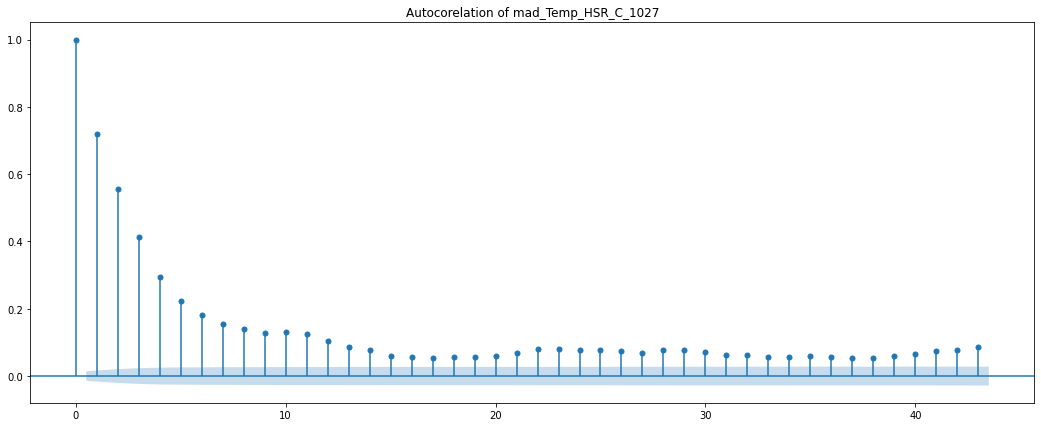

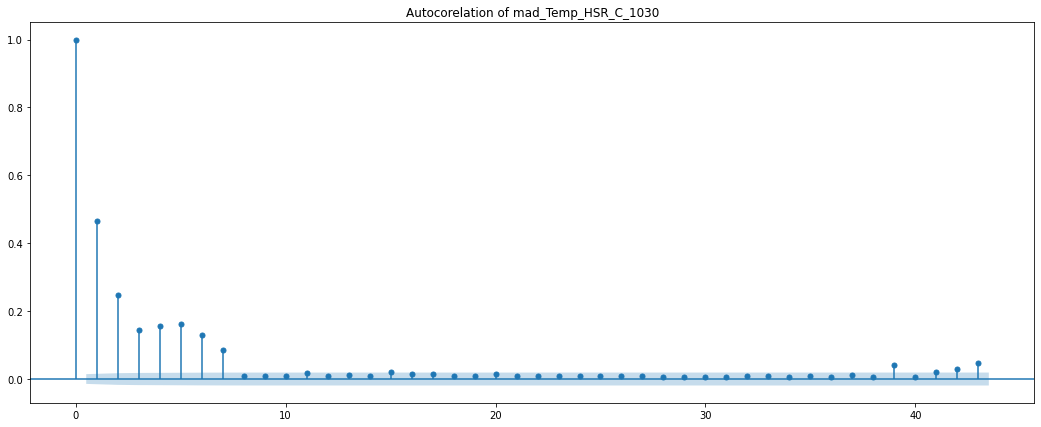

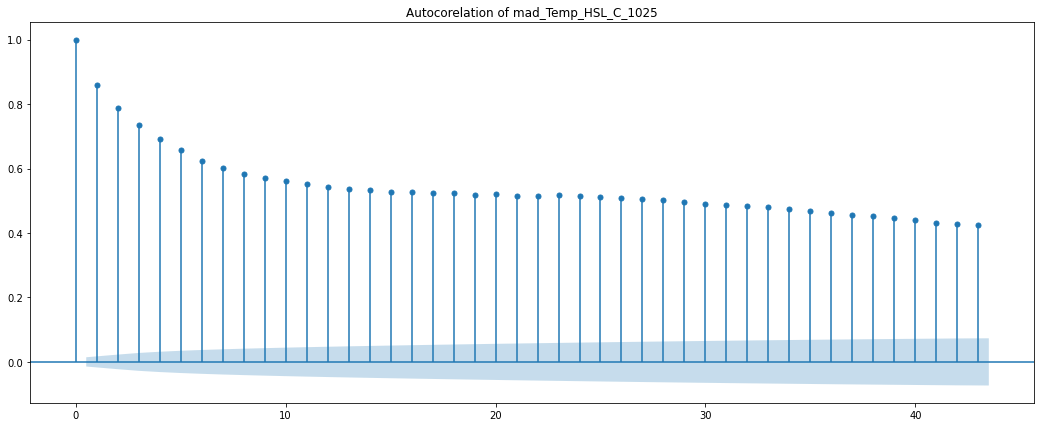

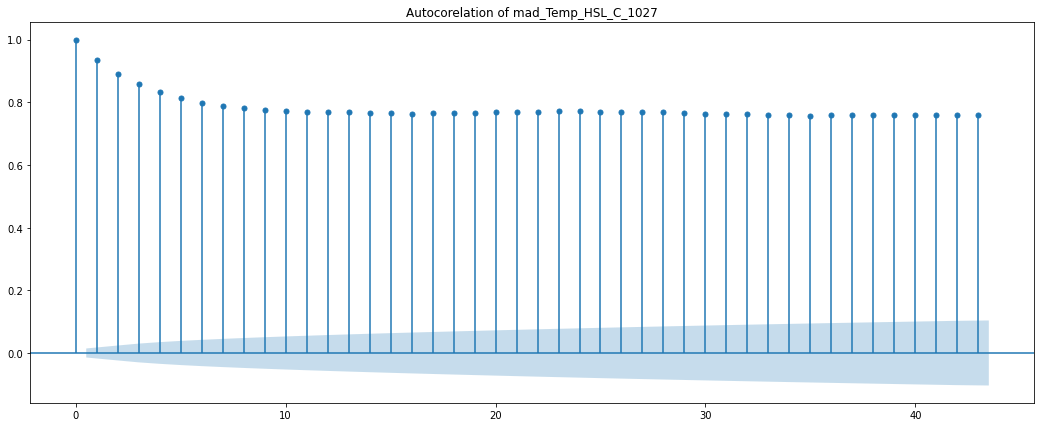

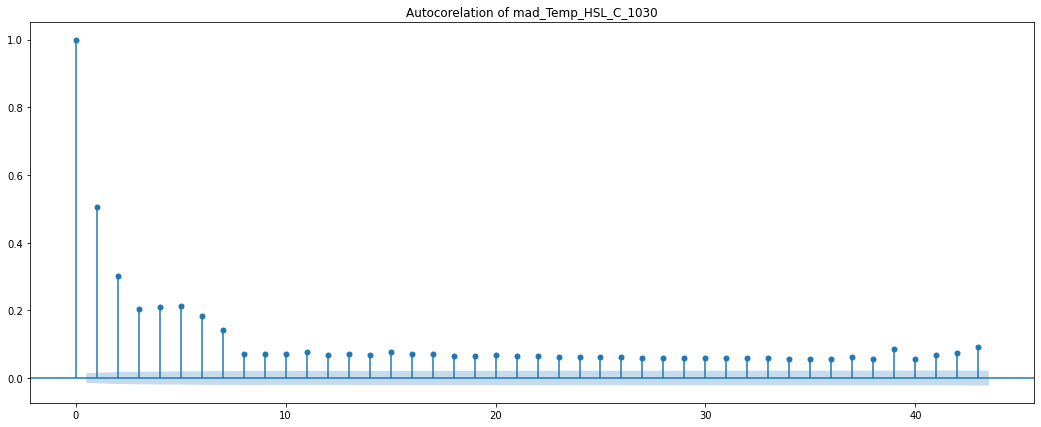

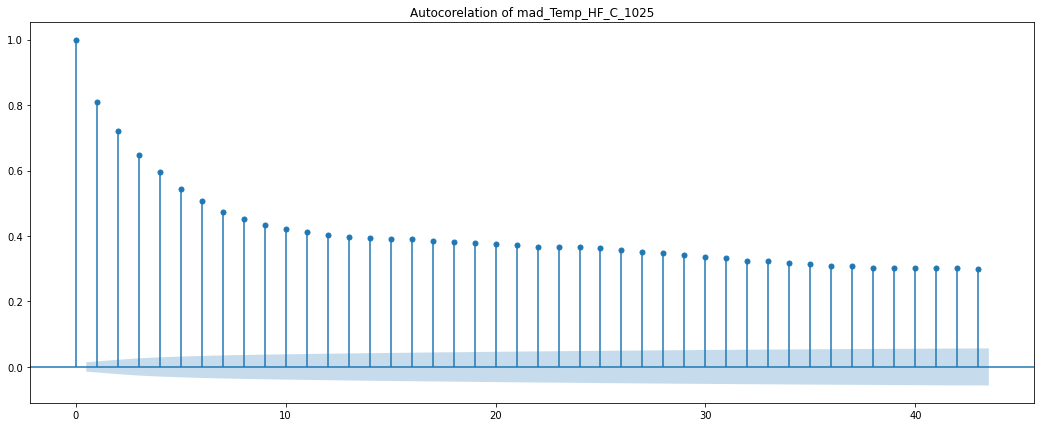

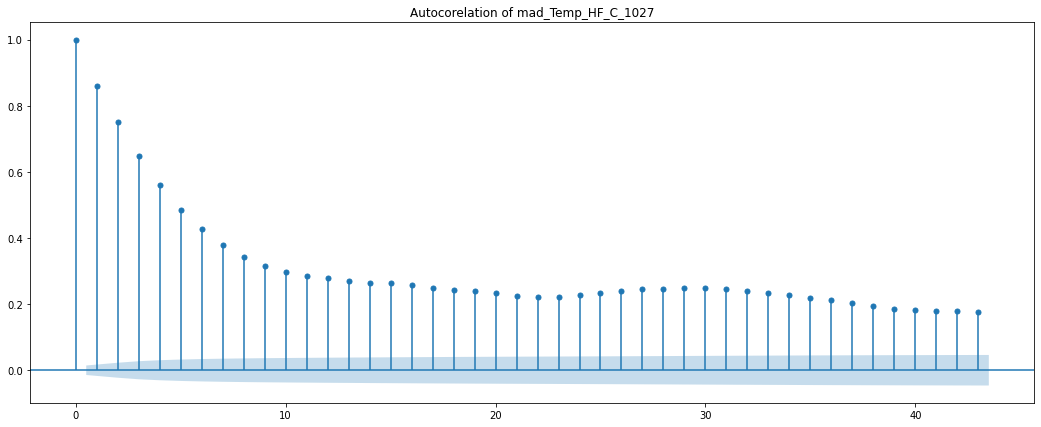

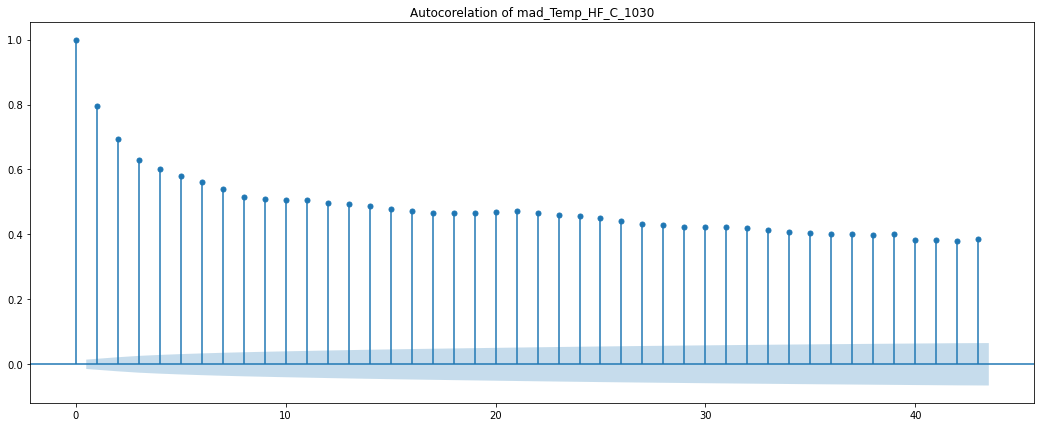

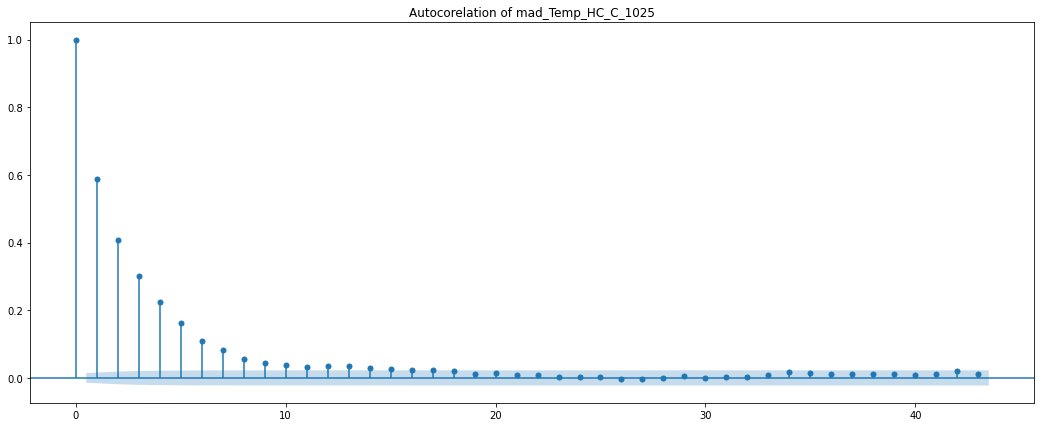

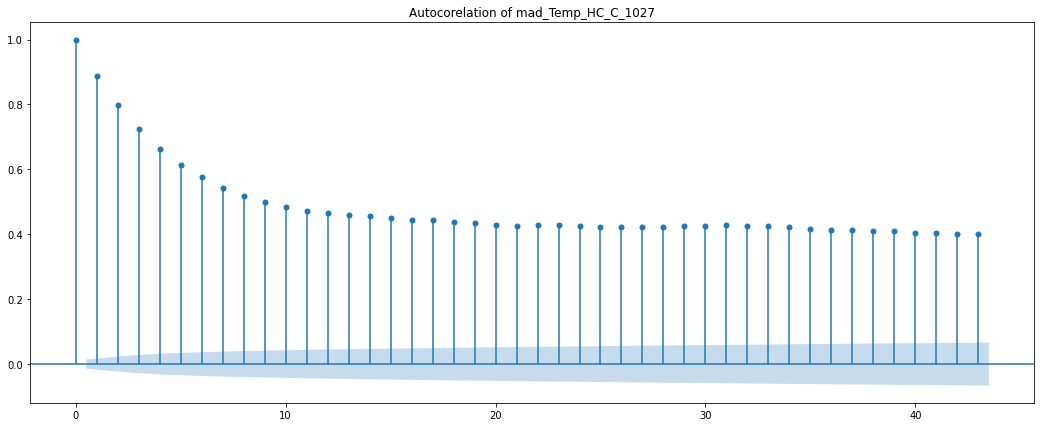

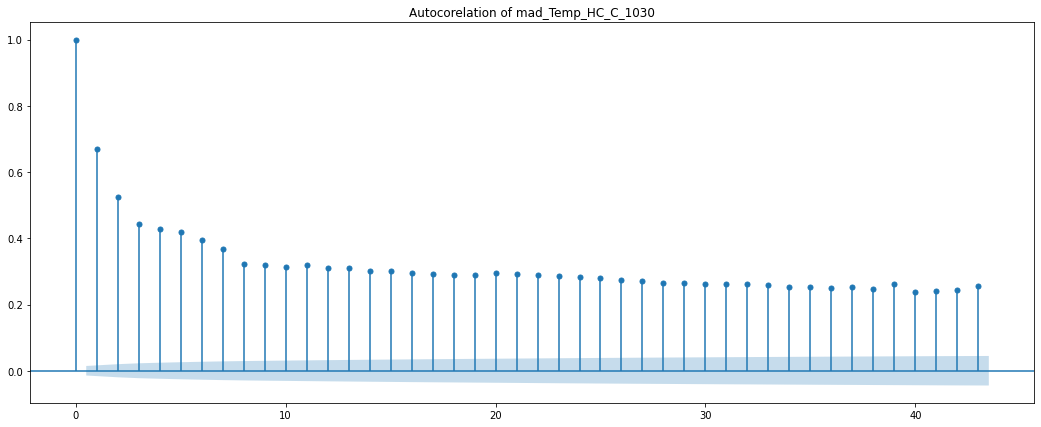

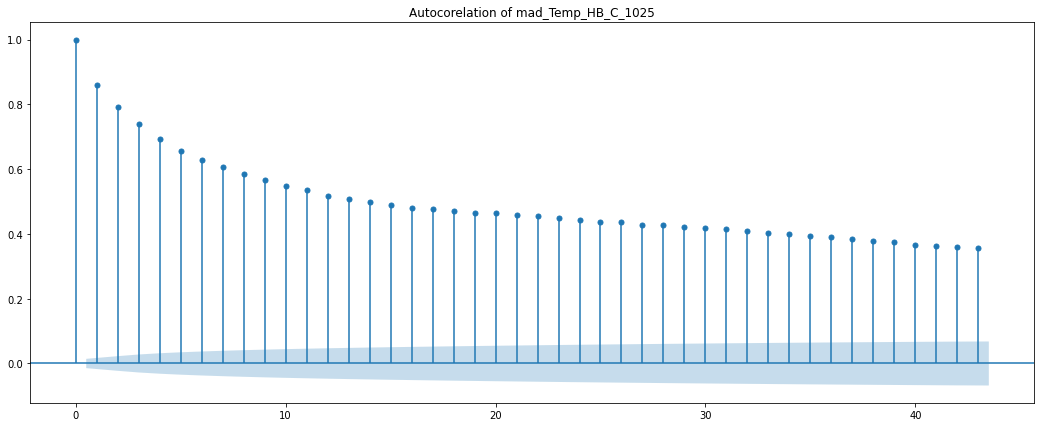

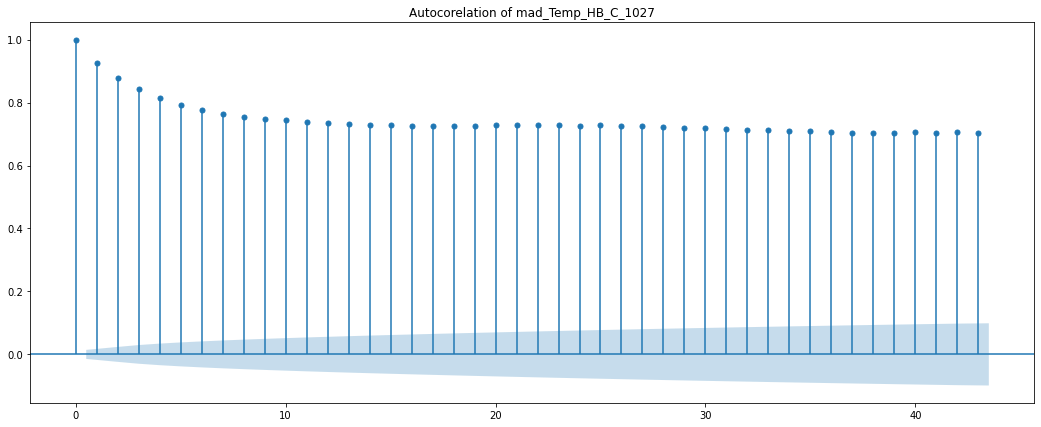

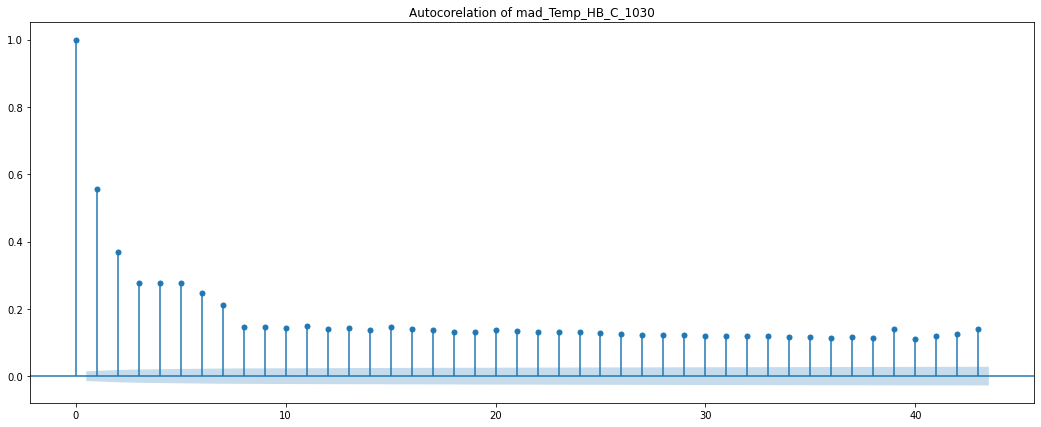

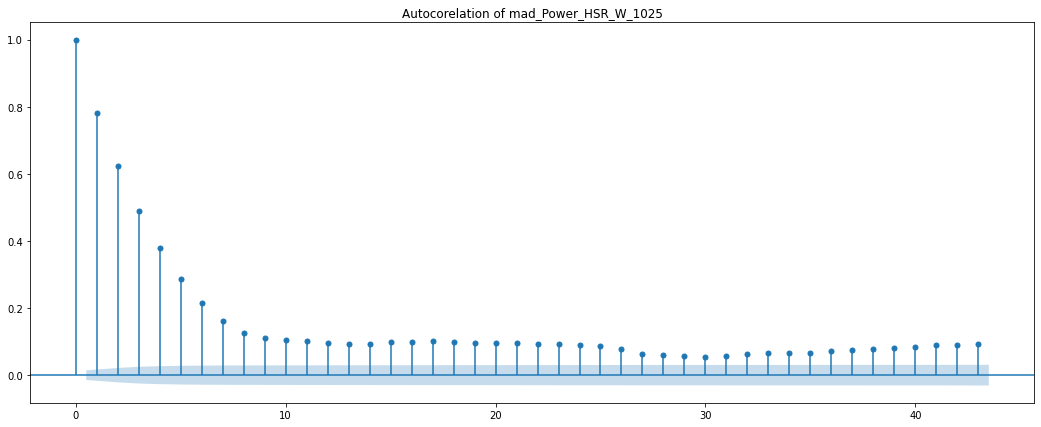

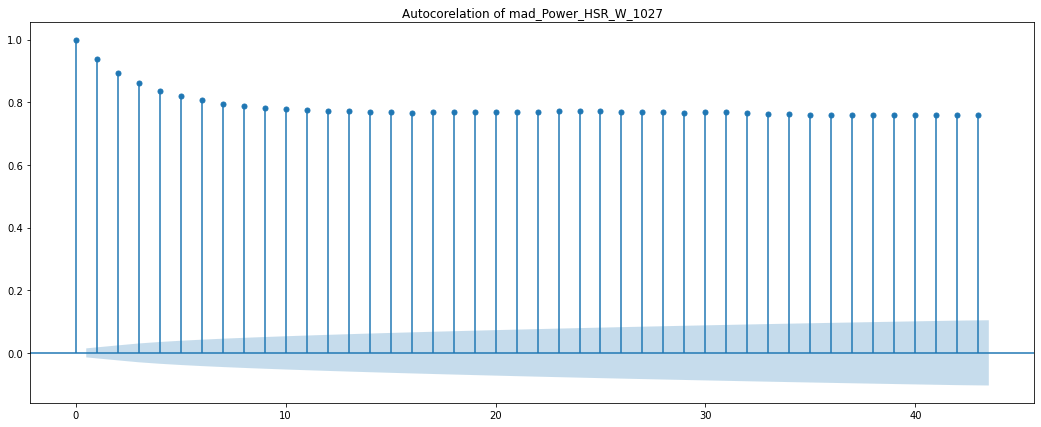

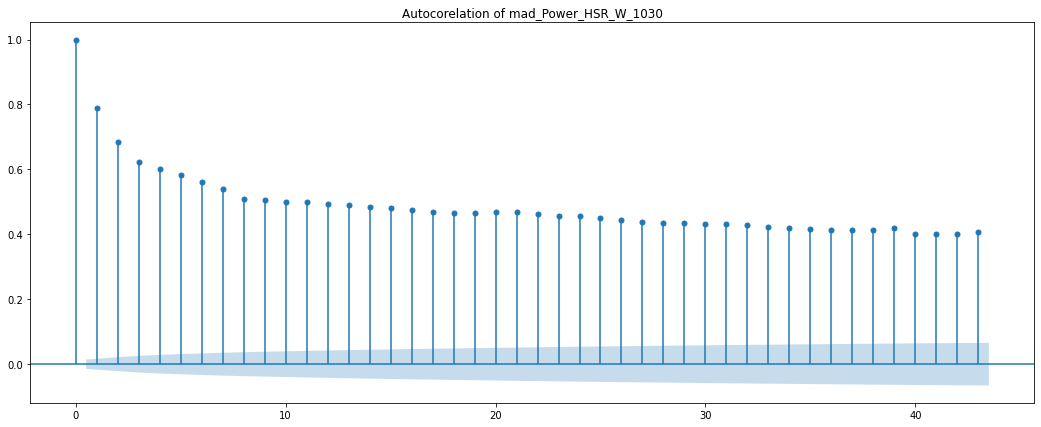

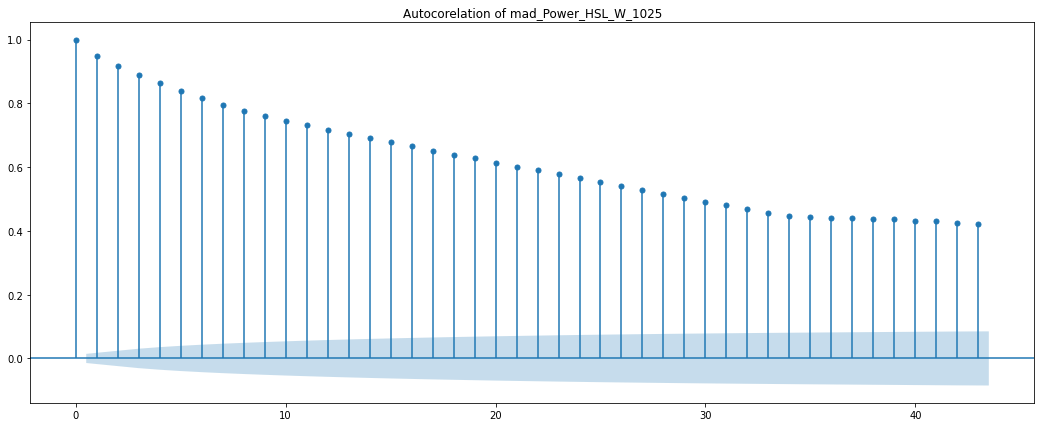

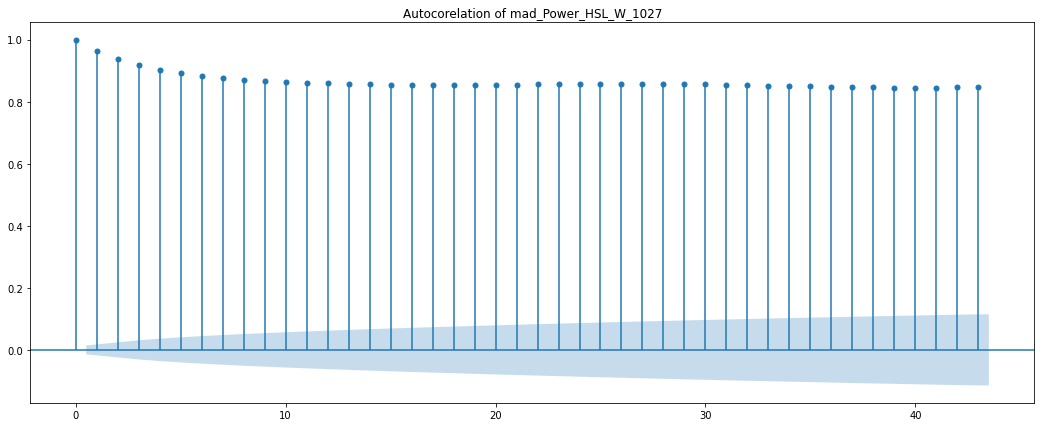

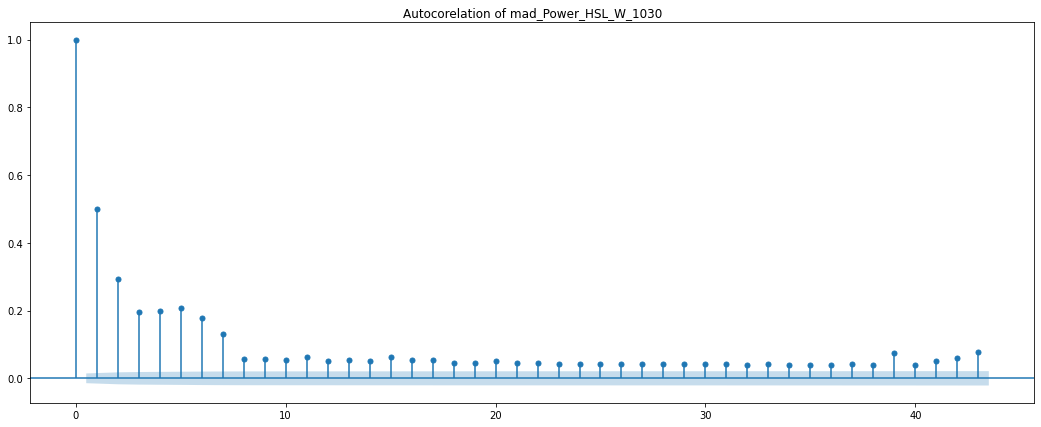

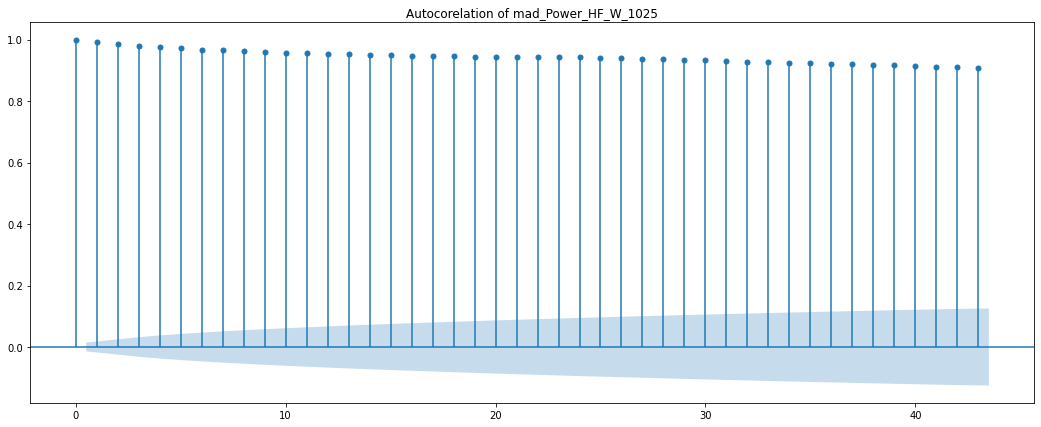

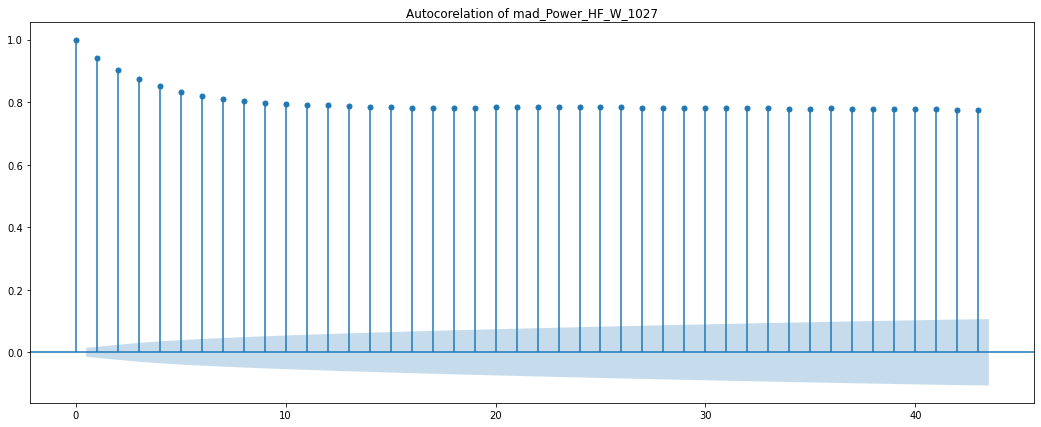

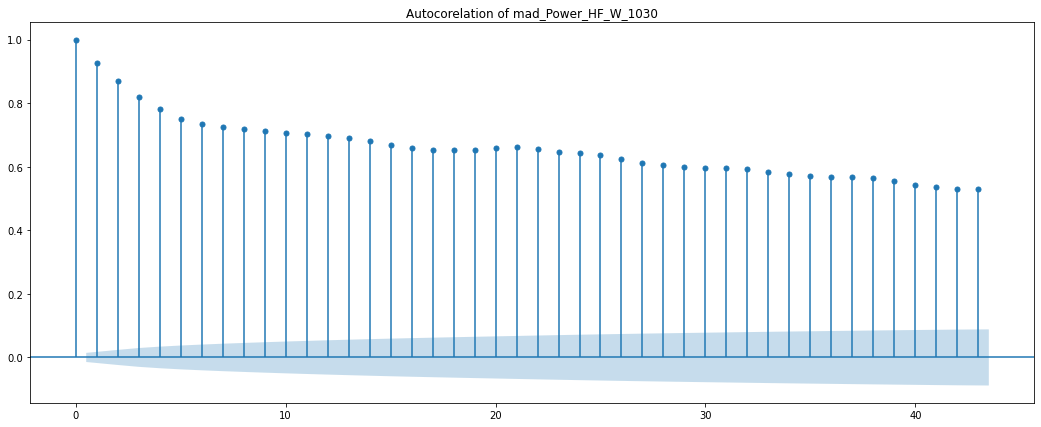

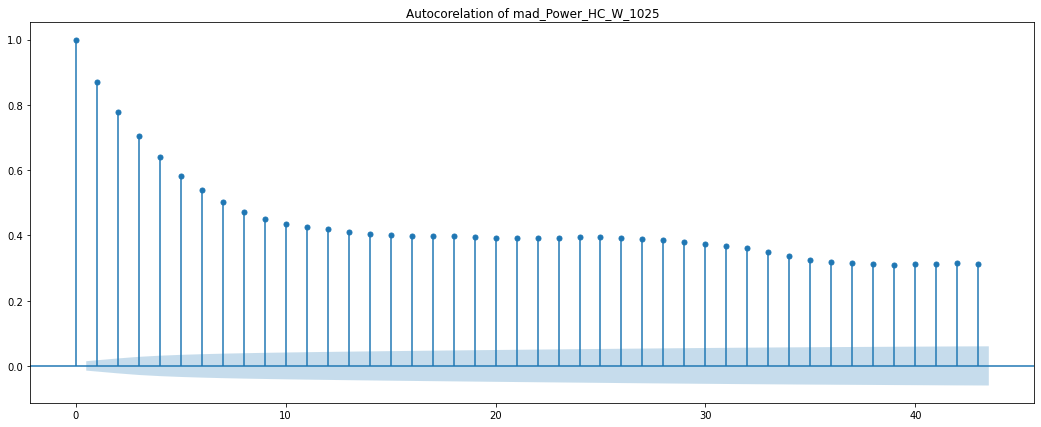

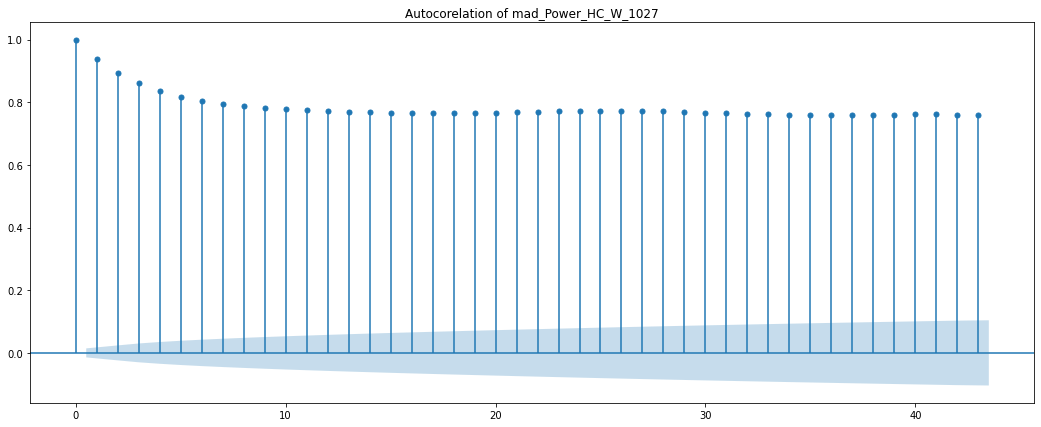

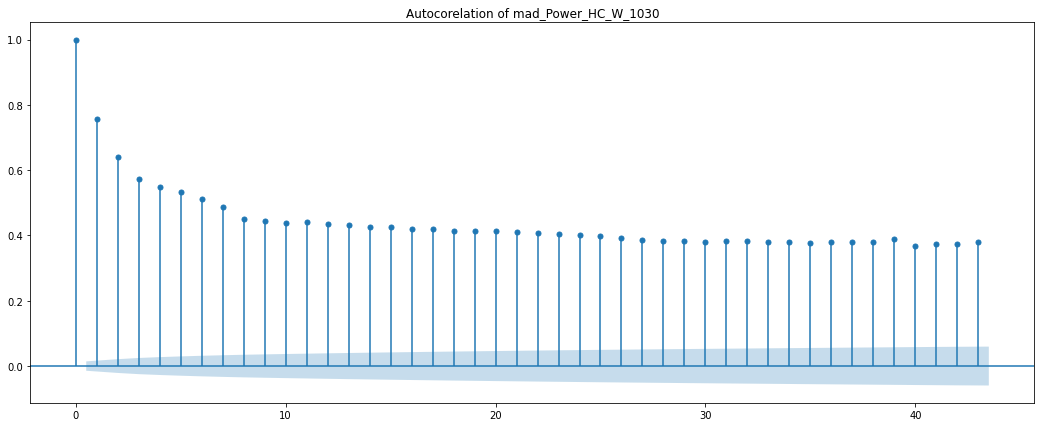

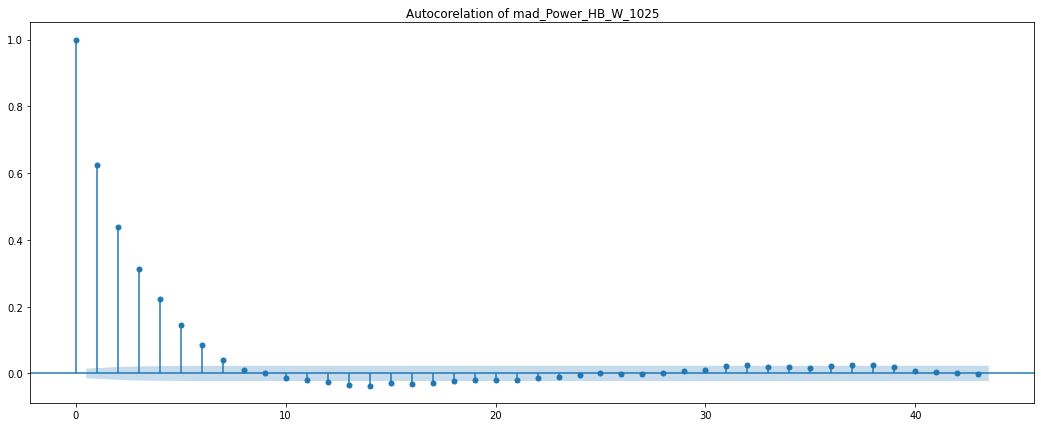

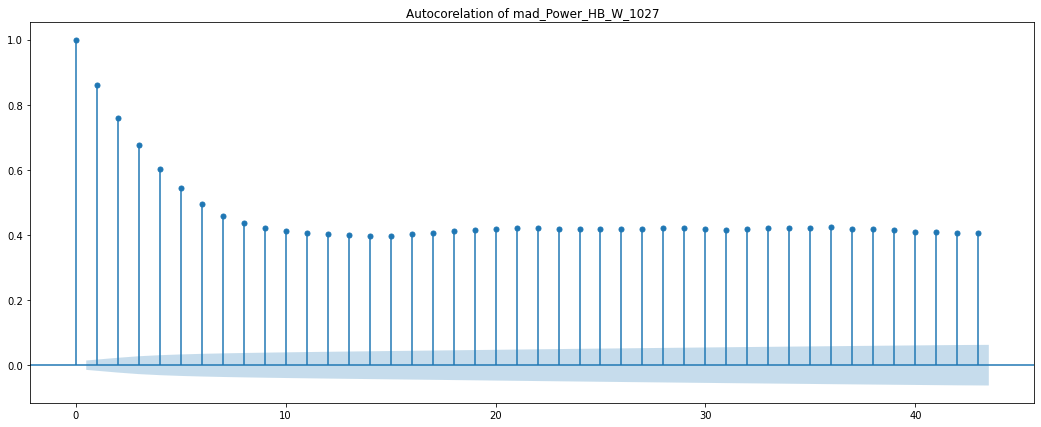

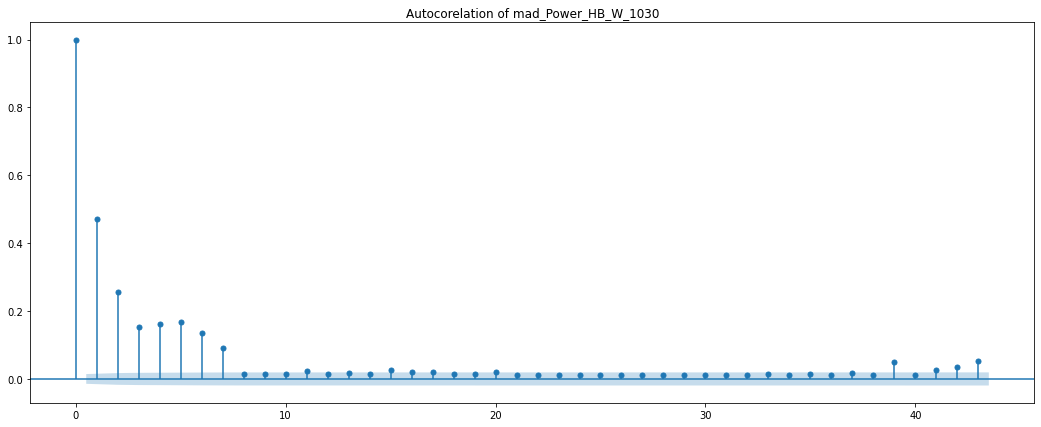

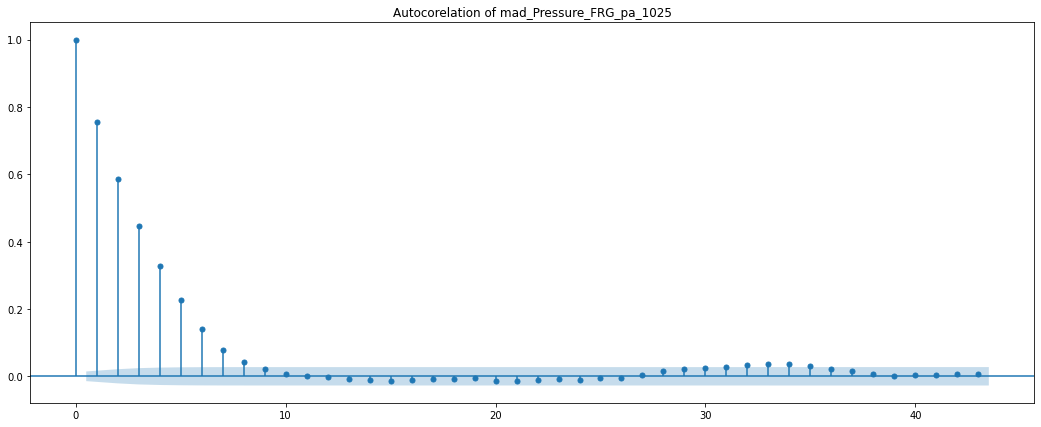

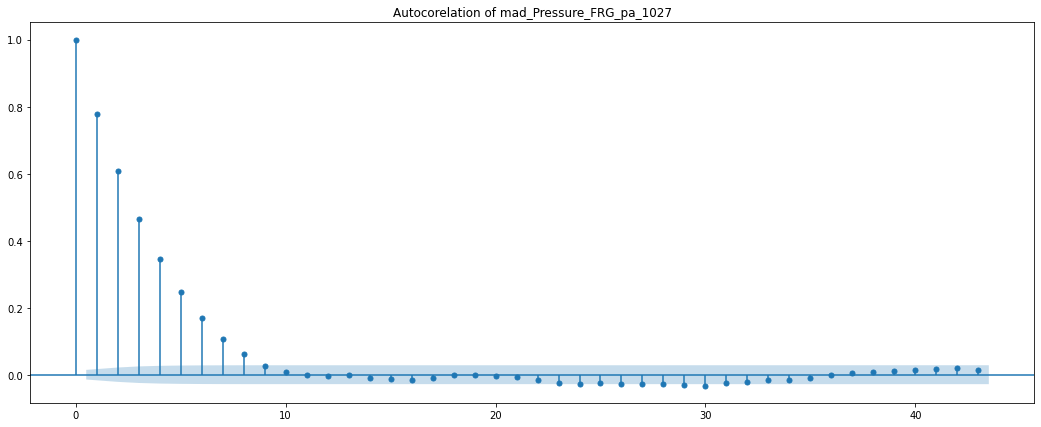

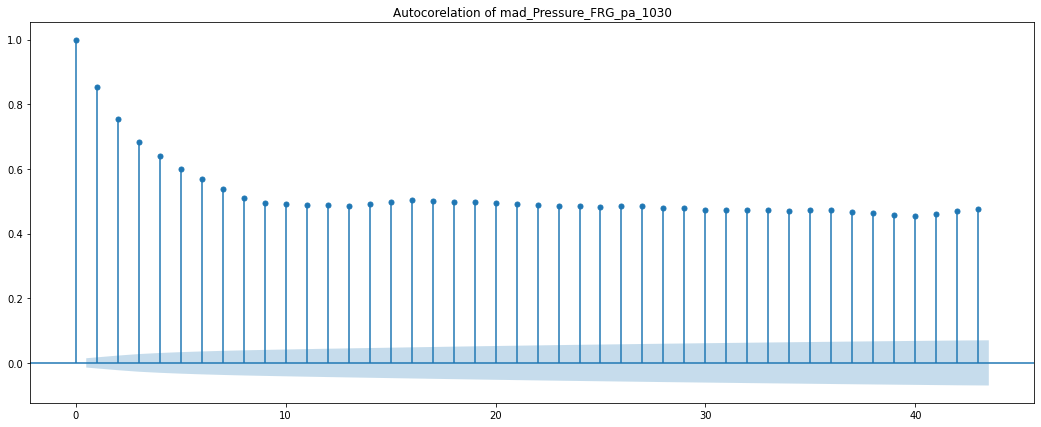

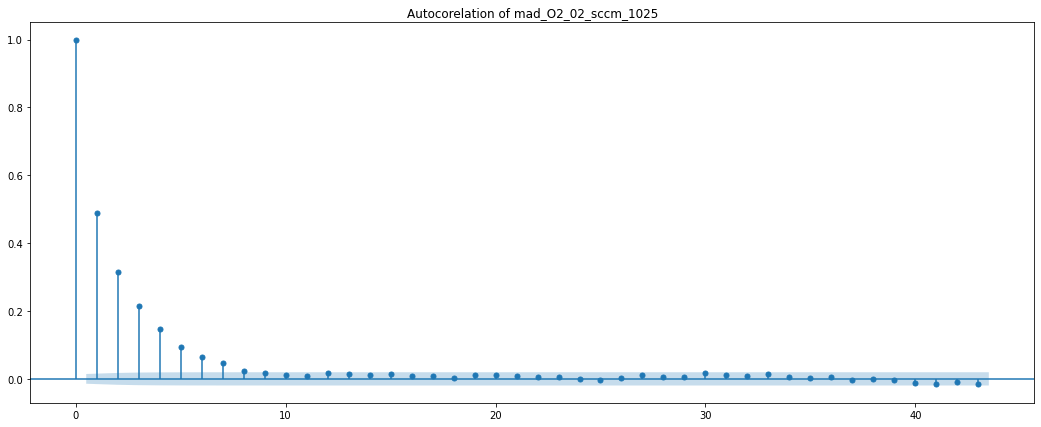

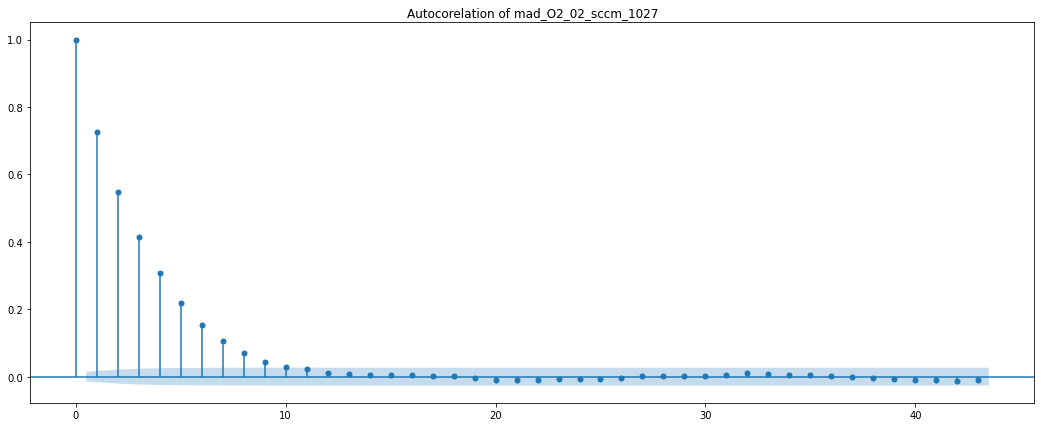

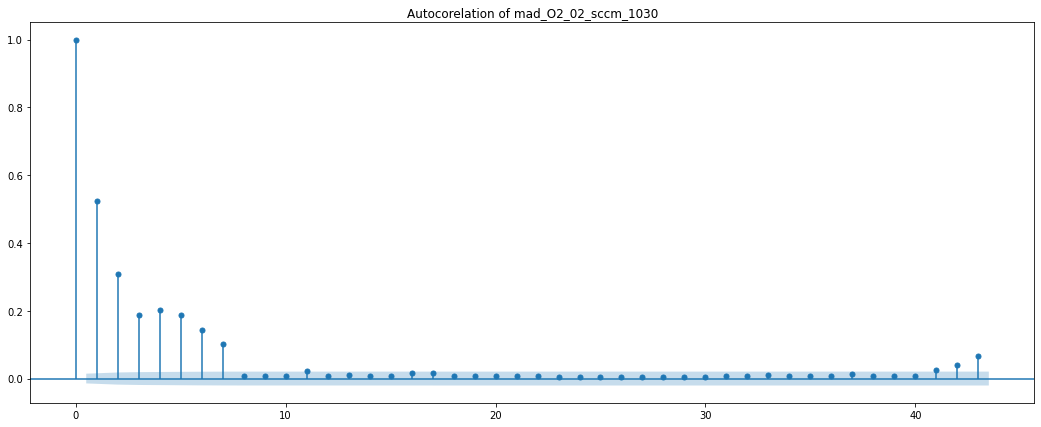

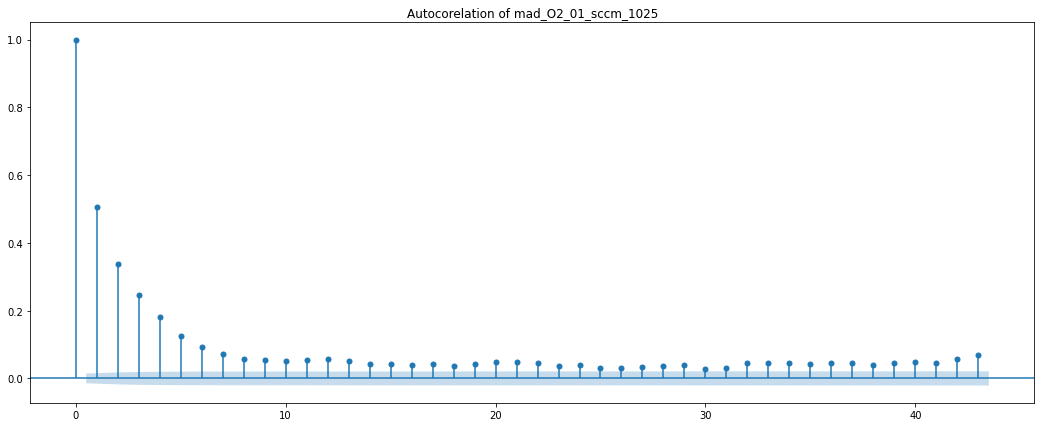

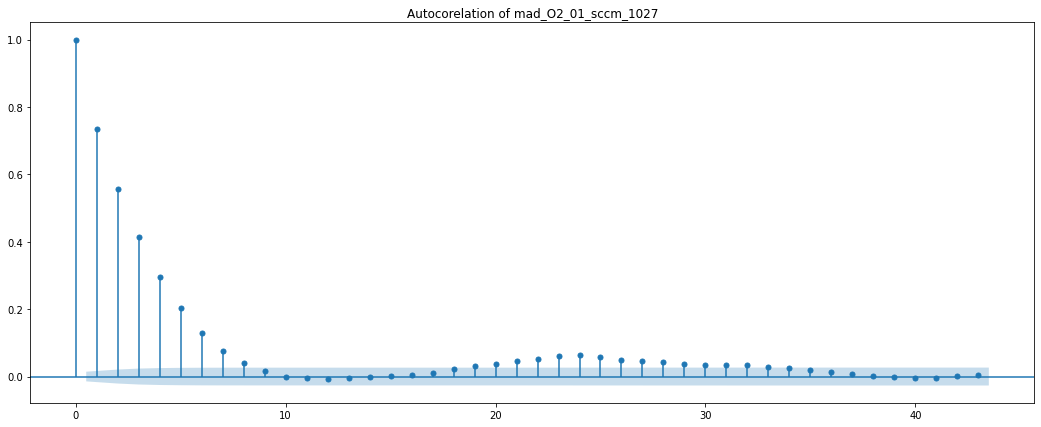

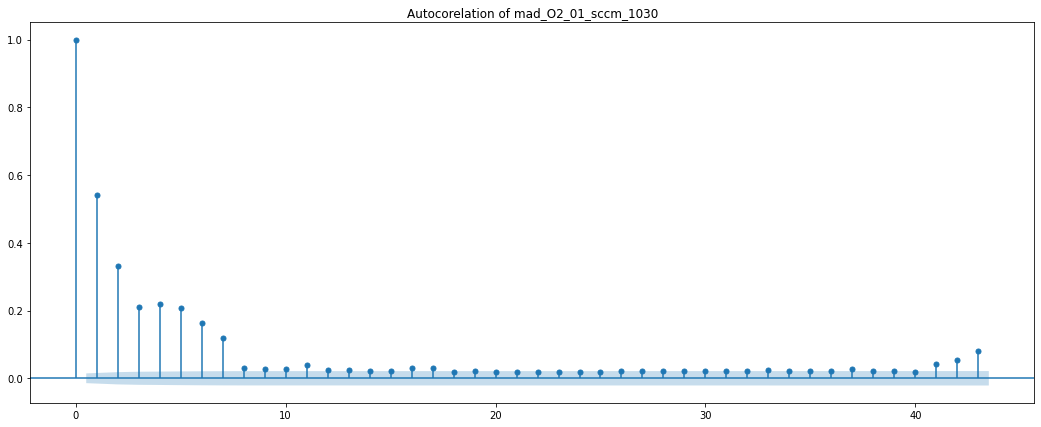

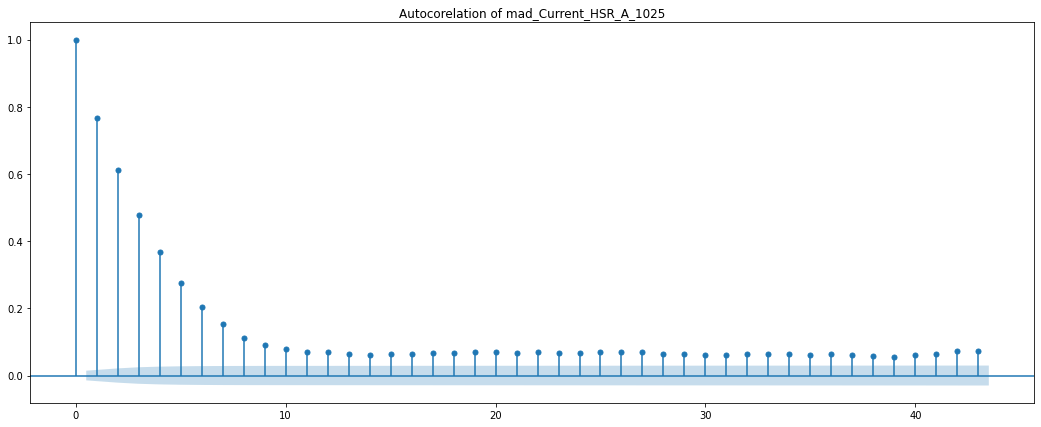

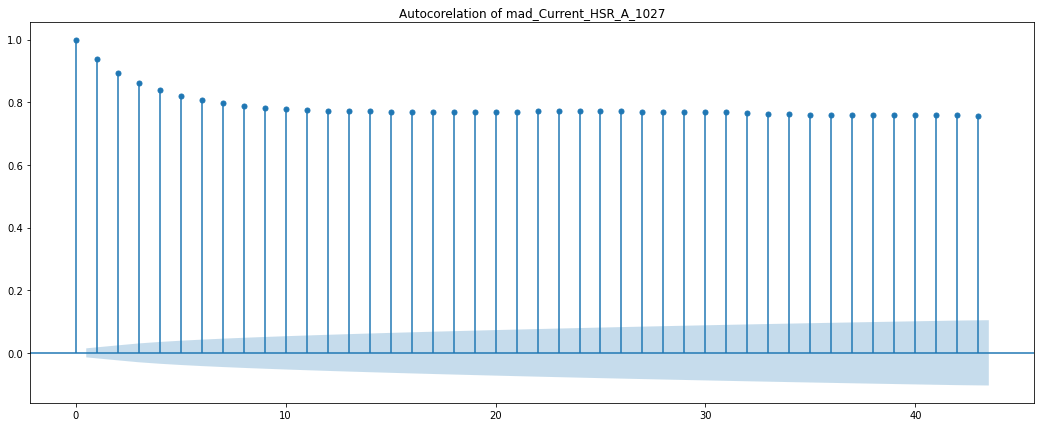

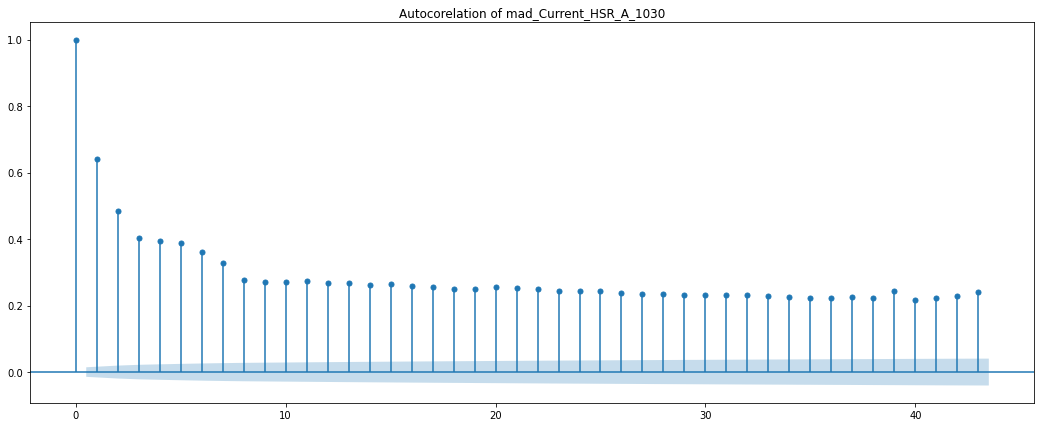

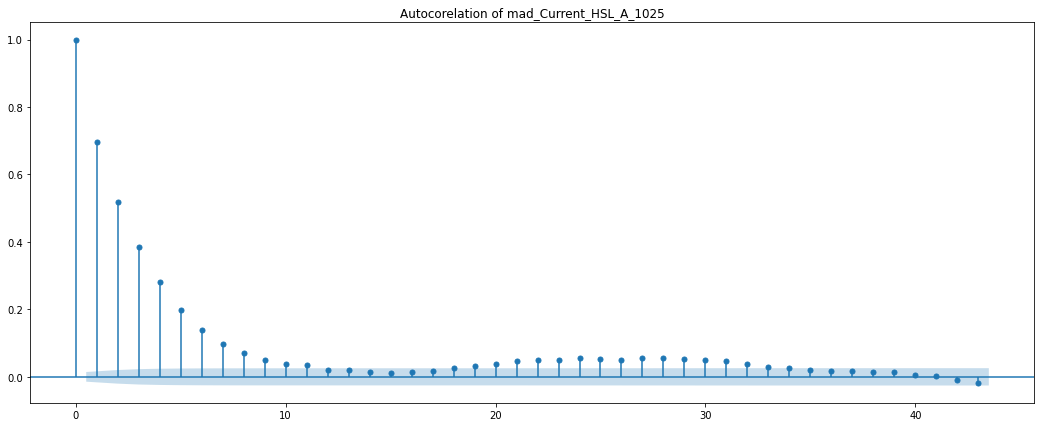

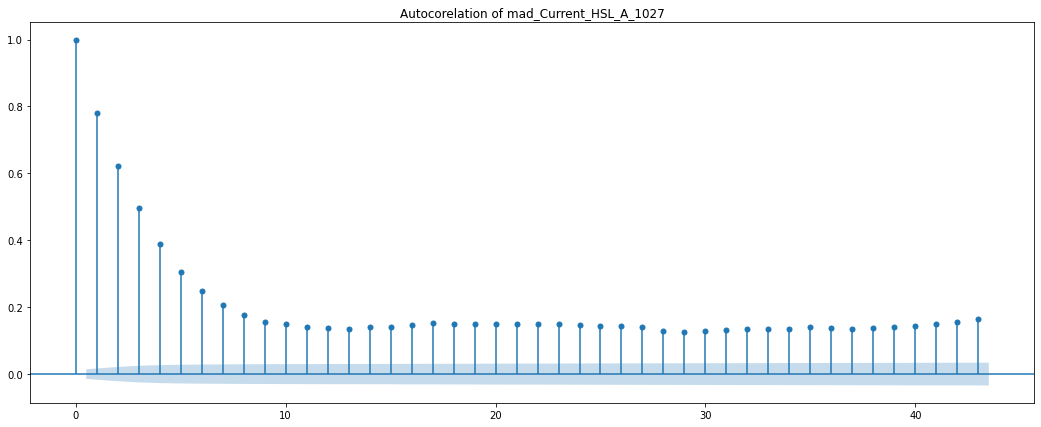

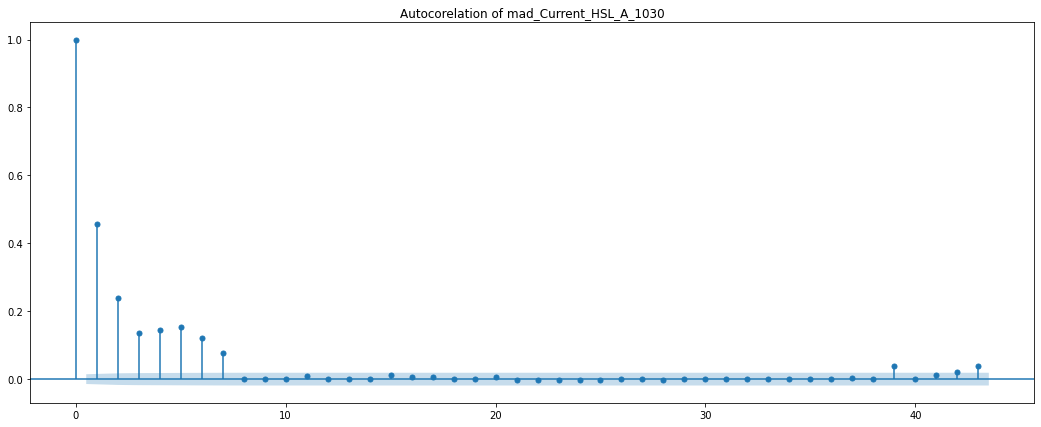

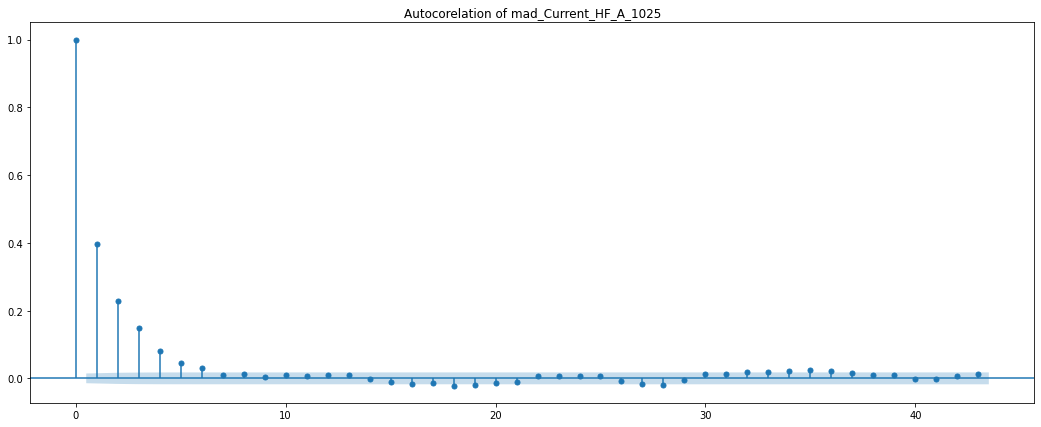

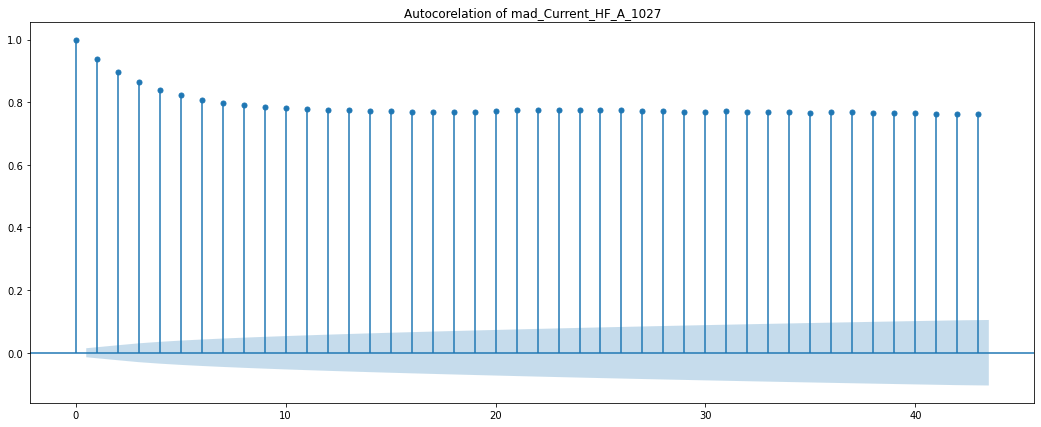

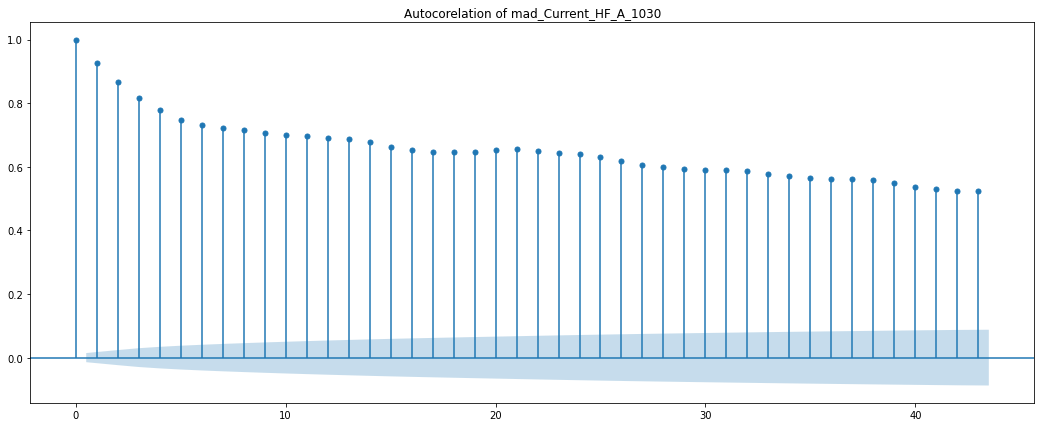

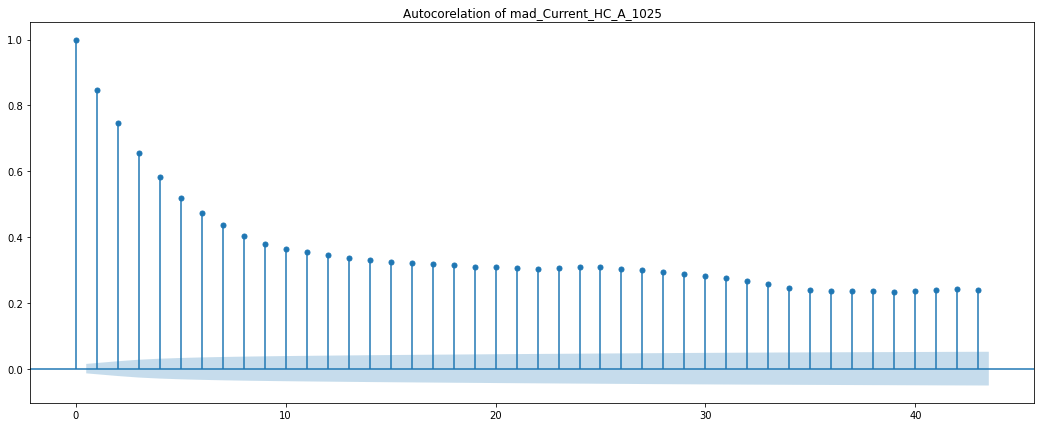

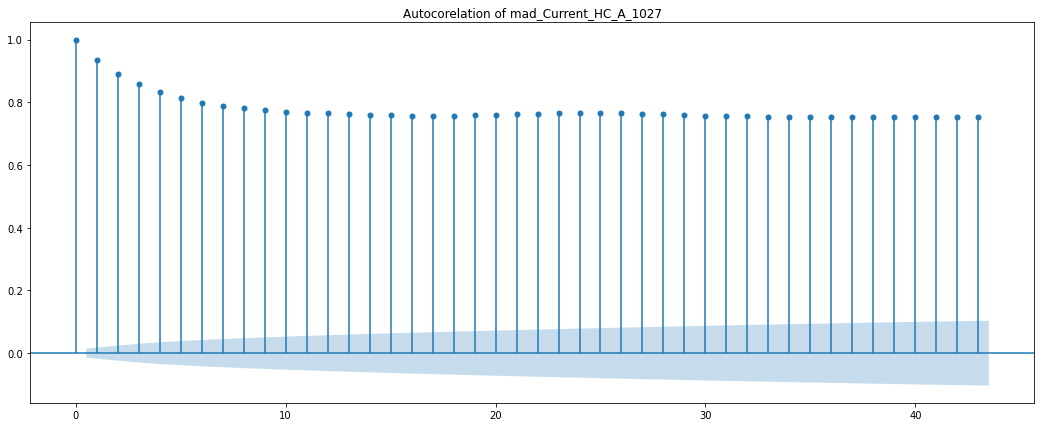

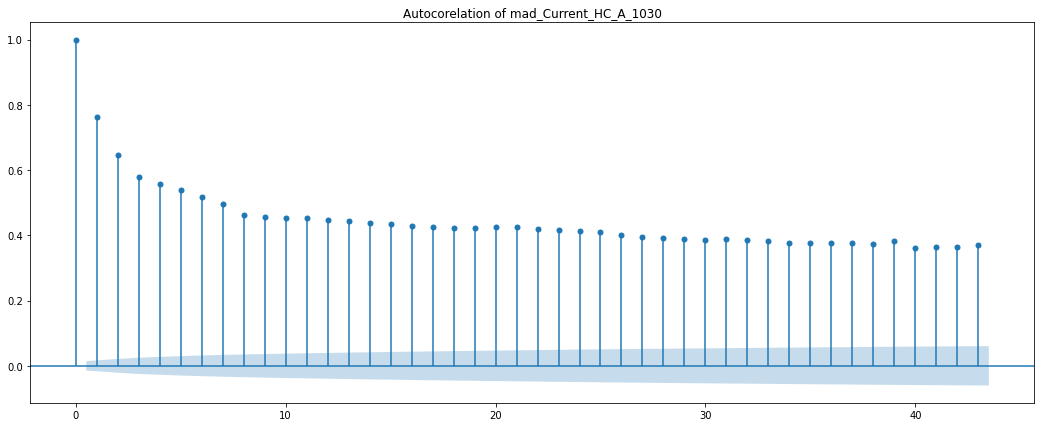

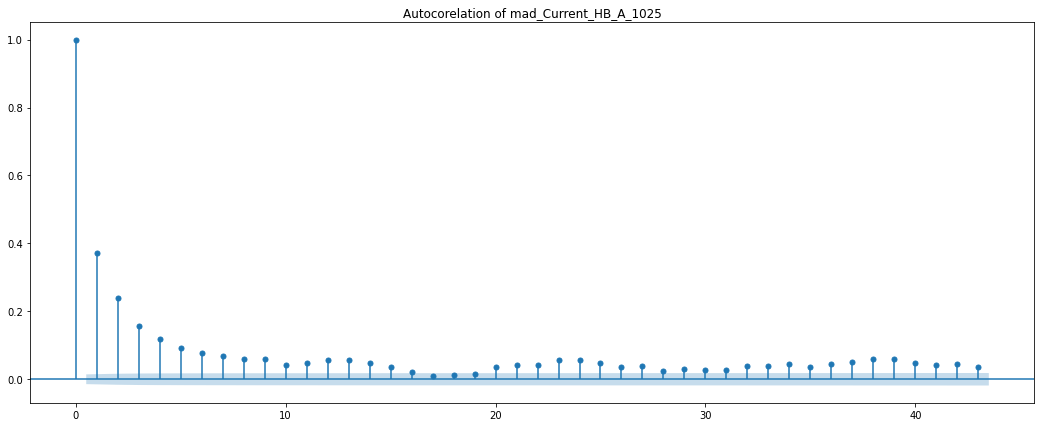

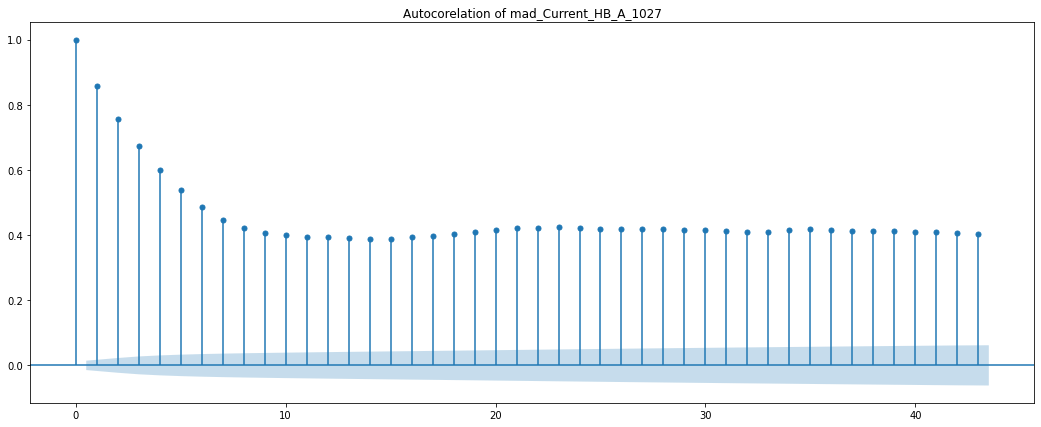

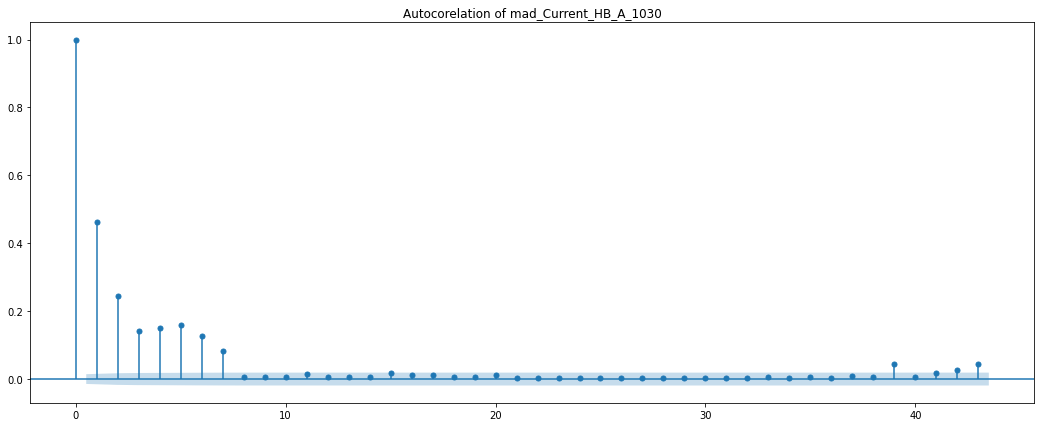

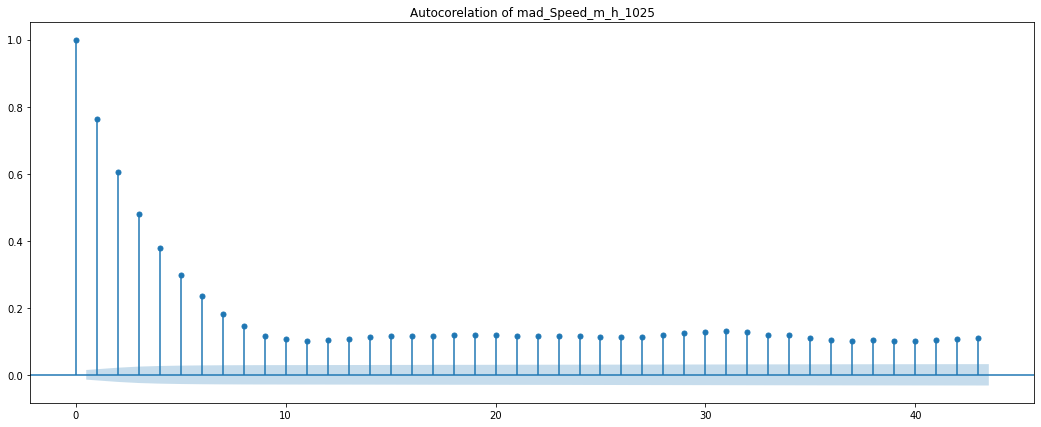

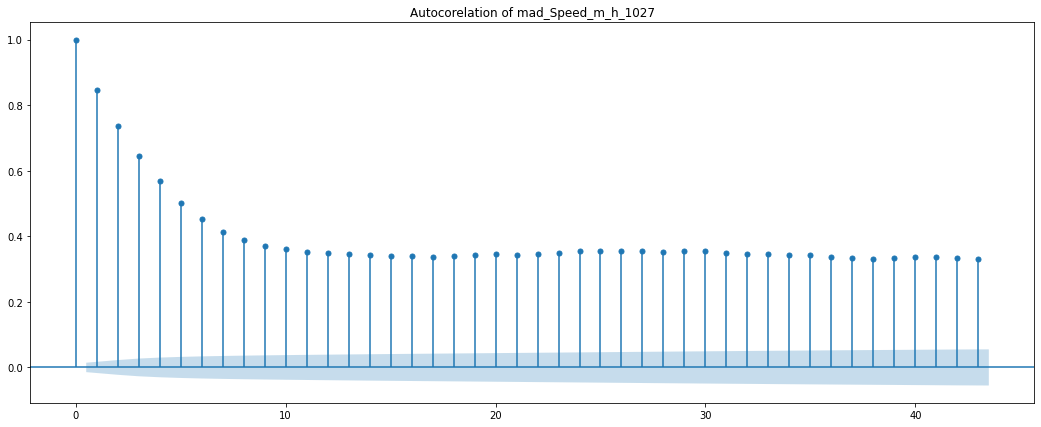

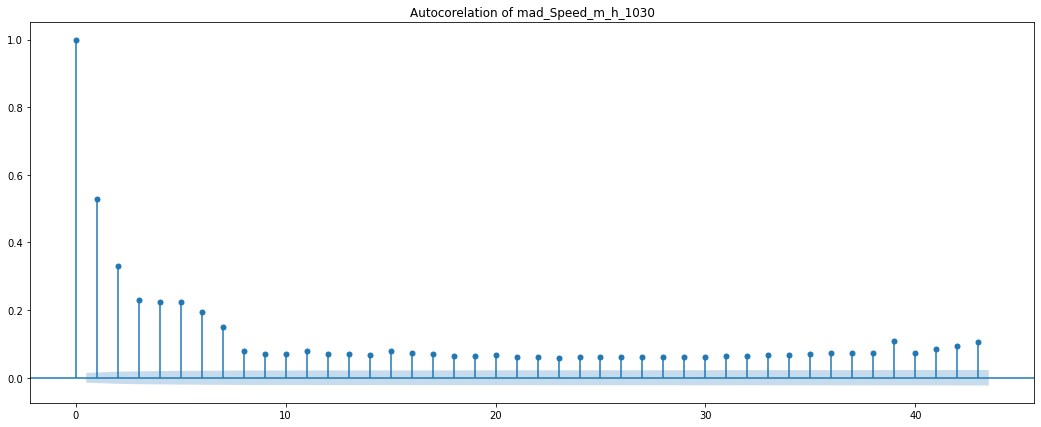

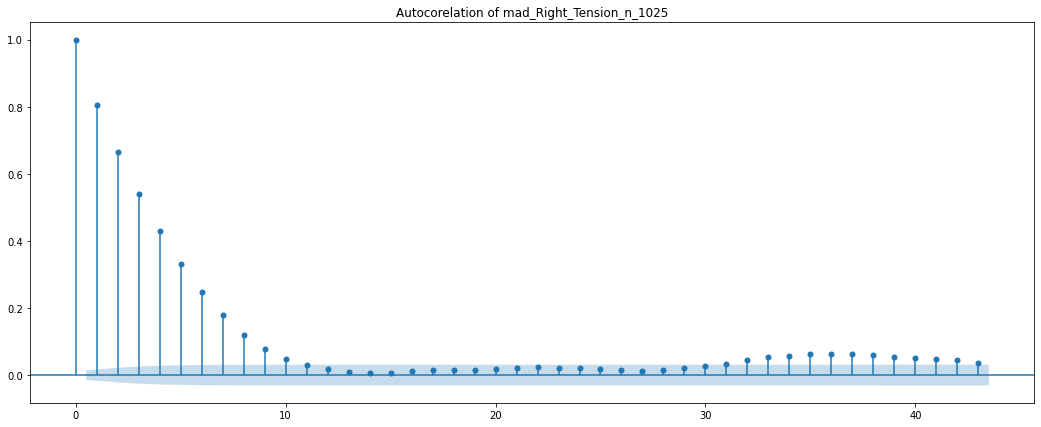

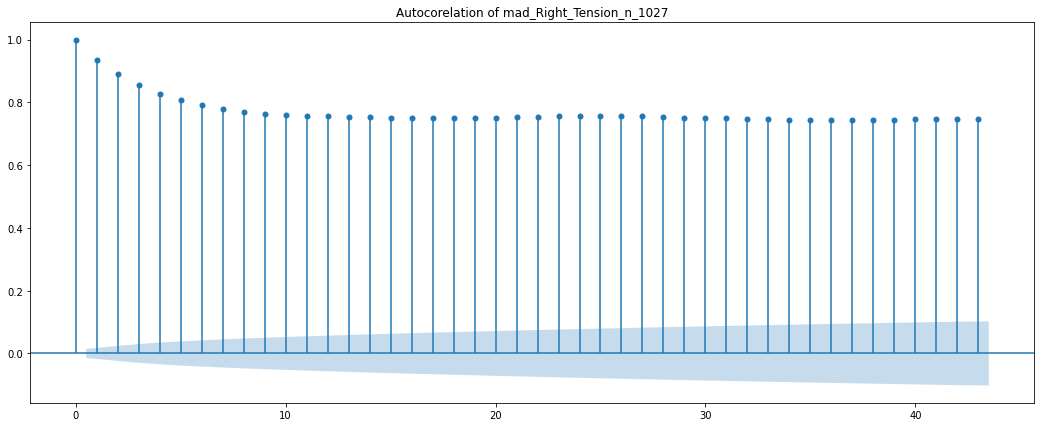

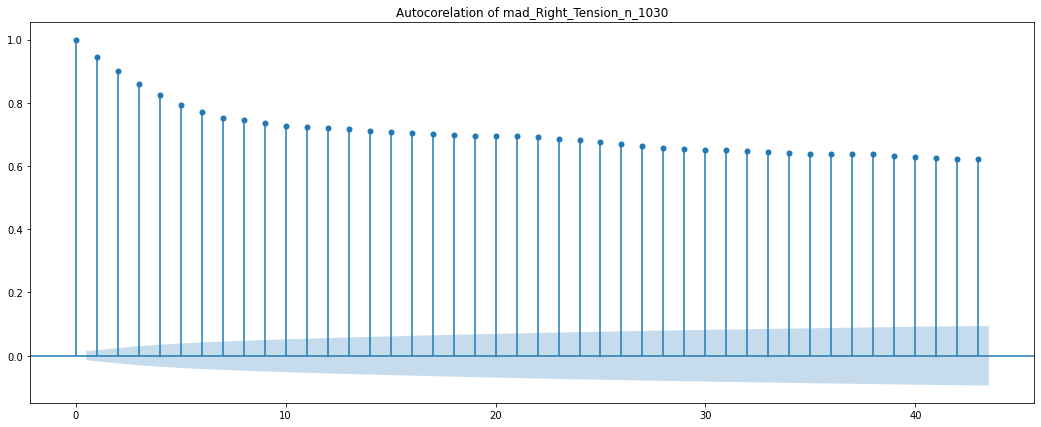

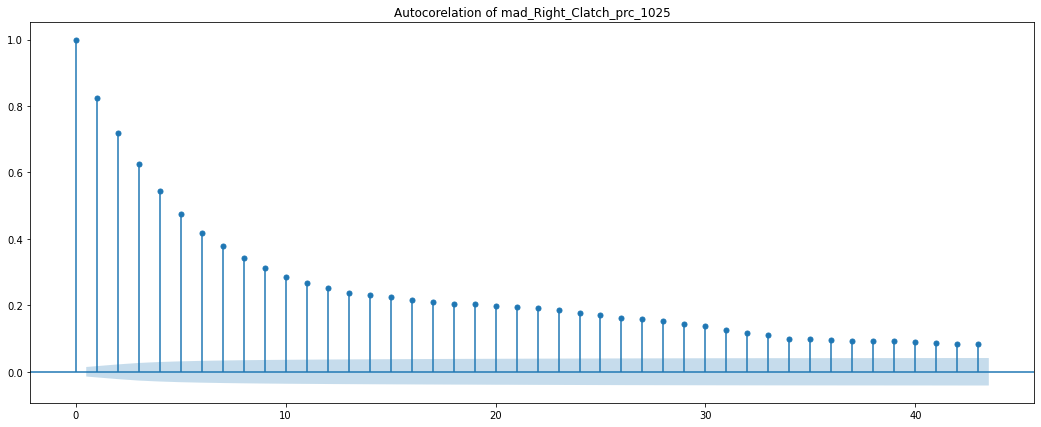

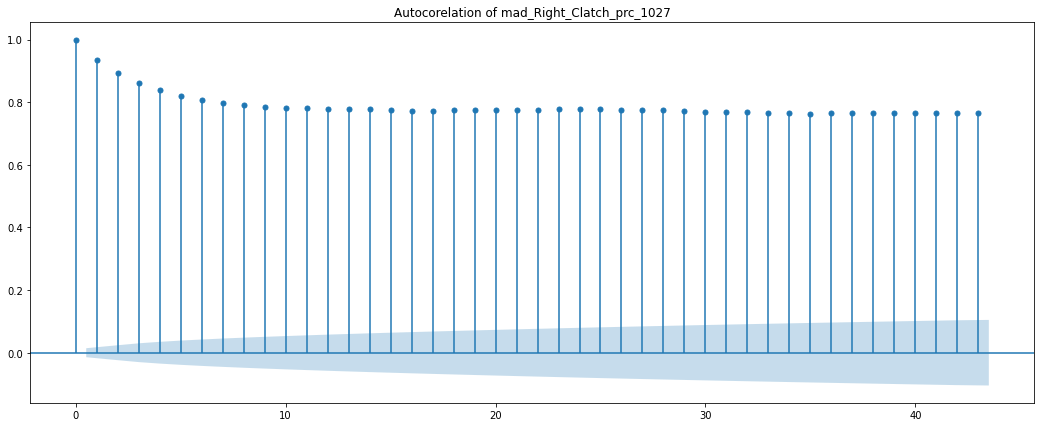

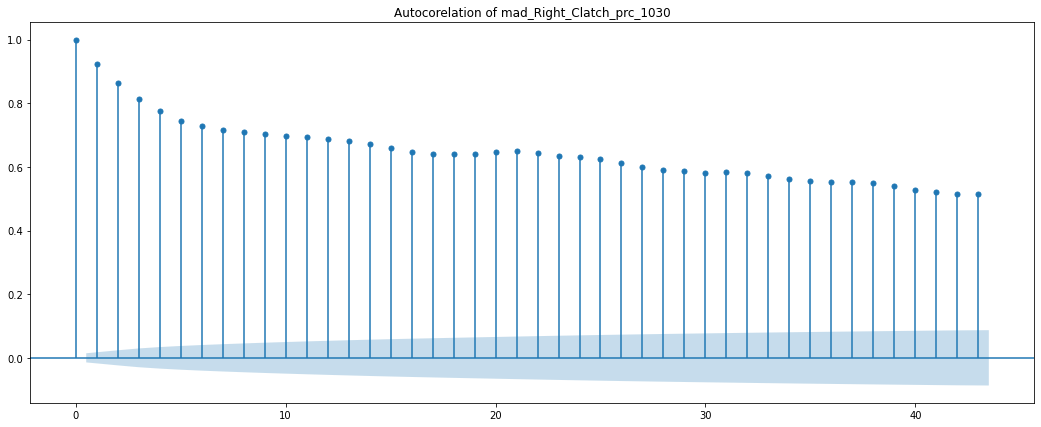

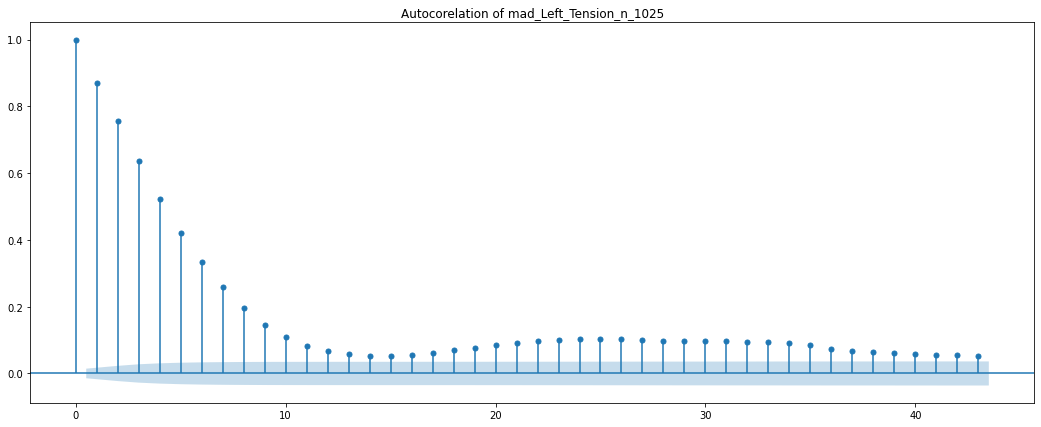

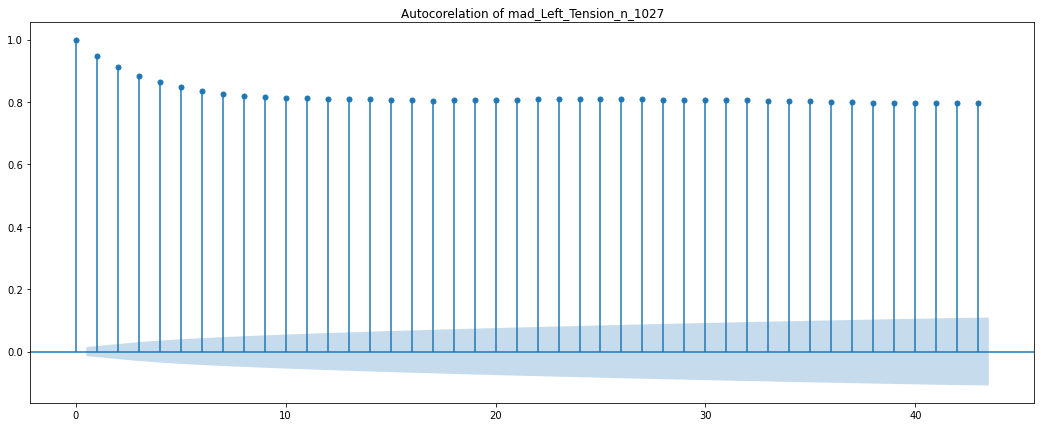

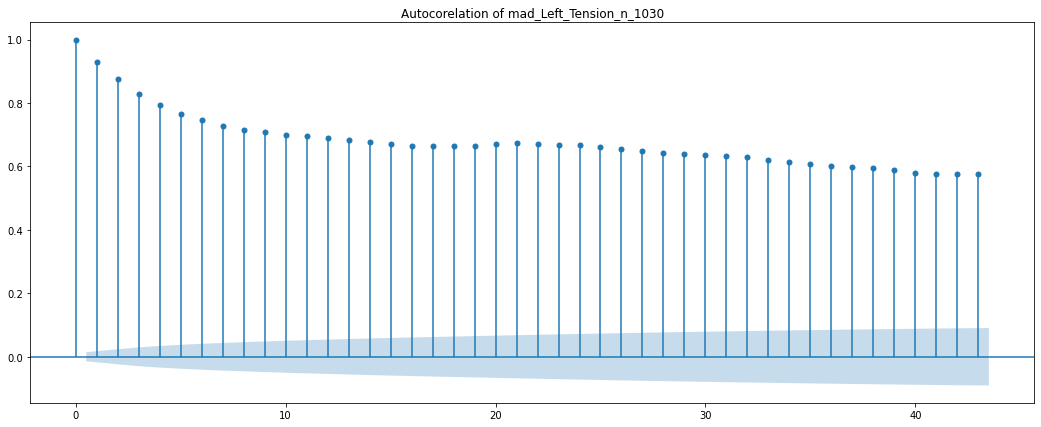

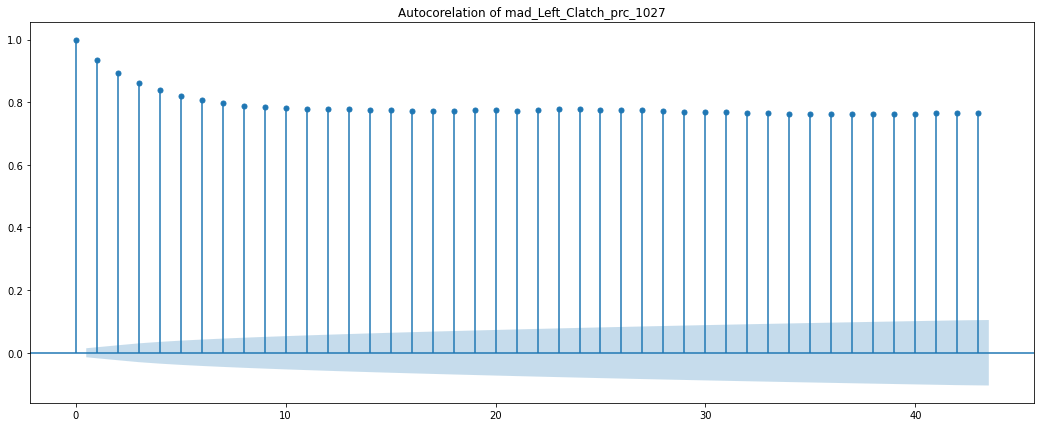

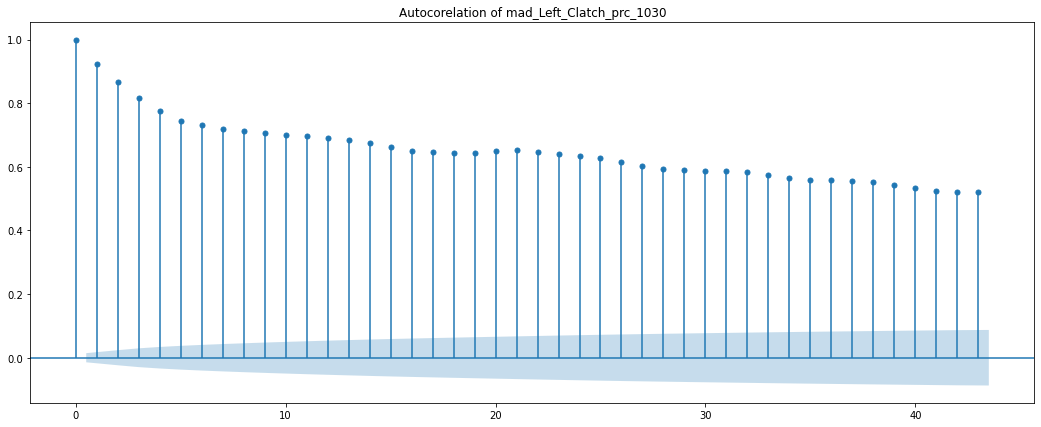

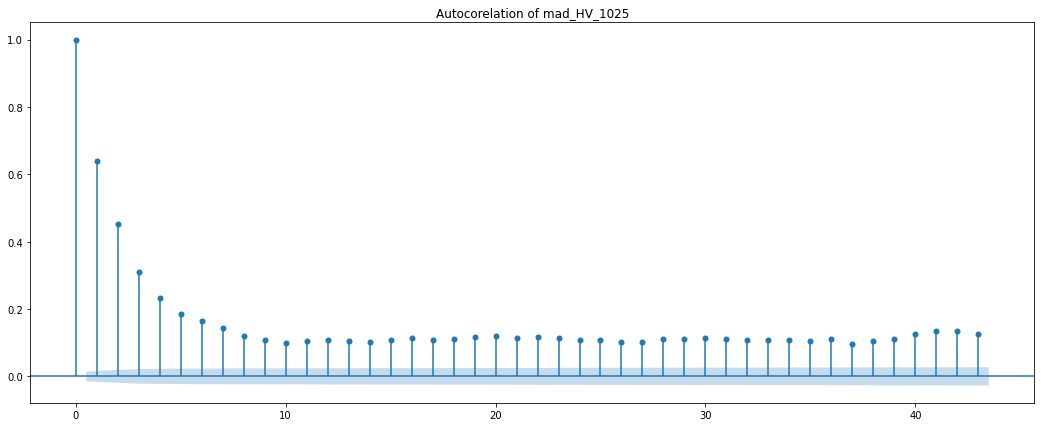

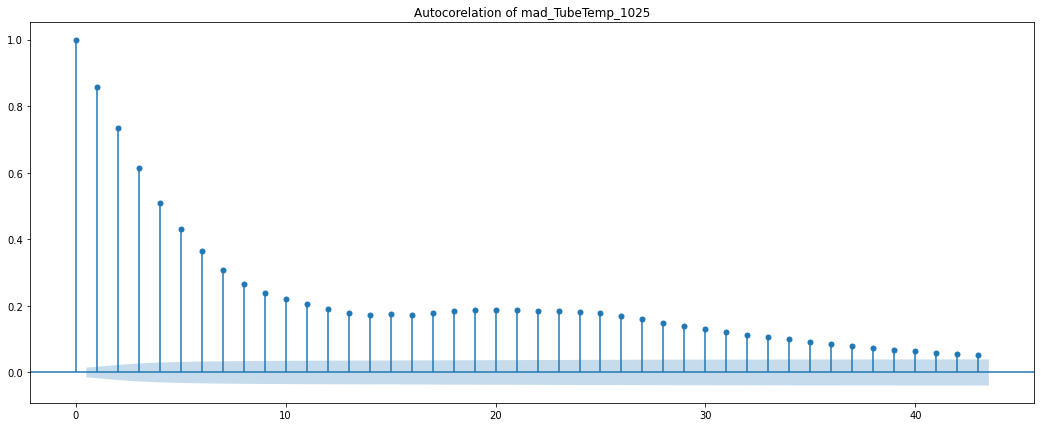

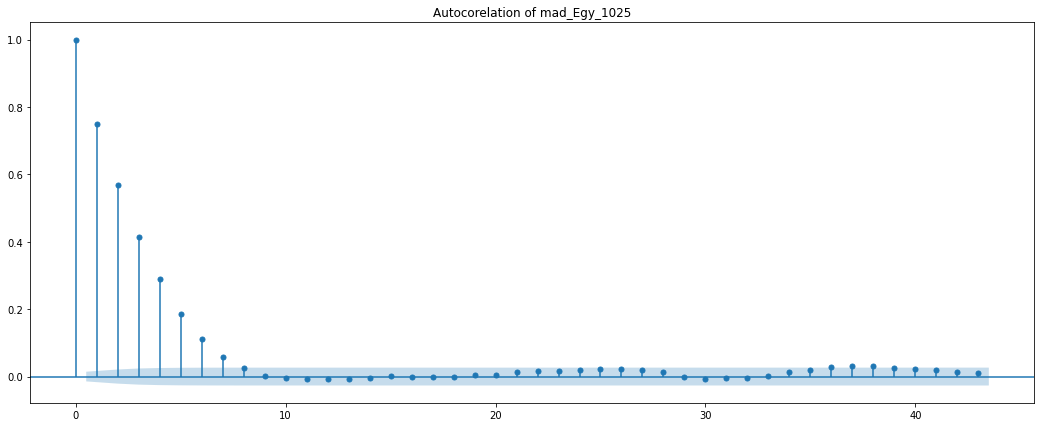

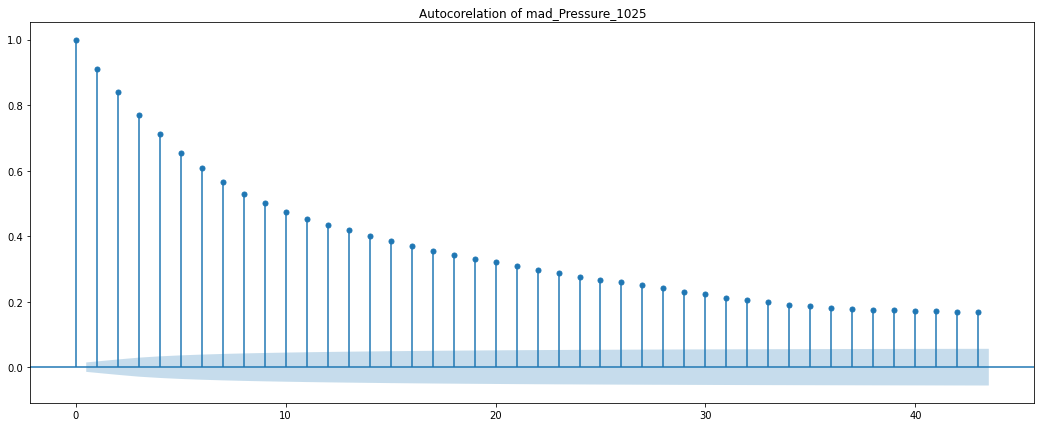

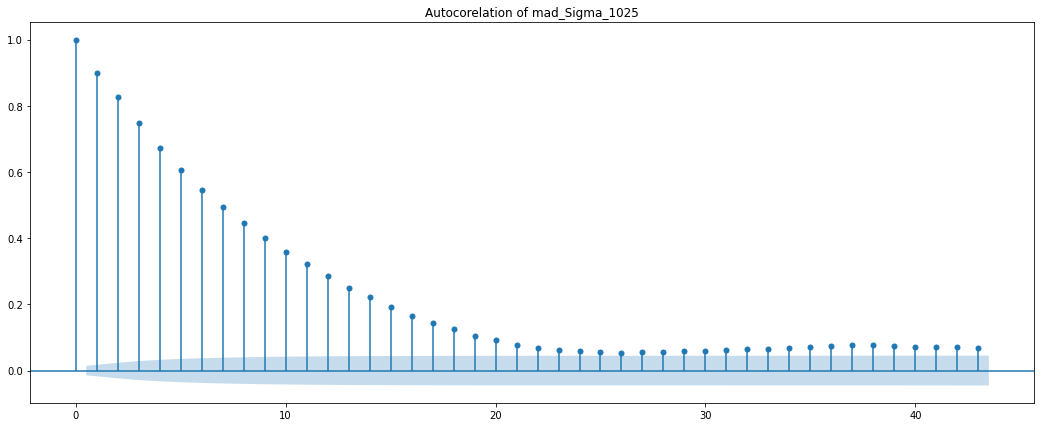

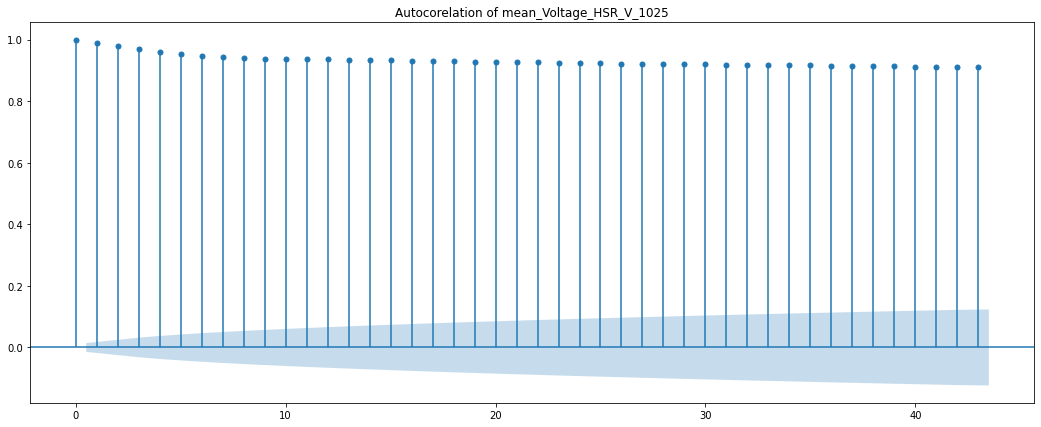

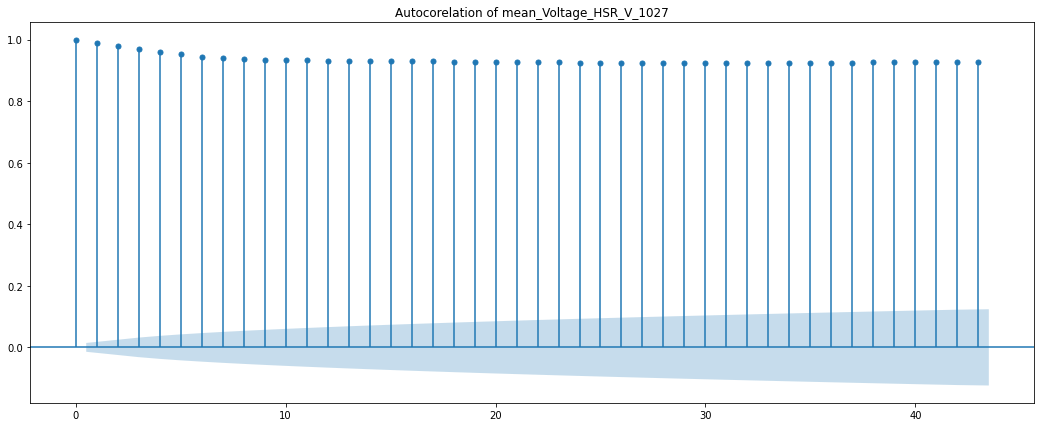

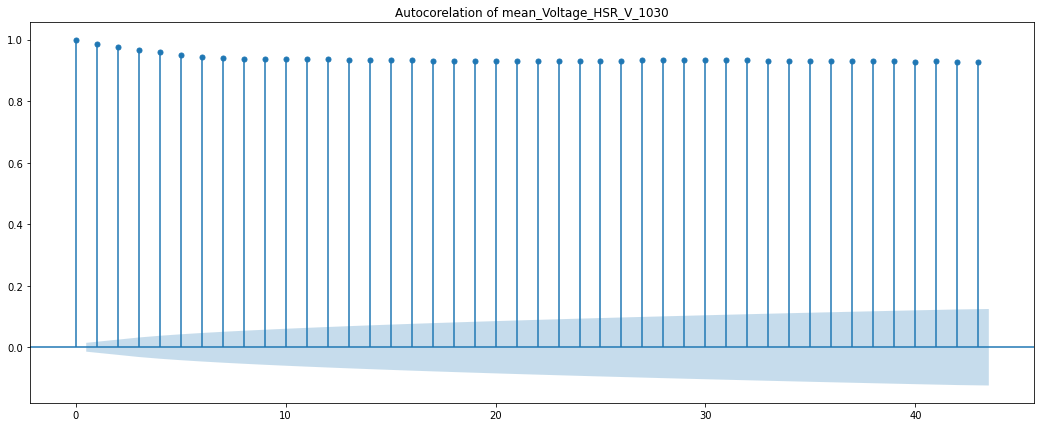

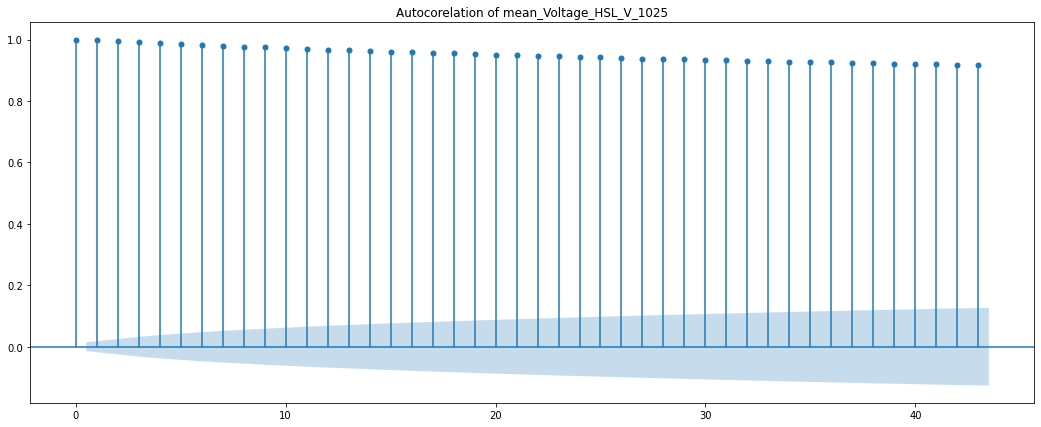

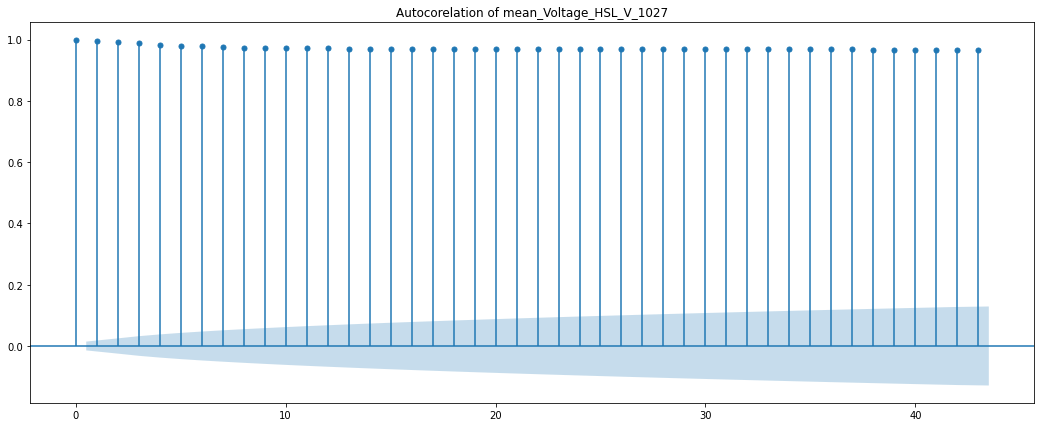

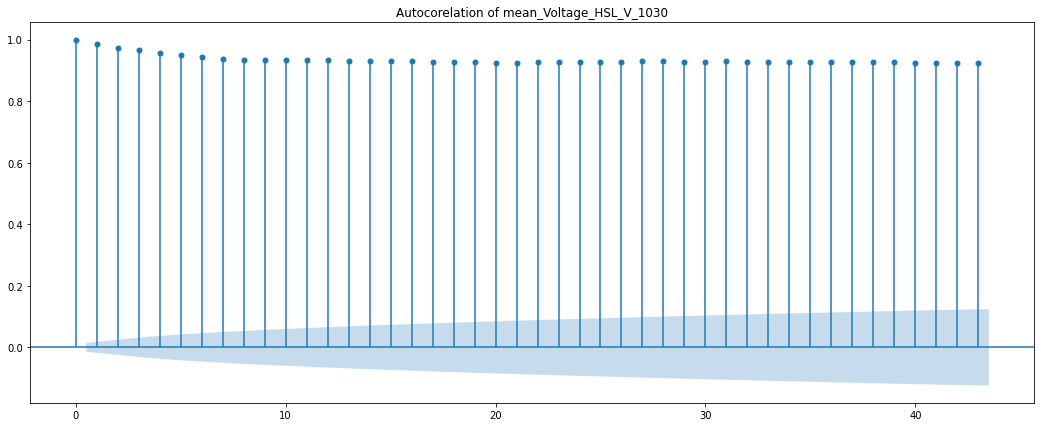

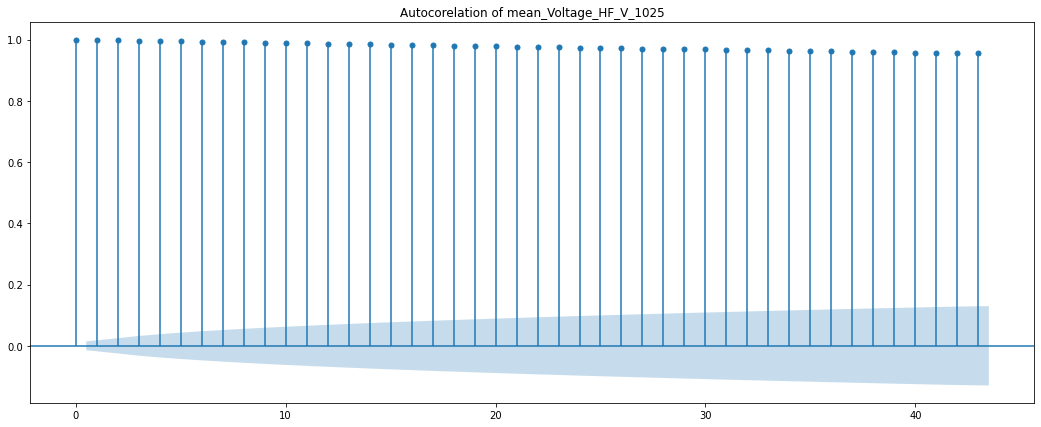

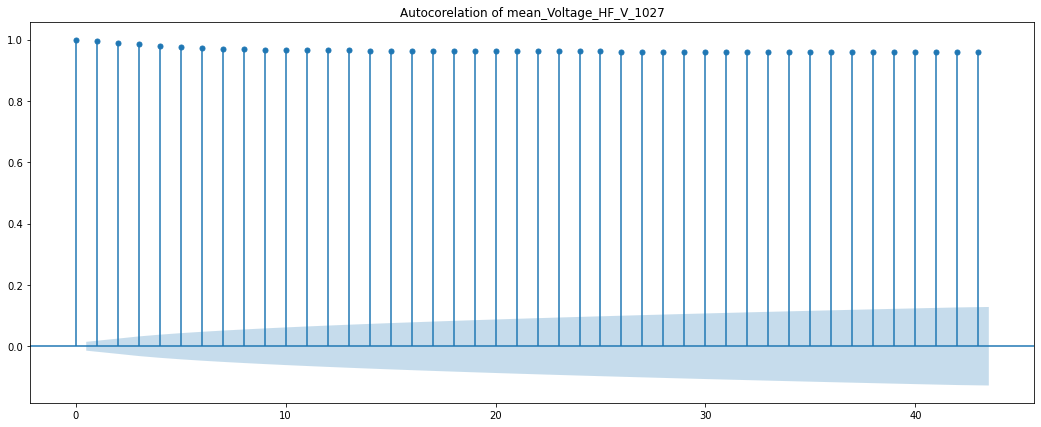

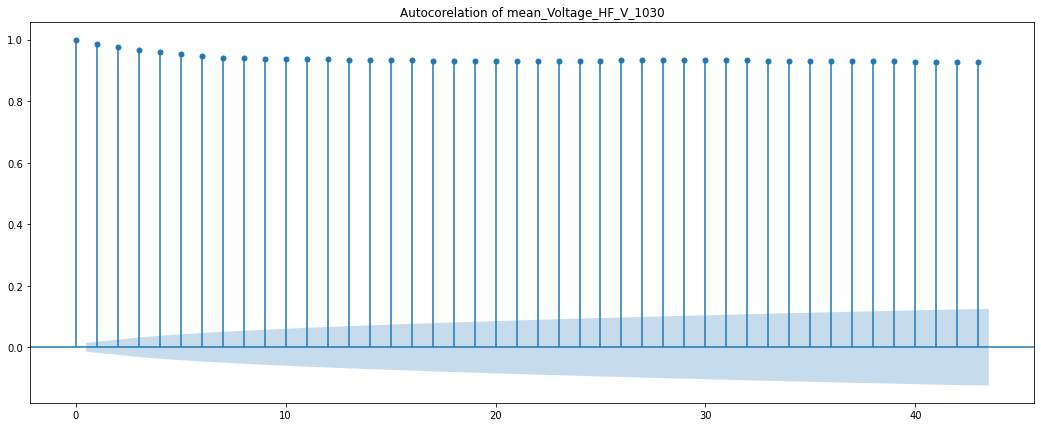

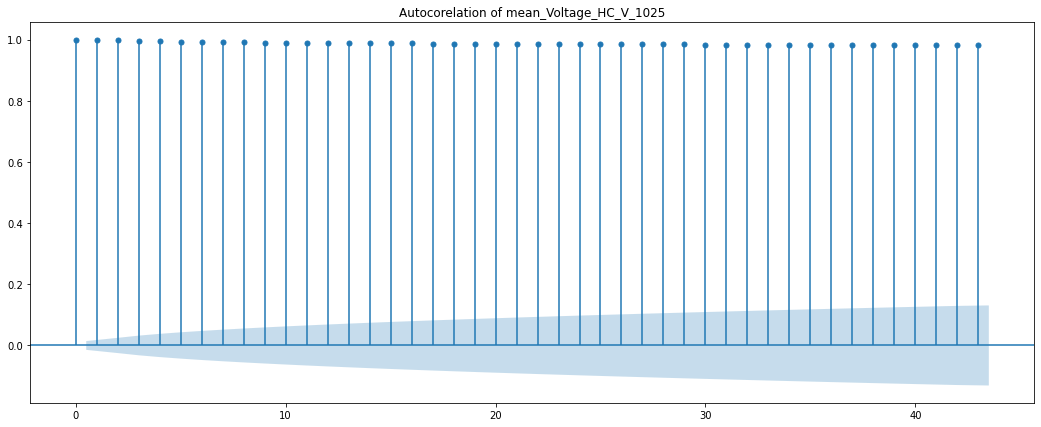

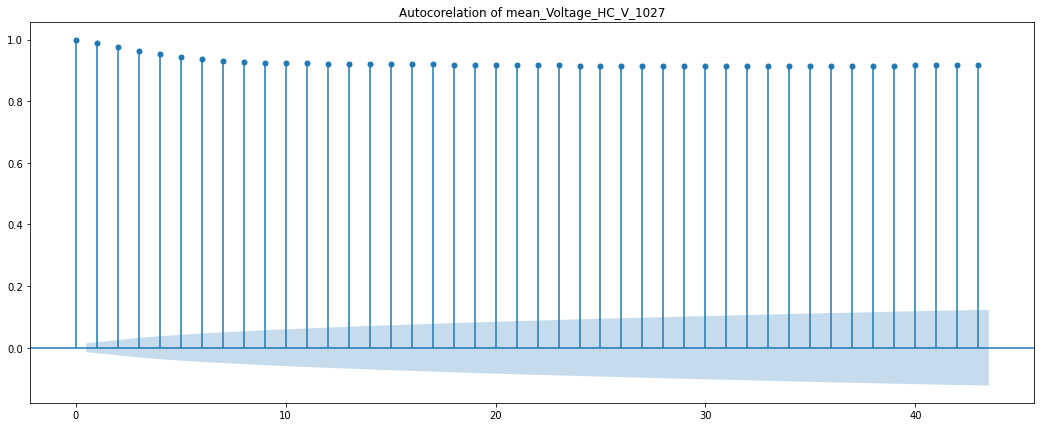

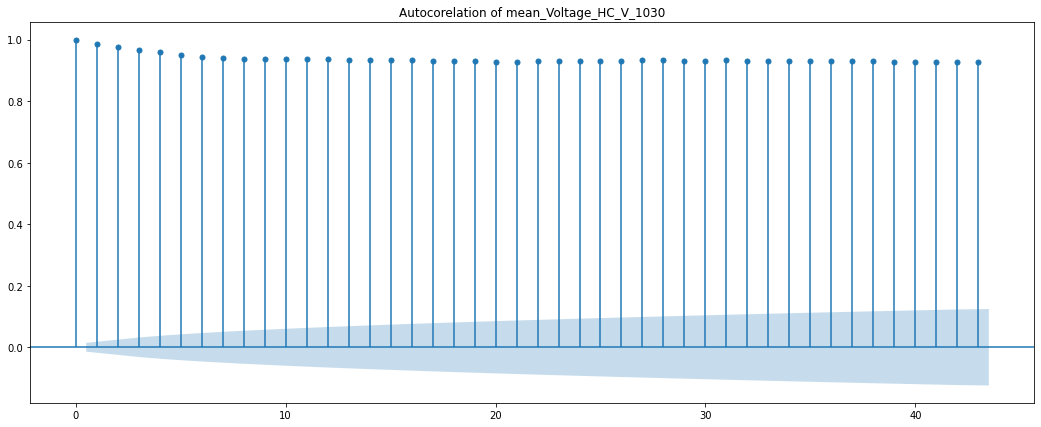

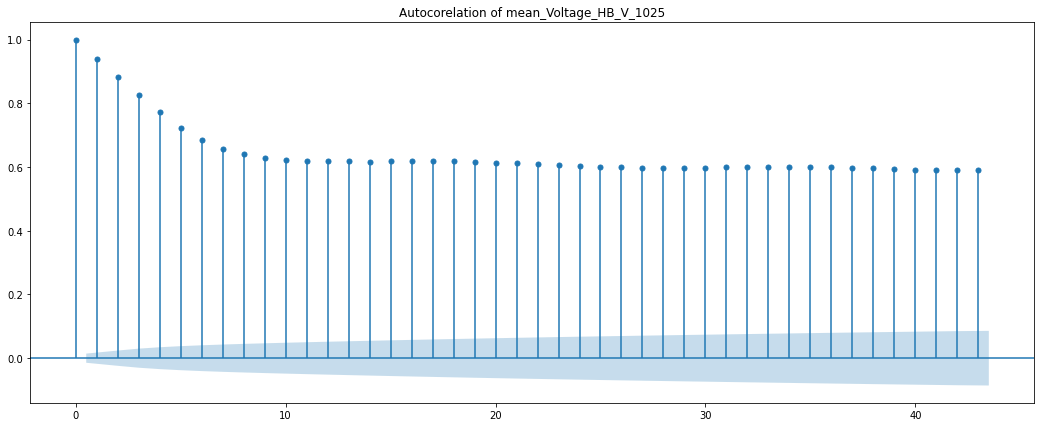

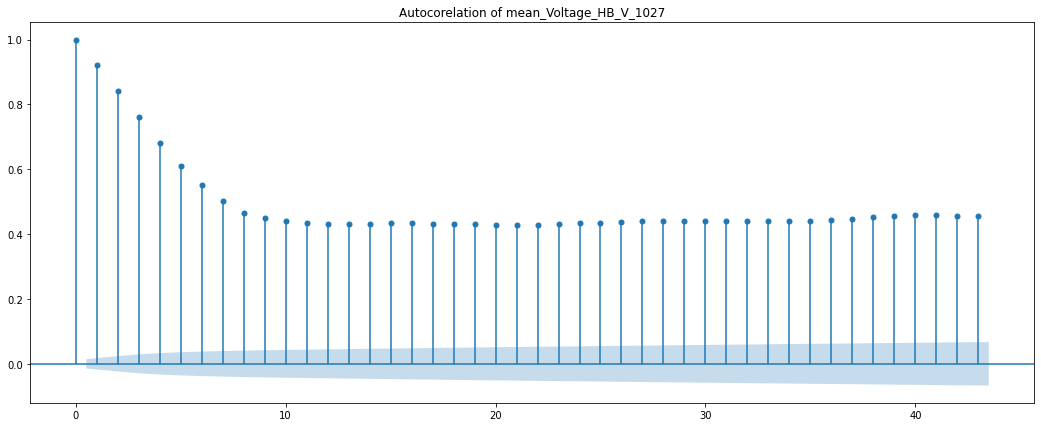

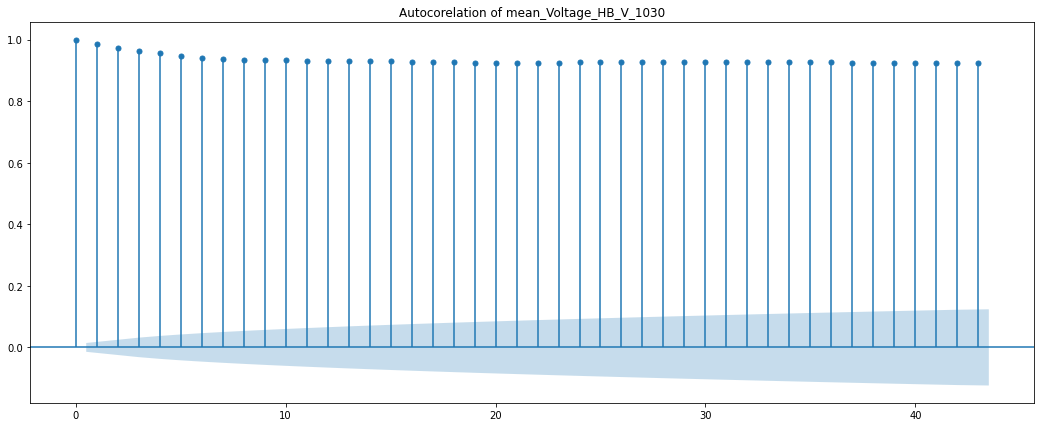

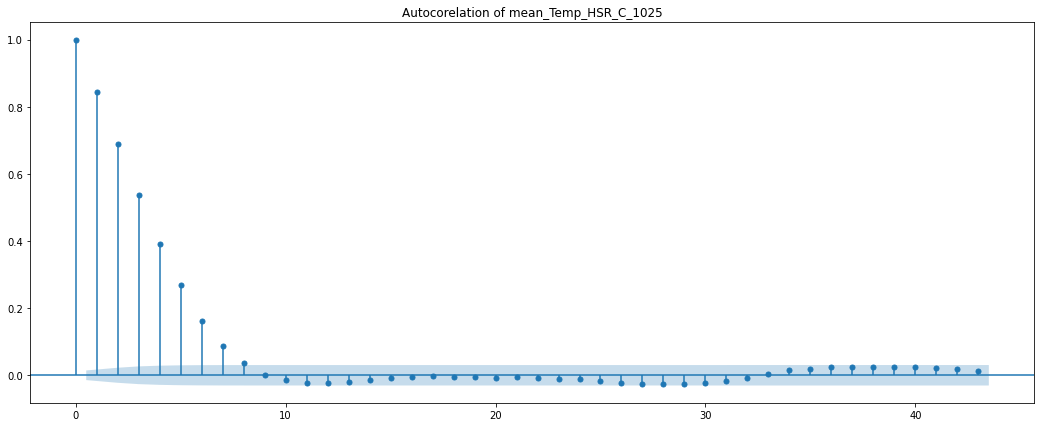

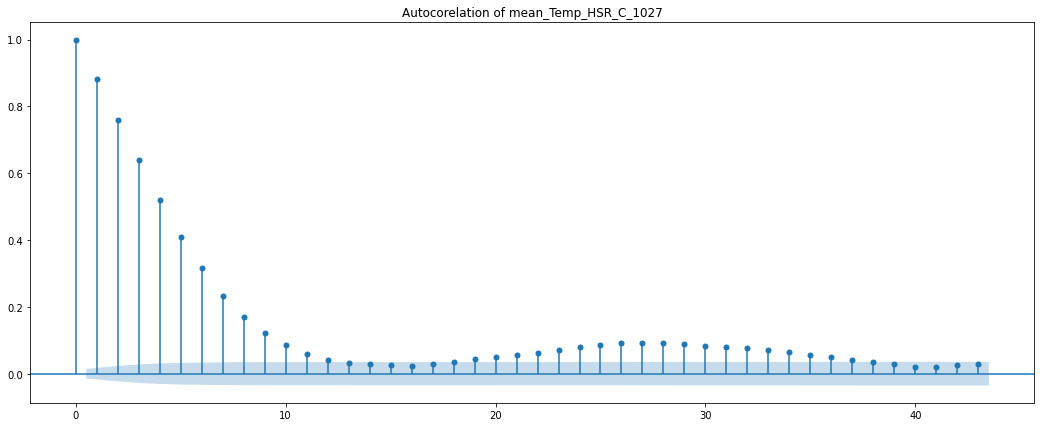

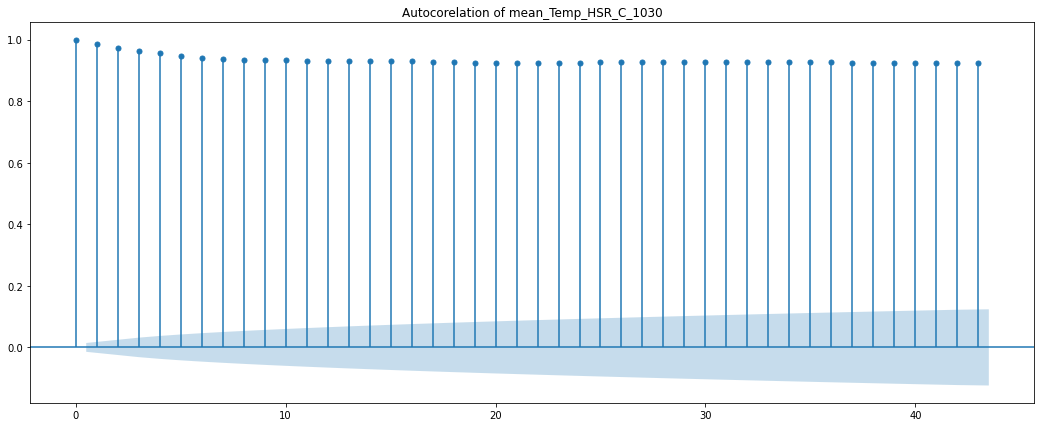

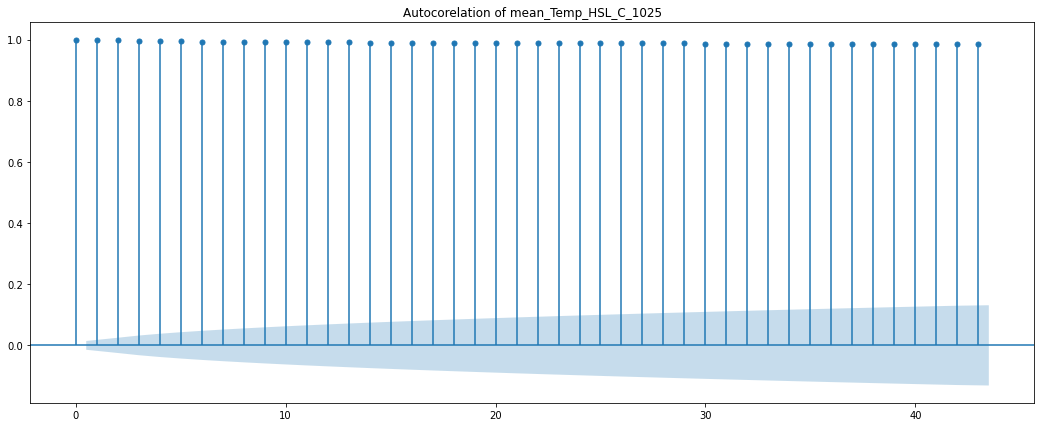

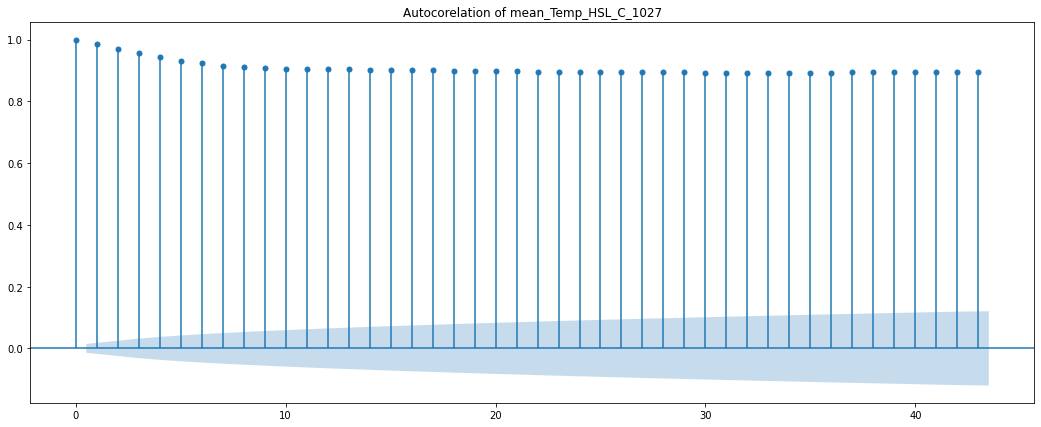

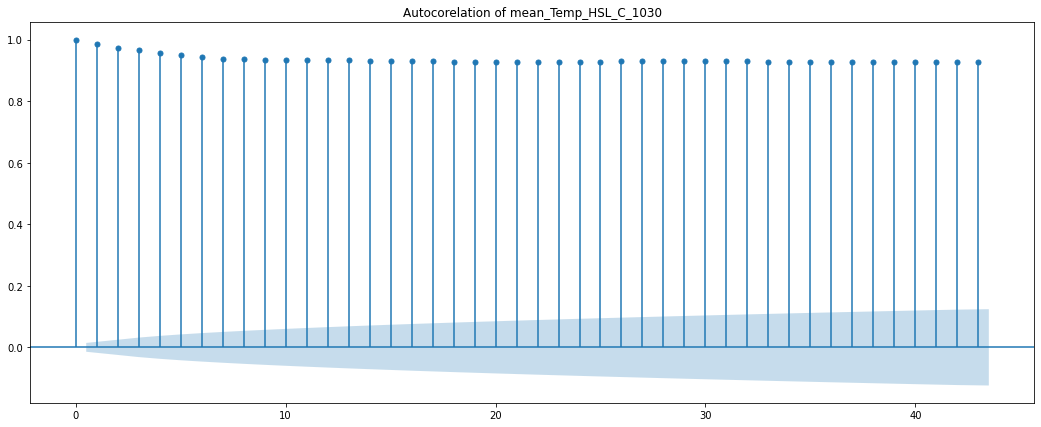

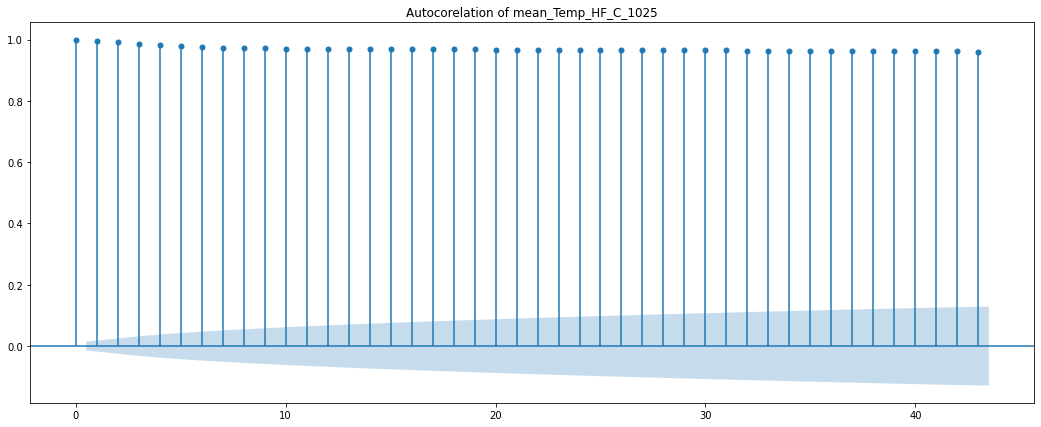

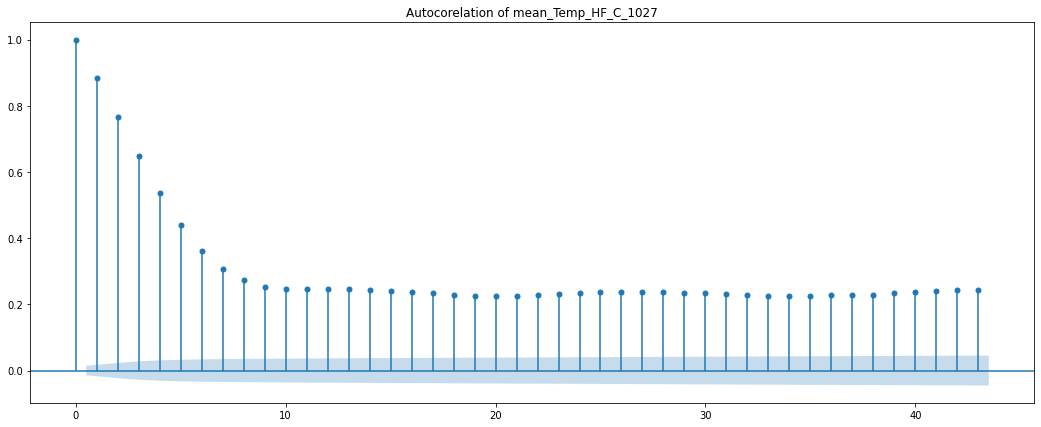

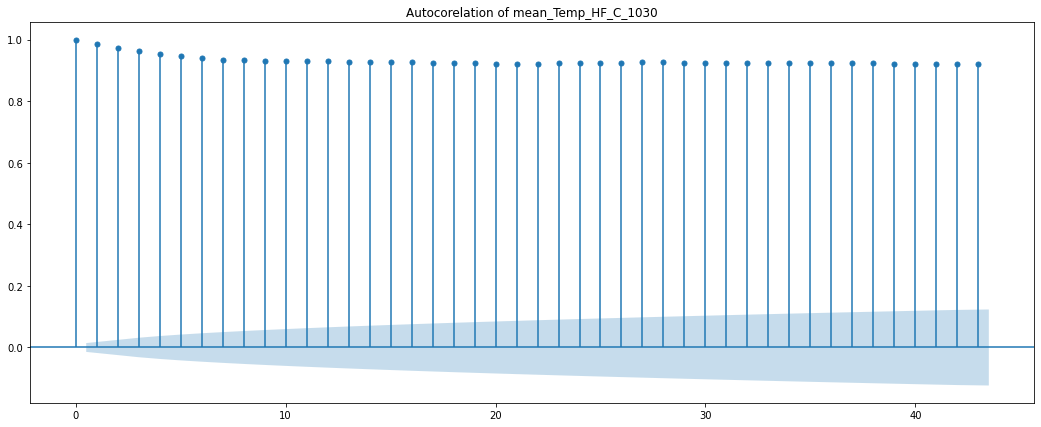

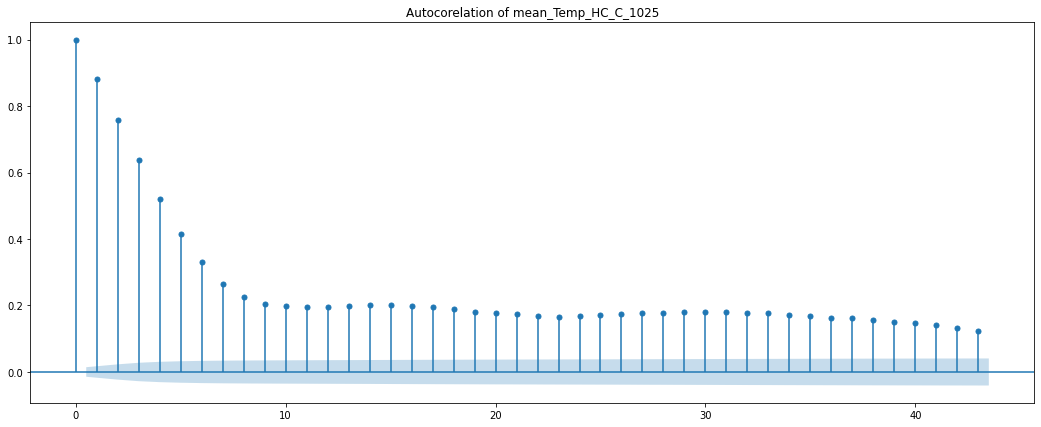

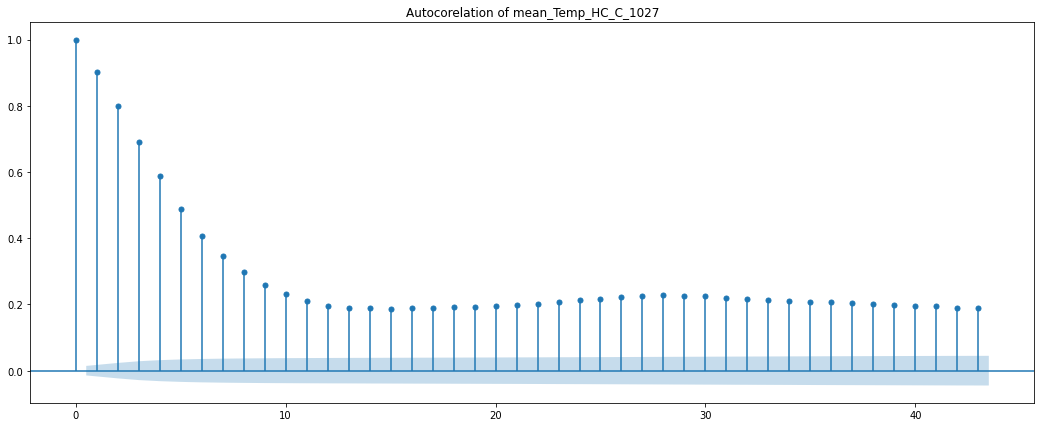

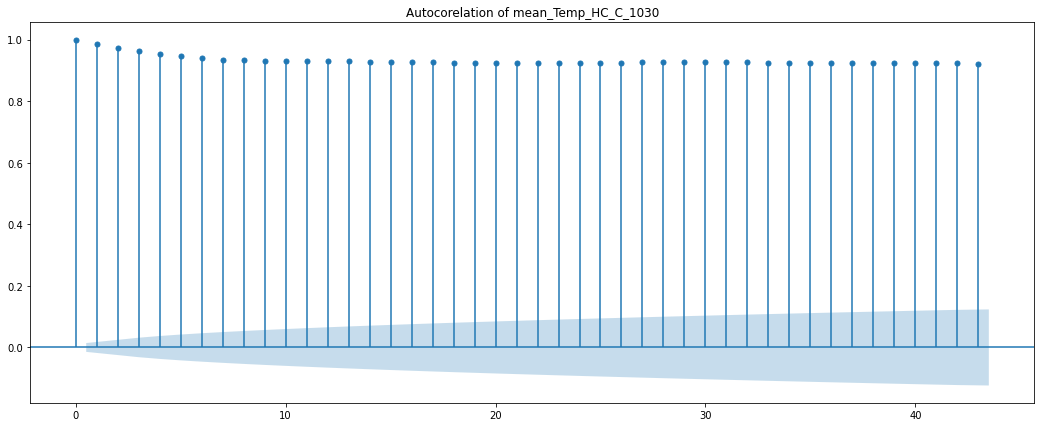

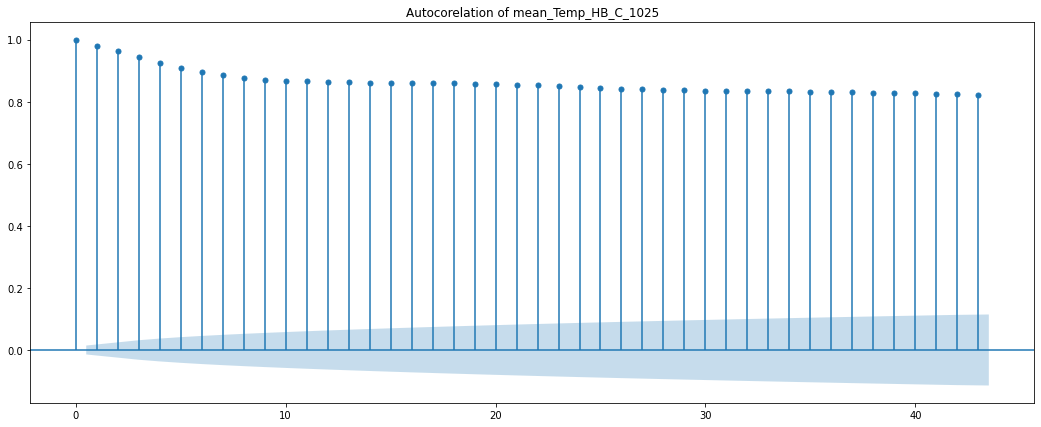

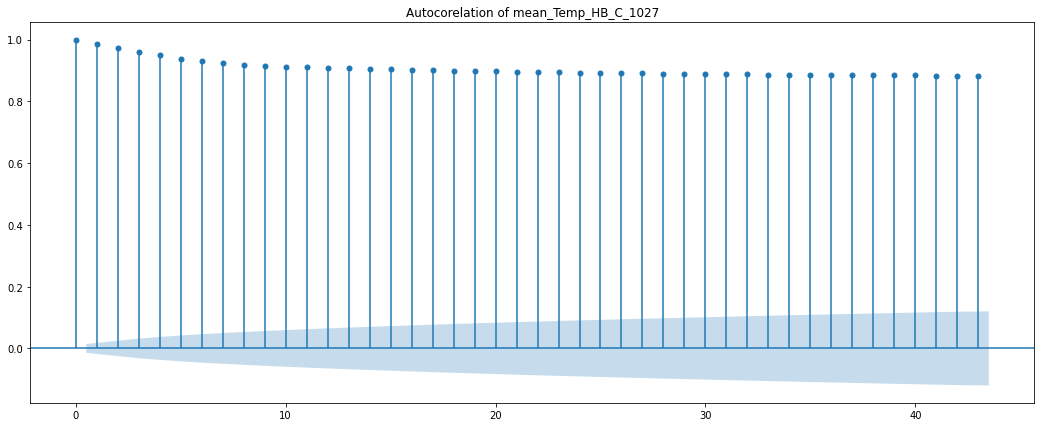

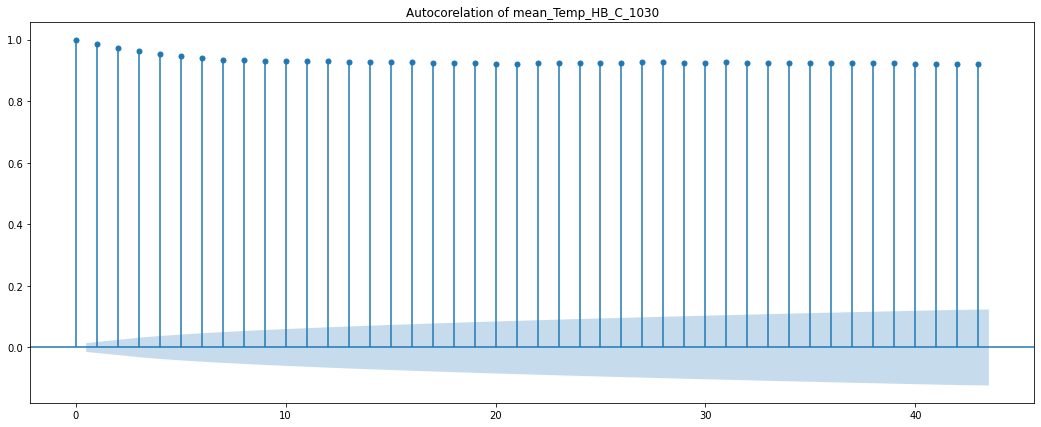

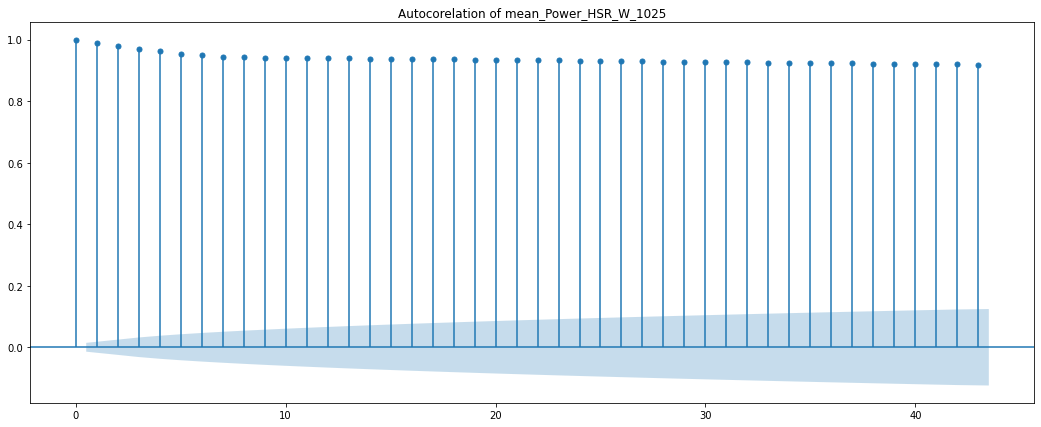

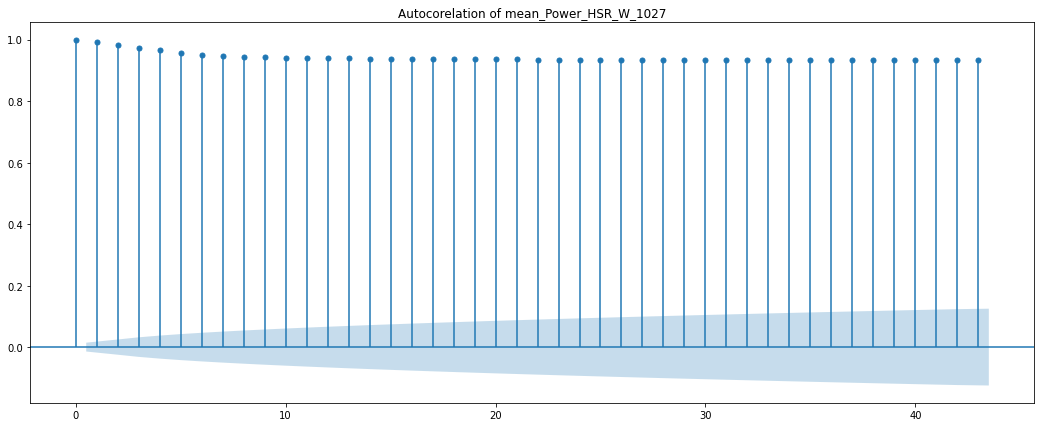

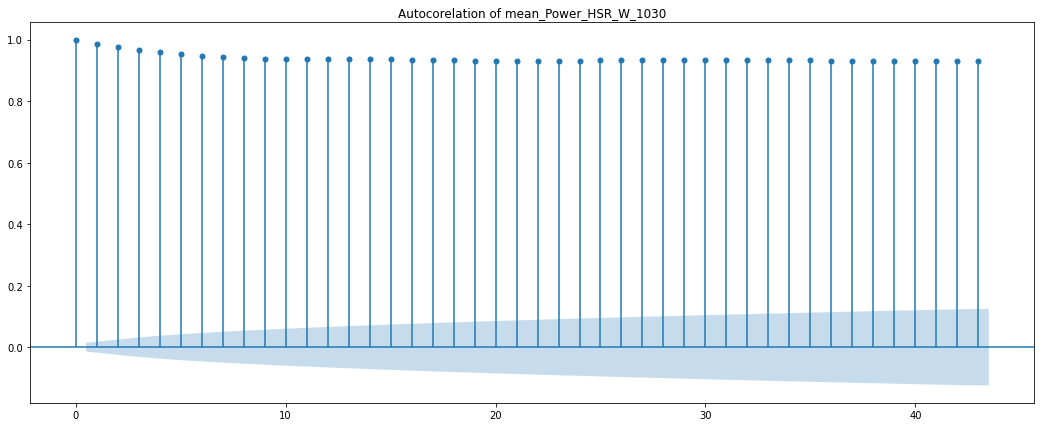

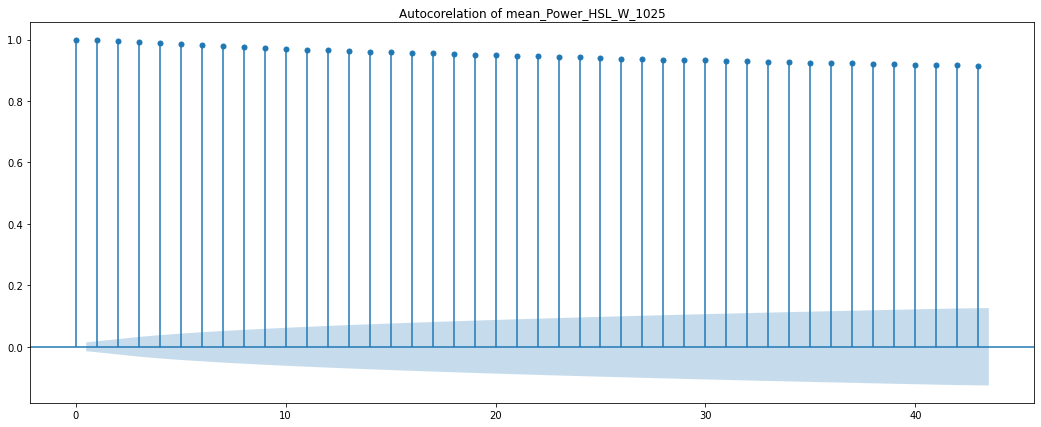

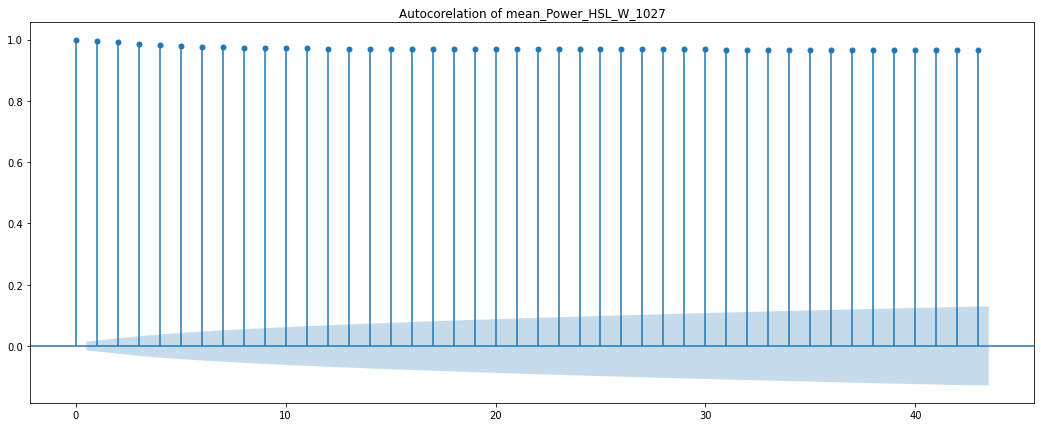

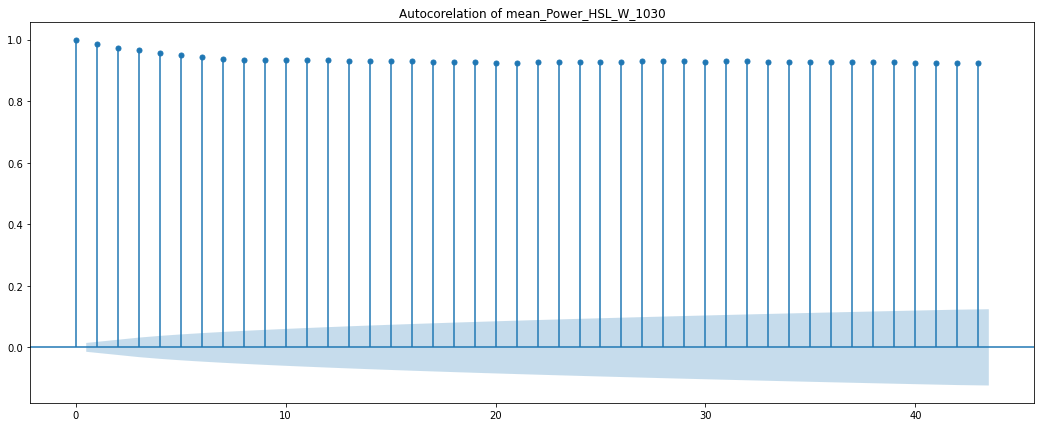

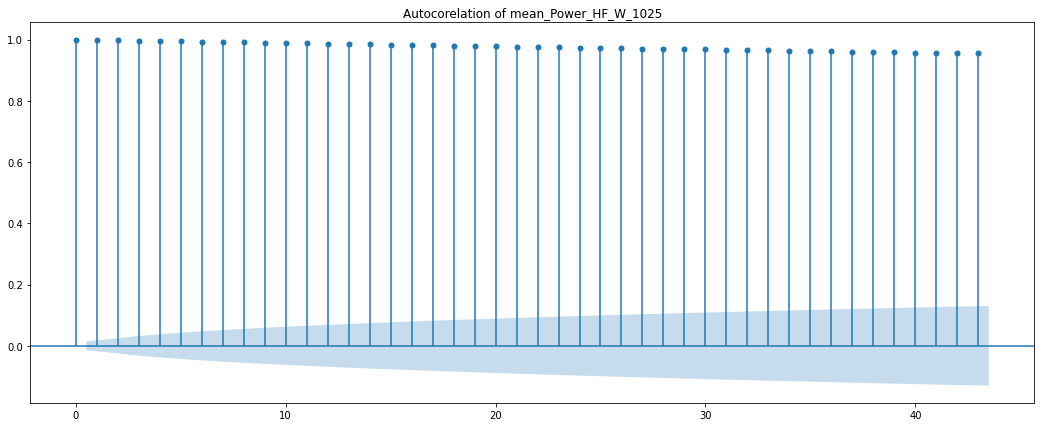

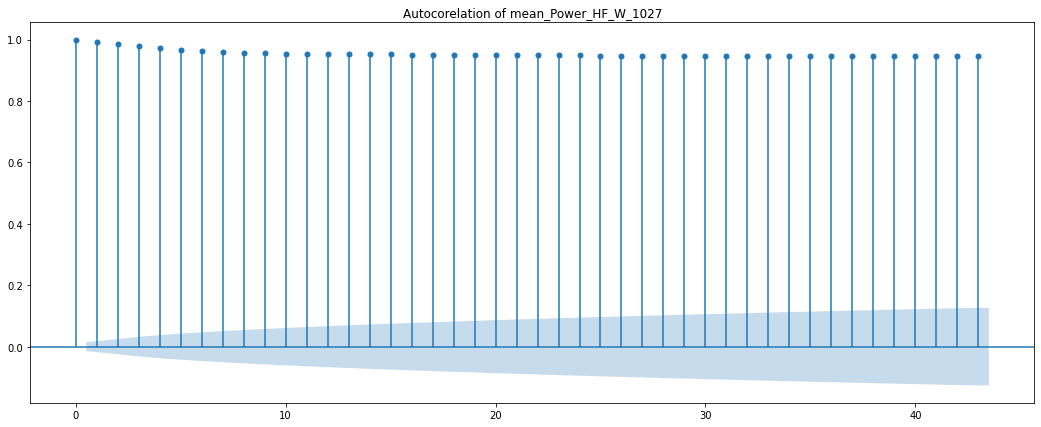

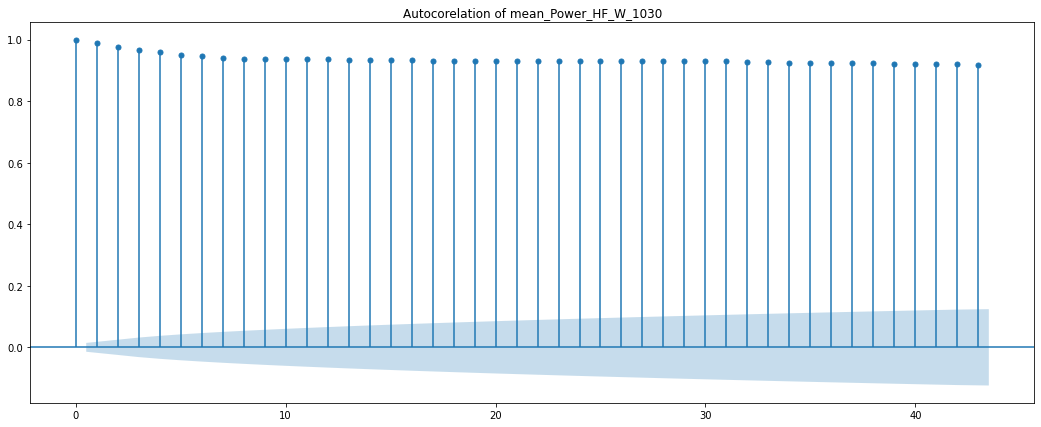

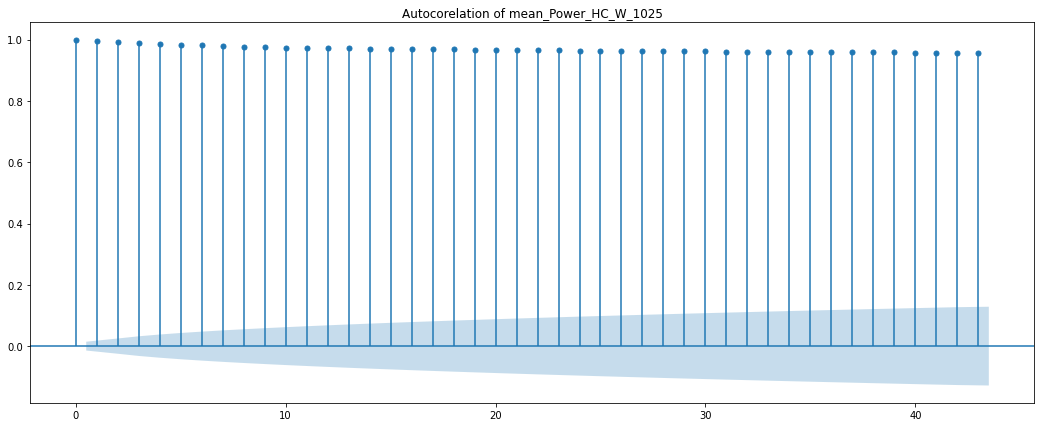

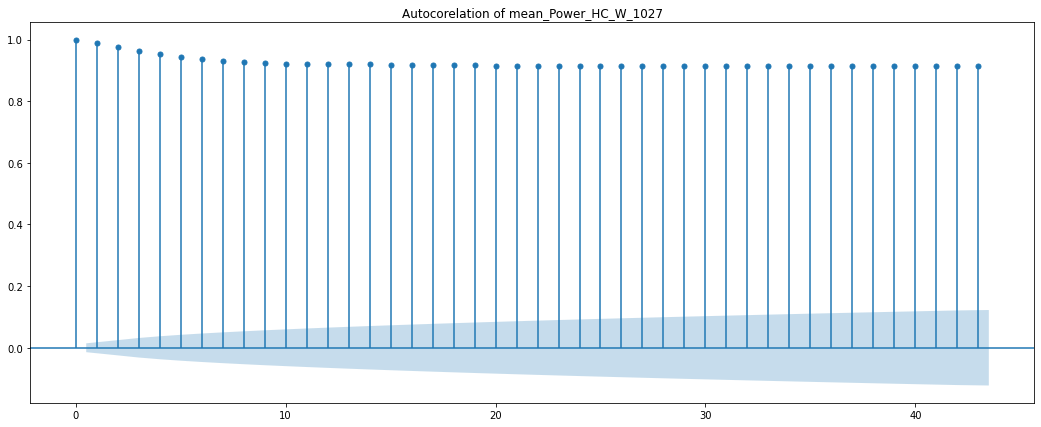

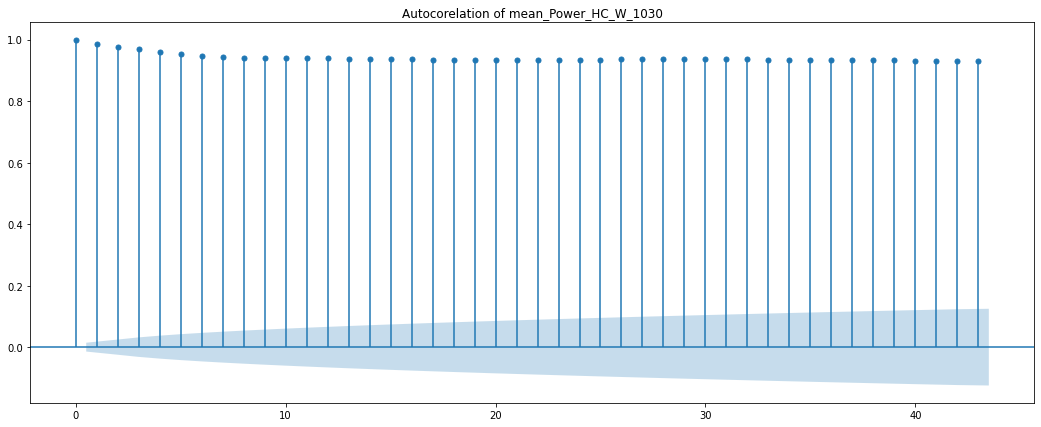

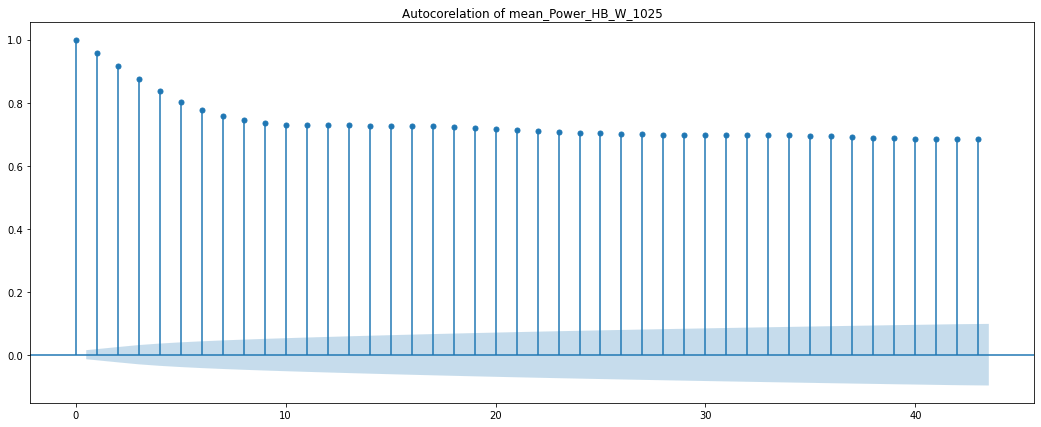

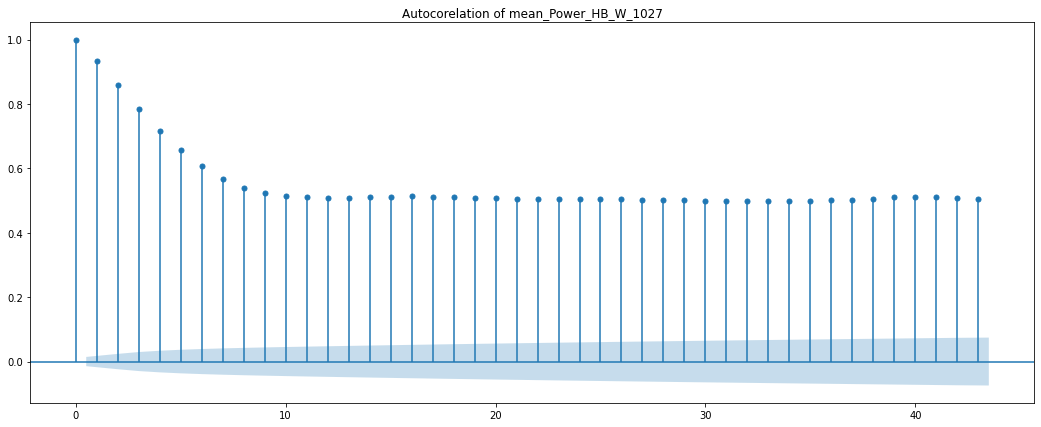

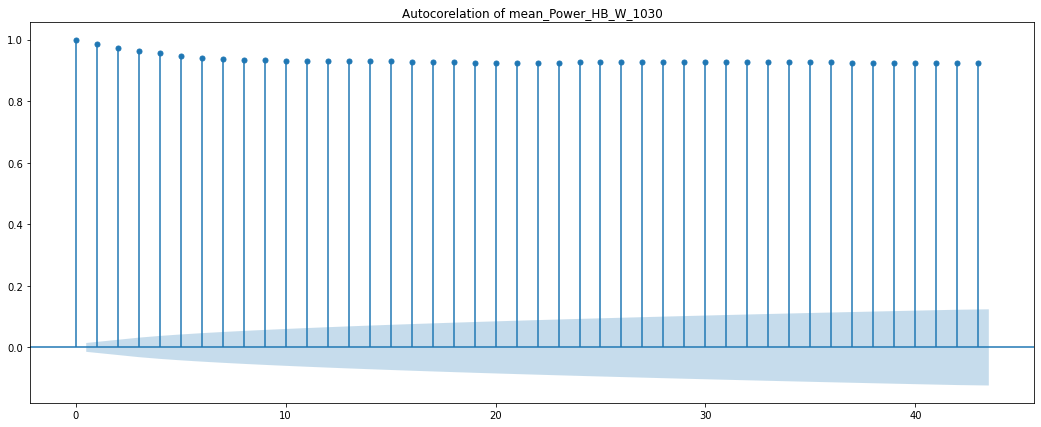

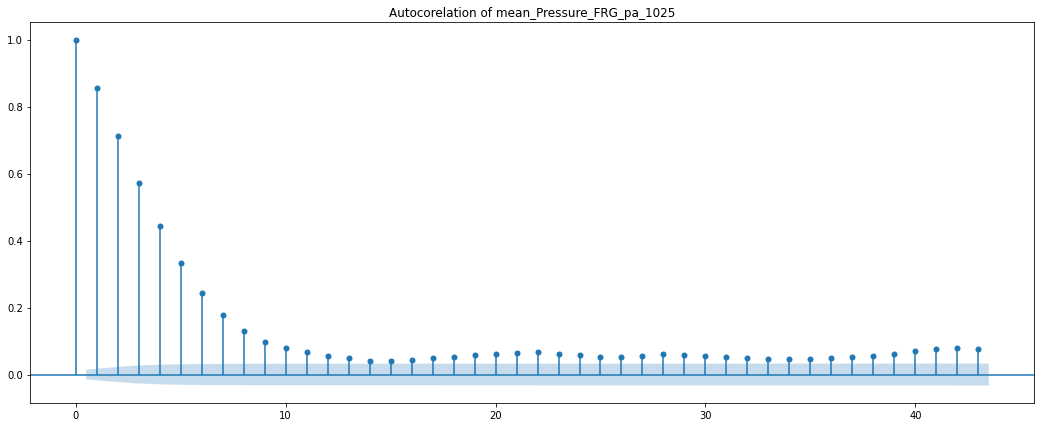

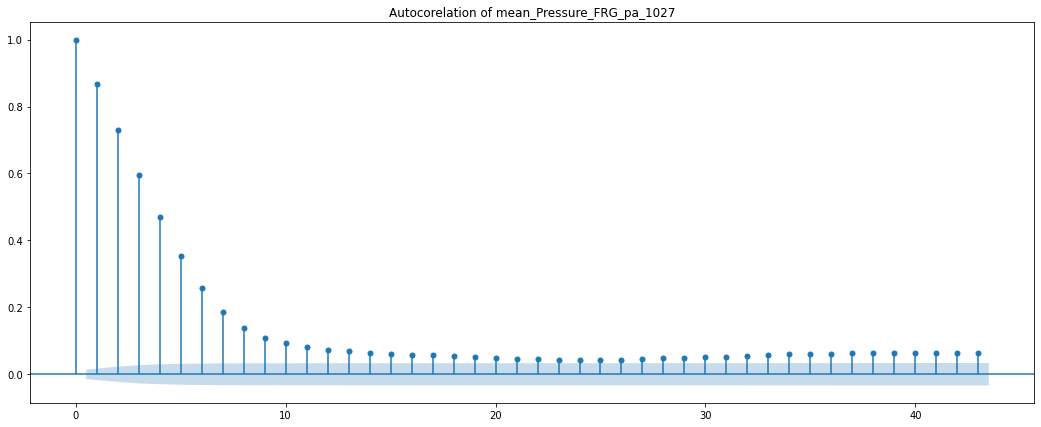

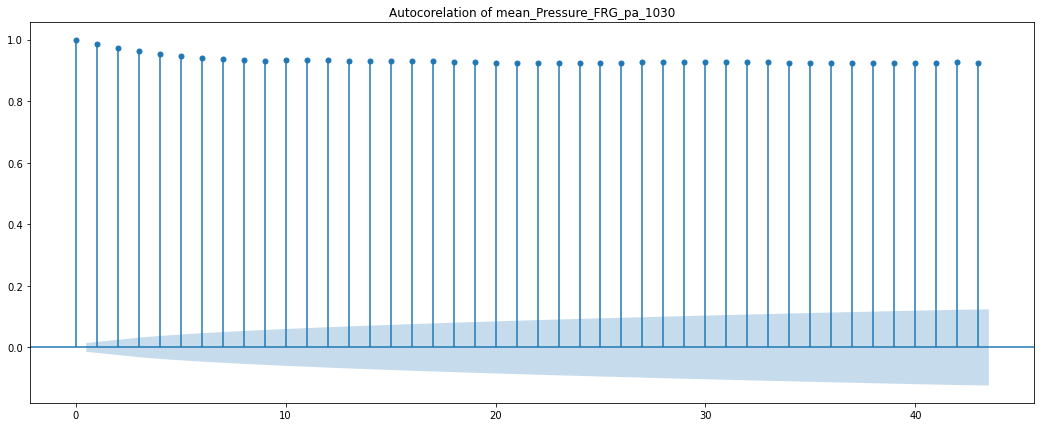

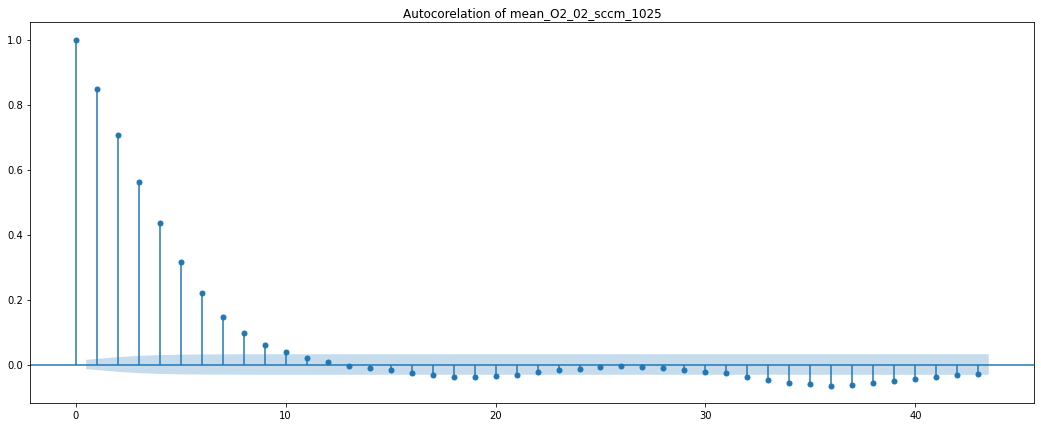

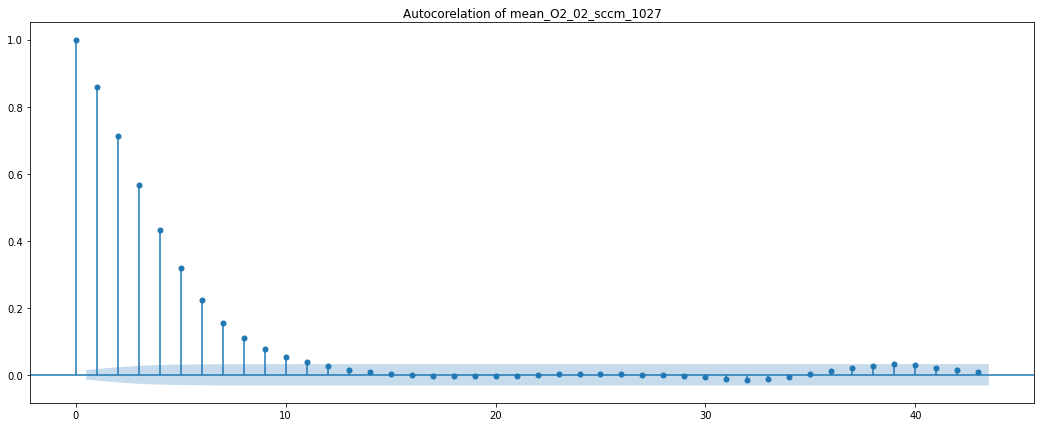

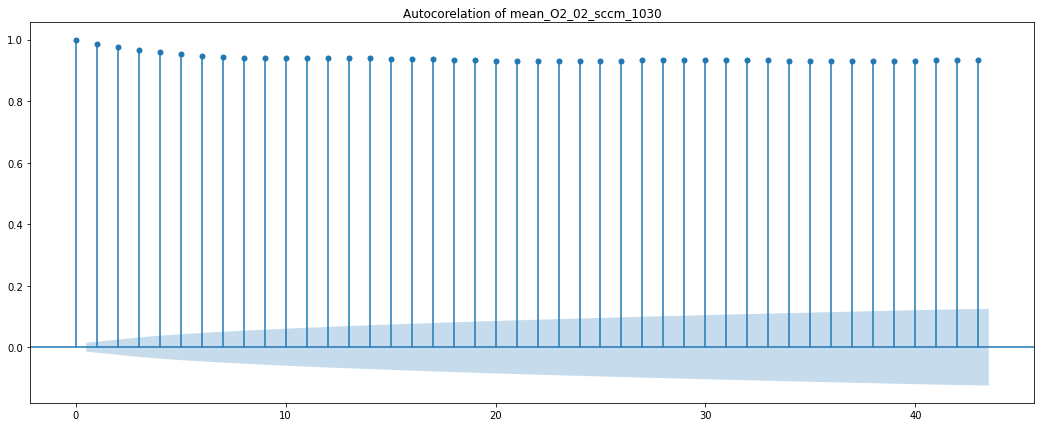

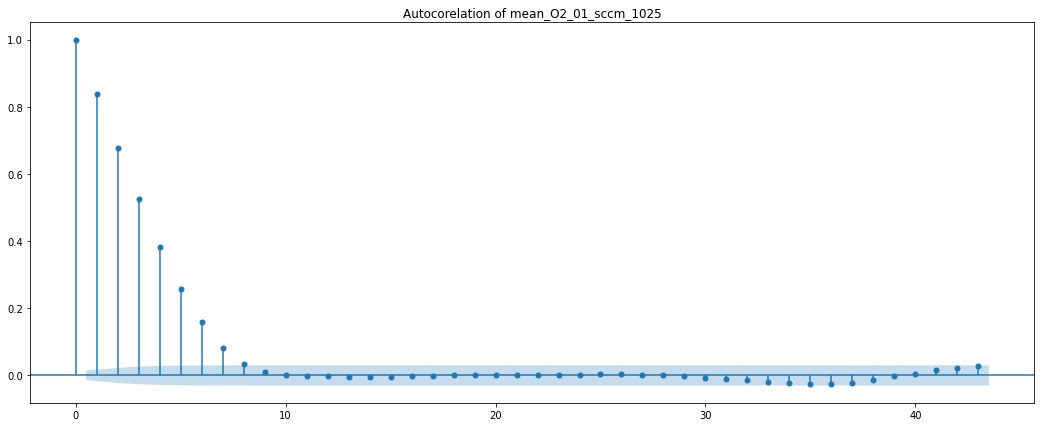

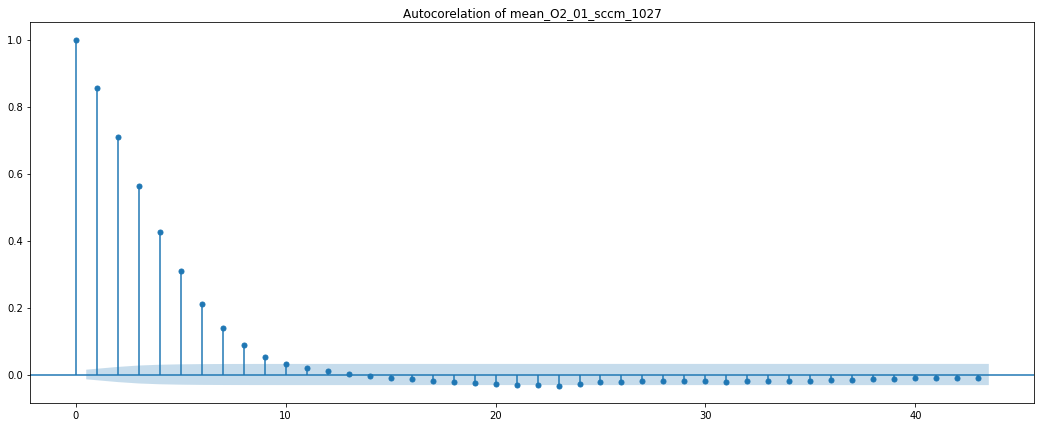

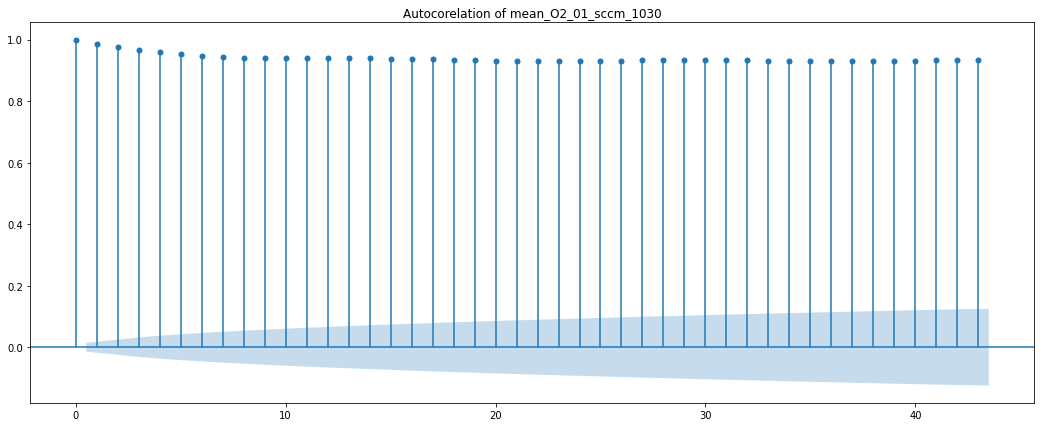

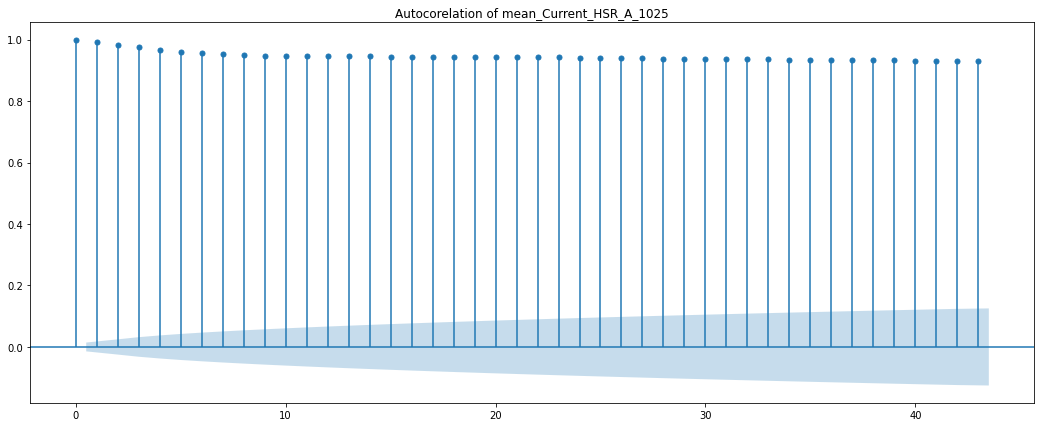

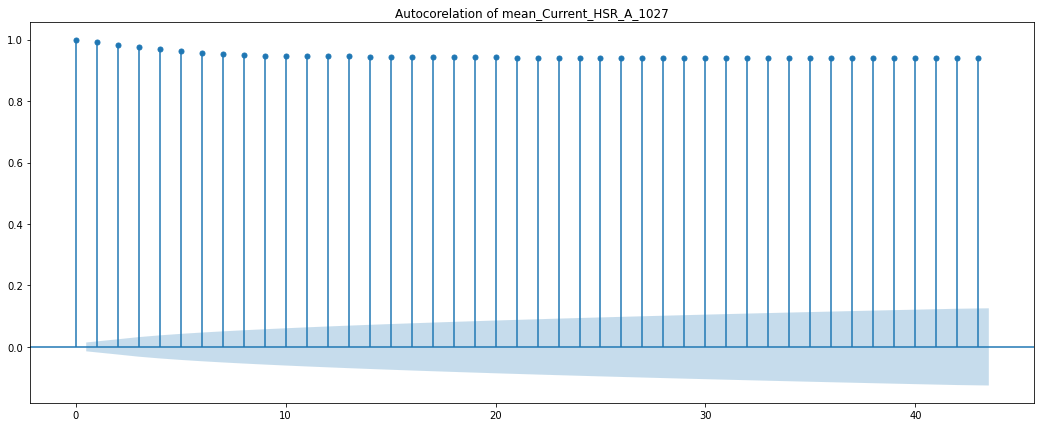

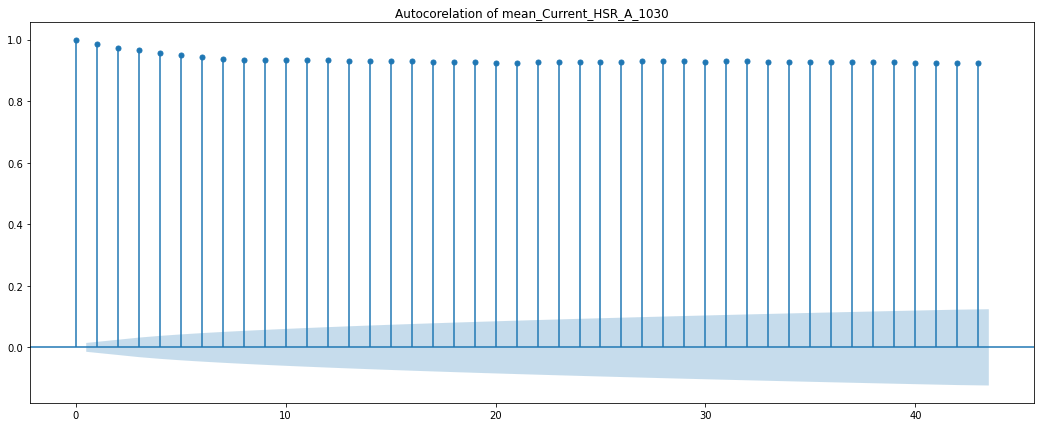

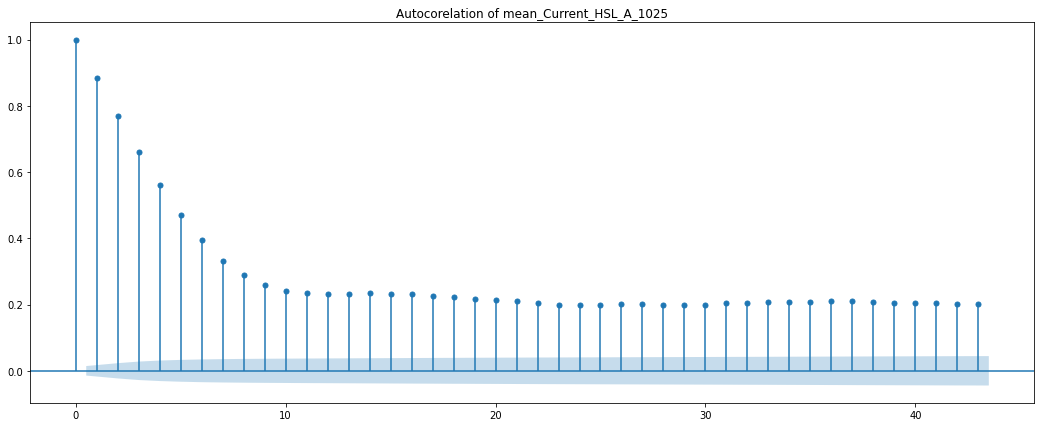

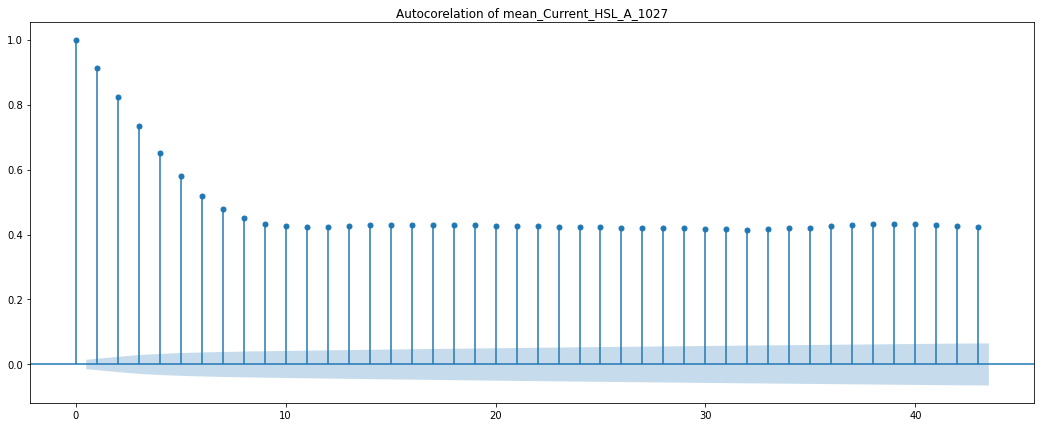

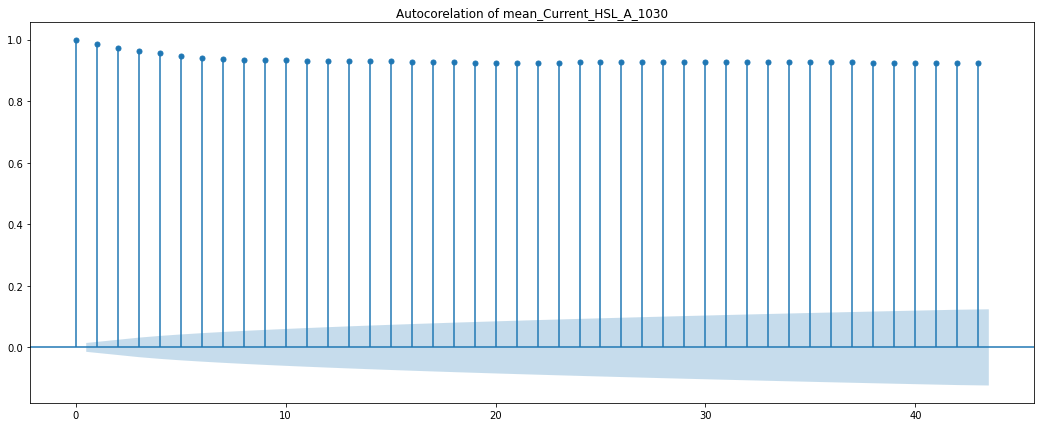

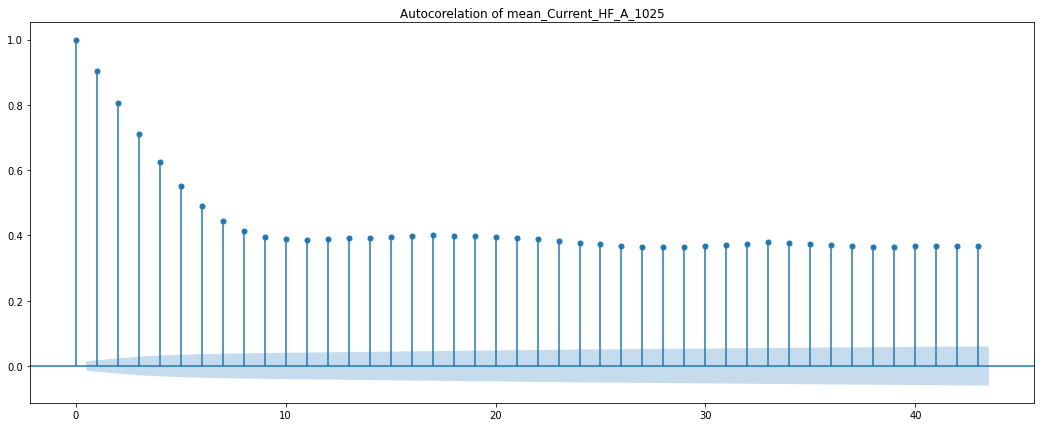

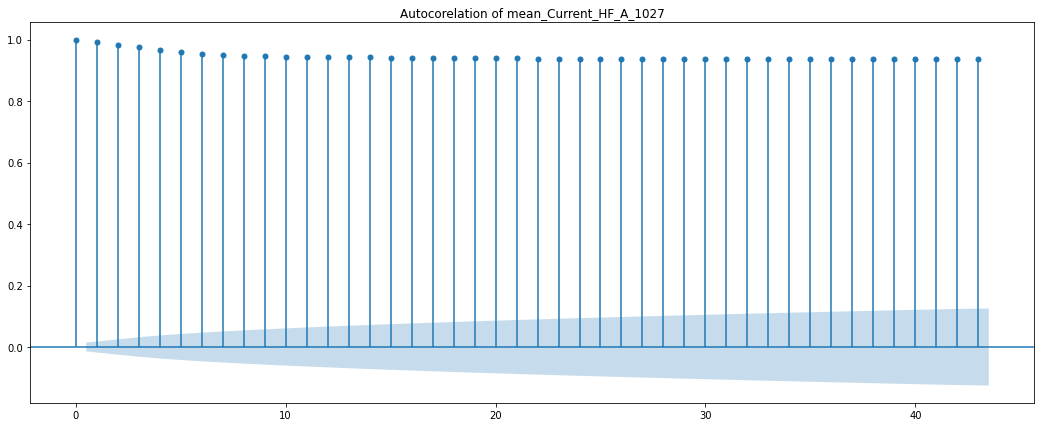

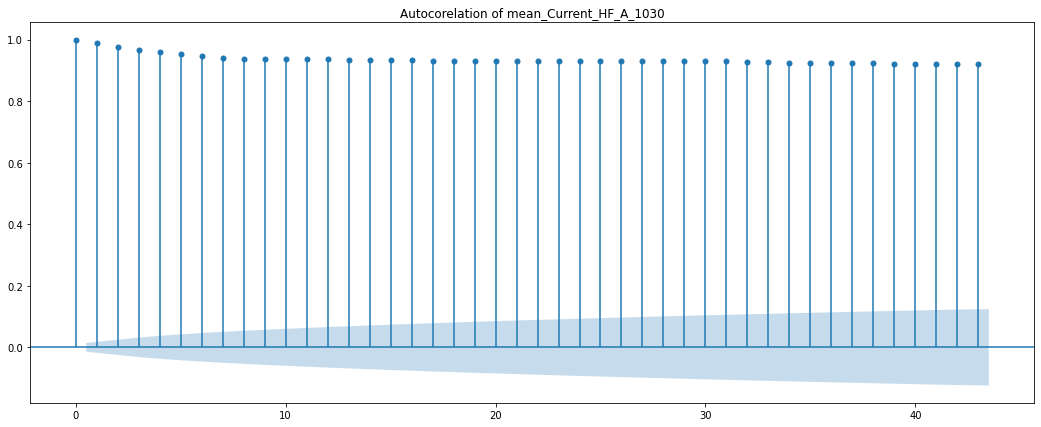

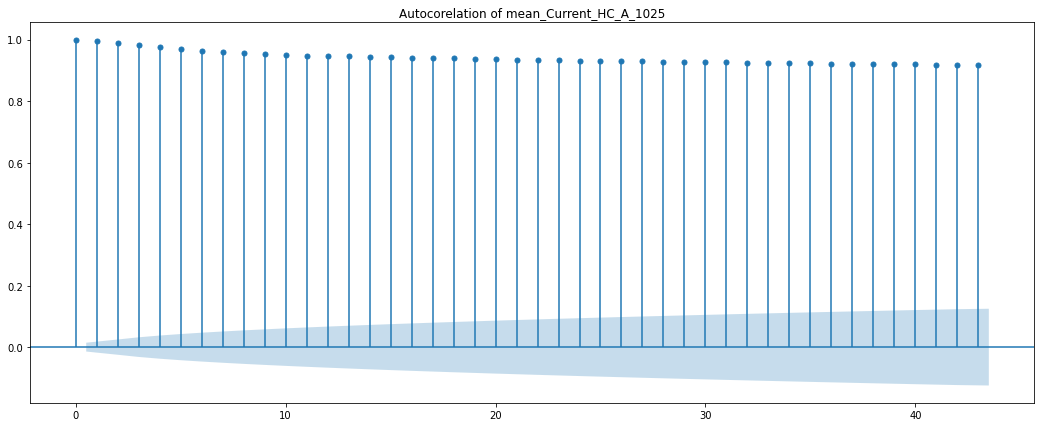

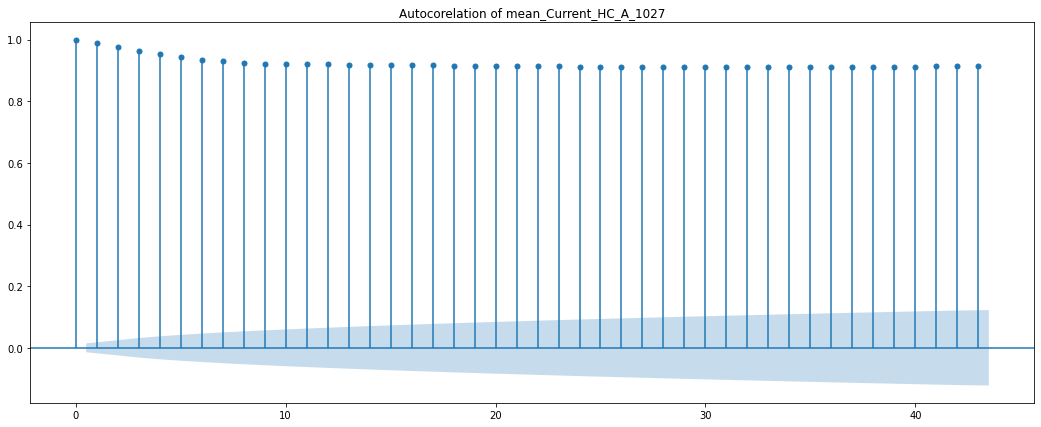

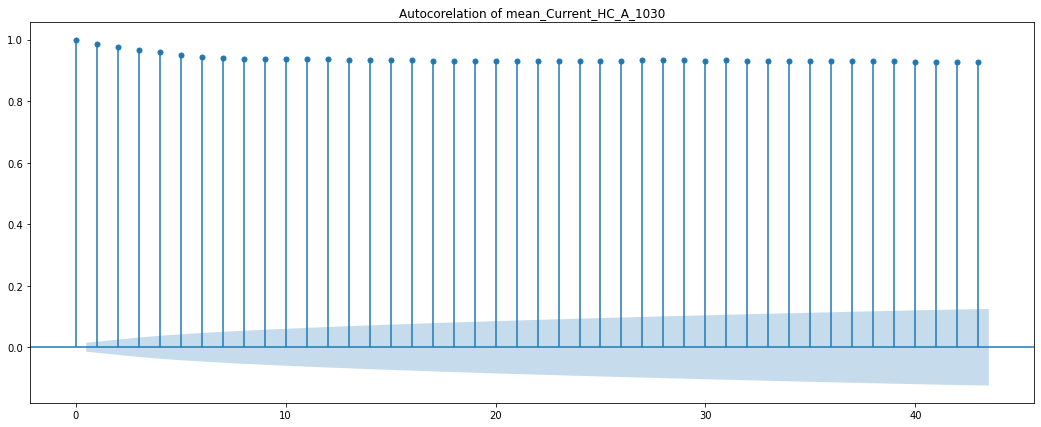

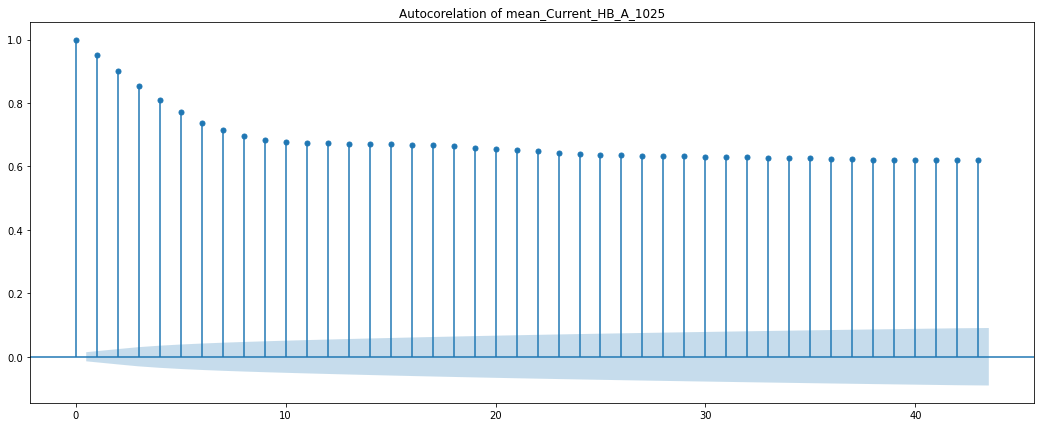

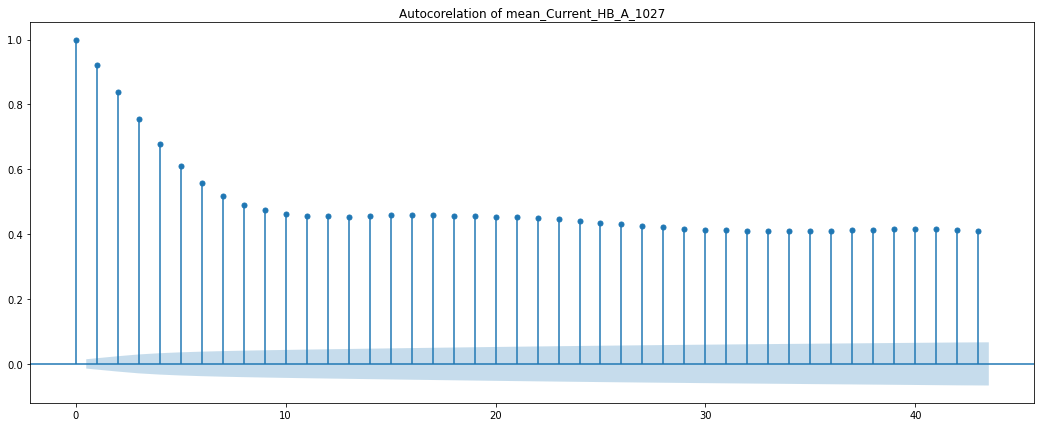

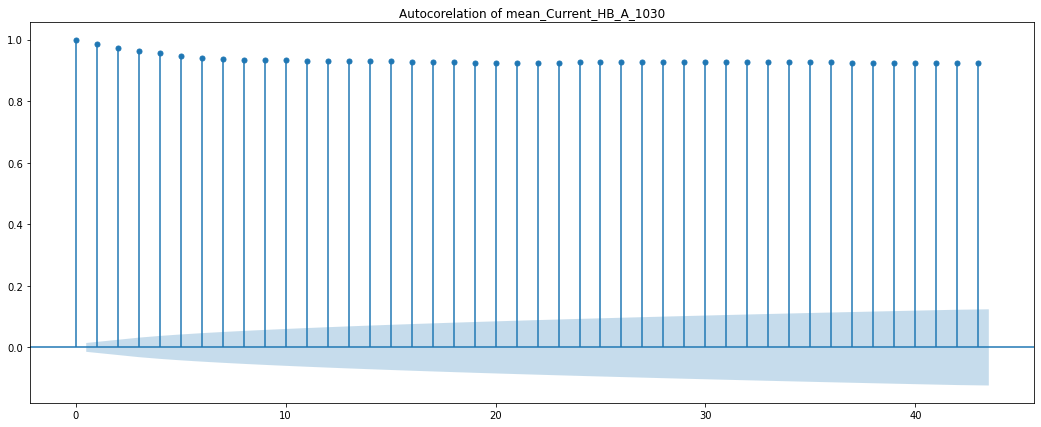

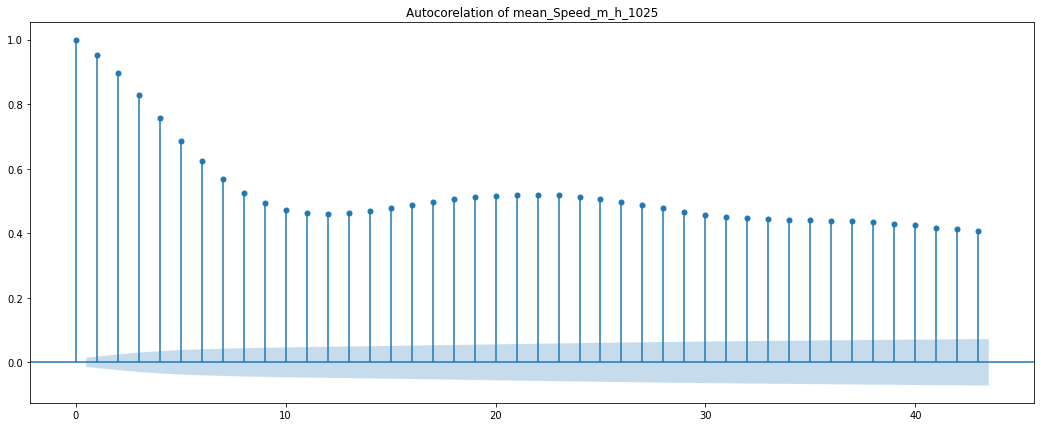

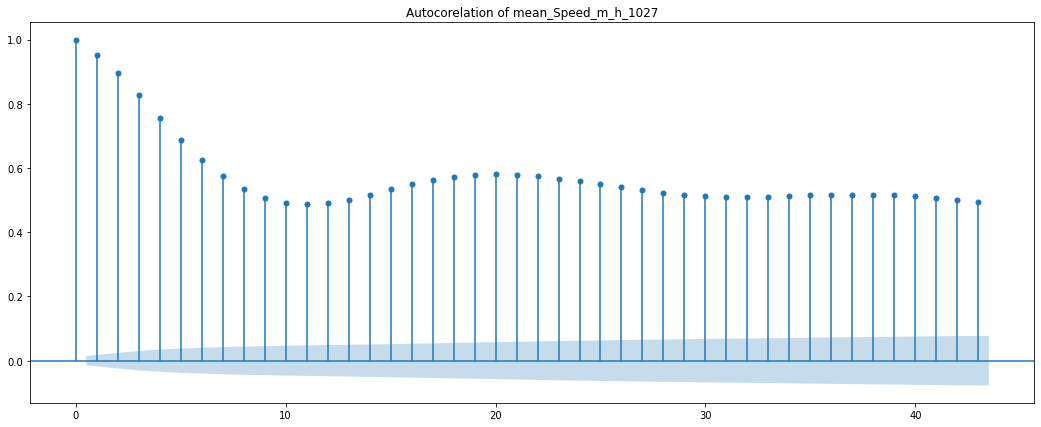

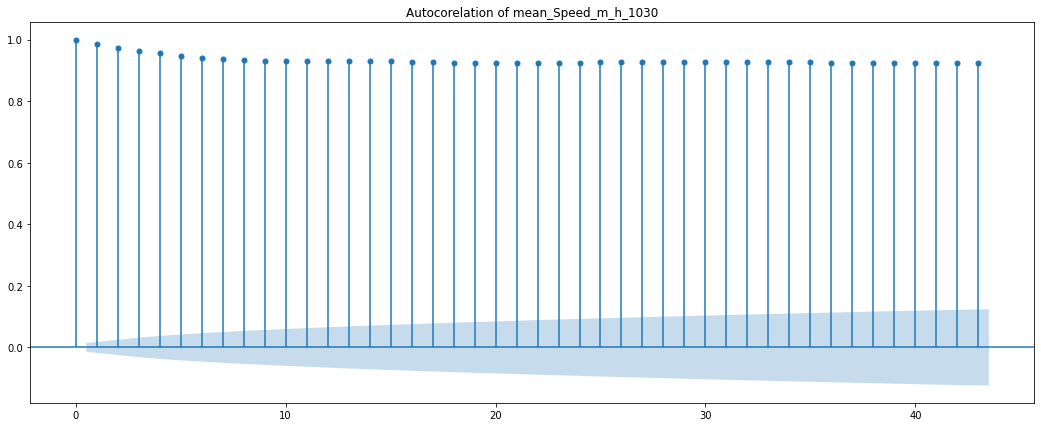

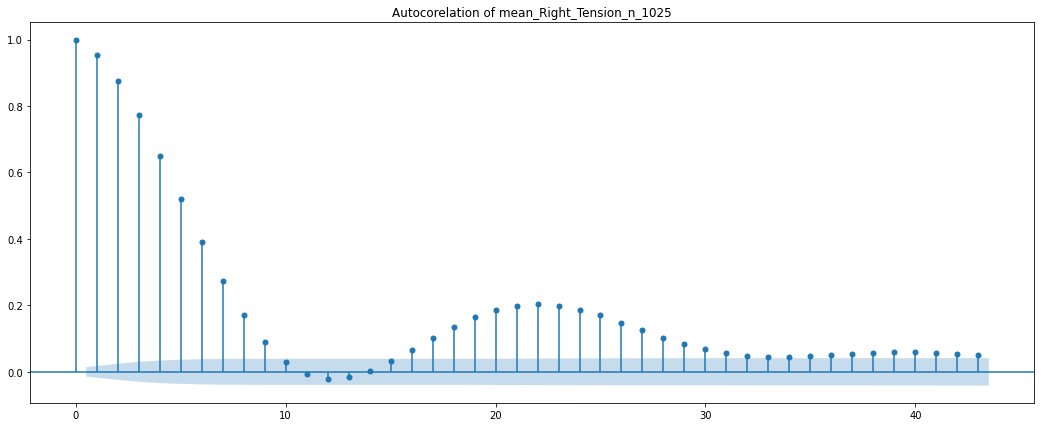

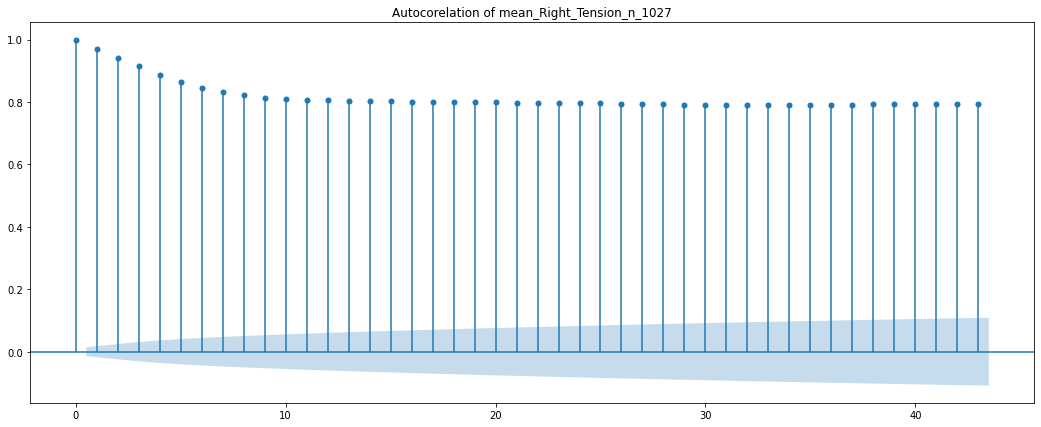

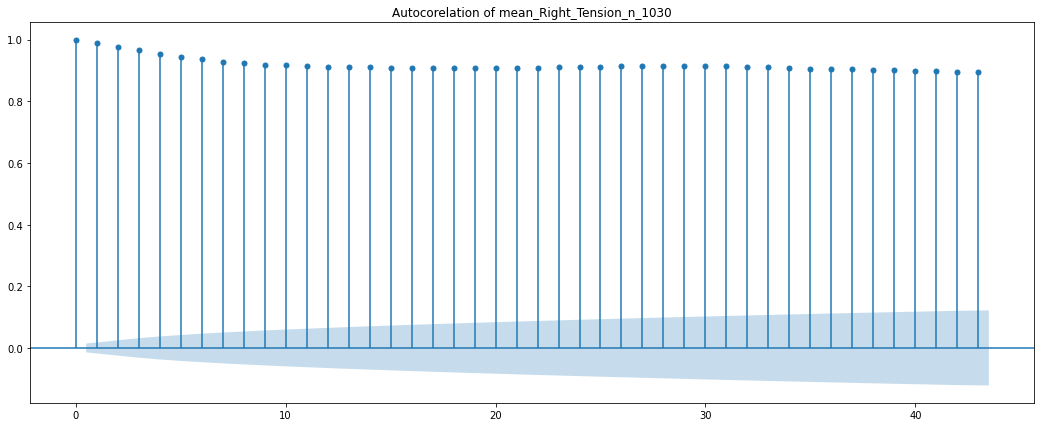

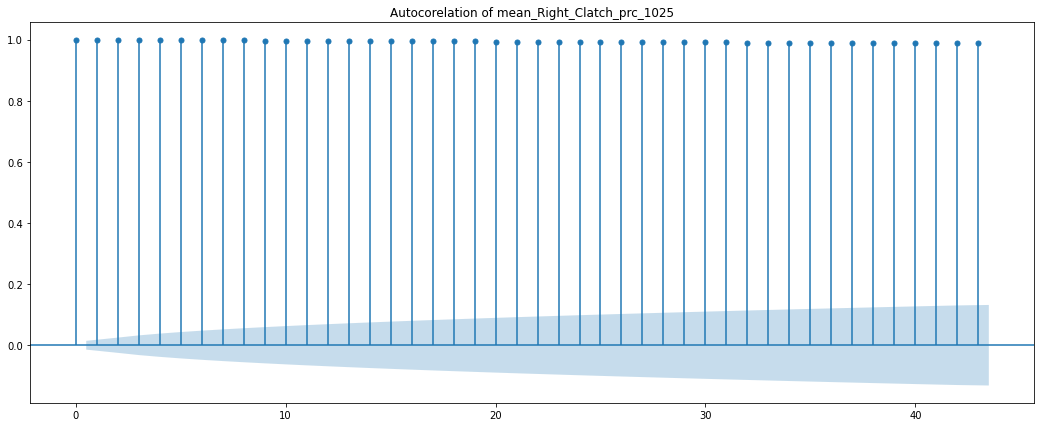

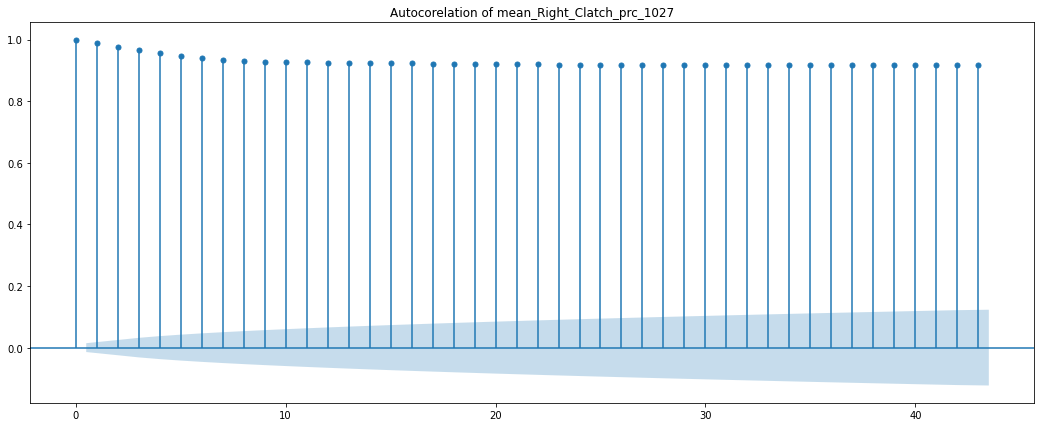

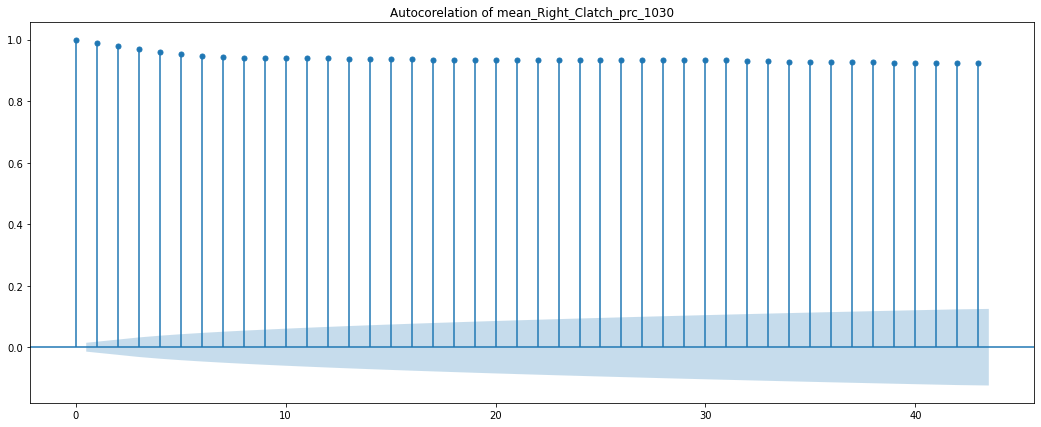

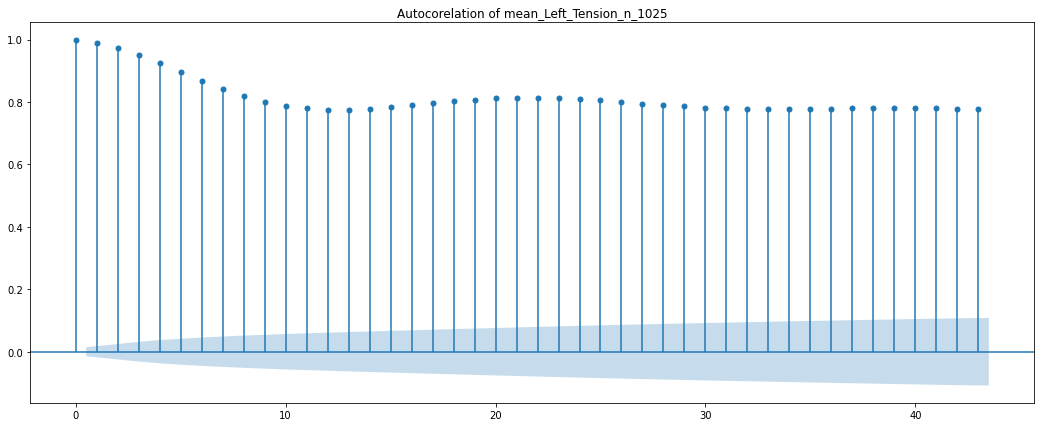

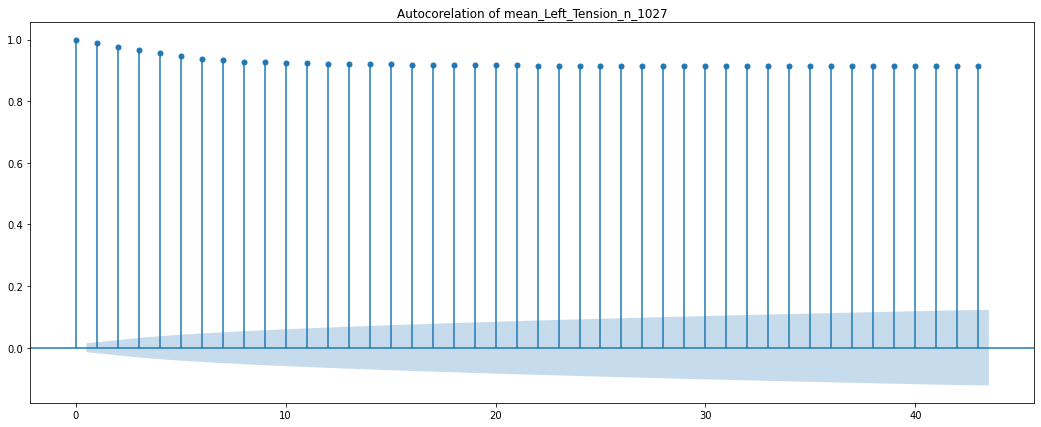

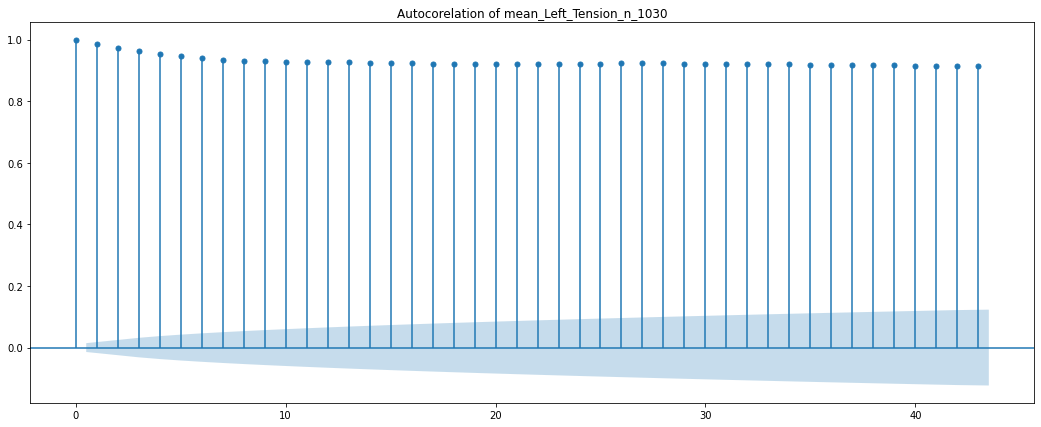

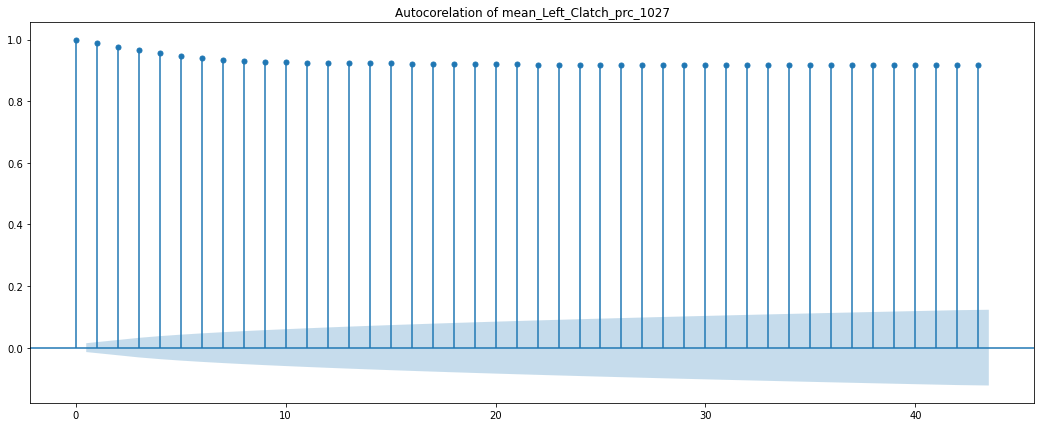

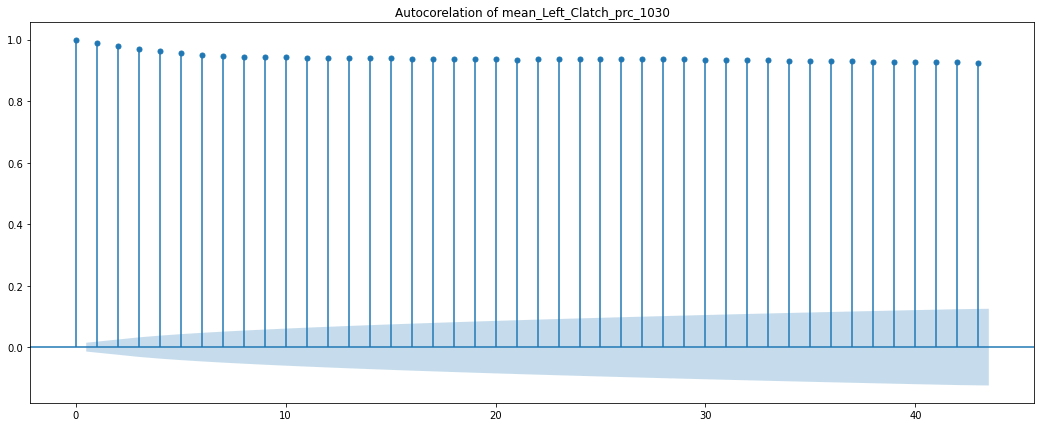

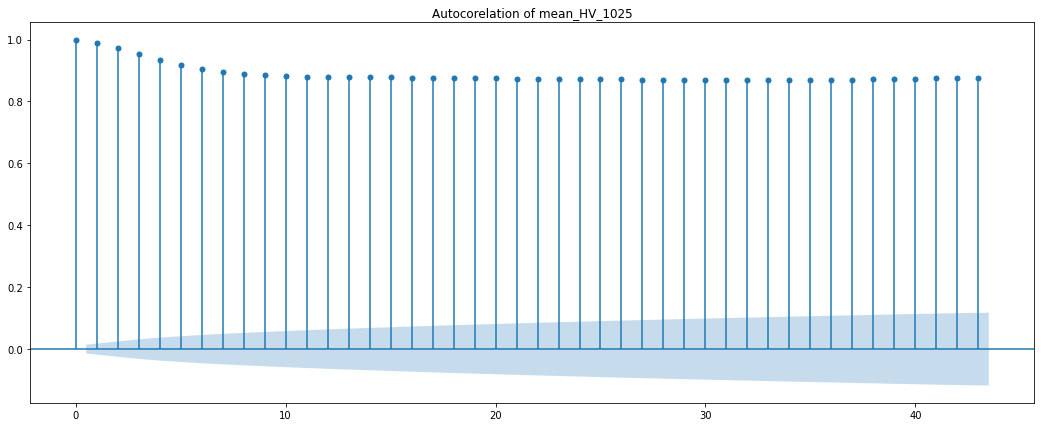

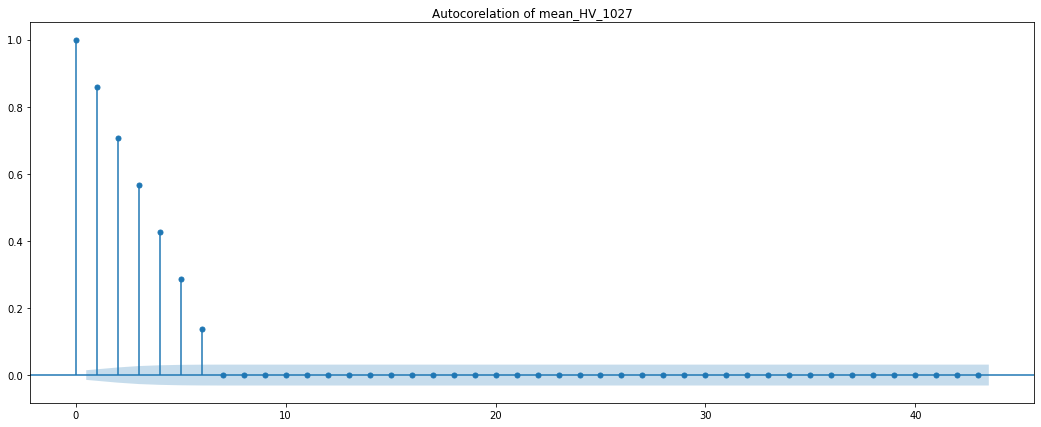

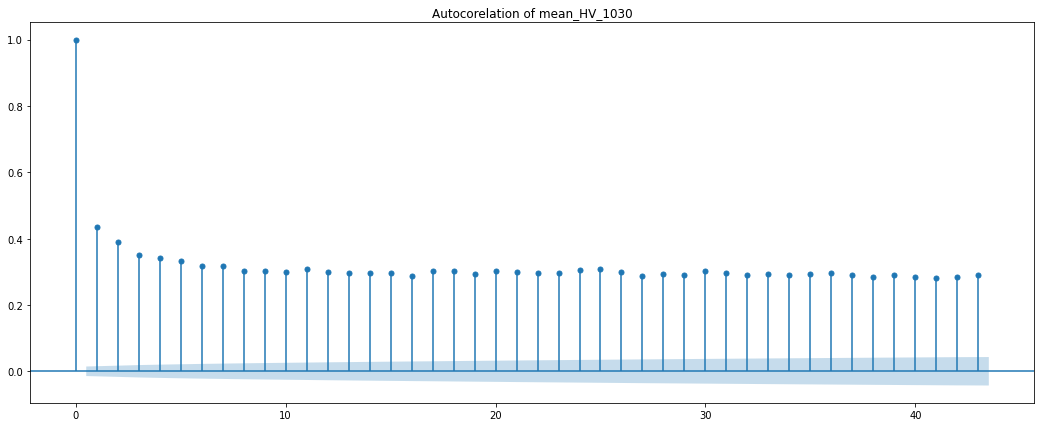

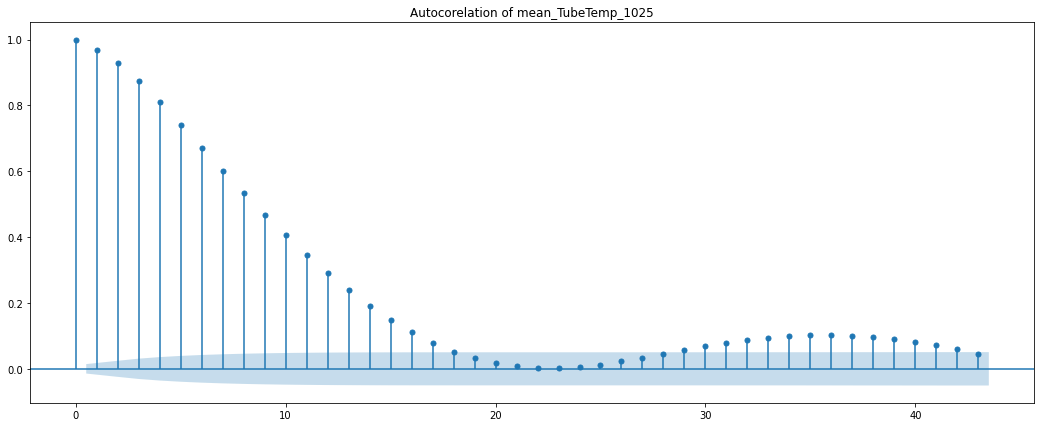

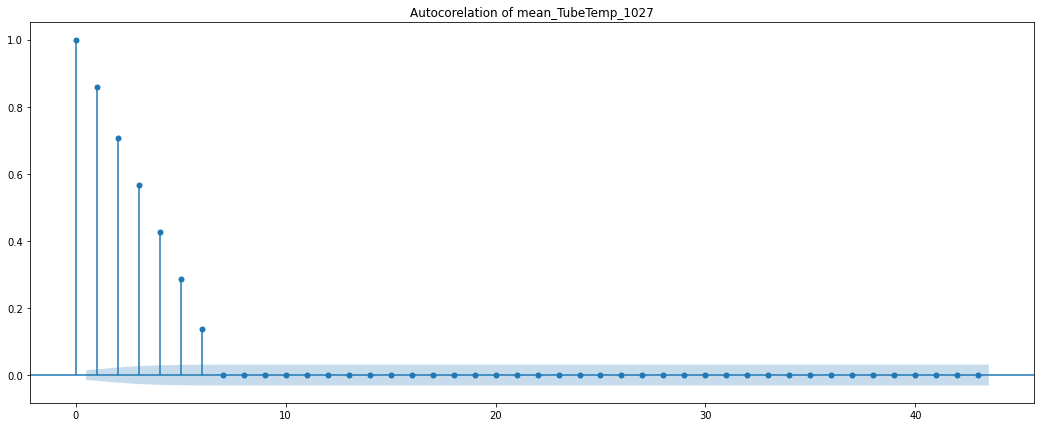

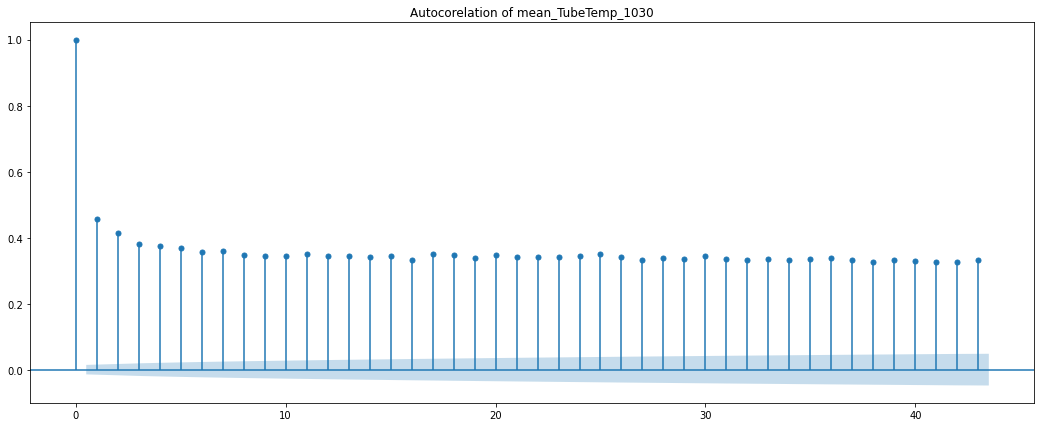

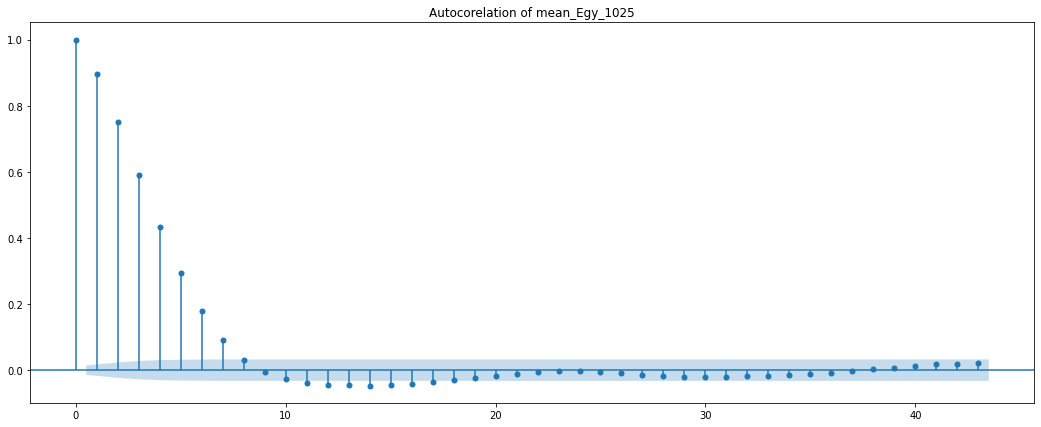

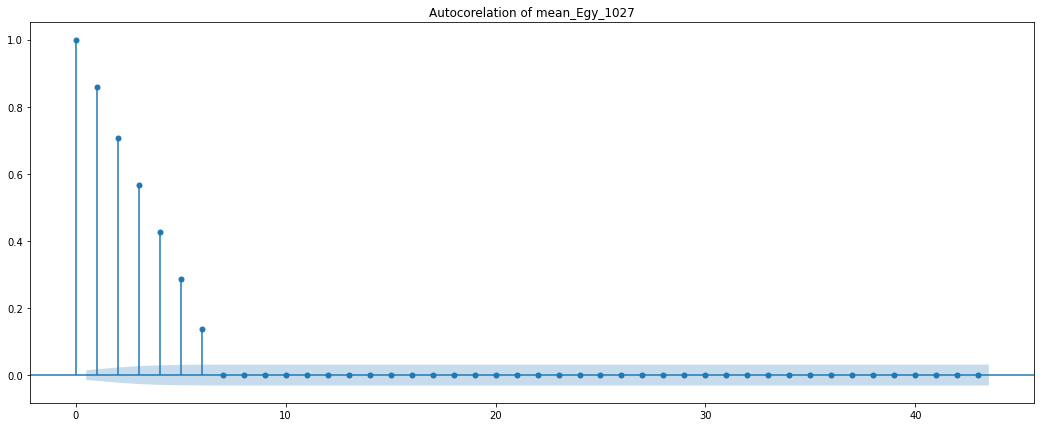

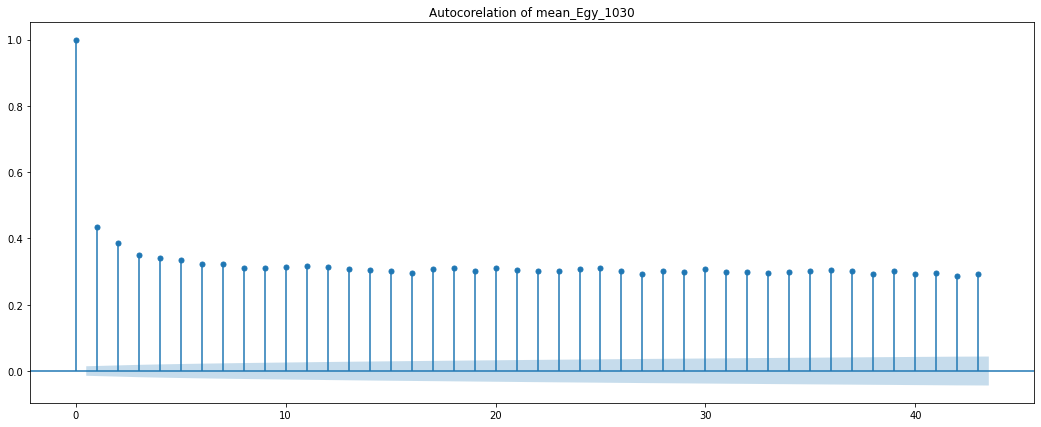

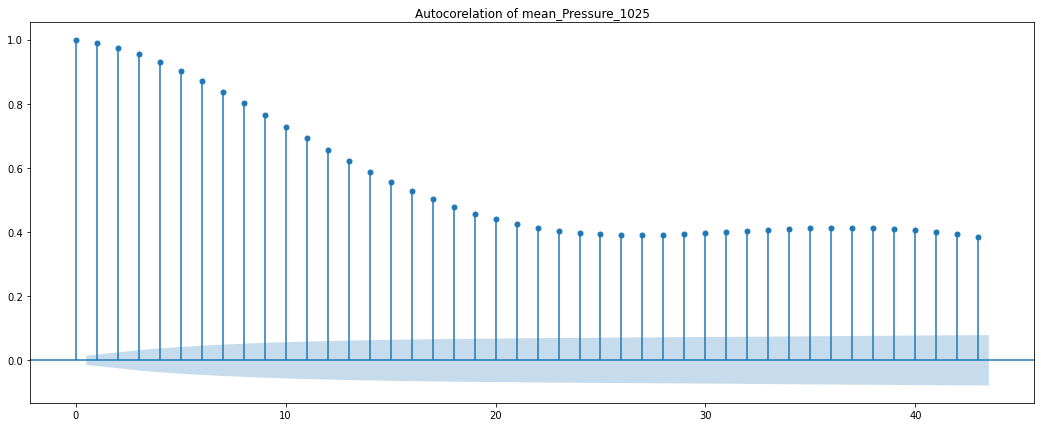

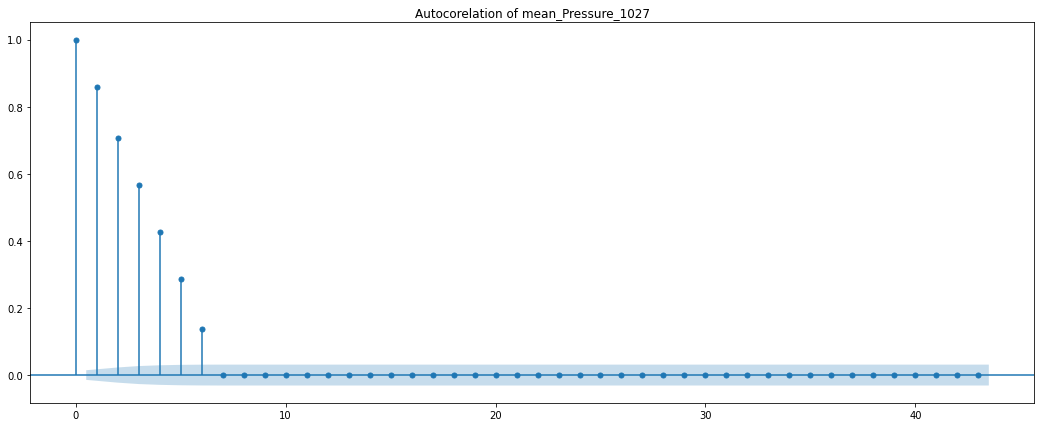

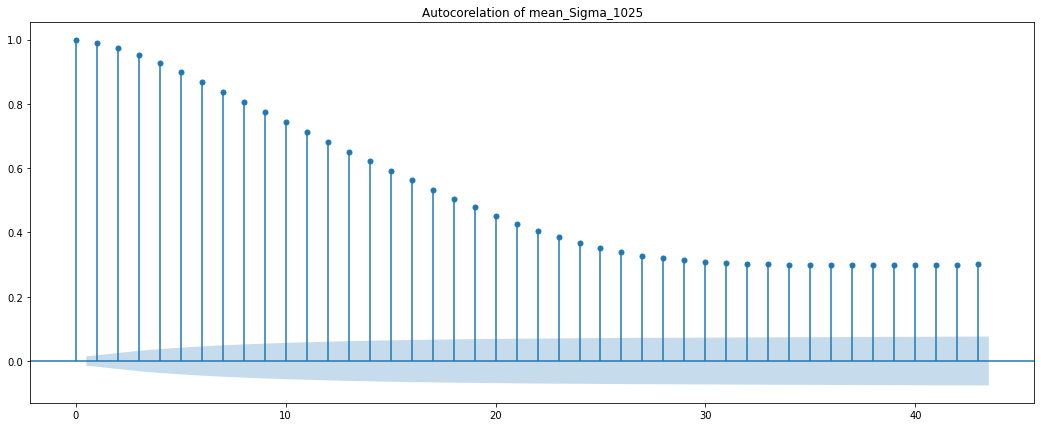

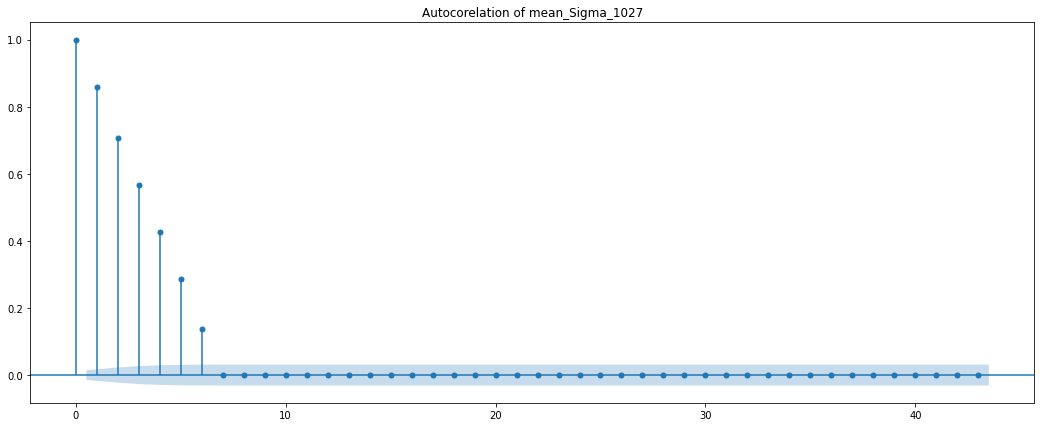

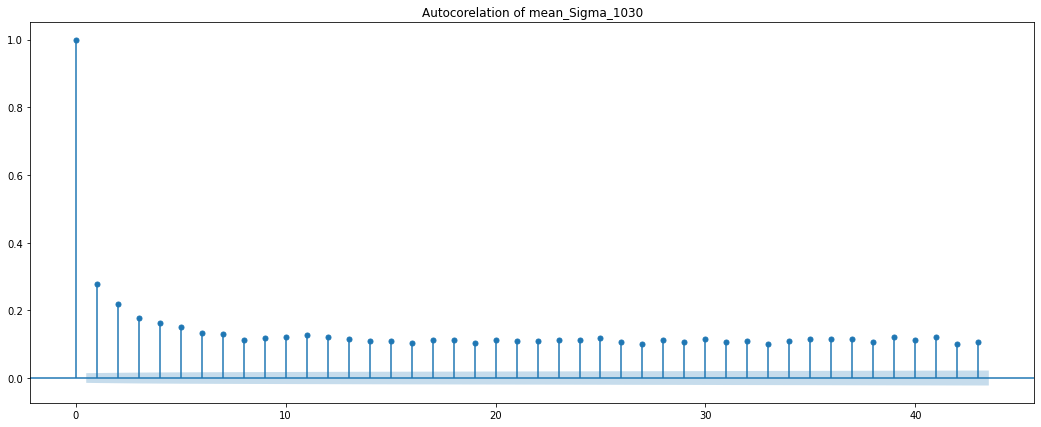

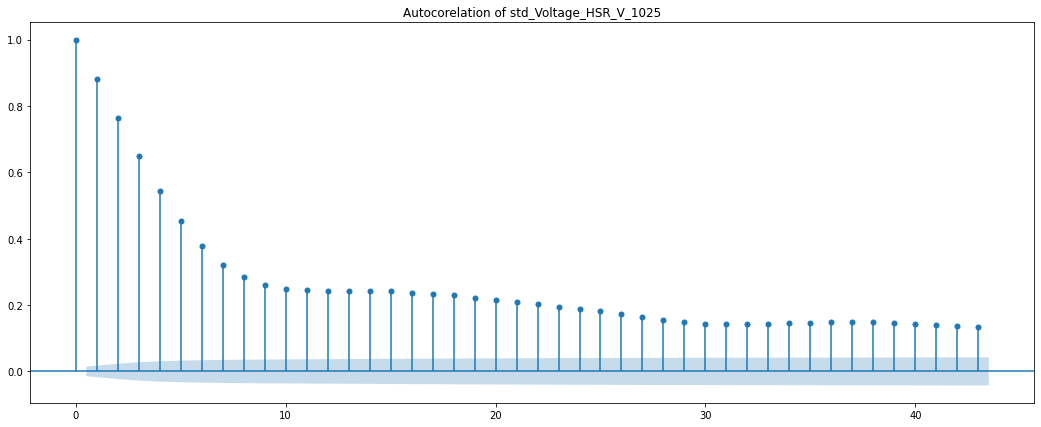

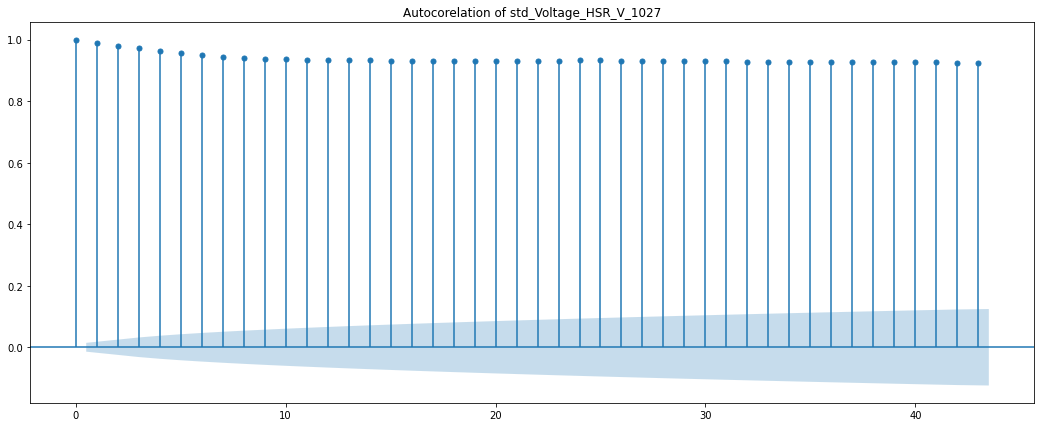

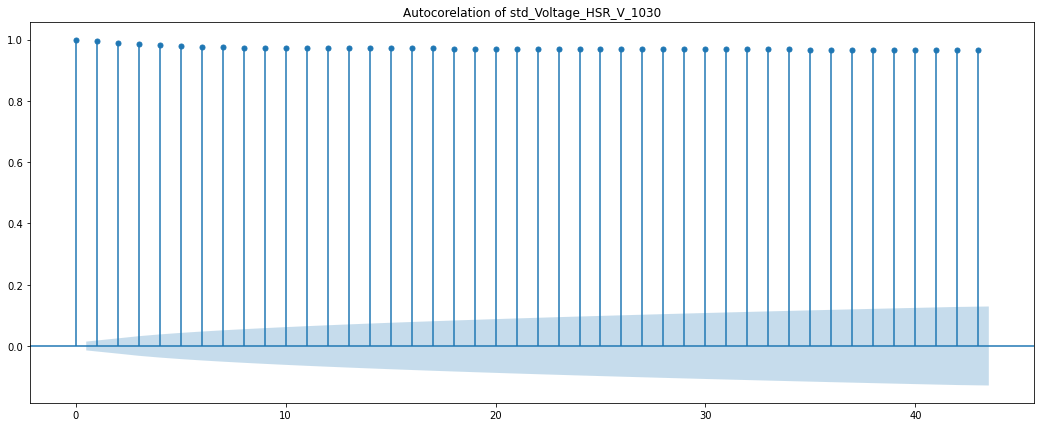

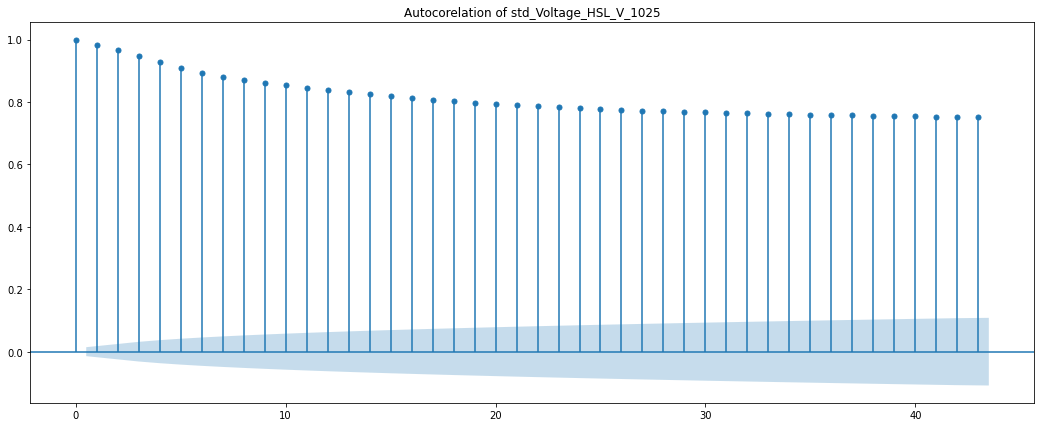

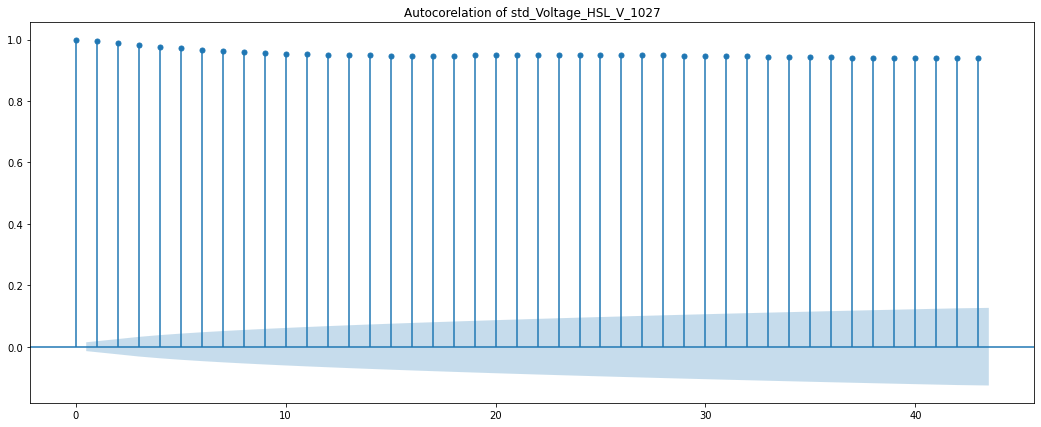

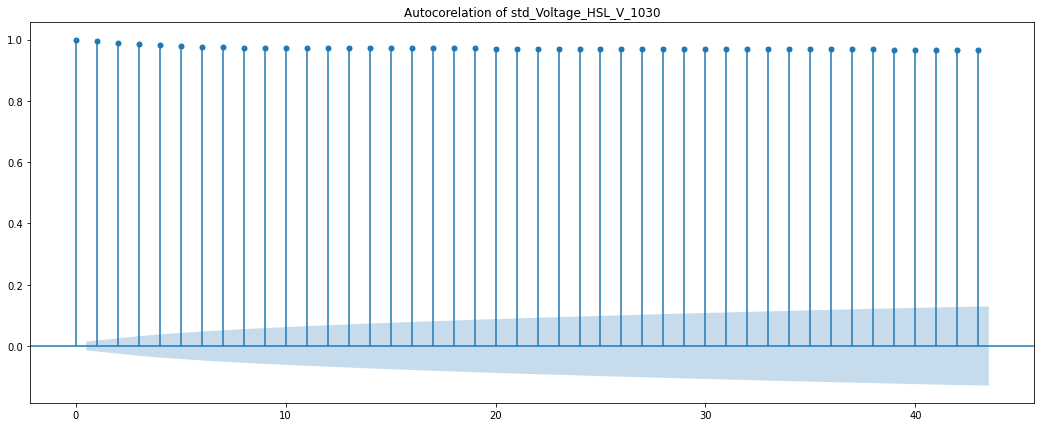

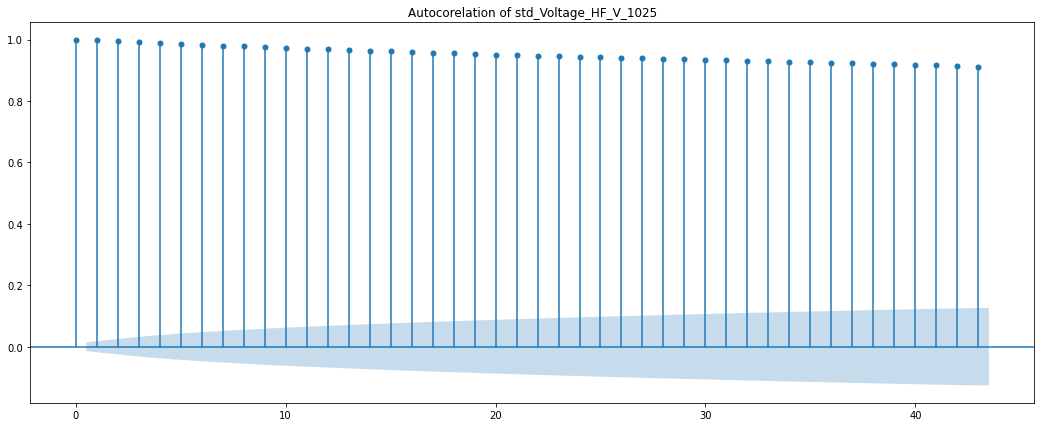

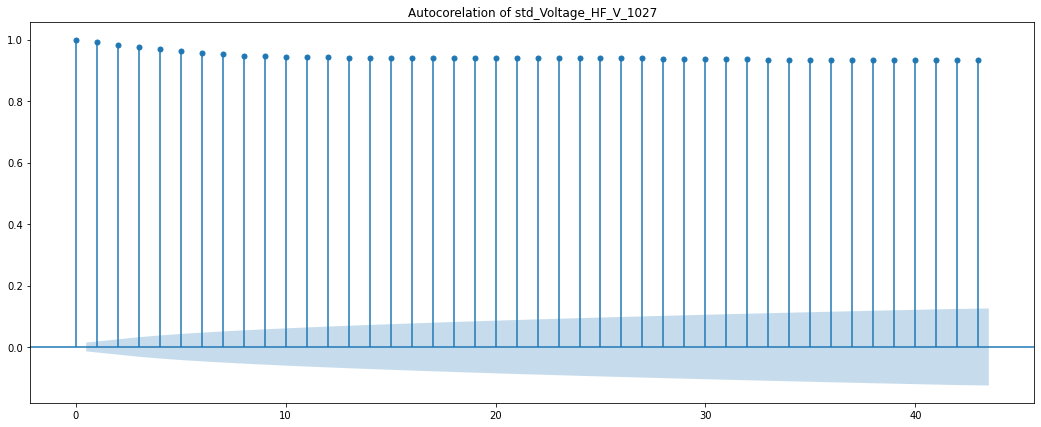

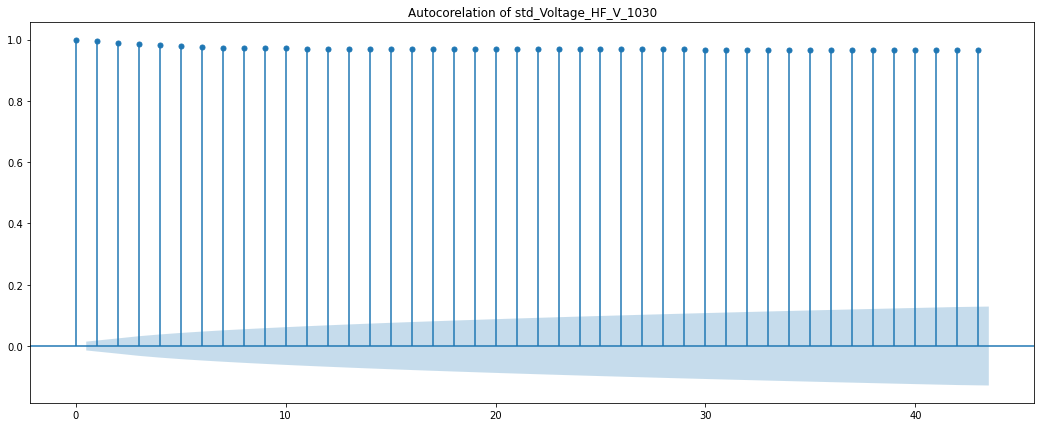

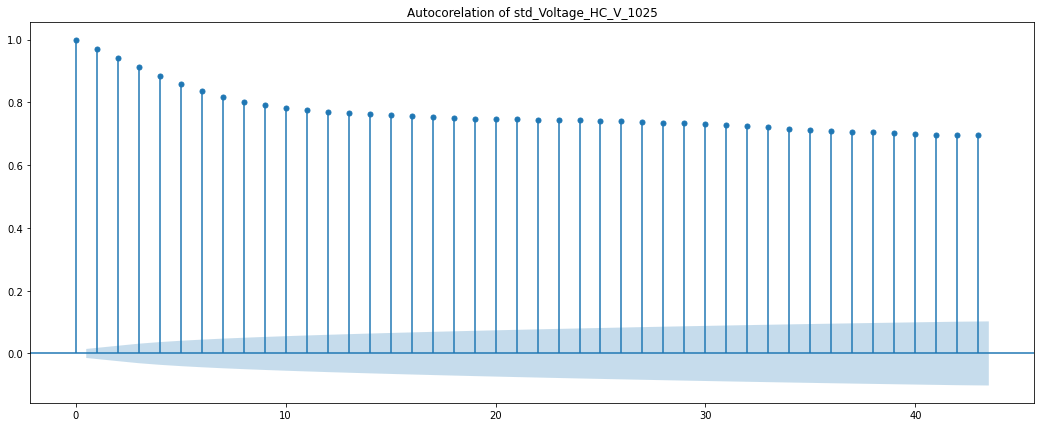

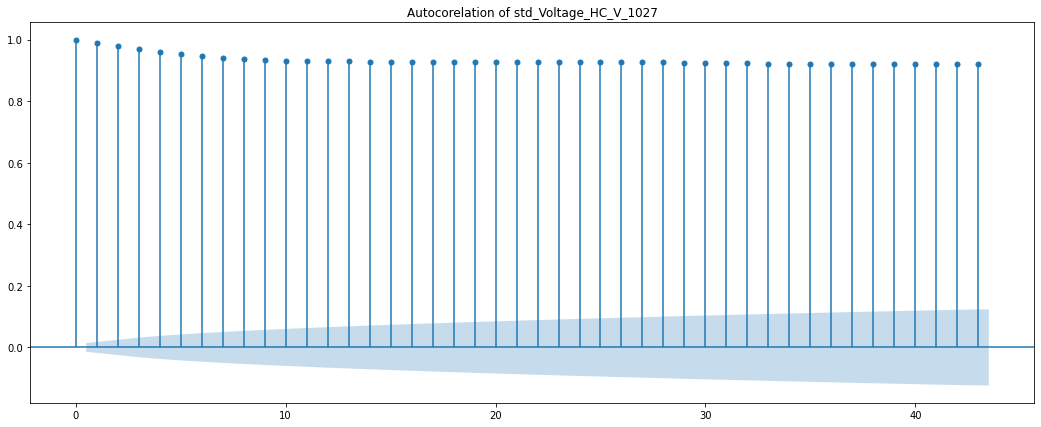

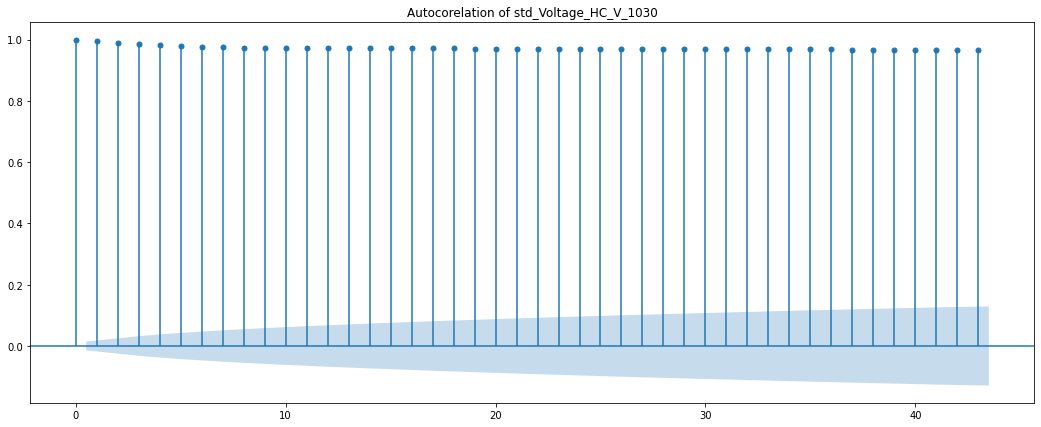

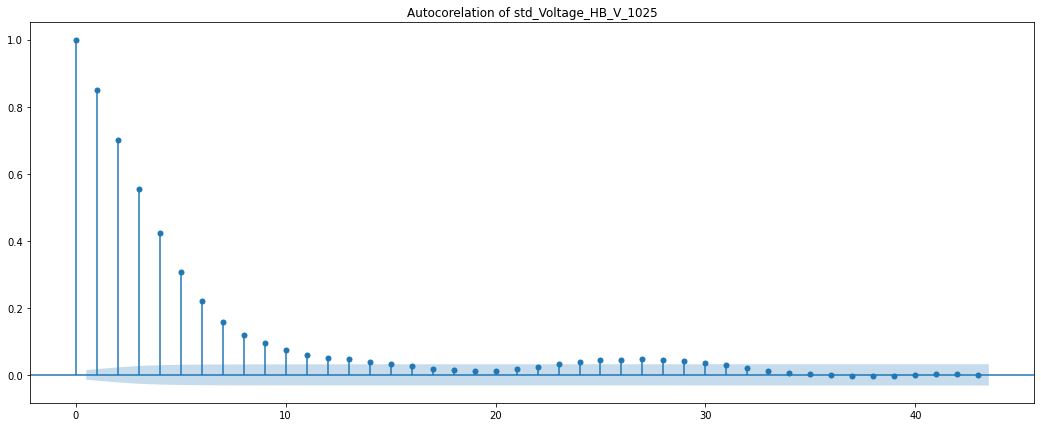

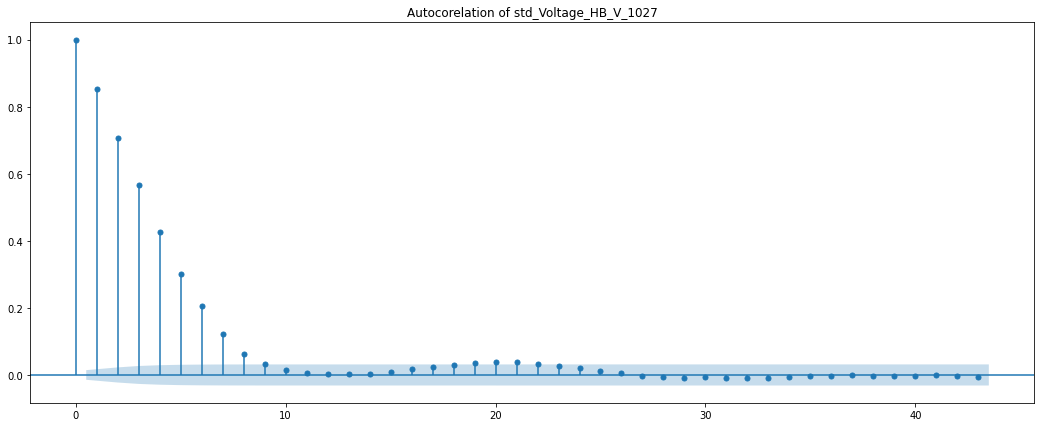

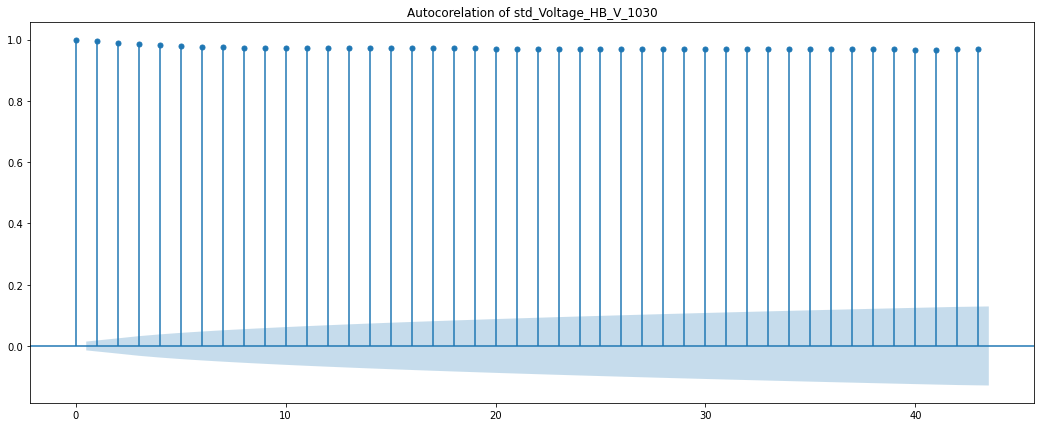

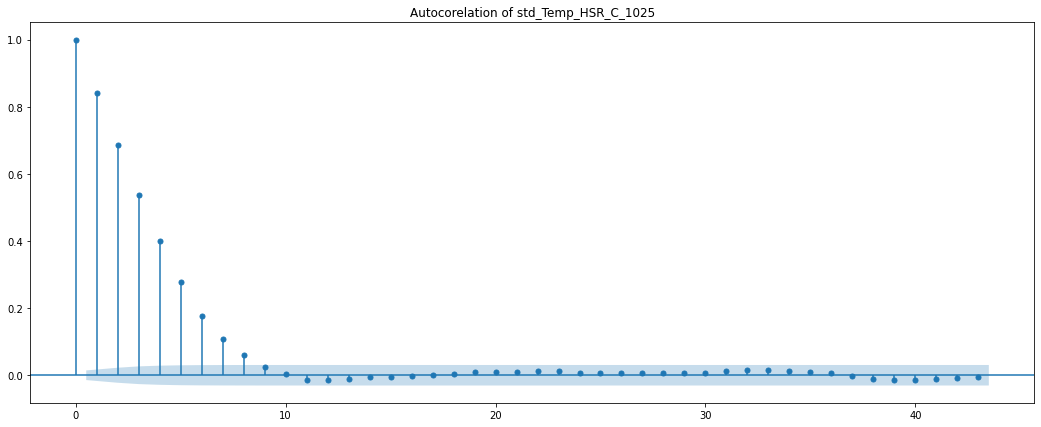

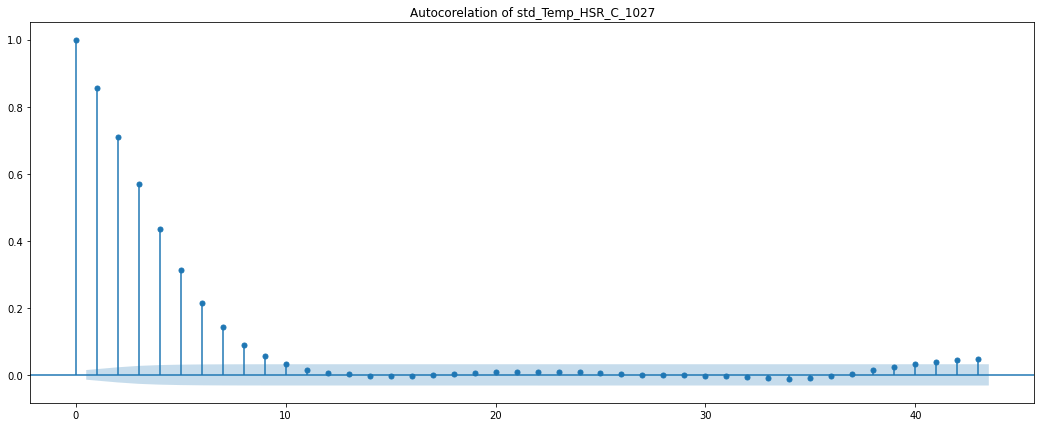

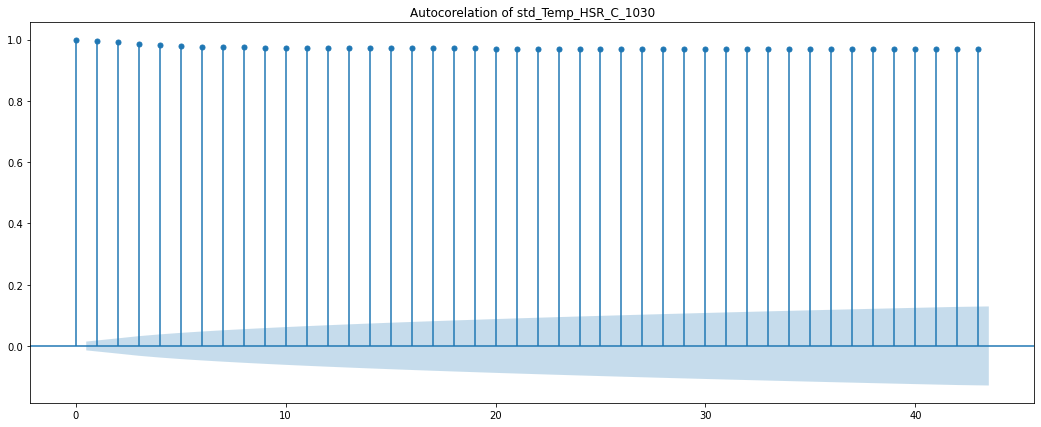

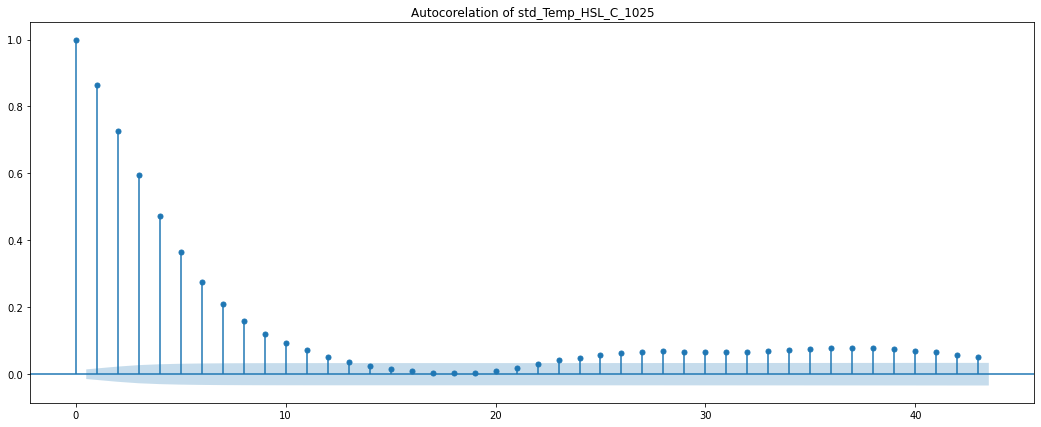

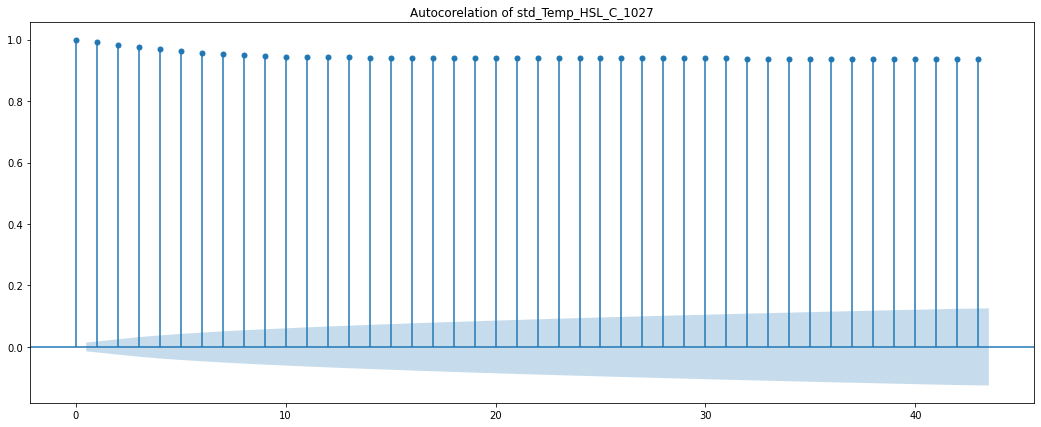

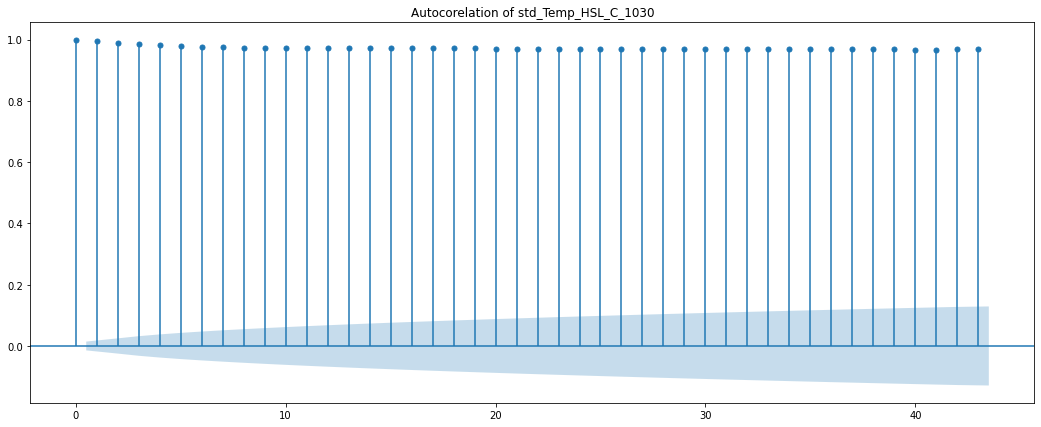

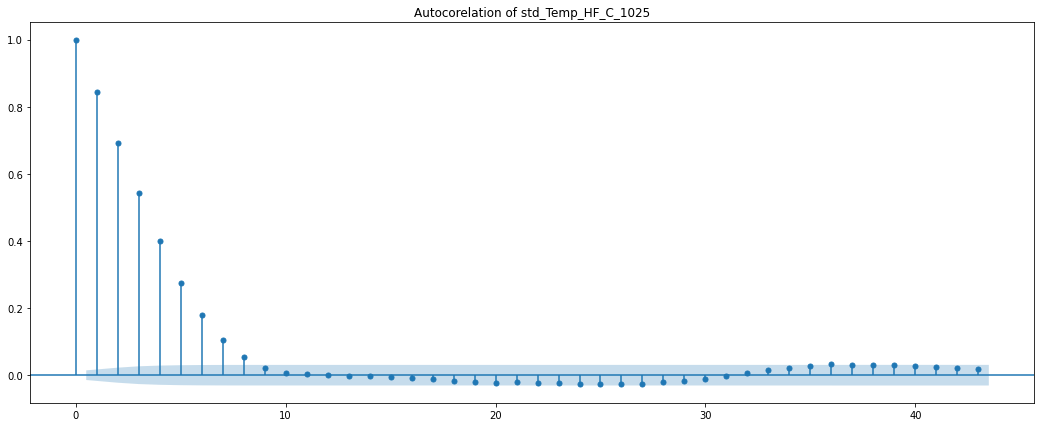

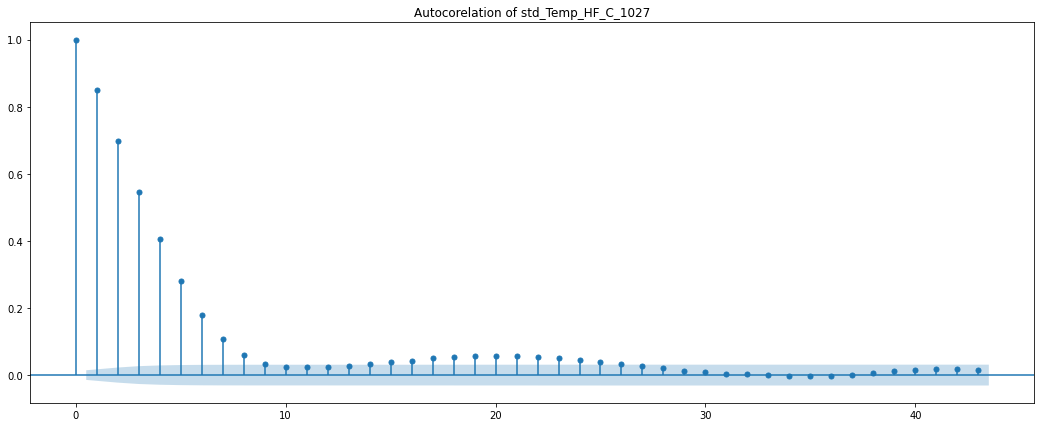

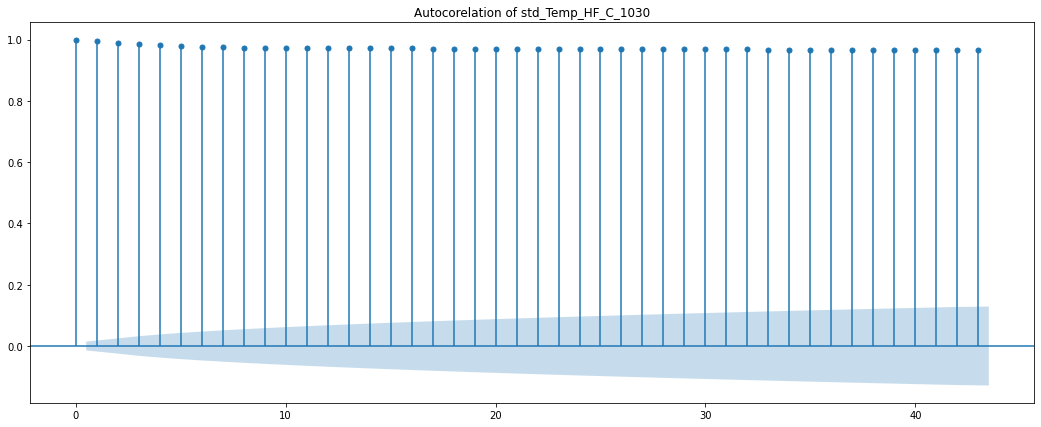

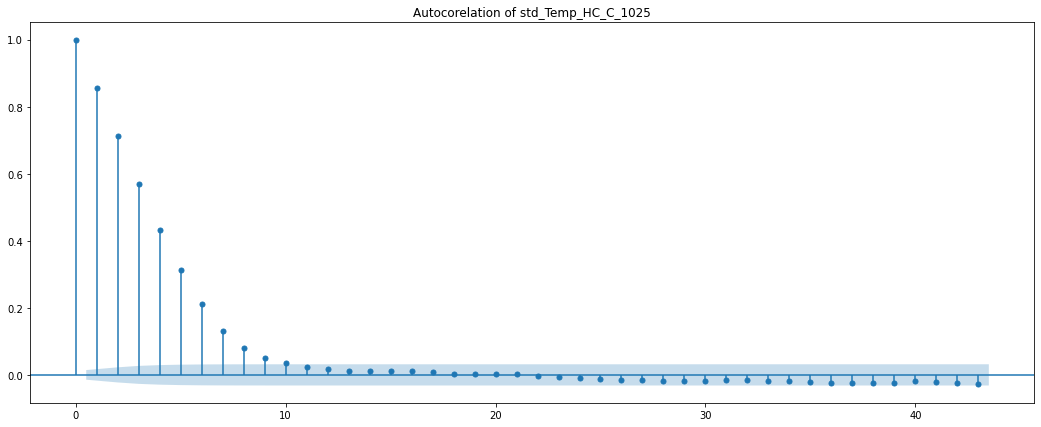

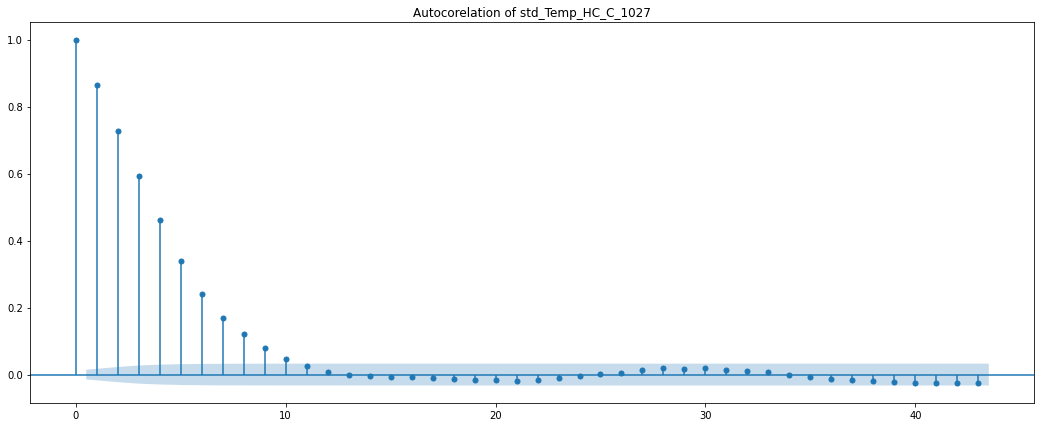

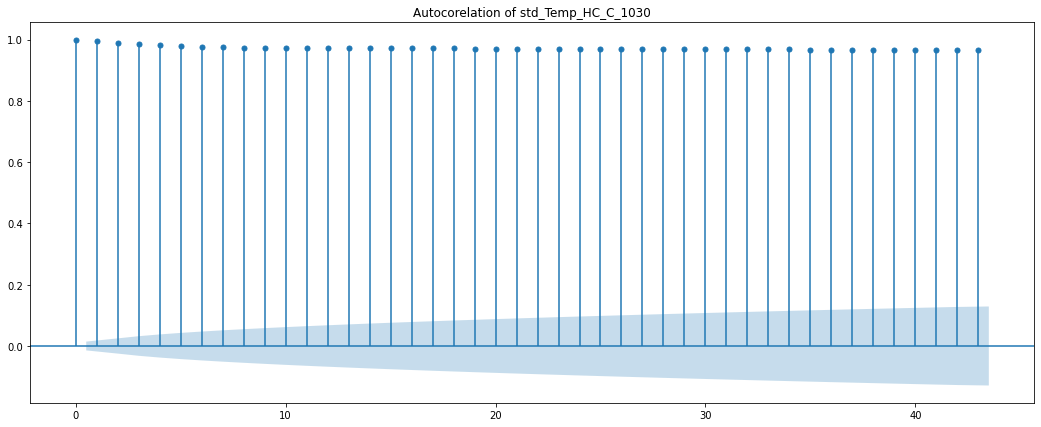

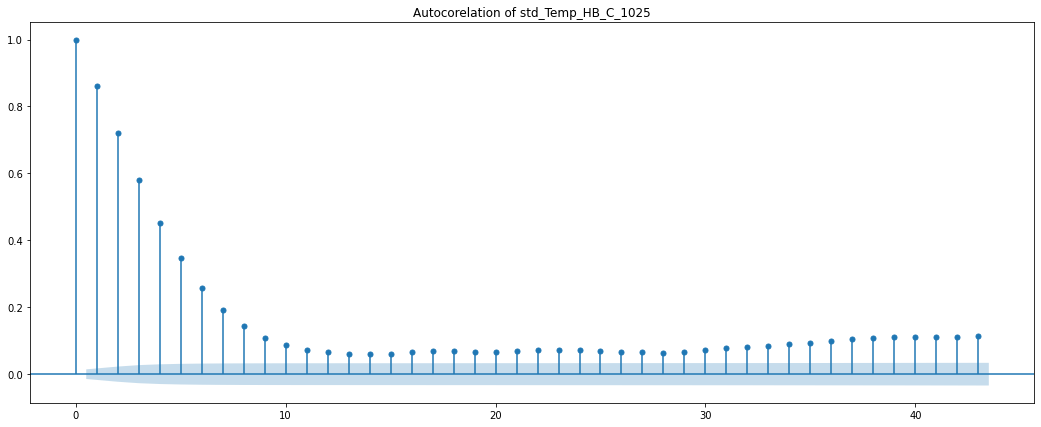

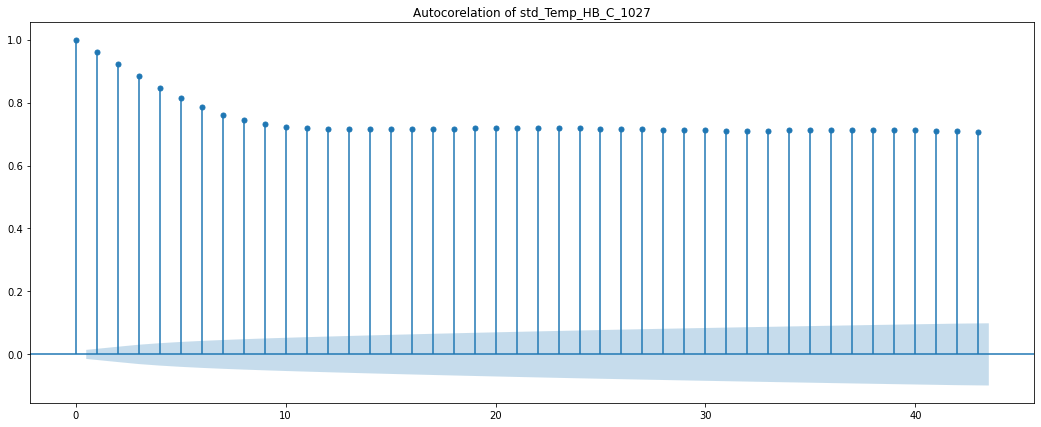

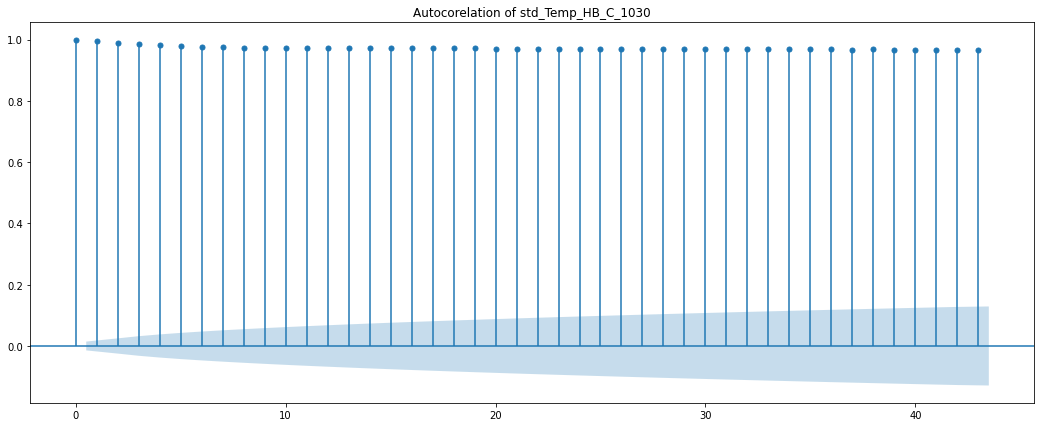

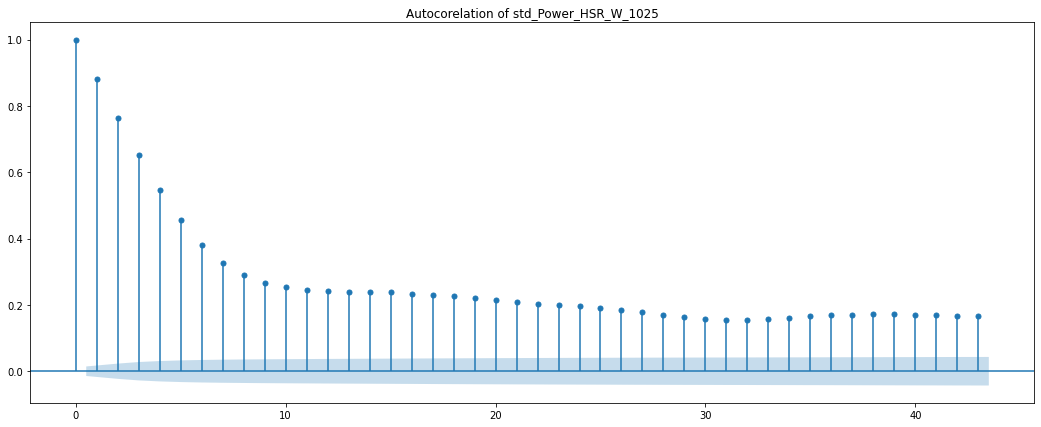

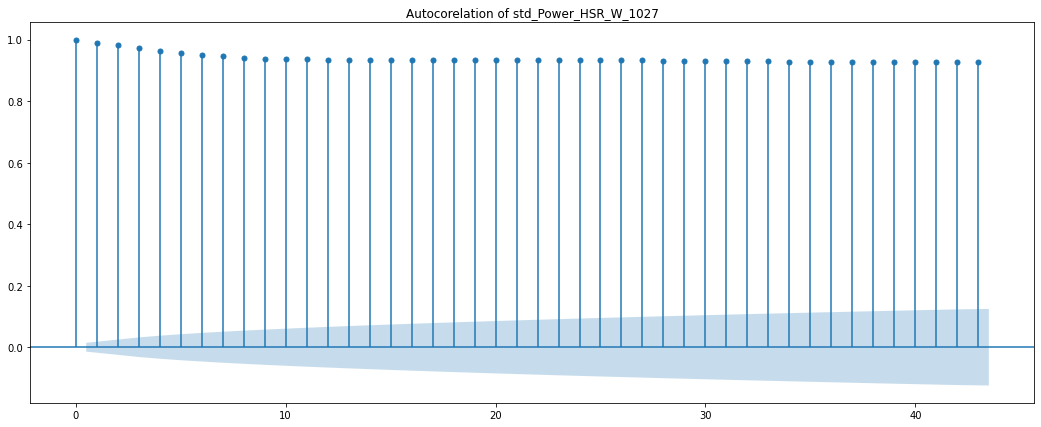

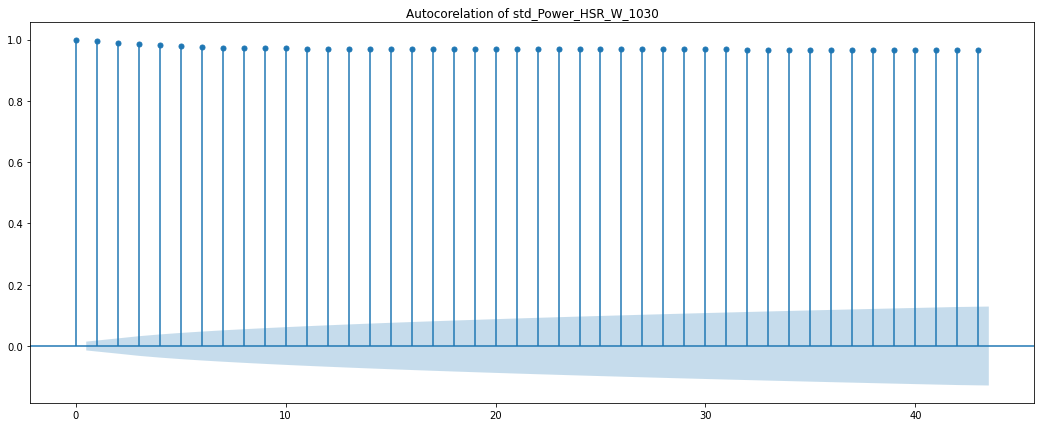

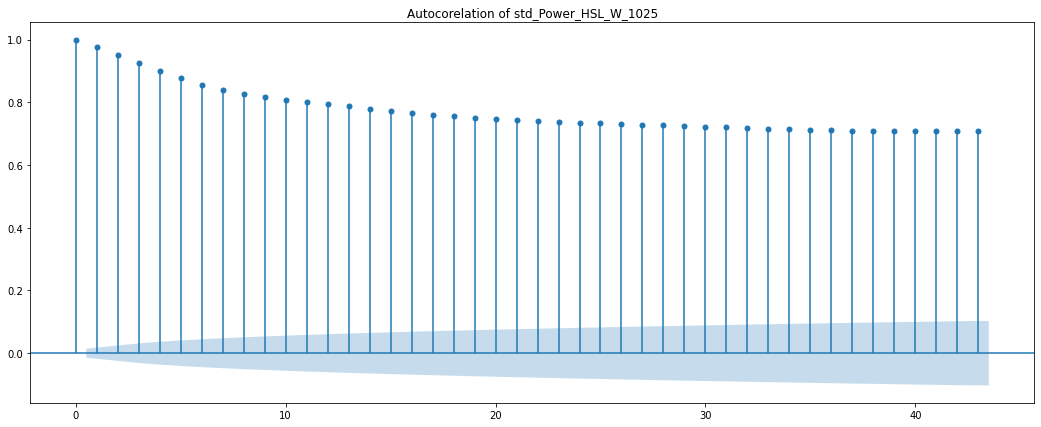

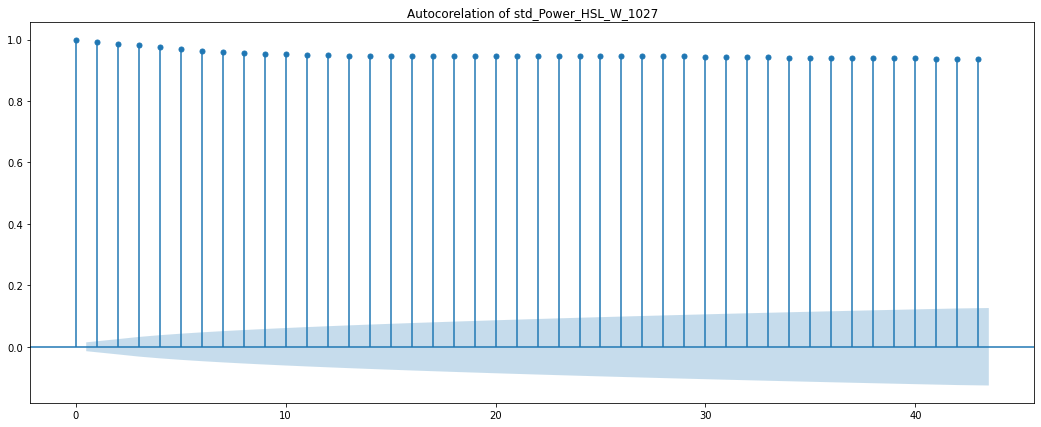

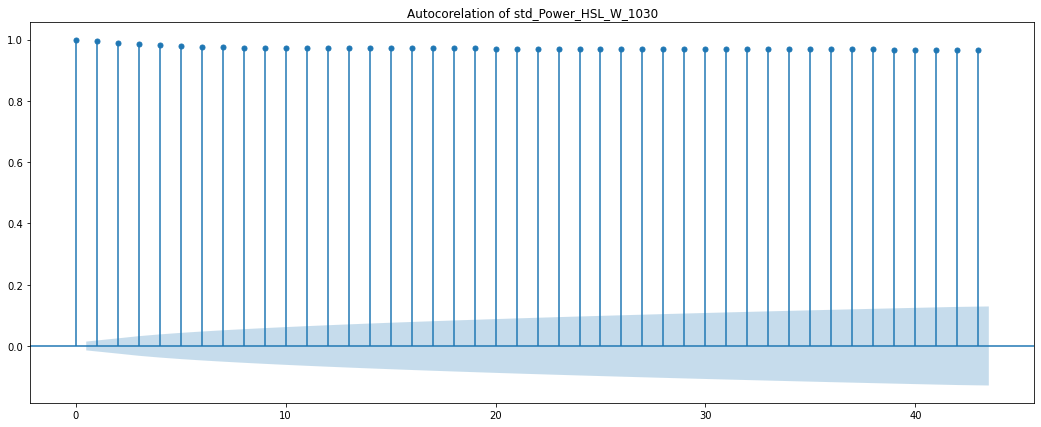

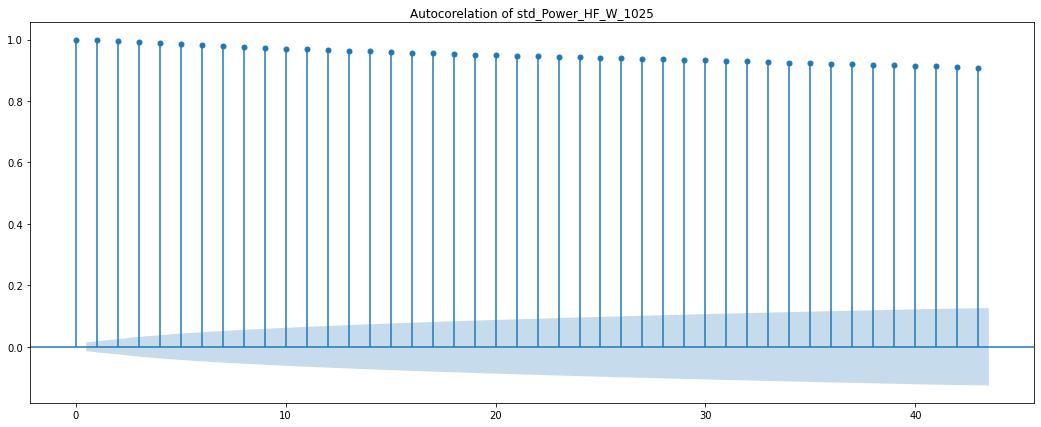

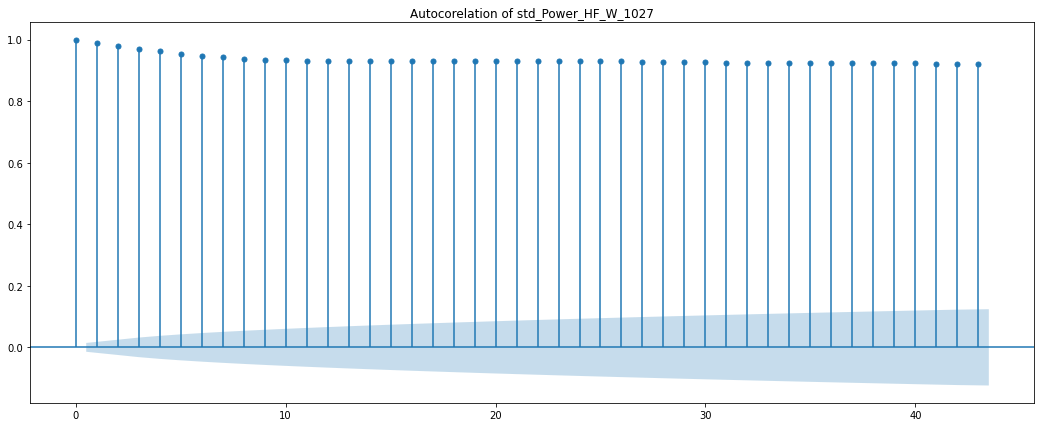

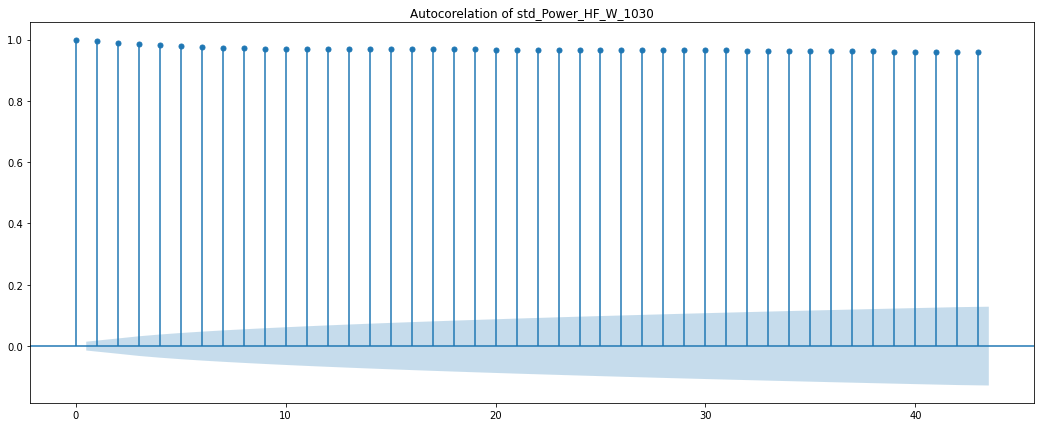

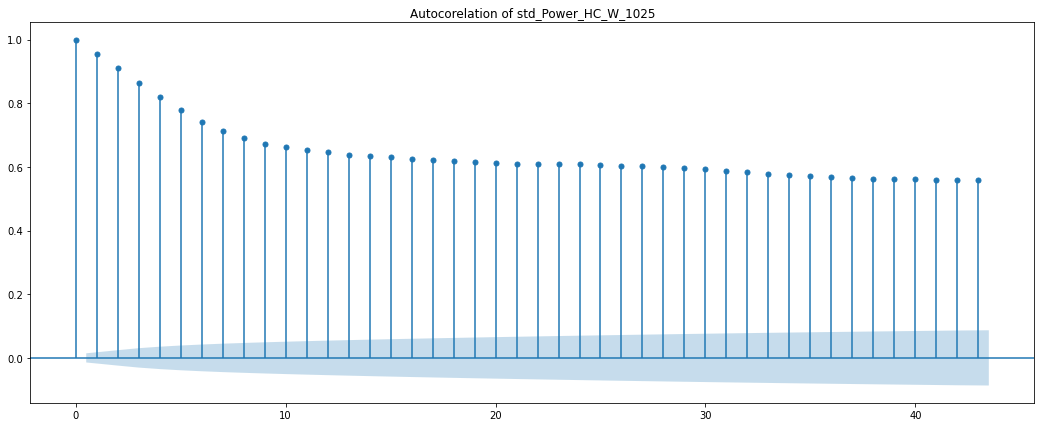

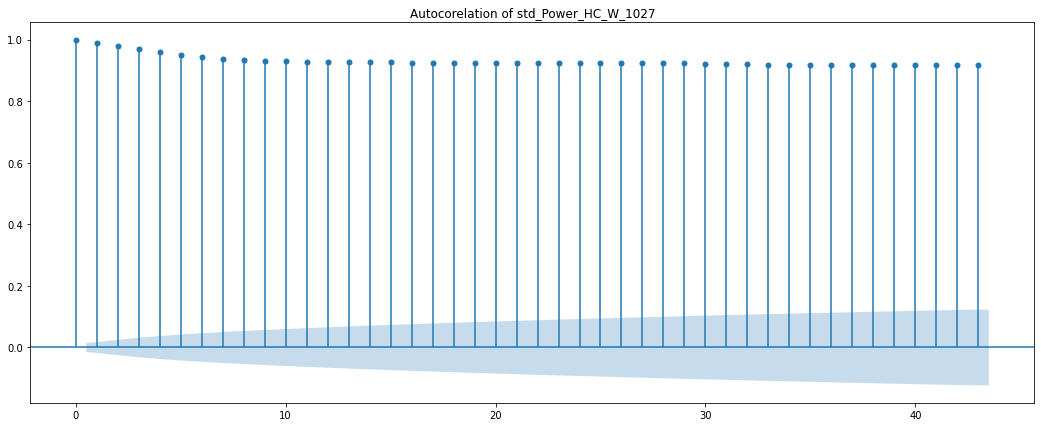

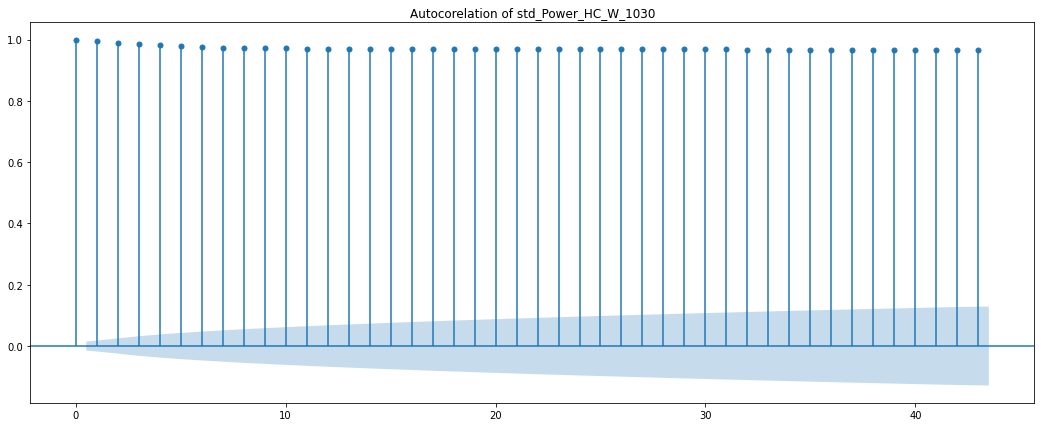

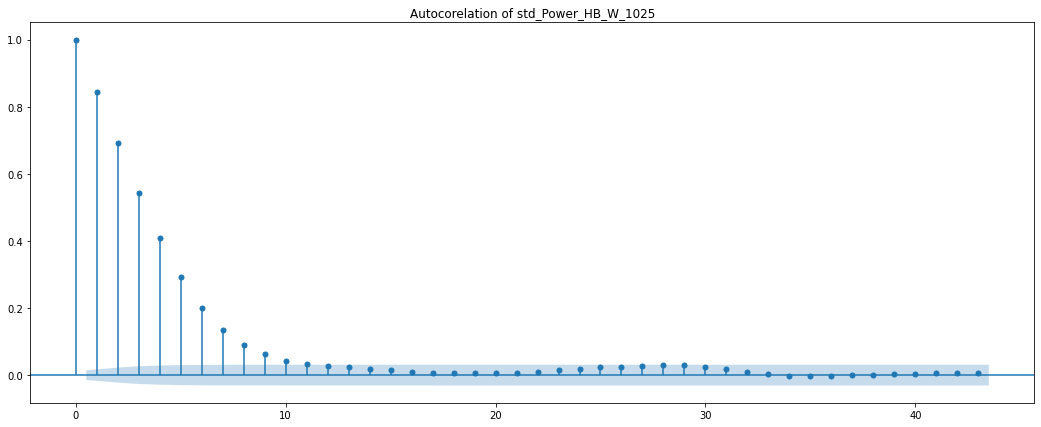

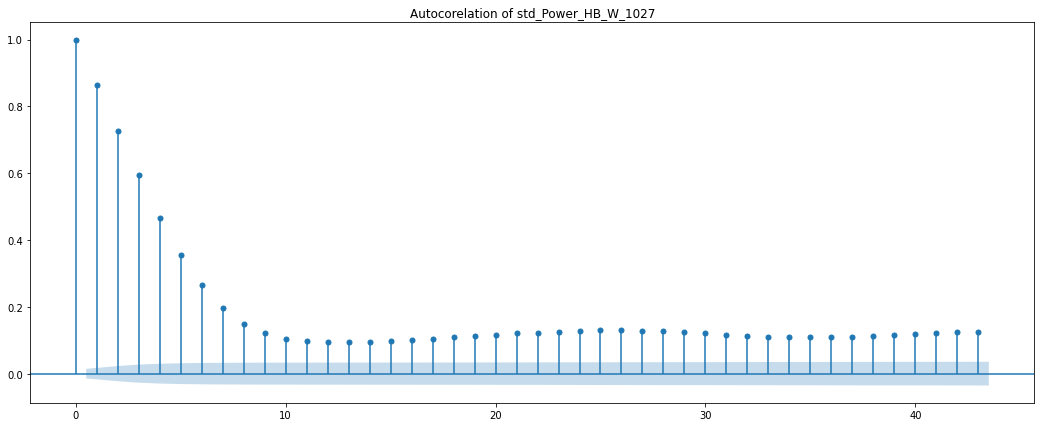

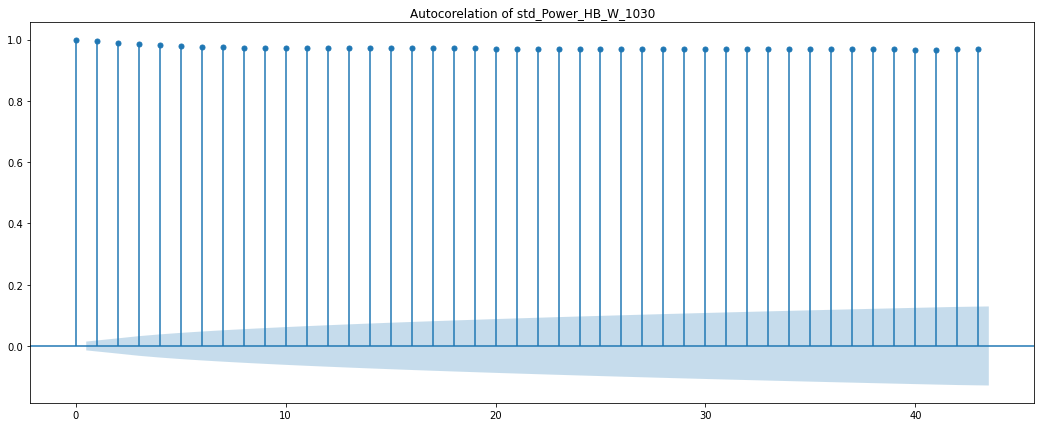

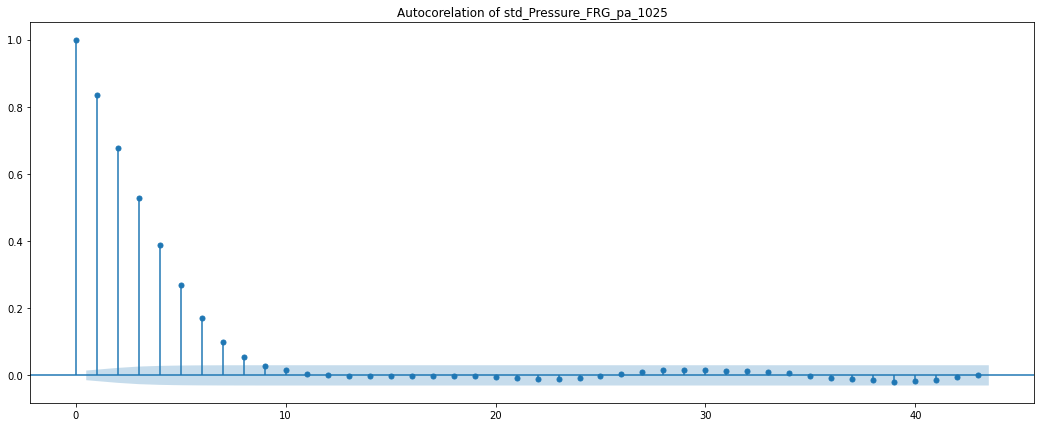

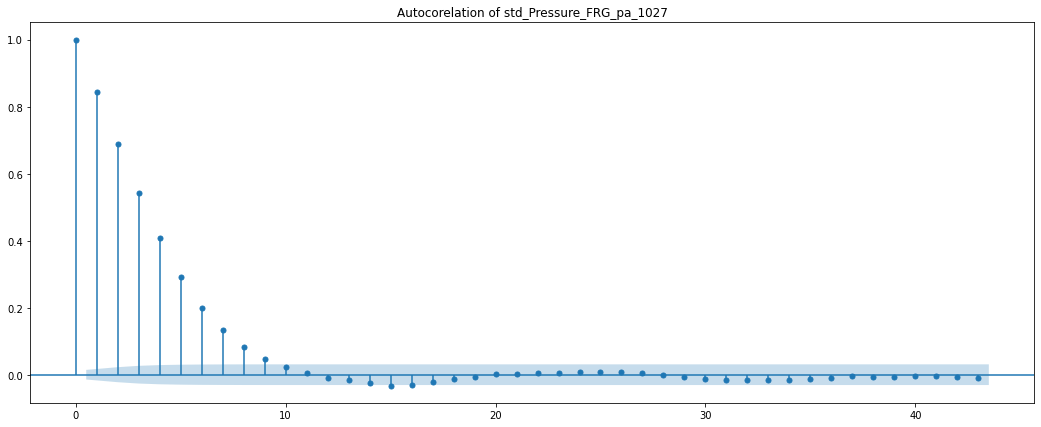

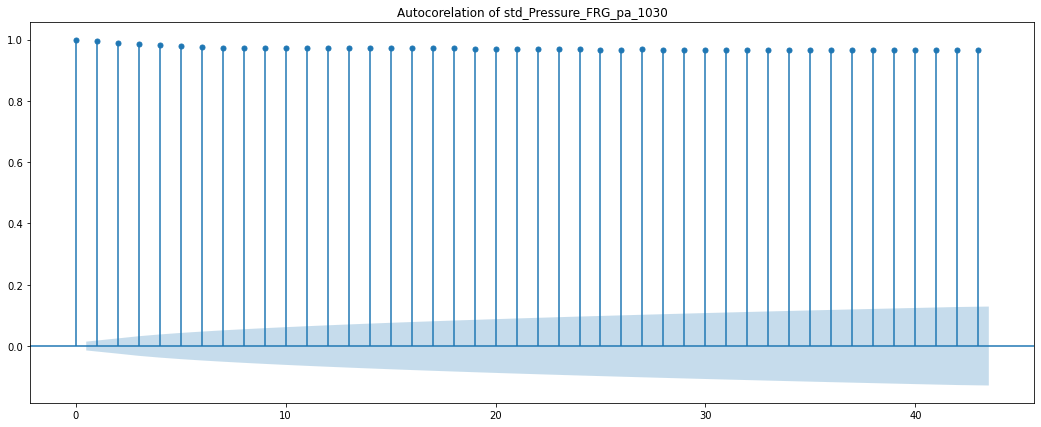

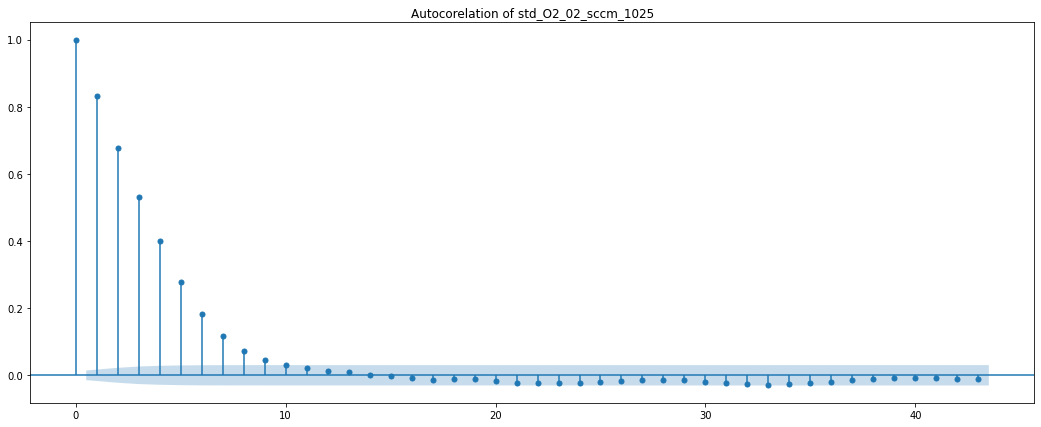

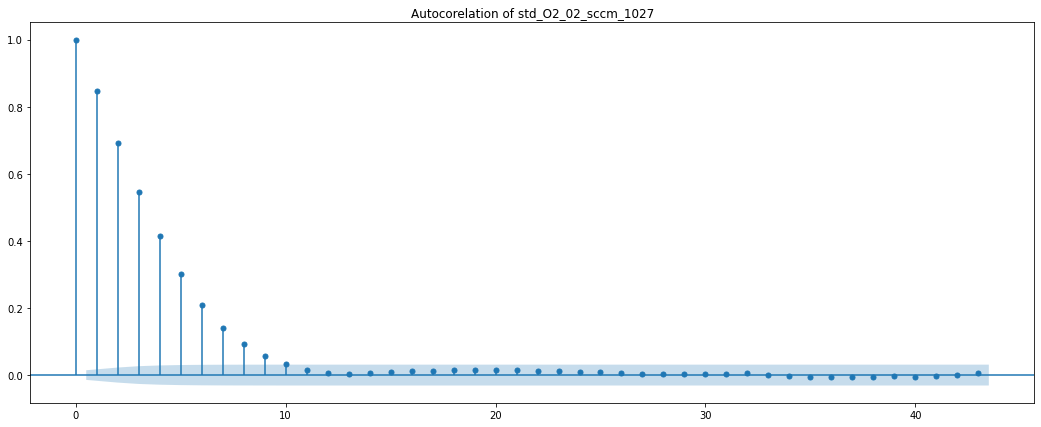

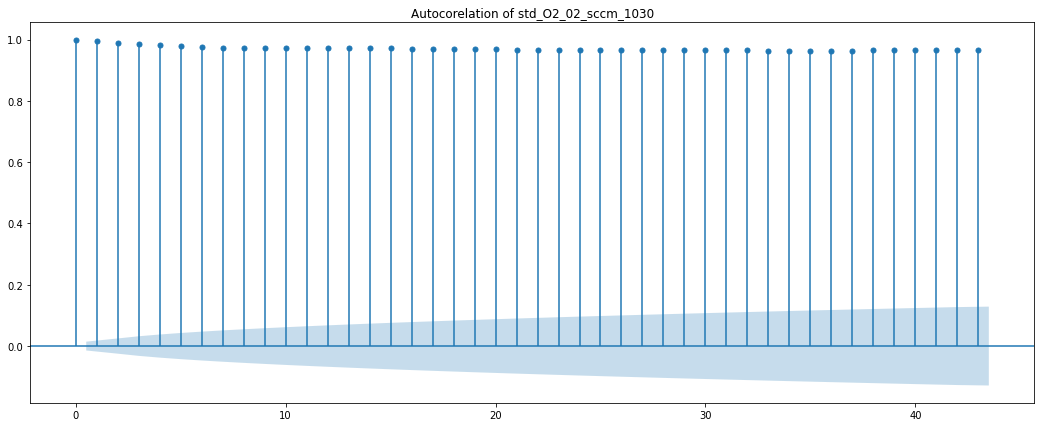

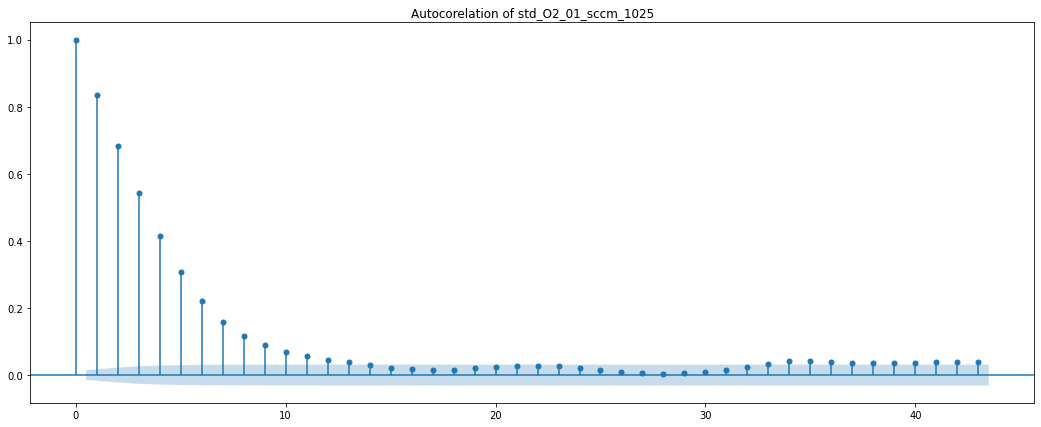

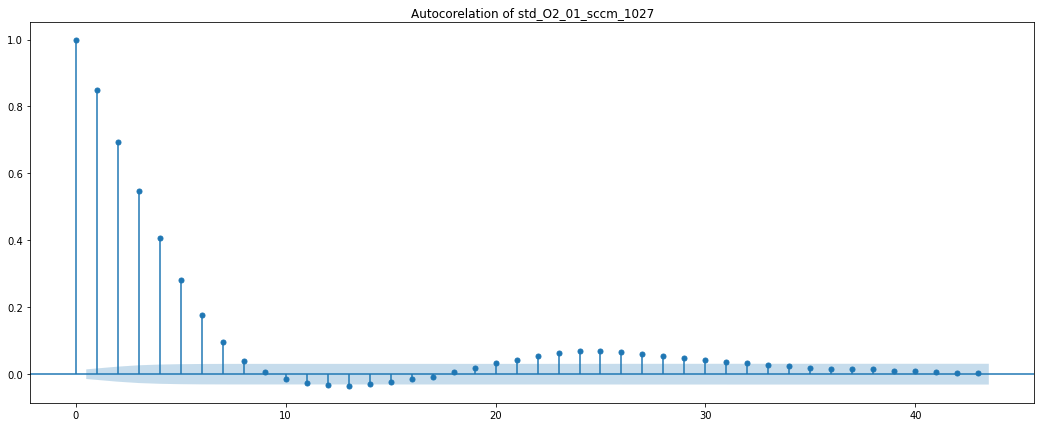

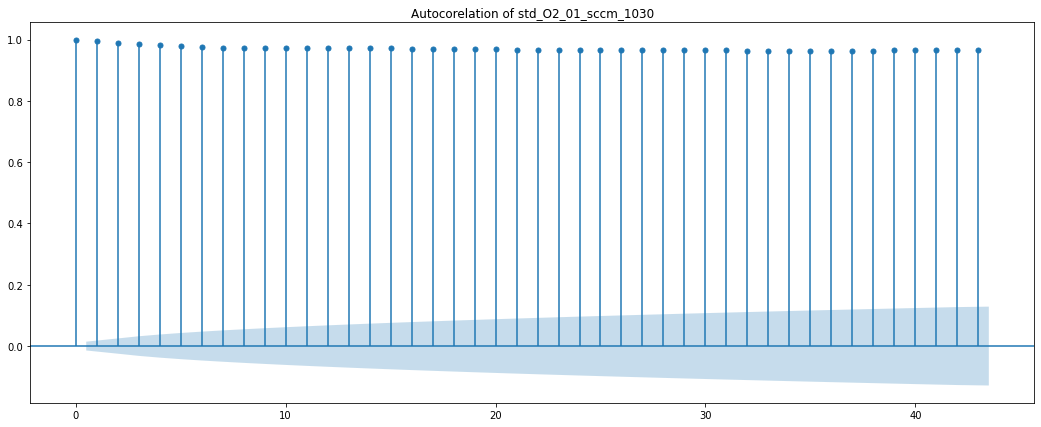

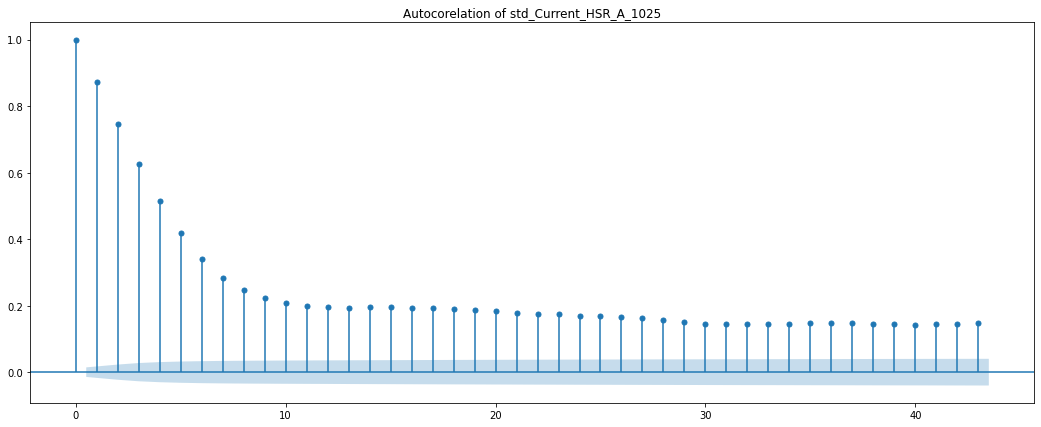

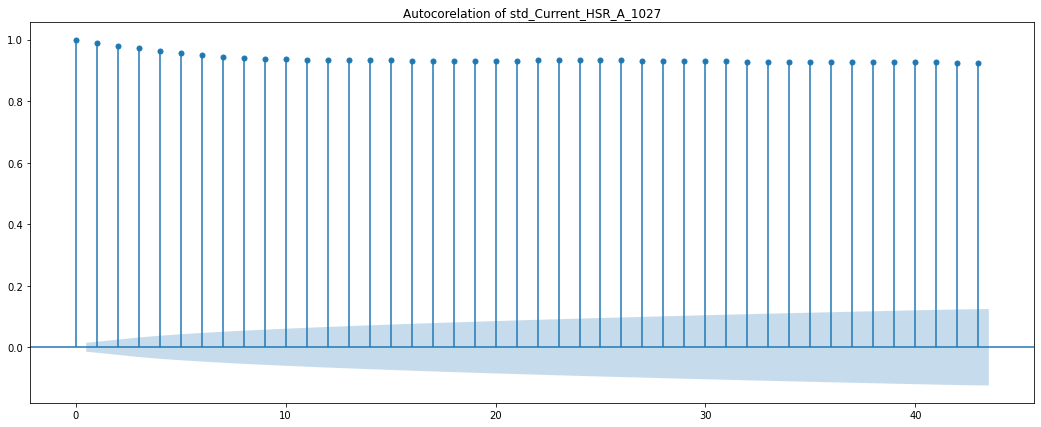

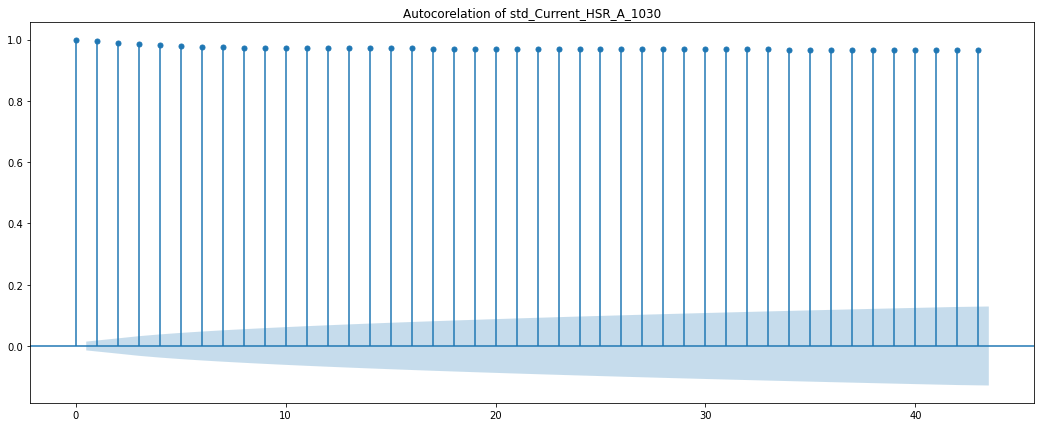

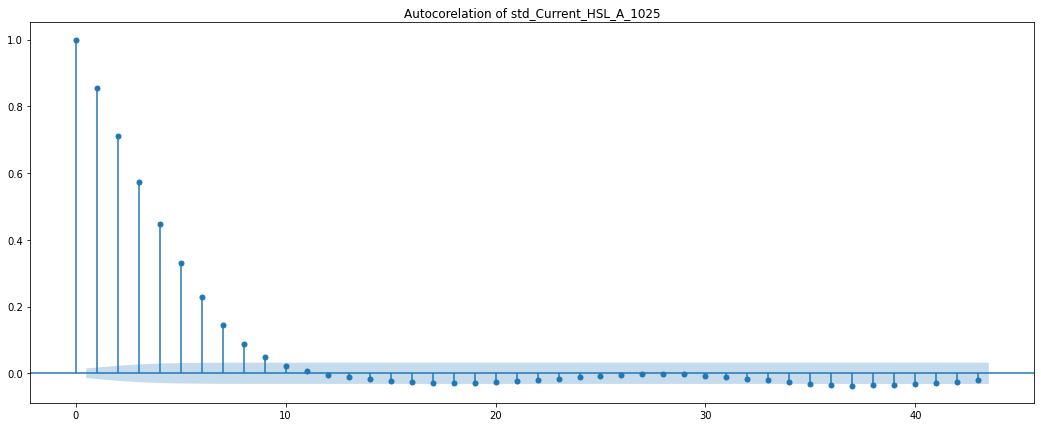

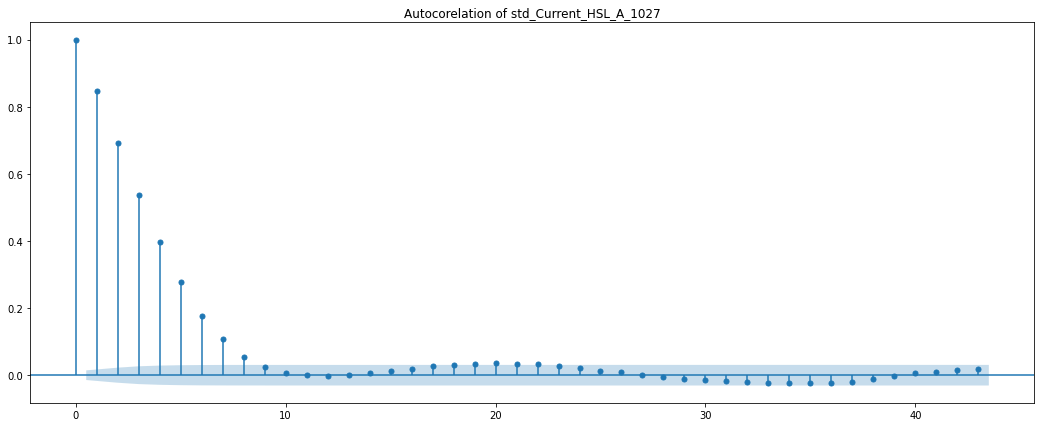

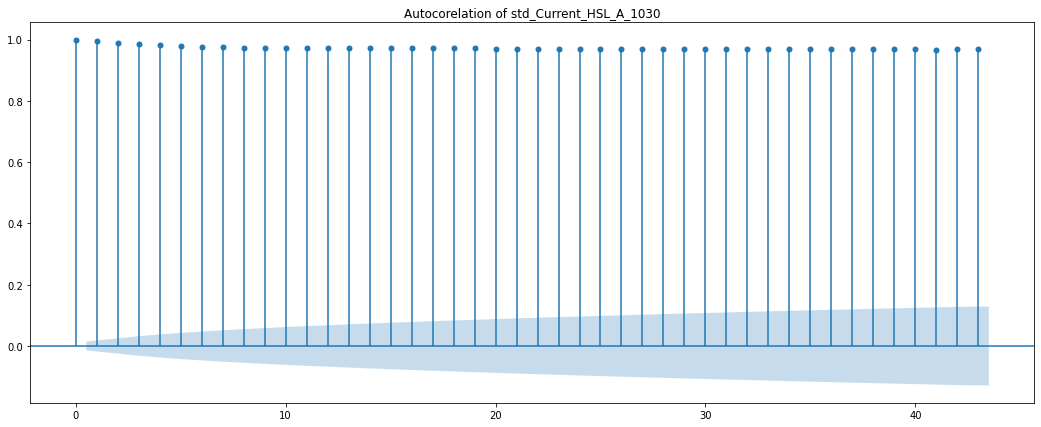

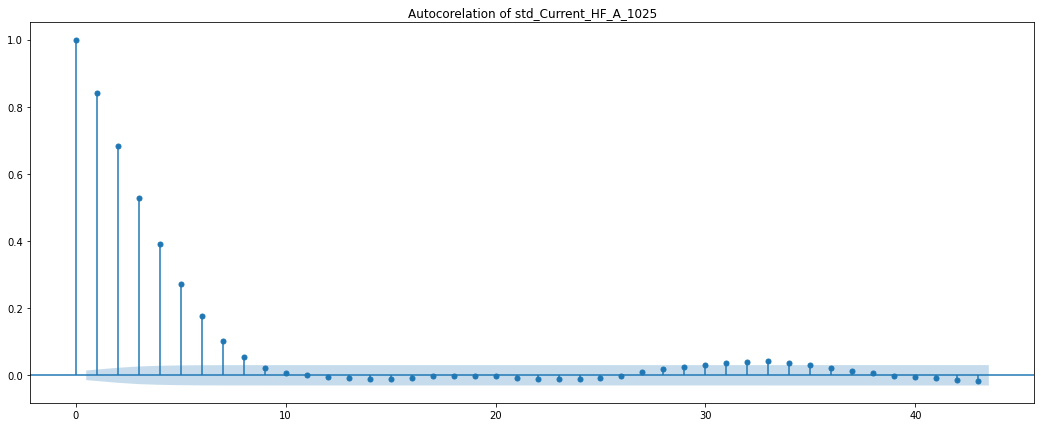

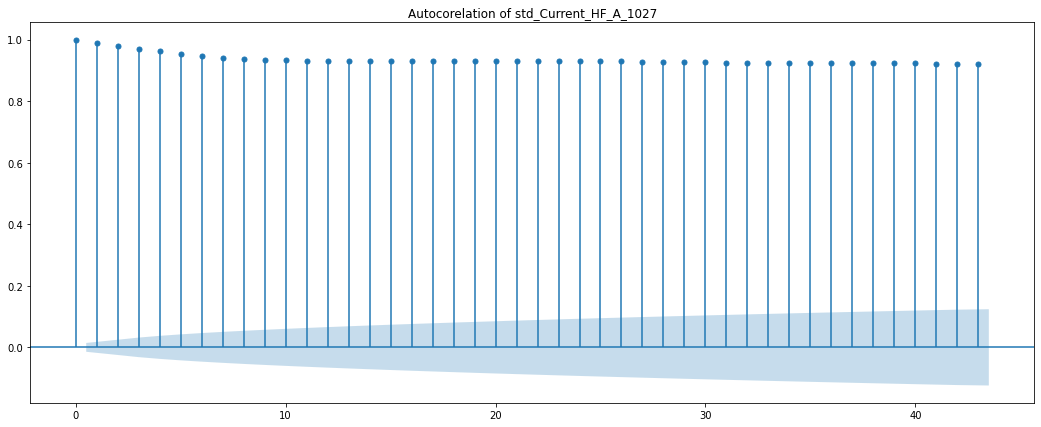

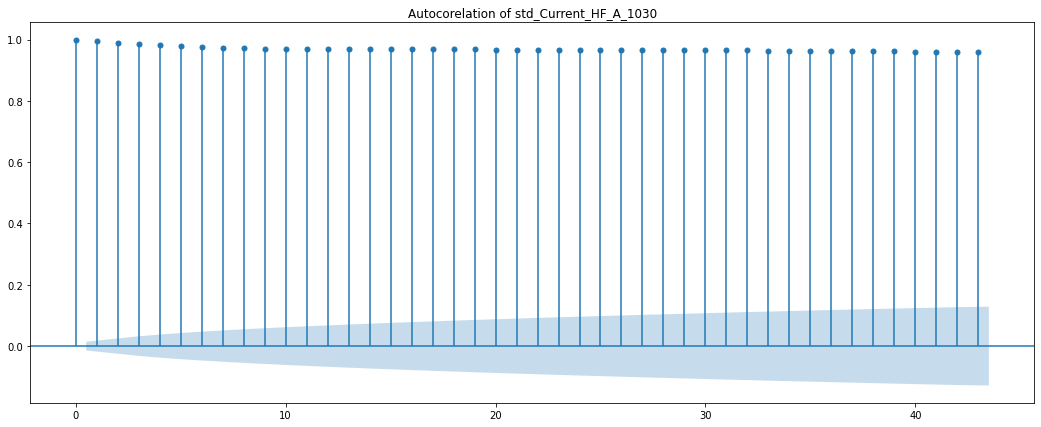

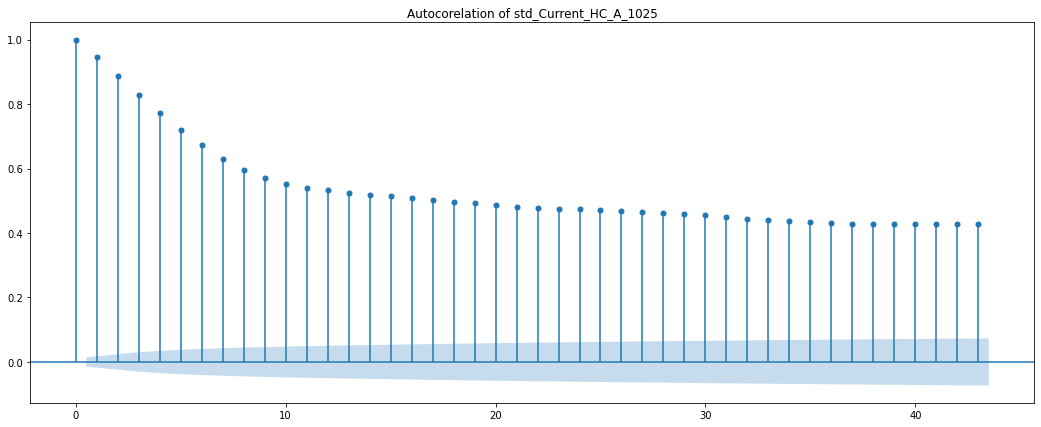

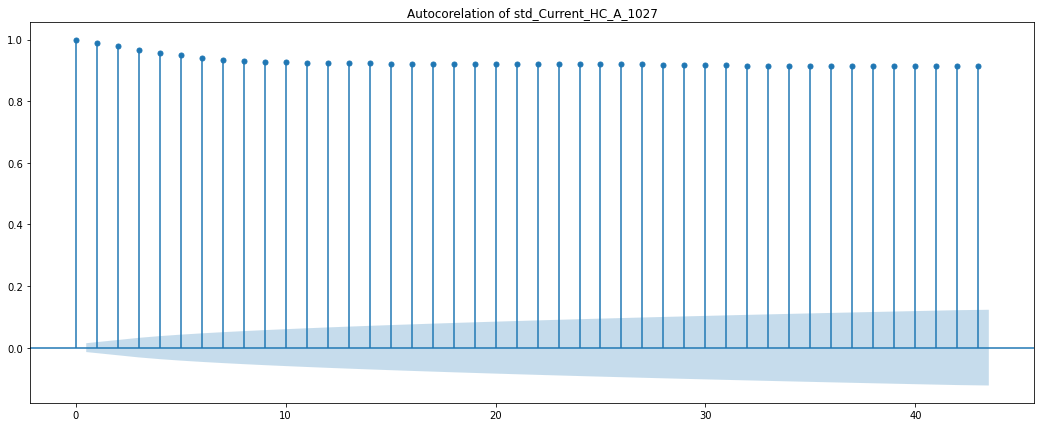

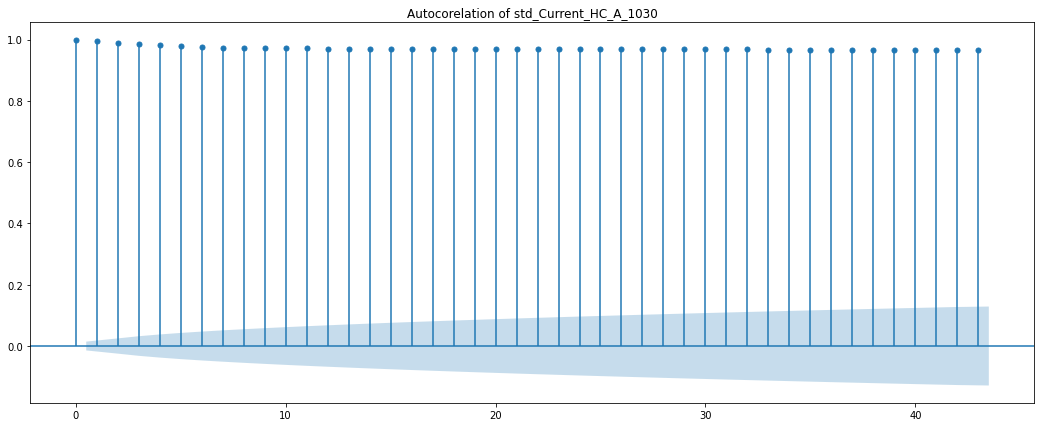

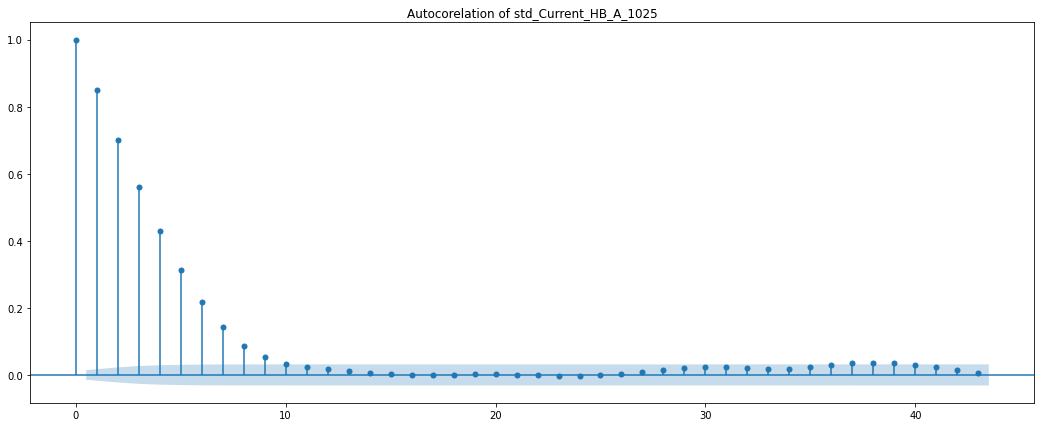

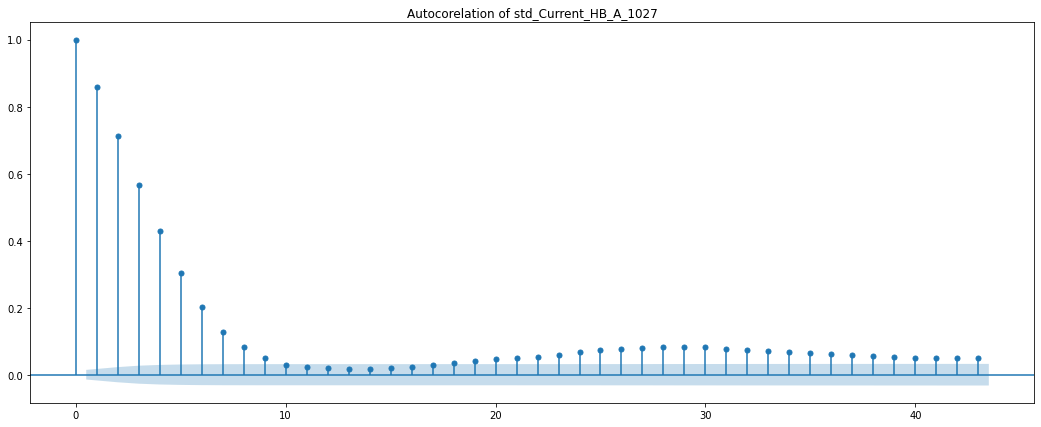

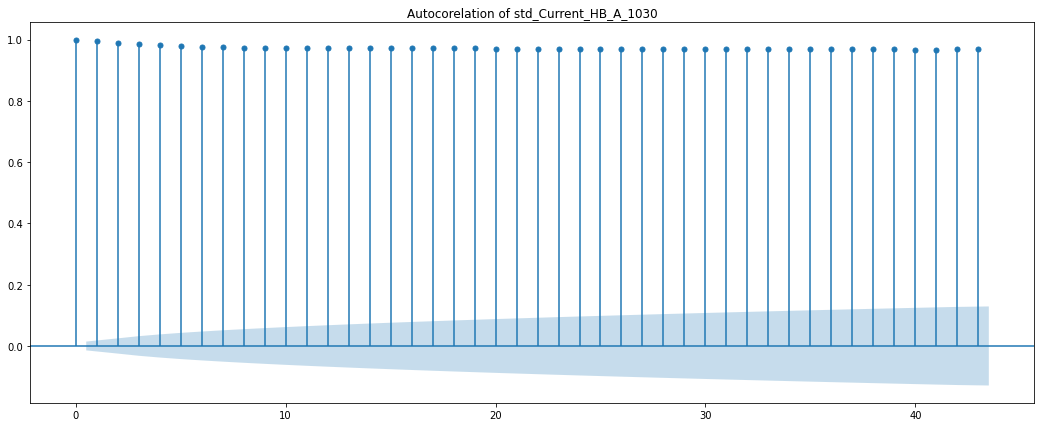

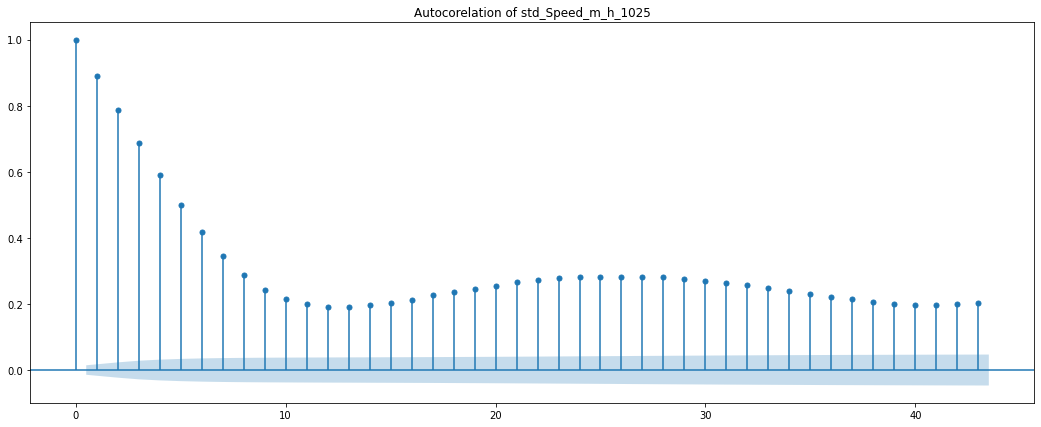

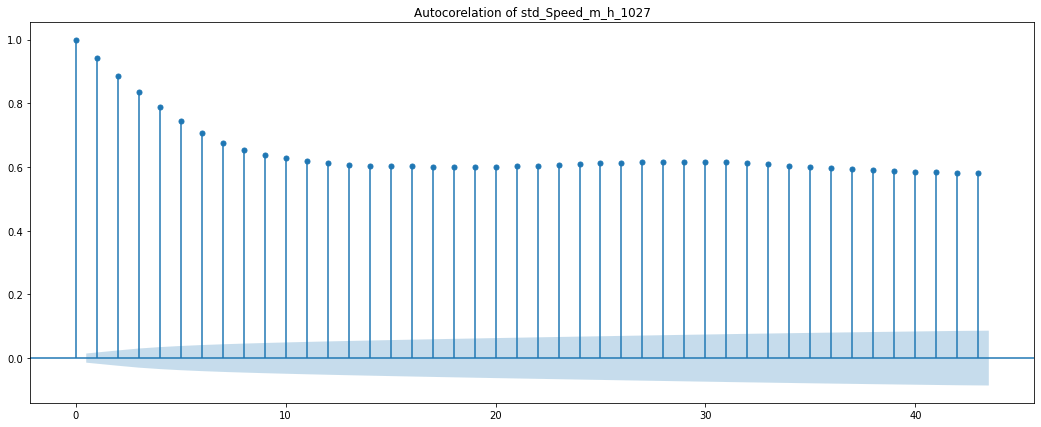

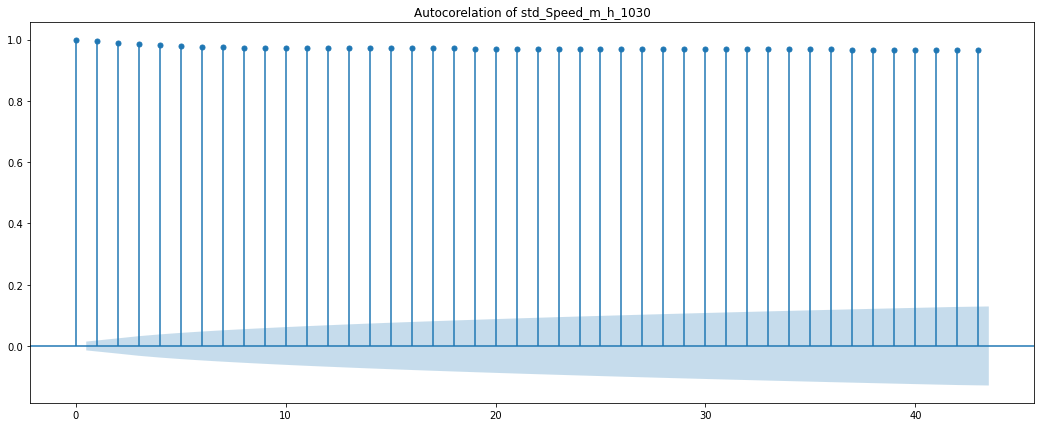

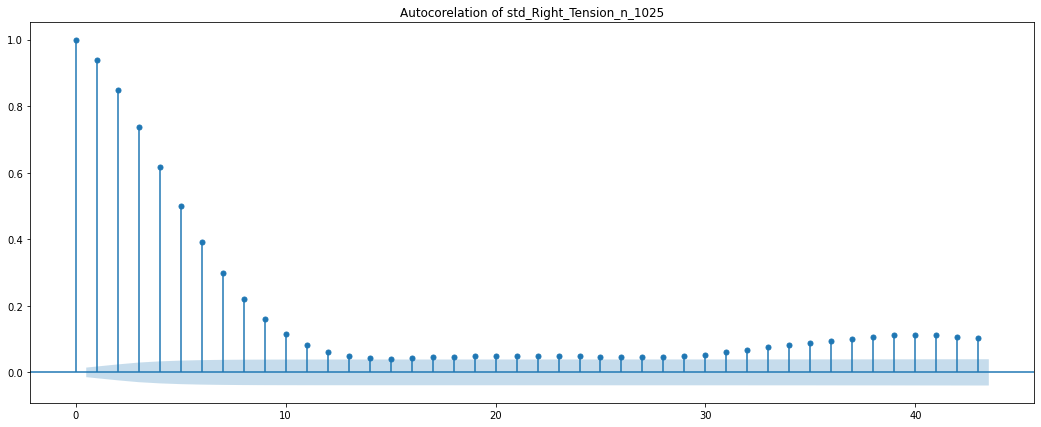

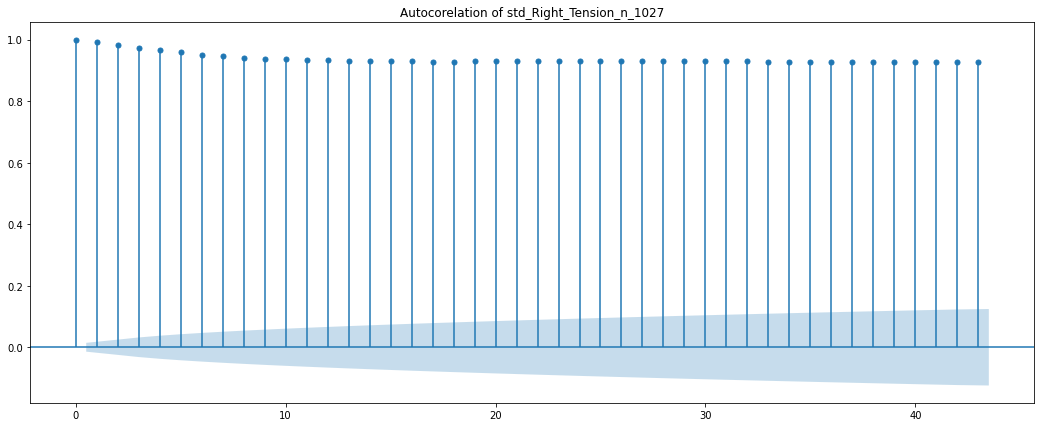

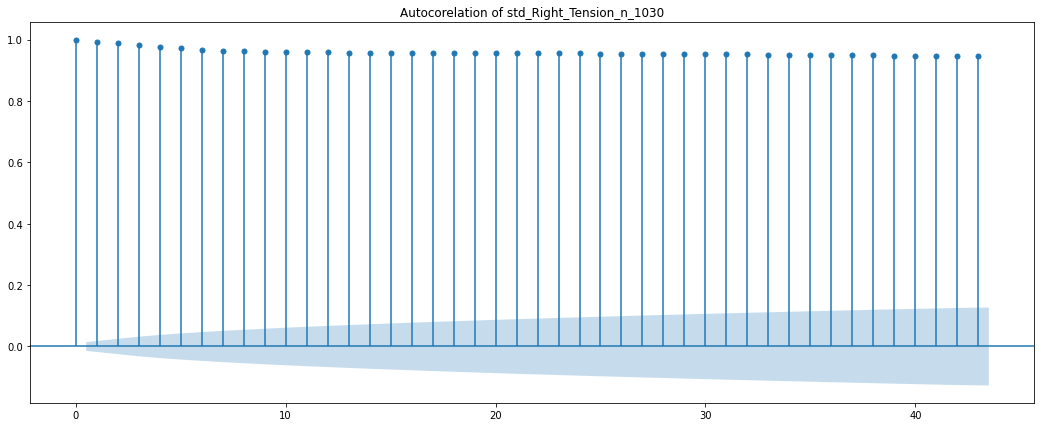

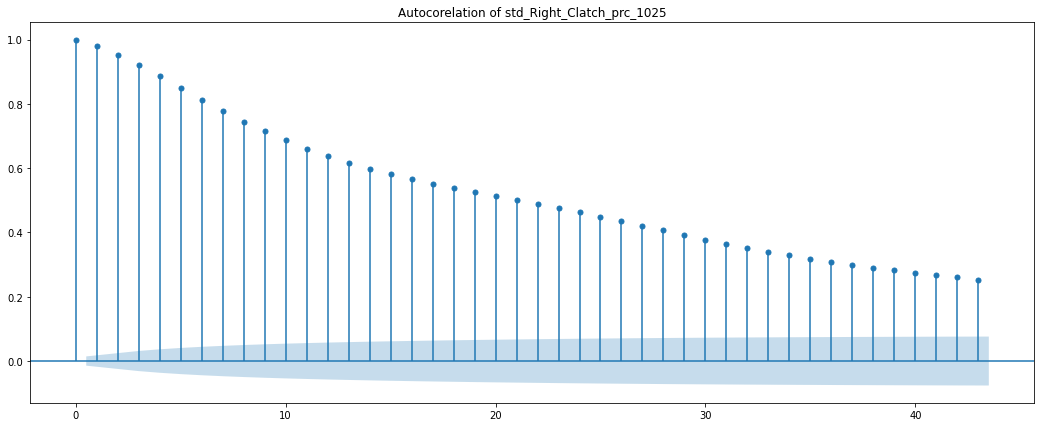

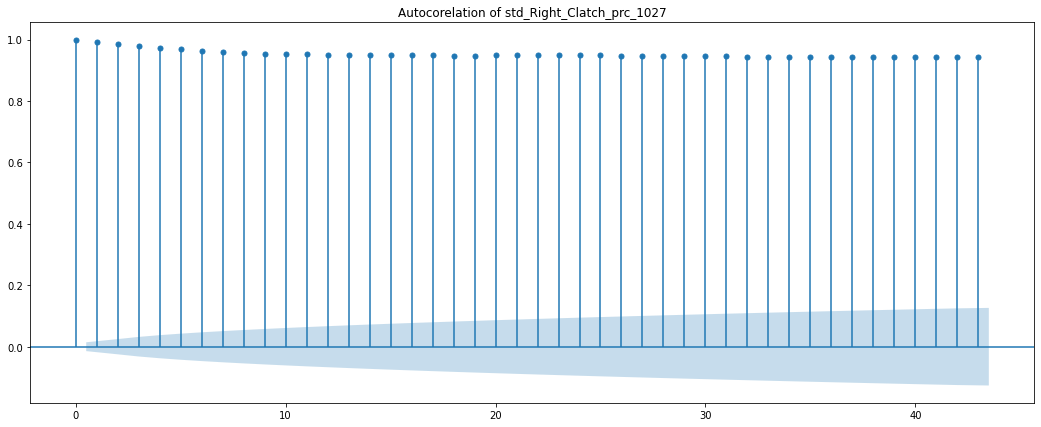

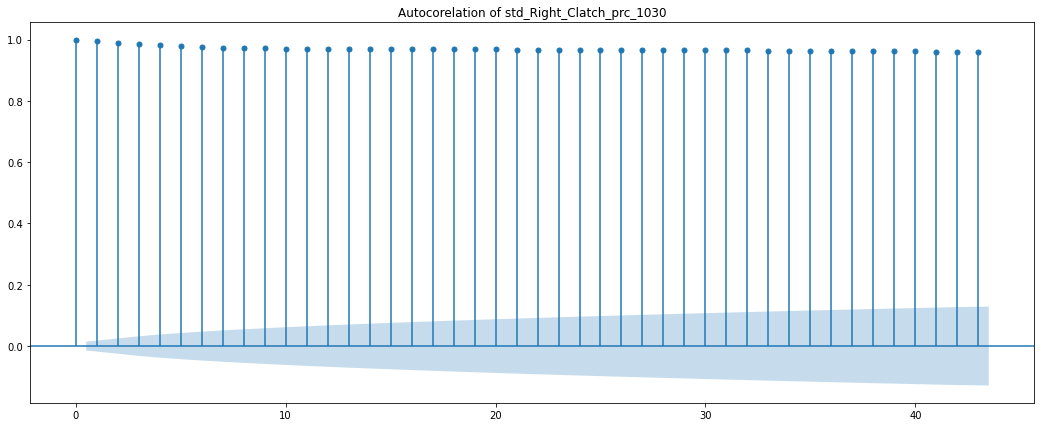

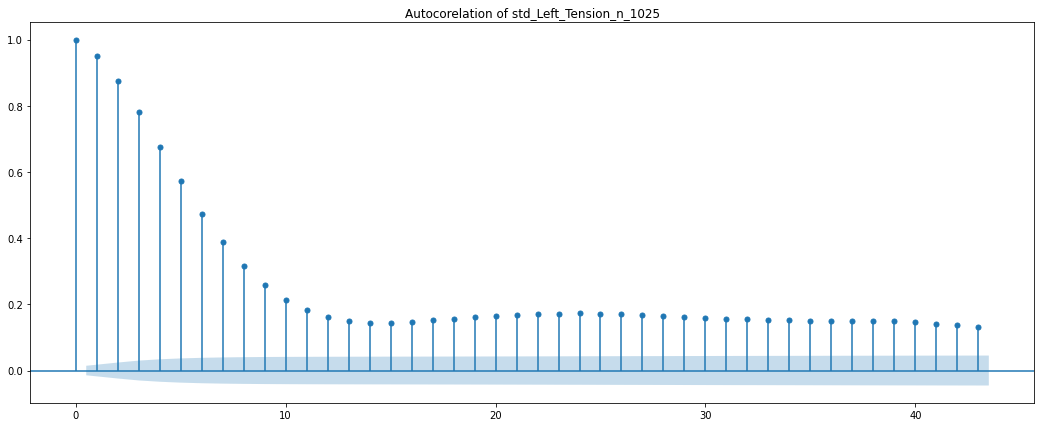

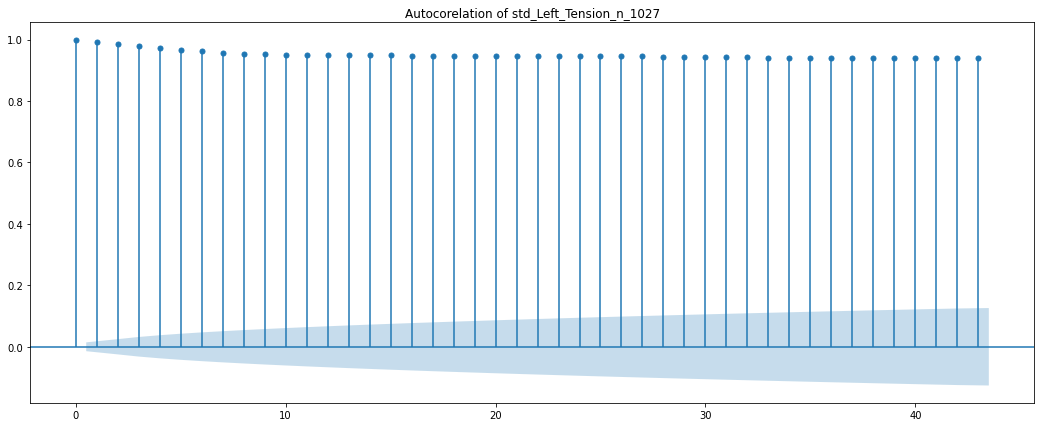

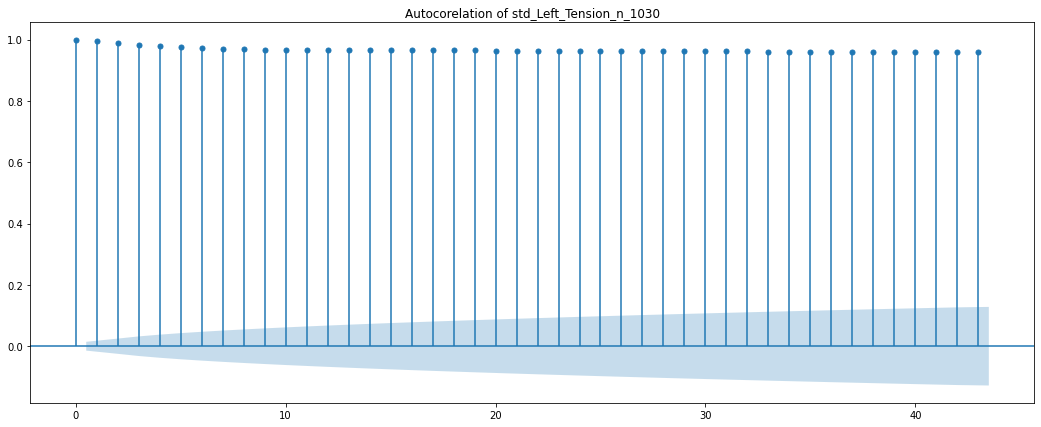

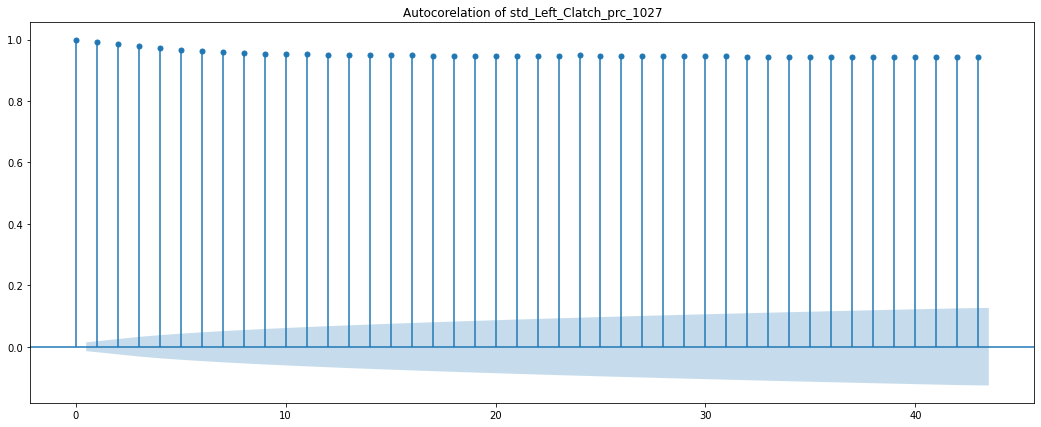

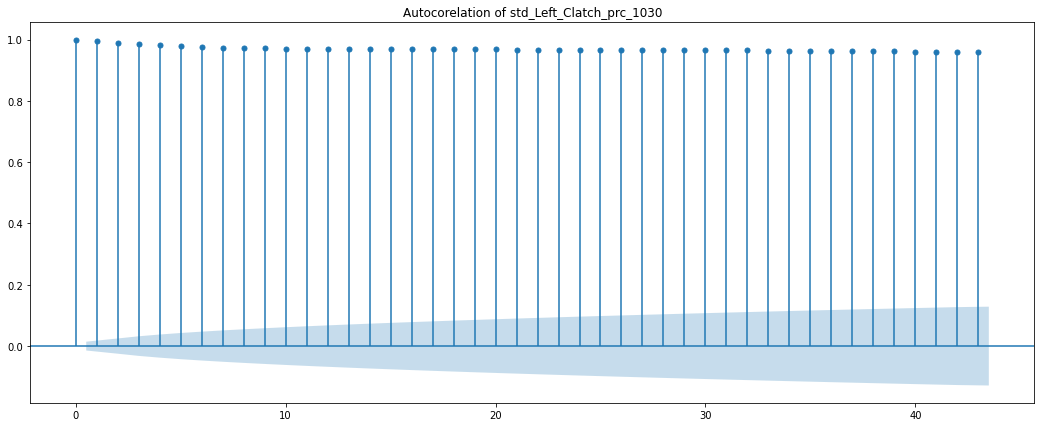

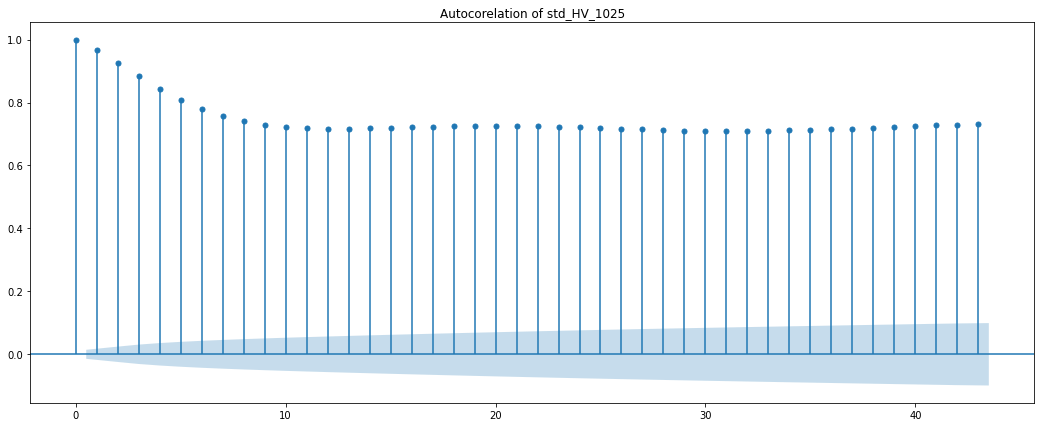

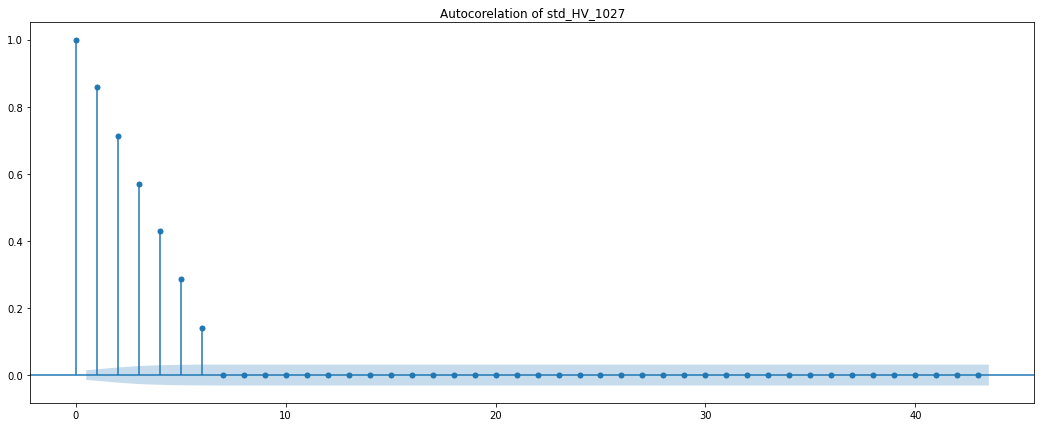

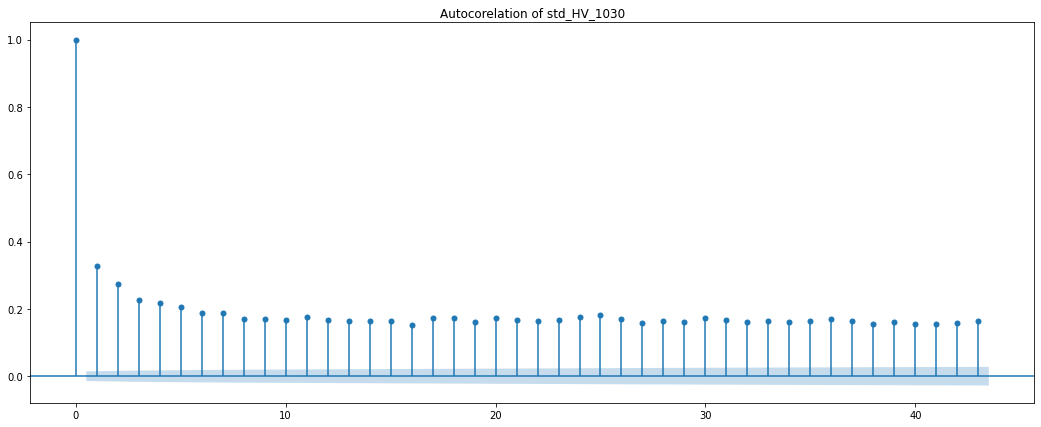

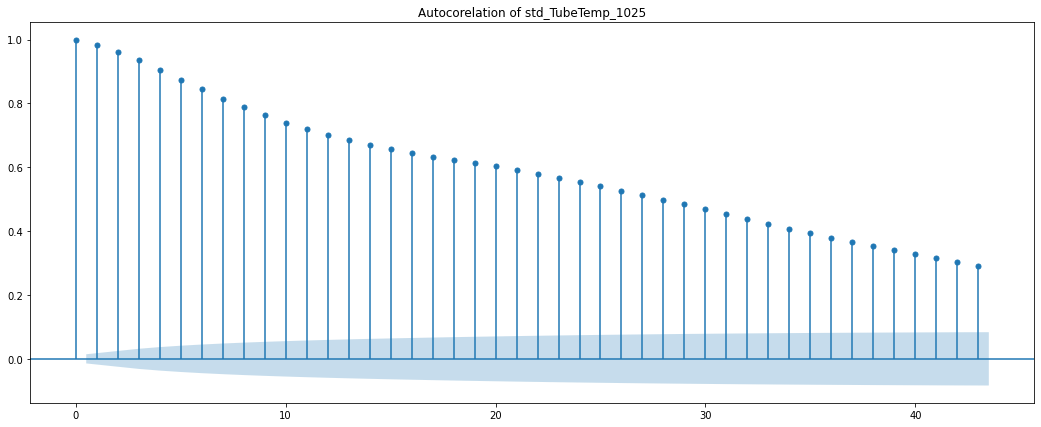

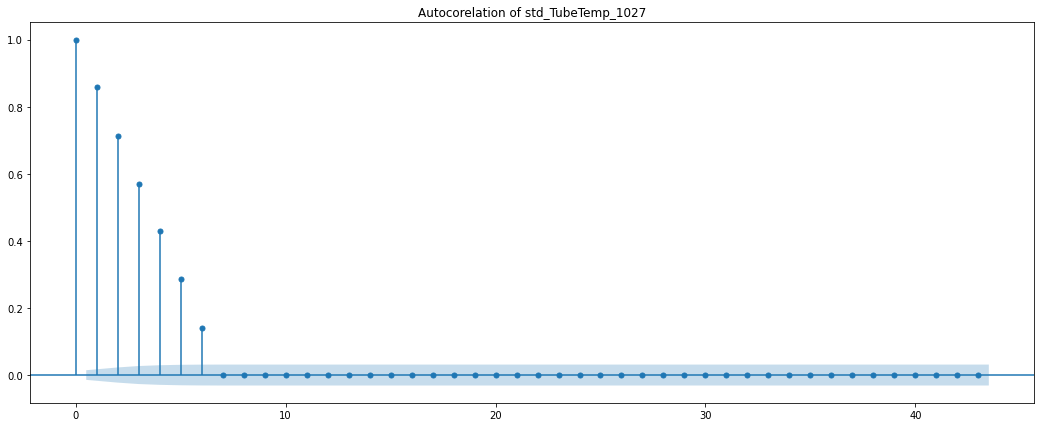

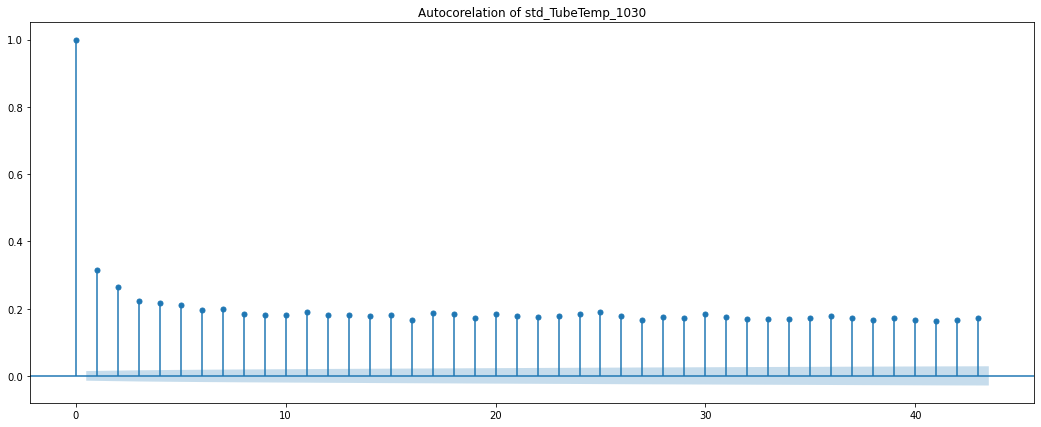

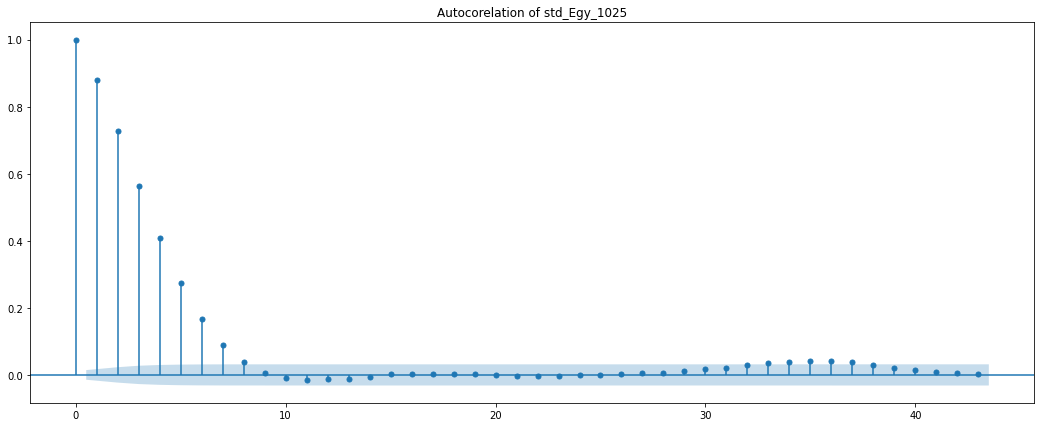

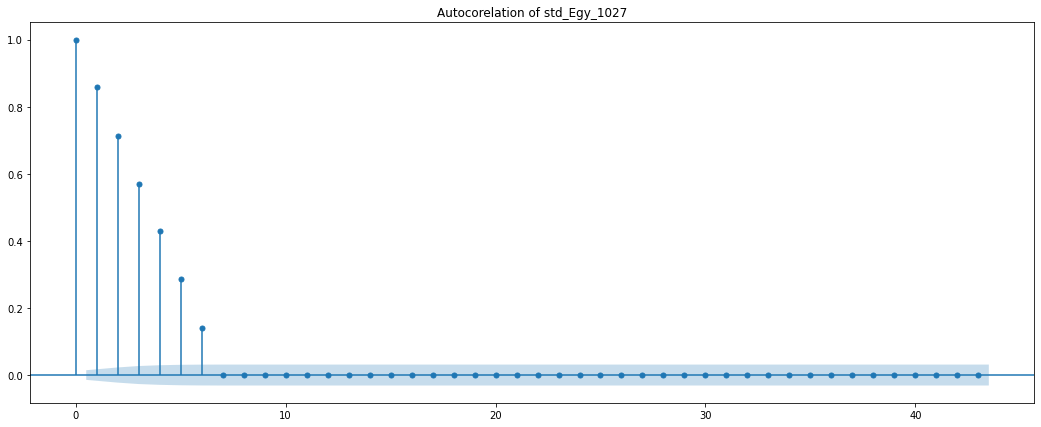

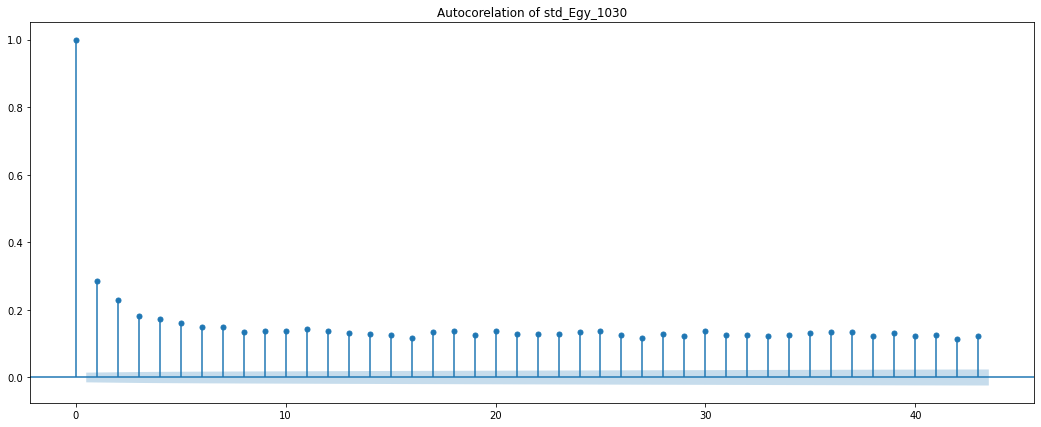

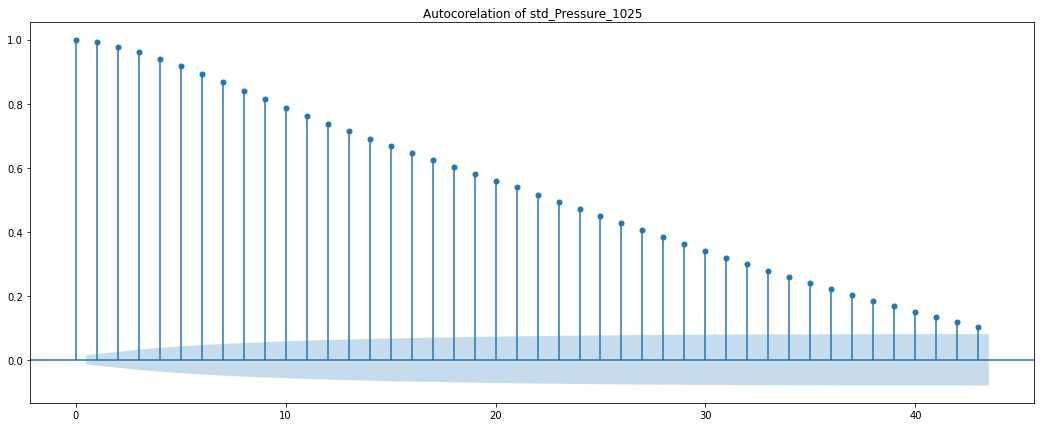

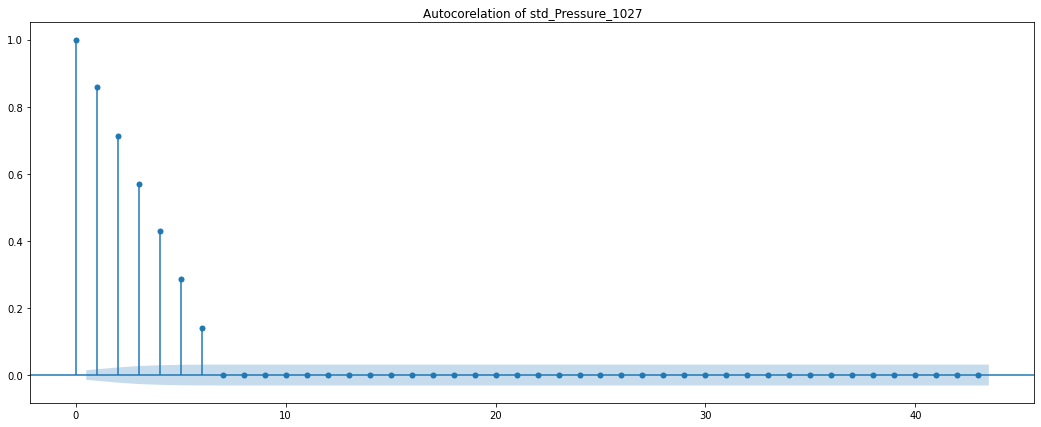

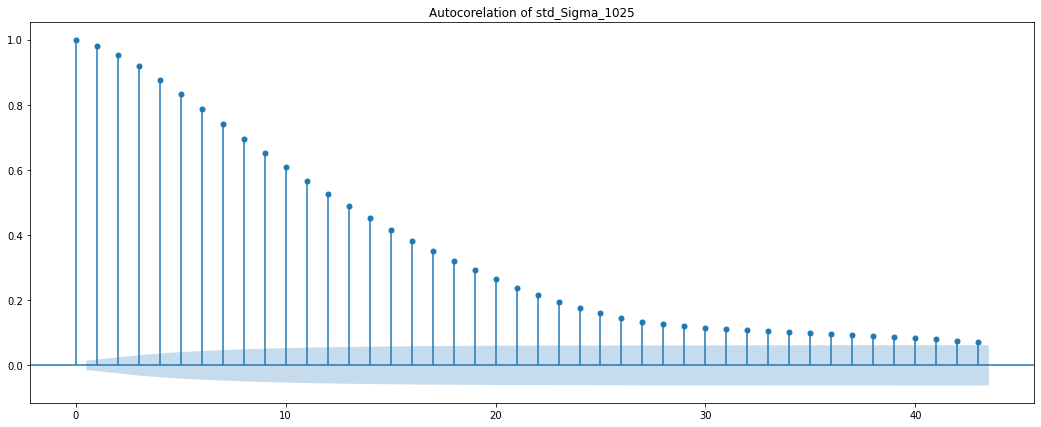

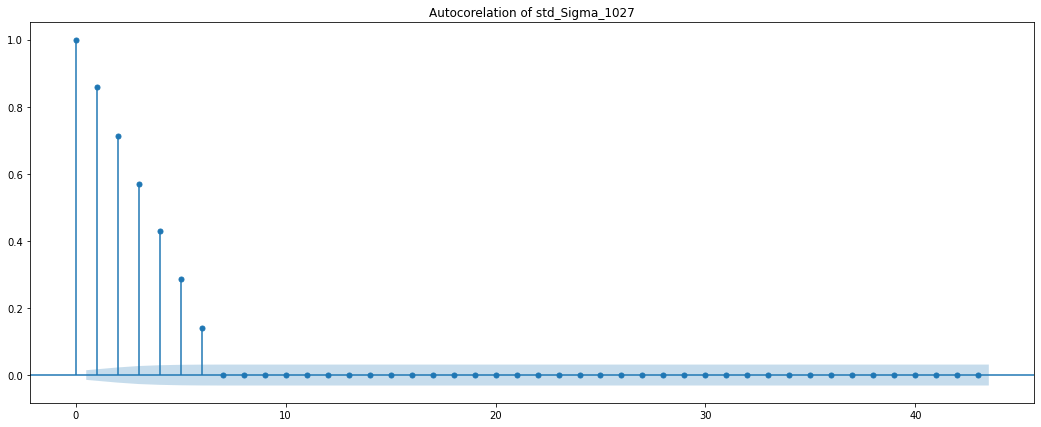

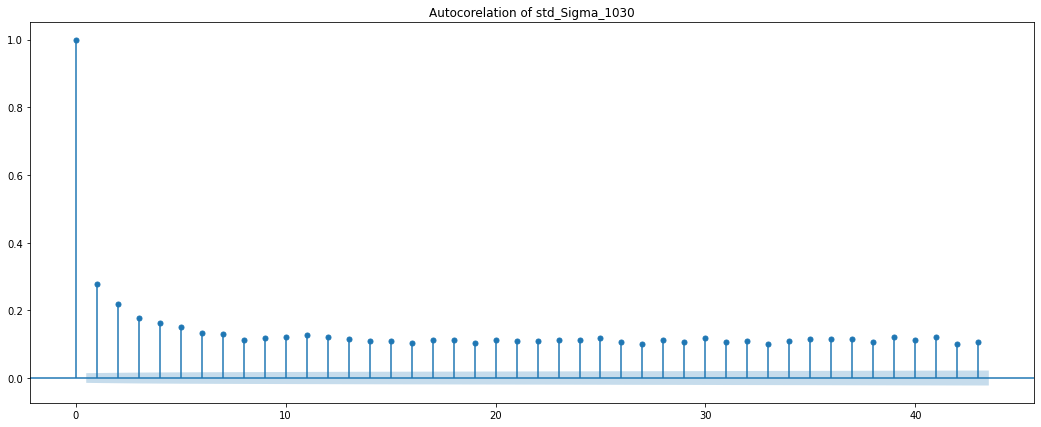

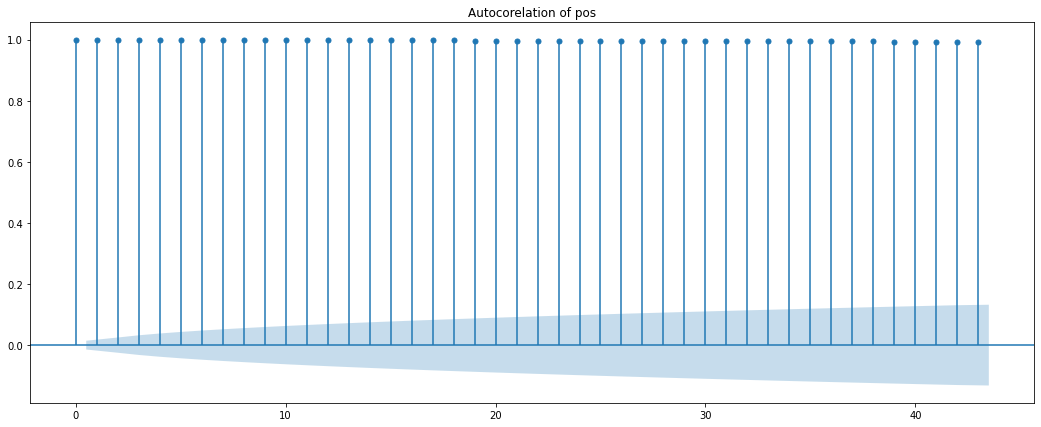

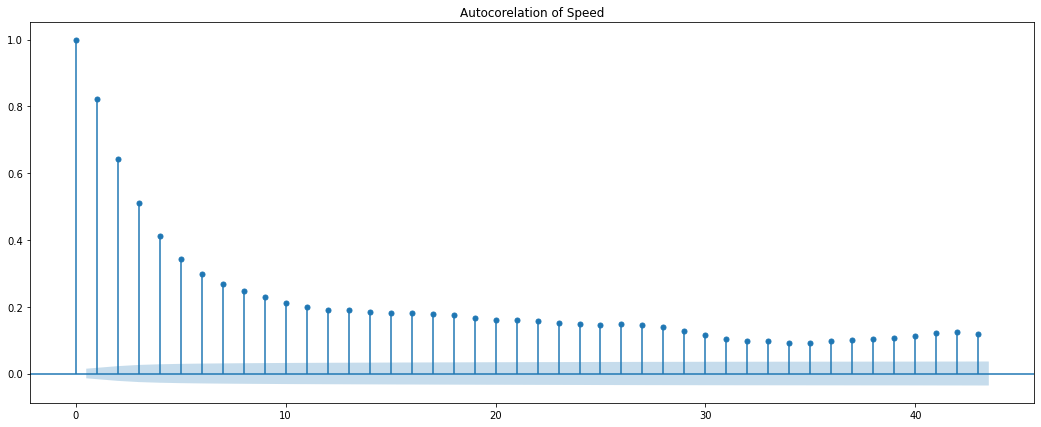

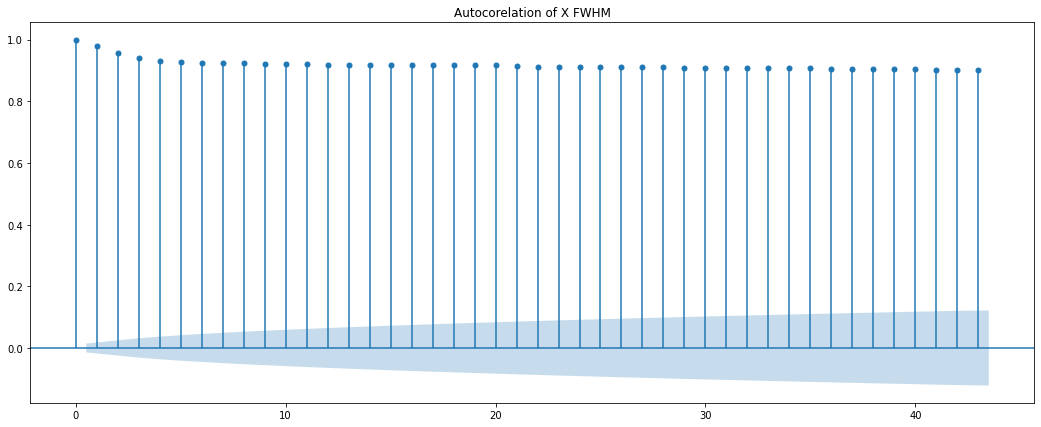

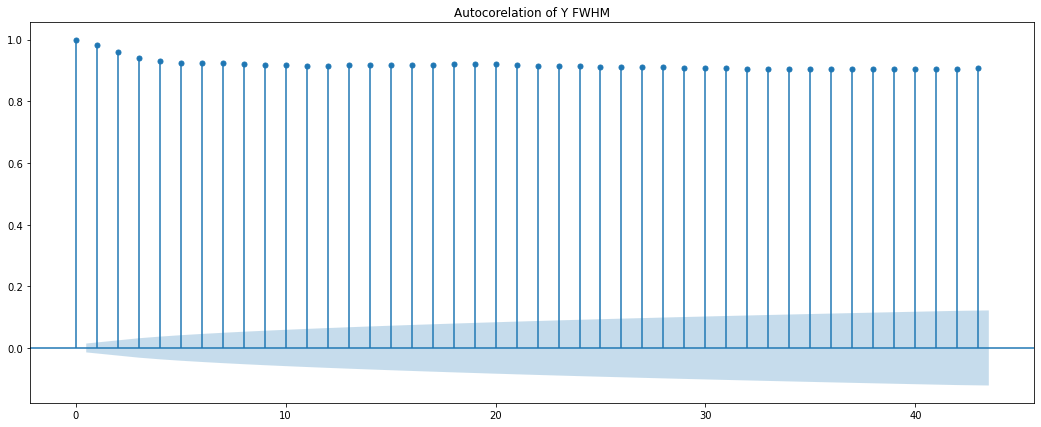

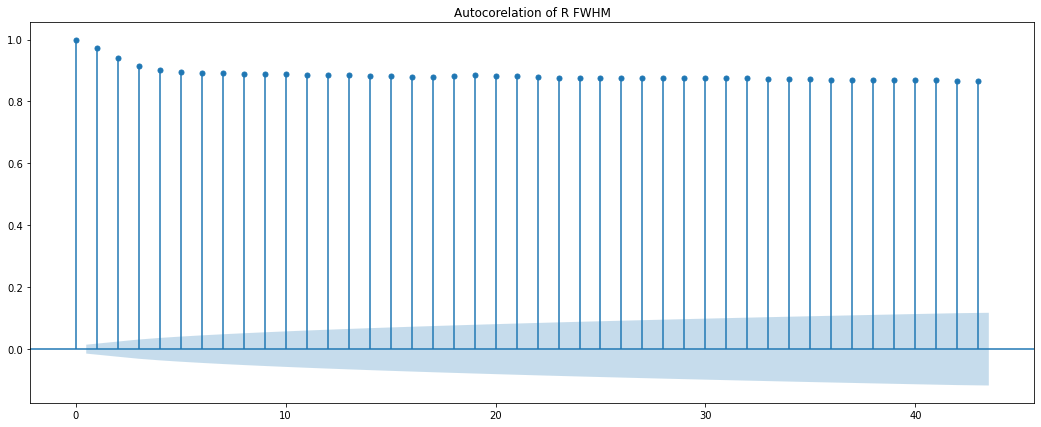

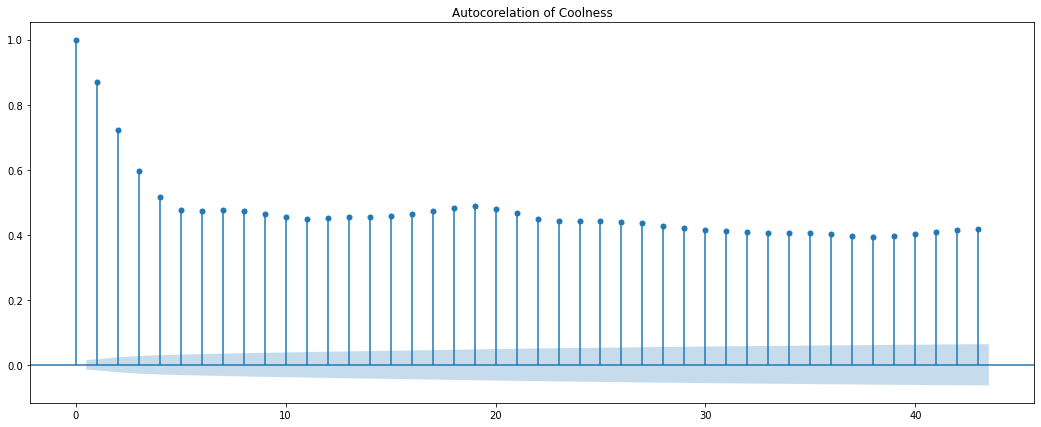

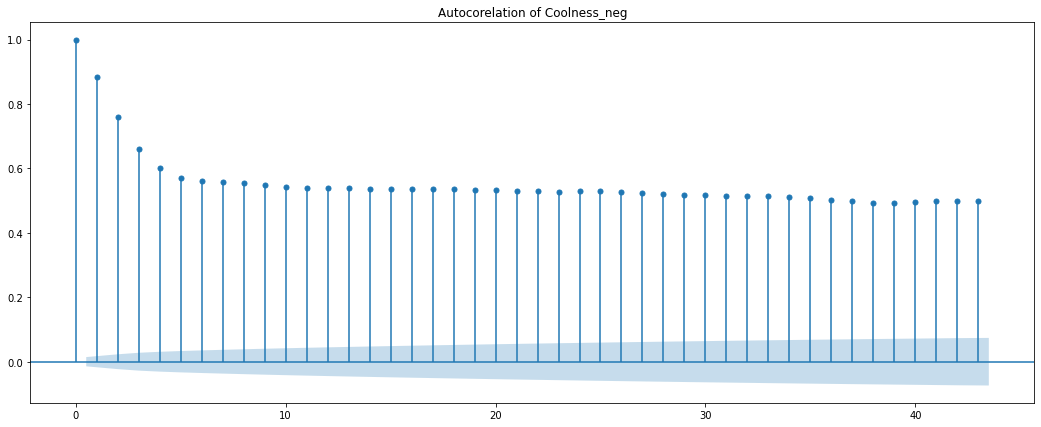

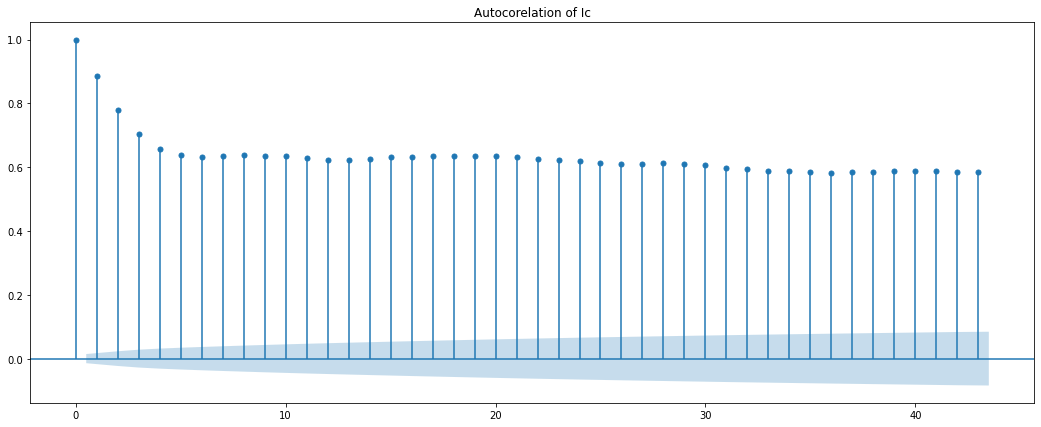

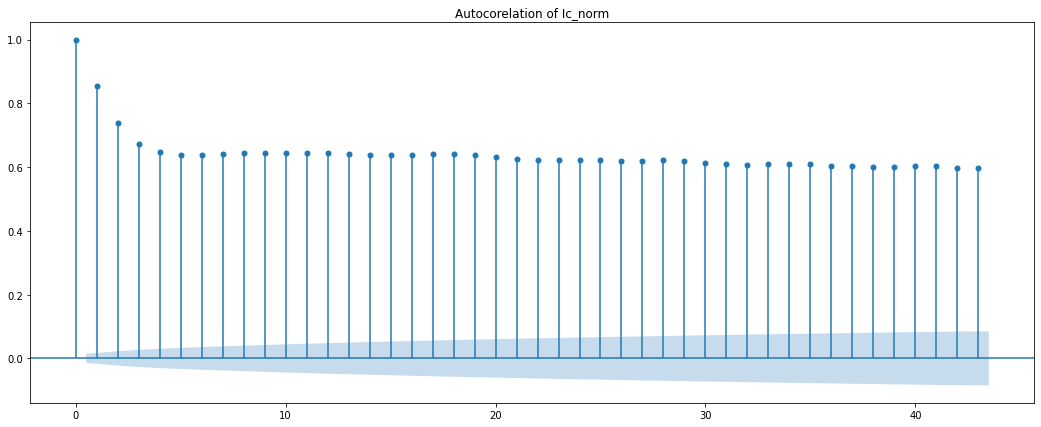

In [8]:
for feature in pld_complete_range.columns:
    fig, ax = plt.subplots(figsize=(18, 7))
    
    plot_acf(pld_complete_range.loc[:, feature],  ax=ax)
    ax.set_title("Autocorelation of " + feature)
    plt.show()

- The plot shows lag values along the x-axis and correlation on the y-axis between -1 and 1 for negatively and positively correlated lags respectively.

- The dots above the blue area indicate statistical significance. The correlation of 1 for the lag value with itself indicates 100% positive correlation of an observation with itself.

- Approximately, 100 of the above plots show low correlation between the feature and its delayed version. (probably it is right to consider this dataset as timeseries data set)

So let us apply some related methods

## Converting a timeseries data set into a supervise learning preserving the time dependencies 


We can convert each timeseries/variable/feature in our dataset into a supervised learning problem by taking the lag observation (e.g. t-1) as inputs and using the current observation (t) as the output variable.


We can do this in Pandas using the shift function to create new columns of shifted observations.



In [12]:
period = 10  # User define parameter 

# reframe as supervised learning
lagged_df_x = pd.DataFrame()
features = x_r_train.columns

for feature in range(len(features)):
    for i in range(period,0,-1):
        lagged_df_x[features[feature] 
                  +'-' +str(i)] = x_r_train.shift(i).values[:, feature]
    lagged_df_x[feature] = x_r_train.shift(i).values[:, feature]
    

lagged_df_x.dropna(inplace=True)


In [13]:
lagged_df_x.head()

median_Voltage_HSR_V_1025-10  median_Voltage_HSR_V_1025-9  \
10                      -0.20066                     -0.22008   
11                      -0.22008                     -0.09385   
12                      -0.09385                      0.01296   
13                       0.01296                     -0.02588   
14                      -0.02588                     -0.02588   

    median_Voltage_HSR_V_1025-8  median_Voltage_HSR_V_1025-7  \
10                     -0.09385                      0.01296   
11                      0.01296                     -0.02588   
12                     -0.02588                     -0.02588   
13                     -0.02588                     -0.00646   
14                     -0.00646                      0.07122   

    median_Voltage_HSR_V_1025-6  median_Voltage_HSR_V_1025-5  \
10                     -0.02588                     -0.02588   
11                     -0.02588                     -0.00646   
12                     -0.00646                      0.07122   
13                      0.07122                     -0.00646   
14                     -0.00646                     -0.07443   

    median_Voltage_HSR_V_1025-4  median_Voltage_HSR_V_1025-3  \
10                     -0.00646                     0.071220   
11                      0.07122                    -0.006460   
12                     -0.00646                    -0.074430   
13                     -0.07443                    -0.064720   
14                     -0.06472                     0.129479   

    median_Voltage_HSR_V_1025-2  median_Voltage_HSR_V_1025-1  ...  \
10                    -0.006460                    -0.074430  ...   
11                    -0.074430                    -0.064720  ...   
12                    -0.064720                     0.129479  ...   
13                     0.129479                     0.245999  ...   
14                     0.245999                     0.129479  ...   

    Coolness_neg-9  Coolness_neg-8  Coolness_neg-7  Coolness_neg-6  \
10        0.021371       -0.038746        0.059309       -0.089812   
11       -0.038746        0.059309       -0.089812       -0.039254   
12        0.059309       -0.089812       -0.039254        0.091440   
13       -0.089812       -0.039254        0.091440        0.035241   
14       -0.039254        0.091440        0.035241        0.054283   

    Coolness_neg-5  Coolness_neg-4  Coolness_neg-3  Coolness_neg-2  \
10       -0.039254        0.091440        0.035241        0.054283   
11        0.091440        0.035241        0.054283        0.042621   
12        0.035241        0.054283        0.042621       -0.043829   
13        0.054283        0.042621       -0.043829       -0.021699   
14        0.042621       -0.043829       -0.021699        0.044607   

    Coolness_neg-1       375  
10        0.042621  0.042621  
11       -0.043829 -0.043829  
12       -0.021699 -0.021699  
13        0.044607  0.044607  
14       -0.018379 -0.018379  

[5 rows x 4136 columns]

In [22]:
period = 10  # User define parameter 

# reframe as supervised learning
lagged_df_y = pd.DataFrame()
features = ['Ic_norm']

for feature in range(len(features)):
    for i in range(period,0,-1):
        lagged_df_y[features[feature] 
                  +'-' +str(i)] = y_train.shift(i).values
    lagged_df_y[feature] = y_train.shift(i).values
    

lagged_df_y.dropna(inplace=True)


In [23]:
lagged_df_y.shape

(13910, 11)

### Rf-Reg and feature importance


In [24]:
from sklearn.ensemble import RandomForestRegressor

array = lagged_df.values

# fit random forest model
model = RandomForestRegressor(n_estimators=100, random_state=1)
model.fit(lagged_df_x, lagged_df_y)


RandomForestRegressor(random_state=1)

In [25]:
interval = 0
ticks = [i for i in range(period)]
for feature in range(len(features)-370):
    fig, ax = plt.subplots(figsize=(18, 7))
    
    ax.bar(ticks, model.feature_importances_[interval:interval+period])
    ax.set_title("Importance of " + features[feature] + " along its lagged version")
#     ax.set_xticks(ticks,
#                   names[interval:interval+period])
    plt.show()
    
    interval += period
    

In [30]:
period = 10  # User define parameter 

# reframe as supervised learning
lagged_df_y_test = pd.DataFrame()
features = ['Ic_norm']

for feature in range(len(features)):
    for i in range(period,0,-1):
        lagged_df_y_test[features[feature] 
                  +'-' +str(i)] = y_test.shift(i).values
    lagged_df_y_test[feature] = y_test.shift(i).values
    

lagged_df_y_test.dropna(inplace=True)

In [31]:
period = 10  # User define parameter 

# reframe as supervised learning
lagged_df_x_test = pd.DataFrame()
features = x_r_test.columns

for feature in range(len(features)):
    for i in range(period,0,-1):
        lagged_df_x_test[features[feature] 
                  +'-' +str(i)] = x_r_test.shift(i).values[:, feature]
    lagged_df_x_test[feature] = x_r_test.shift(i).values[:, feature]
    

lagged_df_x_test.dropna(inplace=True)


In [33]:
y_hat_rf = model.predict(lagged_df_x_test)

rf_reg_feature_importance = model.feature_importances_  # Gini Index/impurity
        
r2_score_rf = model.score(lagged_df_x_test, lagged_df_y_test)
    
rf_mae = mae(y_trues=lagged_df_y_test, y_preds=y_hat_rf)
rf_rmse = rmse(y_trues=lagged_df_y_test, y_preds=y_hat_rf)
rf_mrae = mrae(y_trues=lagged_df_y_test, y_preds=y_hat_rf)

In [34]:
r2_score_rf

0.4590833683987347

In [35]:
rf_mae

Ic_norm-10    0.018275
Ic_norm-9     0.018482
Ic_norm-8     0.018243
Ic_norm-7     0.018433
Ic_norm-6     0.018326
Ic_norm-5     0.018245
Ic_norm-4     0.018269
Ic_norm-3     0.018339
Ic_norm-2     0.018302
Ic_norm-1     0.018128
0             0.018128
dtype: float64

In [36]:
rf_rmse

Ic_norm-10    0.026171
Ic_norm-9     0.026276
Ic_norm-8     0.026140
Ic_norm-7     0.026362
Ic_norm-6     0.026226
Ic_norm-5     0.026147
Ic_norm-4     0.026167
Ic_norm-3     0.026179
Ic_norm-2     0.026159
Ic_norm-1     0.025902
0             0.025902
dtype: float64

In [37]:
rf_mrae

Ic_norm-10    0.010707
Ic_norm-9     0.010828
Ic_norm-8     0.010689
Ic_norm-7     0.010799
Ic_norm-6     0.010737
Ic_norm-5     0.010691
Ic_norm-4     0.010704
Ic_norm-3     0.010744
Ic_norm-2     0.010723
Ic_norm-1     0.010620
0             0.010620
dtype: float64

### Conclusion

- Again applying RF-Reg on the shuffled data set brings far better results.

